# Ex. 7: MCMC sampling from gaussian posterior
## Marco Giunta

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Introduction
## Why MCMC?
In order to perform bayesian inference of a set of unknown parameters we usually want to compute the posterior, from which we can assign a certain credibility to all possible parameters values and compute quantities of interest (e.g. MAP estimators, credibility intervals). From Bayes' theorem we know that the posterior can be obtained by combining a model-dependent likelihood, a user defined prior and the evidence computed by integrating their product; unfortunately there are many practical situations where it is relatively straightforward to write the likelihood $\times$ prior product, but impractical/impossible to perform its integral.

In cases like these a common approach is to sample many points from the posterior, then use them to reconstruct the posterior itself; in particular this can be done without computing the evidence by using MCMC methods. There are many algorithms in this family, but they all produce a time series to approximate a stochastic process which will (hopefully) converge asymptotically to the desired distribution. Actually reaching convergence can be tricky and require multiple tests and techniques (e.g. burn-in); for this reason we apply two basic MCMC algorithms to a 2D MVN distribution, for which it's easy to analytically compute every interesting quantity. This will allow us to compare "experimental" results with the exact ones.

## Distribution definition
The distribution we will be working with is a 2D MVN $N(\mu, C)$ with mean $\mu = (4, 2)^T$ and covariance matrix
\begin{equation}
C = \begin{bmatrix} 1.44 & -0.702\\ -0.702 & 0.81\end{bmatrix}
\end{equation}
(Notice that in this notebook we use $C$ instead of $\Sigma$ and $(x, y)$ instead of $(X_1, X_2)$ for simplicity).

In [2]:
mu <- c(4, 2)
C  <- matrix(c(1.440, -0.702,
               -0.702, 0.810), nrow = 2, ncol = 2, byrow = TRUE)
print("gaussian mean:")
print(mu)
cat("\n")
print("gaussian cov. matrix:")
print(C)

[1] "gaussian mean:"
[1] 4 2

[1] "gaussian cov. matrix:"
       [,1]   [,2]
[1,]  1.440 -0.702
[2,] -0.702  0.810


We can imagine this distribution is the posterior distribution obtained while performing bayesian inference of two correlated parameters (e.g. we're dealing with a gaussian likelihood and a uniform prior).

Notice that of course this distribution is trivially normalized, and easily dealt with when computing estimators - so in a practical setting it wouldn't make much sense to use expensive MCMC methods; here we use it exactly to compare different approaches.

# Exact results
## Contour plot
We start by visualizing our distribution. To do this we define a grid of 2D points, then evaluate
\begin{equation}
N( \bm{v} |\mu, C) = \frac{1}{2\pi \sqrt{|C|}} \exp\left(-\frac{1}{2} \bm{v}^T C^{-1} \bm{v} \right)
\end{equation}
where $\bm{v} = (x, y)^T - \mu$.

In [3]:
# meshgrid definition

n  <- 100 # number of points per side
xx <- seq(-1, 9, length.out = n) # x in [-1, 9]
yy <- seq(0, 4, length.out = n)  # y in [0, 4]
zz  <- matrix(0, nrow = n, ncol = n) # NxN matrix of zeros

In [4]:
# evaluation of the MVN over the 2D rectangular grid

den   <- 2 * pi * sqrt(det(C)) # gaussian denominator
C_inv <- matlib::inv(C) # inverse of cov. matrix

# zz[j, i] = f(xx[i], yy[[j]]) where f is our dist.
for (i in seq_along(xx)) {
    for (j in seq_along(yy)) {
        v       <- (c(xx[i], yy[j]) - mu) |> as.array(dim = c(2, 1))
        fac     <- (t(v) %*% C_inv %*% v)
        zz[j, i] <- exp(-fac / 2) / den
    }
}
# zz[j, i] and not zz[i, j] to comply with the graphical convention
# employed by most contour plotting functions by default

In [5]:
# If we want to be slick we can vectorize the above loop using
# Einstein's notation. It suffices to provide a "blueprint"
# for each evaluation, which is simply the (exponential of) the
# known vector * matrix * vector product

M <- pracma::meshgrid(xx, yy)
X <- M$X; Y<- M$Y

pos <- array(0, dim = c(n, n, 2))
pos[, , 1] <- X - mu[1]
pos[, , 2] <- Y - mu[2]

fac      <- einsum::einsum("ijk,kl,ijl->ij", pos, C_inv, pos)
zz_eins  <- exp(-fac / 2) / den # we can use a native R library...

fac      <- reticulate::import("numpy")$einsum("...k,kl,...l->...", pos, C_inv, pos)
zz_numpy <- exp(-fac / 2) / den # ...or python's numpy via reticulate (with
# dot notation support, which makes the "blueprint" more easily provided)

# one can easily check we obtain the same zz matrix

In [6]:
options(repr.plot.width = 12, repr.plot.height = 10)
# useful with jupyter notebook in R

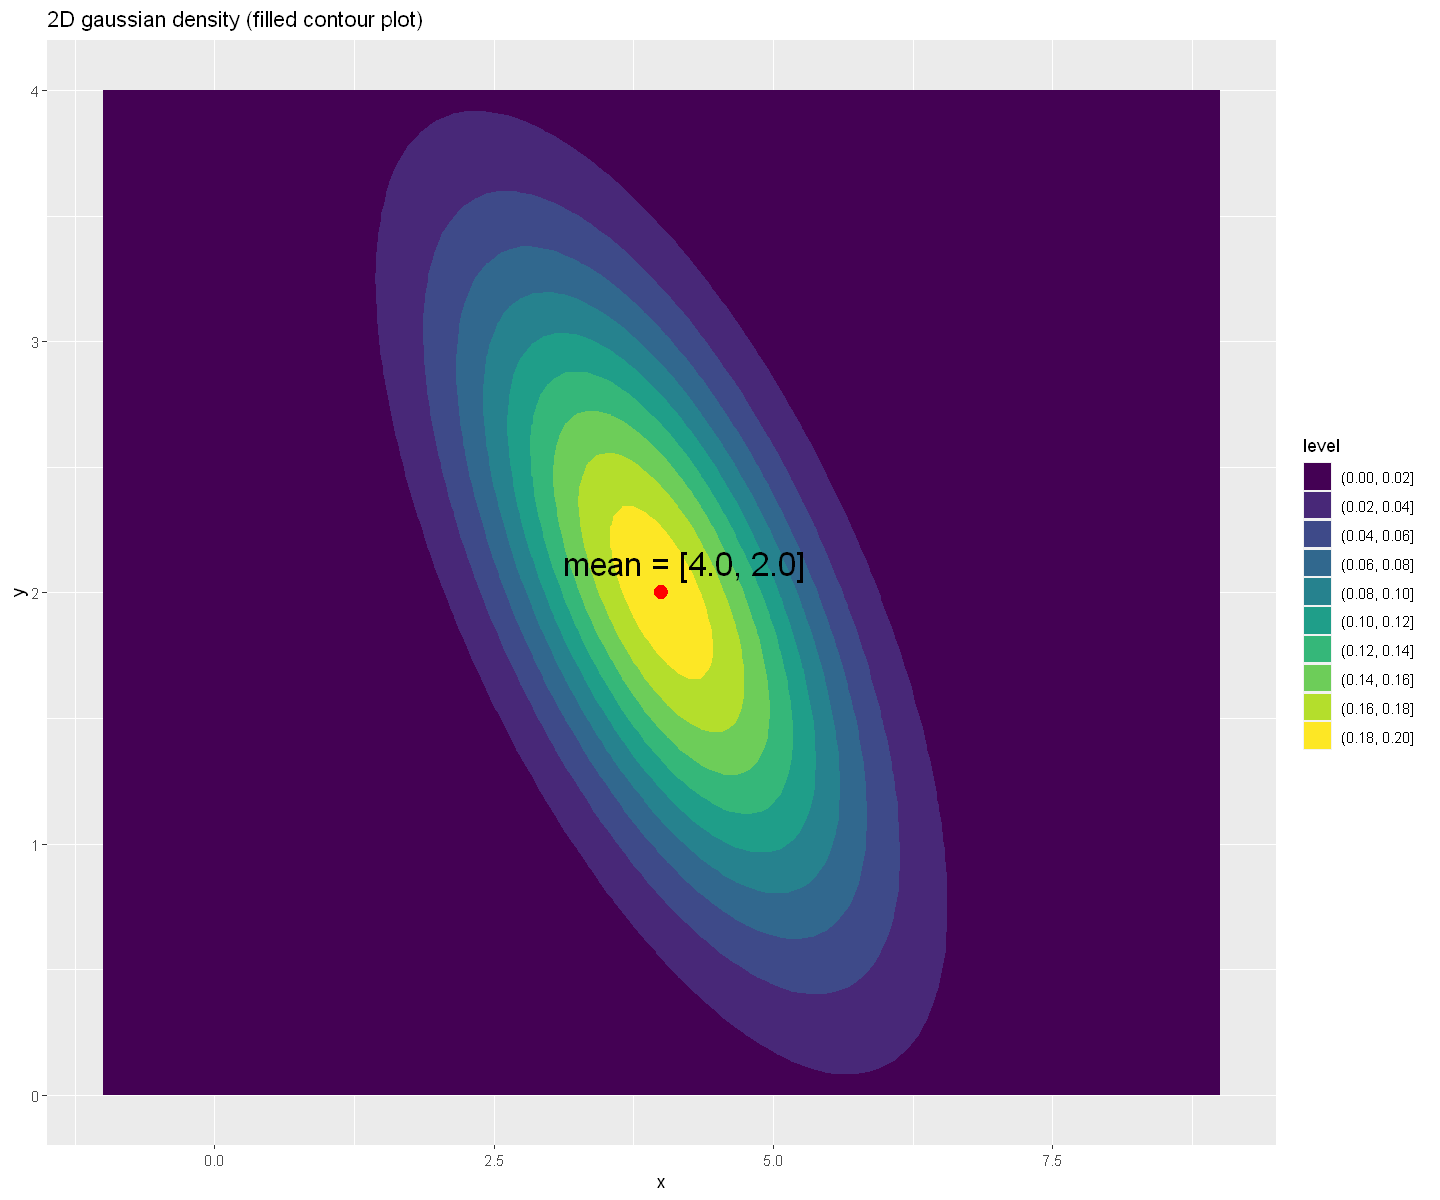

In [7]:
exact_df <- tibble(x = rep(xx, each = n), y = rep(yy, times = n), z = c(zz))
# this repetition scheme is necessary to comply with the graphical convention

ggplot(exact_df, aes(x, y, z = z)) + geom_contour_filled() +
   ggtitle("2D gaussian density (filled contour plot)") +
   annotate("point", x = mu[1], y = mu[2], color = "red", size = 3.5) +
   annotate("text",  x = mu[1] + 0.2, y = mu[2] + 0.12,
            label = sprintf("mean = [%.1f, %.1f]", mu[1], mu[2]),
            size = 7)

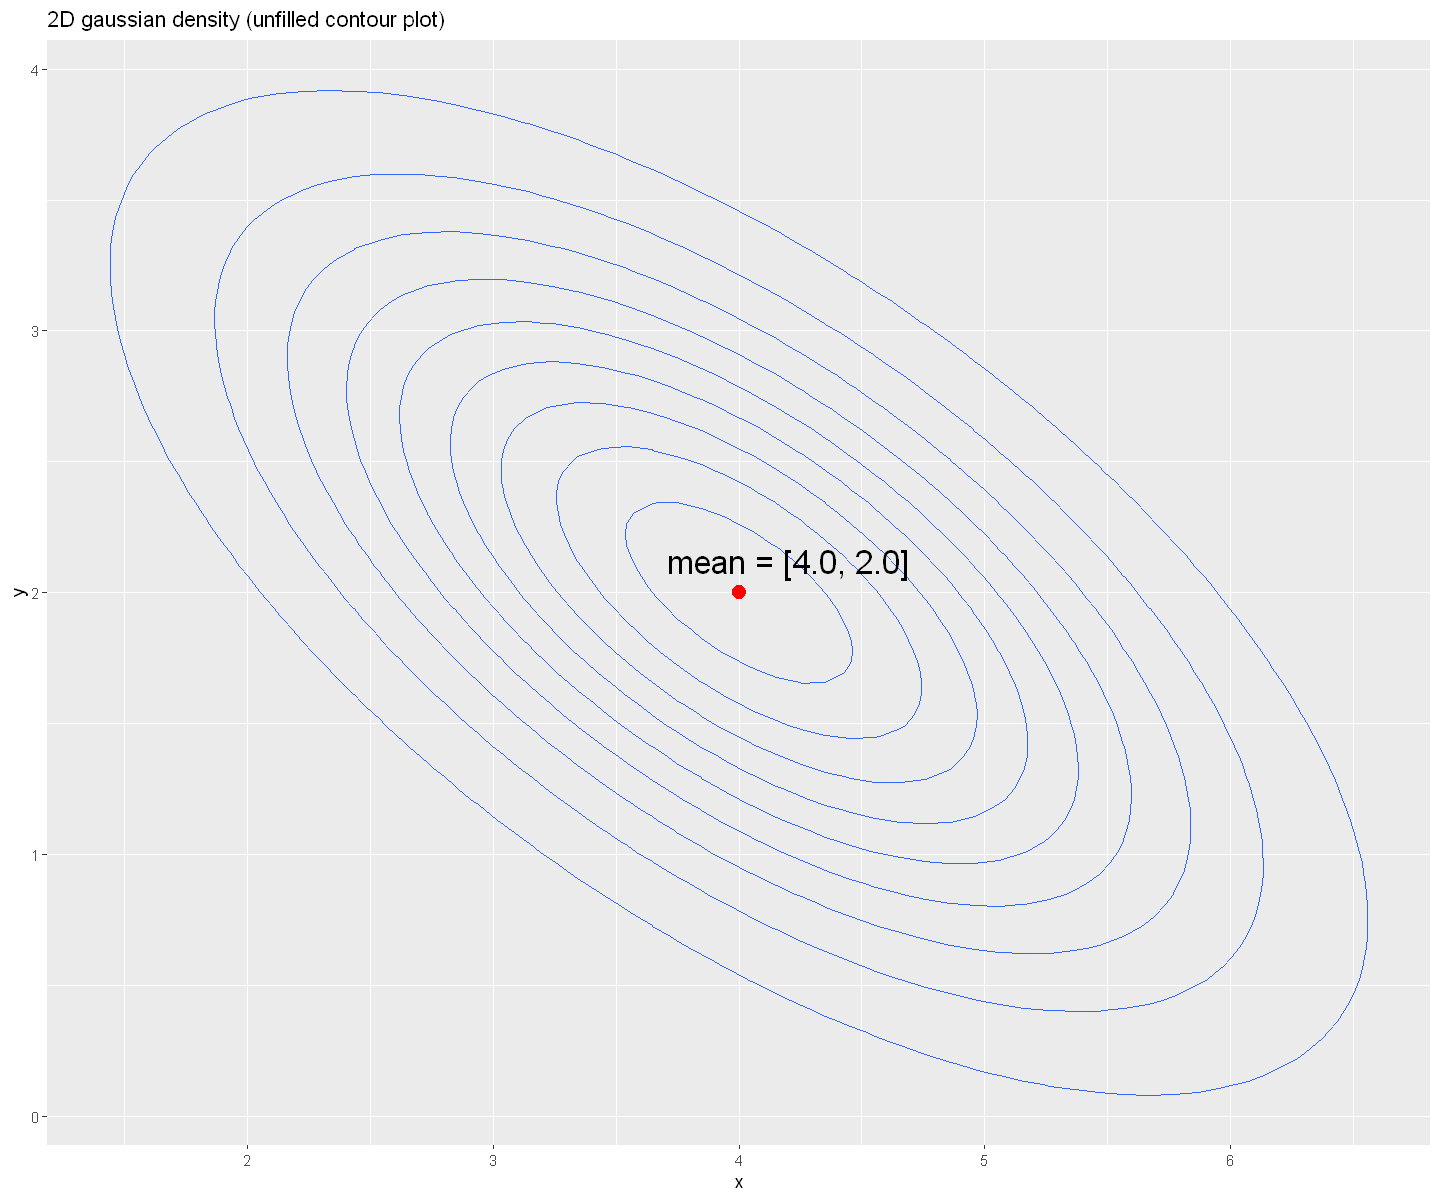

In [8]:
ggplot(exact_df, aes(x, y, z = z)) + geom_contour() +
   ggtitle("2D gaussian density (unfilled contour plot)") +
   annotate("point", x = mu[1], y = mu[2], color = "red", size = 3.5) +
   annotate("text",  x = mu[1] + 0.2, y = mu[2] + 0.12,
            label = sprintf("mean = [%.1f, %.1f]", mu[1], mu[2]),
            size = 7)

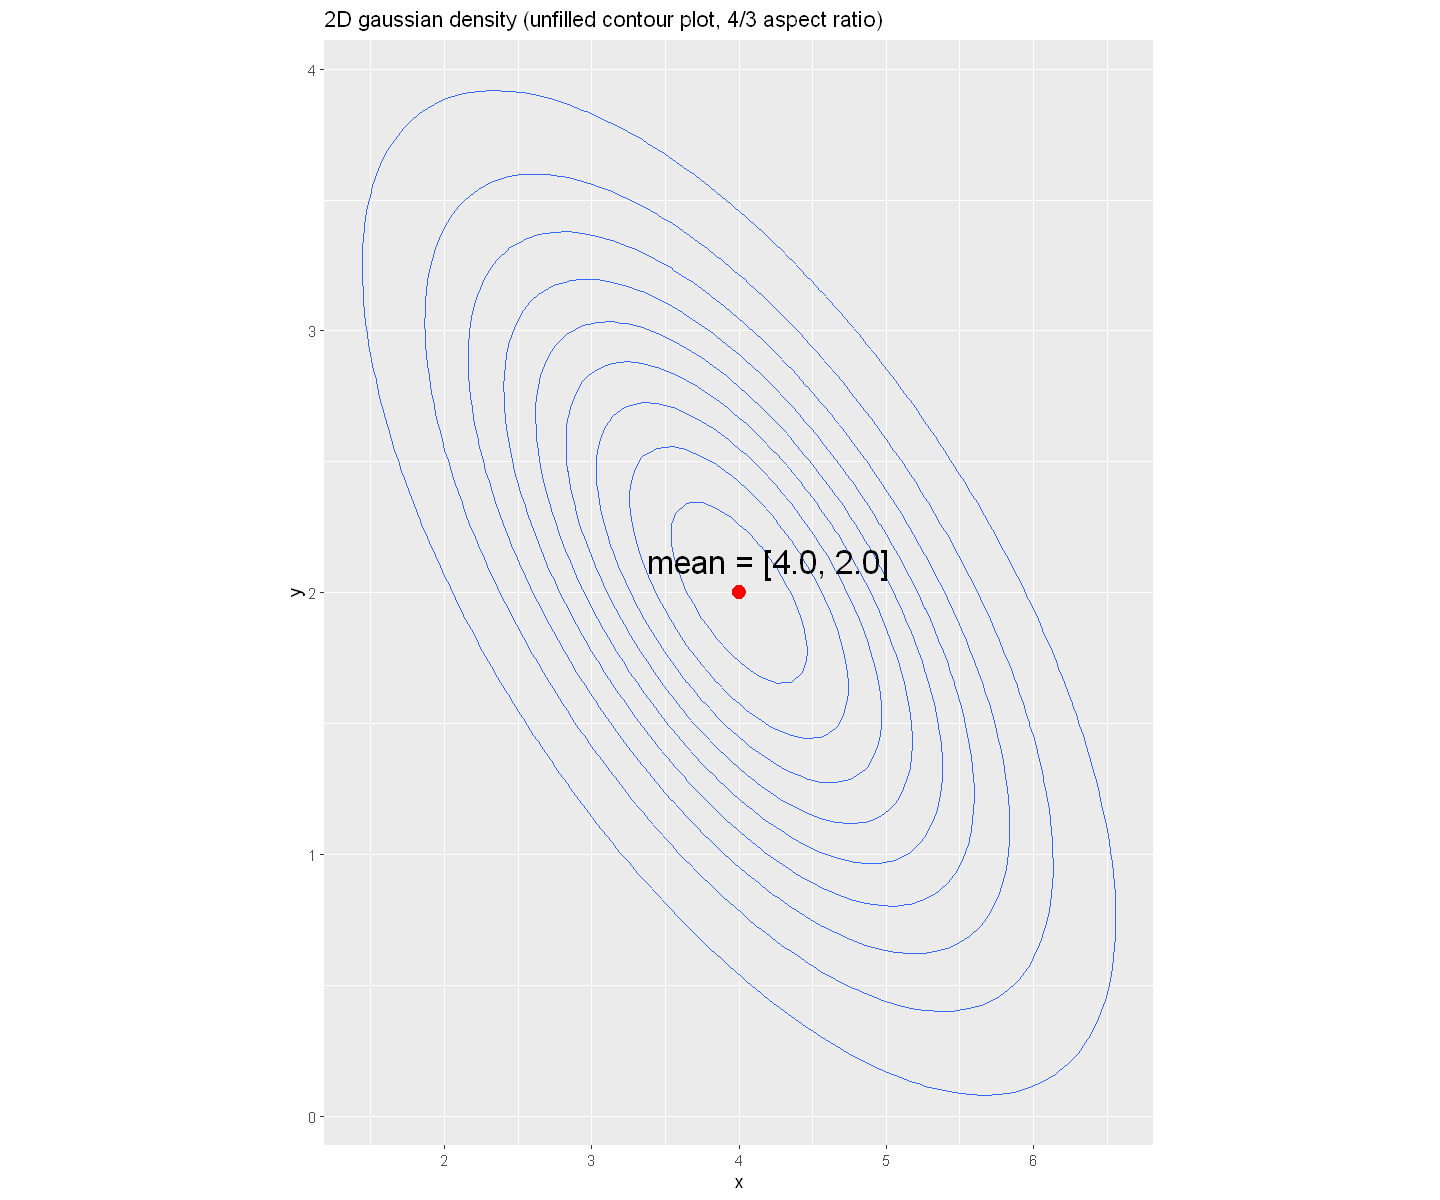

In [9]:
# notice that the above plot seems to be angled slightly differently
# w.r.t the previous contour plot. This is simply because geom_contour_filled
# and geom_point produce plots with different aspect ratios and I had some
# issues with standardizing the aspect ratio. Indeed notice what happens when we
# enforce a 4/3 aspect ratio here too:

ggplot(exact_df, aes(x, y, z = z)) + geom_contour() +
   ggtitle("2D gaussian density (unfilled contour plot, 4/3 aspect ratio)") +
   annotate("point", x = mu[1], y = mu[2], color = "red", size = 3.5) +
   annotate("text",  x = mu[1] + 0.2, y = mu[2] + 0.12,
            label = sprintf("mean = [%.1f, %.1f]", mu[1], mu[2]),
            size = 7) +
    theme(aspect.ratio = 4 / 3)

# now the resemblance is more obvious, but (at least in jupyter notebook)
# the plot appears more "squished" with a lot of blank space on the sides.
# For this reason I've decided to stick with the default aspect ratio
# of the particular function I'm using; therefore I'm warning the reader
# that even though the following plots will appear to represent one
# of two different distributions this is simply a visual artifact
# due to the weird axis scaling of ggplot2.

# Of course there's no need to take my word for it: every plot will be
# accompanied by a quantitative analysis, so we'll be able to check
# the distribution is the same irrespective of what ggplot2 gives us.

## 95% credibility intervals 
### Marginalization
It's possible to show that given $N$ variables $(x_1, x_2, \dots, x_N)$ distributed according to $N(\mu, C)$ then the 1D marginal distribution associated to $x_i$ is a 1D gaussian distribution with mean $\mu_i$ and variance $C_{ii}$; this is in agreement with $\mu$ being the overall vector mean and $\text{diag}(C)$ hosting the covariances between each variable and itself.

Thanks to this result we can easily plot the marginals and compute the credibility intervals; indeed it's a well known result that approximately 95% of a gaussian's area lies underneath $\mu\pm 2\sigma$.

[1] "μx ± 2σx = 4.00 ± 2*1.20 = 4.00 ± 2.40"
[1] "0.95 cred. int. of x = [1.60, 6.40]"


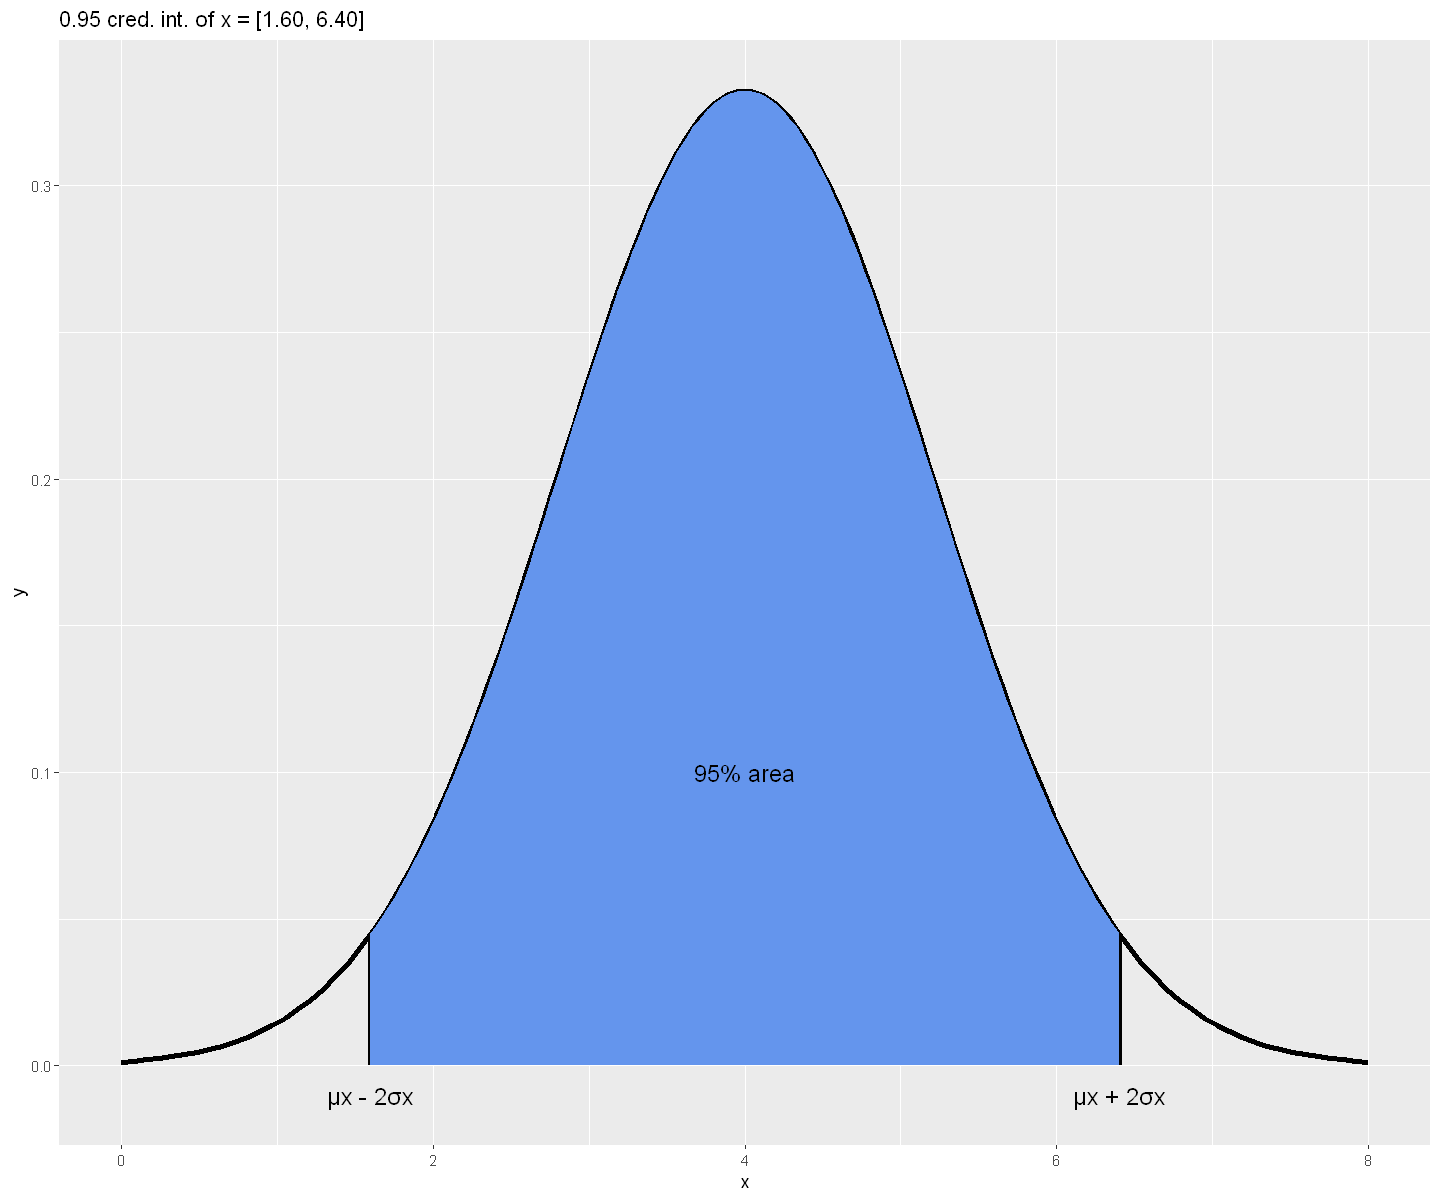

In [10]:
# marginal of x plot + 95% credibility interval

xx_marginal   <- seq(0, 8, length.out = 100)
sigma_x       <- sqrt(C[1, 1])
mu_x          <- mu[1]
marginal_x_df <- tibble(x = xx_marginal, y = dnorm(xx_marginal,
                        mean = mu_x, sd = sigma_x))
x1            <- mu_x - 2 * sigma_x
x2            <- mu_x + 2 * sigma_x
title_x       <- sprintf("0.95 cred. int. of x = [%.2f, %.2f]", x1, x2)

print(sprintf("μx ± 2σx = %.2f ± 2*%.2f = %.2f ± %.2f",
              mu_x, sigma_x, mu_x, 2 * sigma_x))
print(title_x)

ggplot(marginal_x_df, aes(x, y)) + geom_line(lwd = 1.5) + ggtitle(title_x) +
  annotate("segment", x = x1, xend = x1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2, xend = x2, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("text", x = x1, y = -0.01, label = "μx - 2σx", size = 5) +
  annotate("text", x = x2, y = -0.01, label = "μx + 2σx", size = 5) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x, sd = sigma_x),
                xlim = c(x1, x2),
                geom = "area",
                fill = "cornflowerblue") +
  annotate("text", x = mu_x, y = 0.1, label = "95% area", size = 5)

Notice that of course we could avoid using the $\mu\pm 2\sigma$ rule and integrate numerically the above curve, by fixing a symmetric interval centered around the mean (i.e. the max) and increasing it symmetrically until we reach $95\%$. We can easily conferm we would reobtain that interval for $x$:

In [11]:
cat(sprintf("area of x's marginal between %.2f and %.2f:", x1, x2))
integrate(\ (x) dnorm(x, mu_x, sigma_x), x1, x2)

area of x's marginal between 1.60 and 6.40:

0.9544997 with absolute error < 1.8e-11

[1] "μy ± 2σy = 2.00 ± 2*0.90 = 2.00 ± 1.80"
[1] "0.95 cred. int. of y = [0.20, 3.80]"


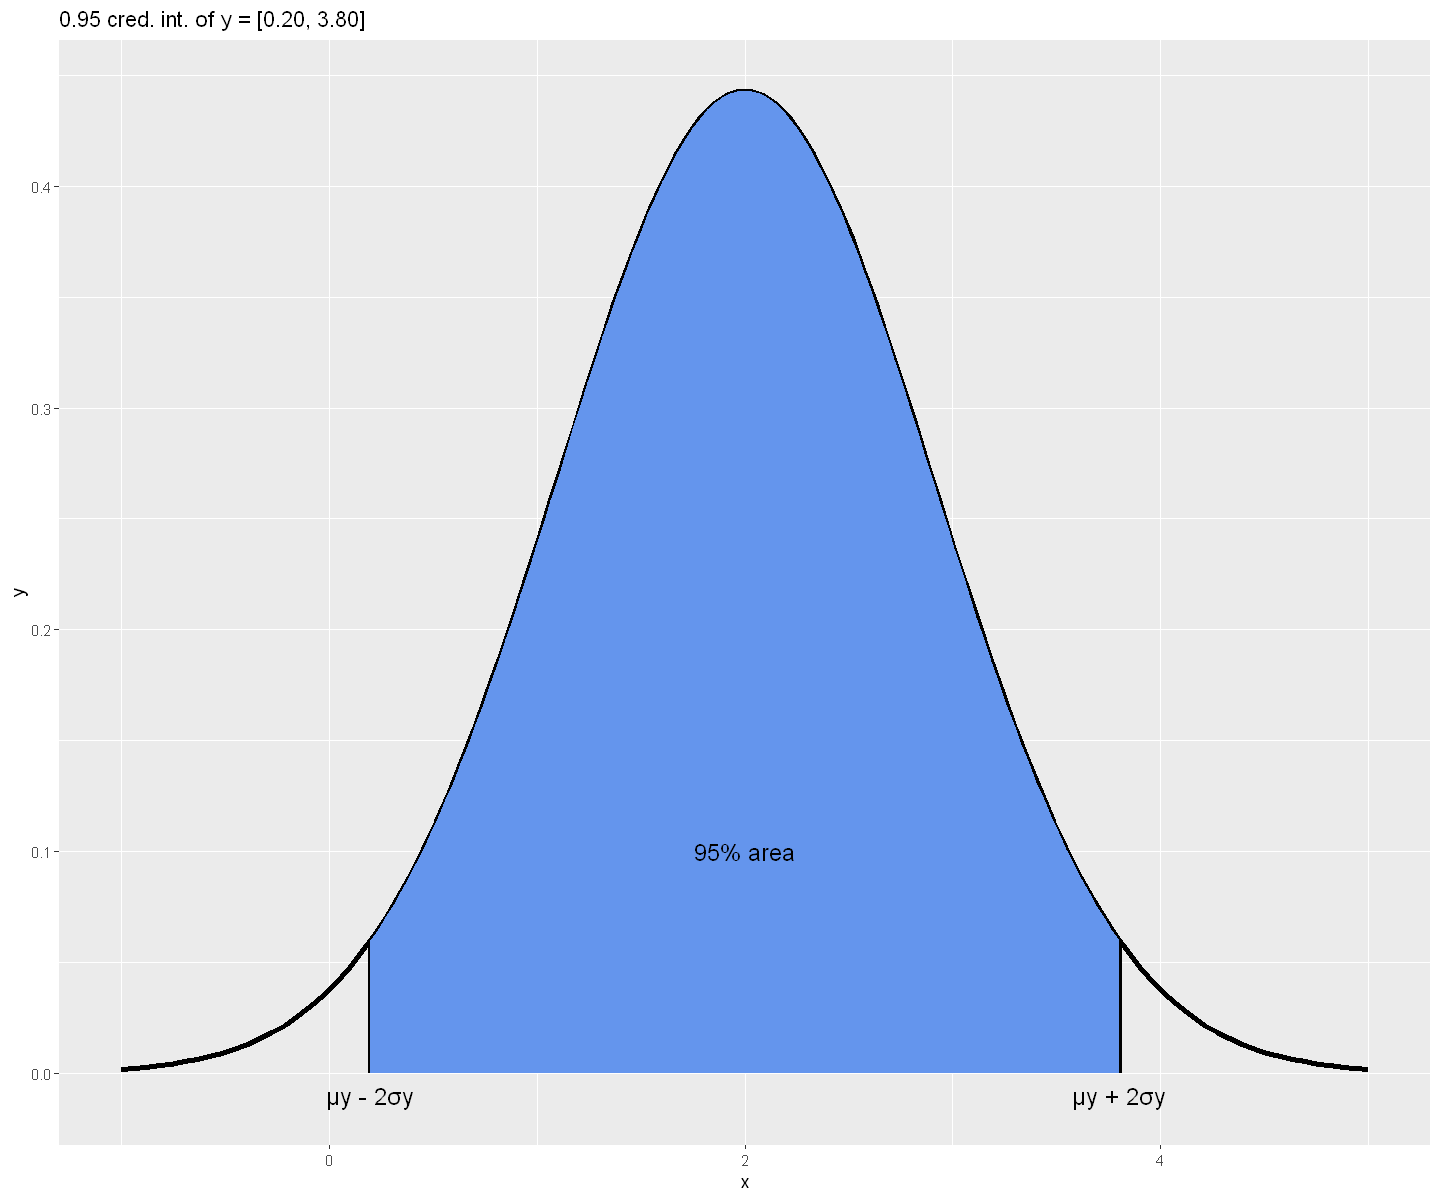

In [12]:
# marginal of y plot + 95% credibility interval

yy_marginal   <- seq(-1, 5, length.out = 100)
sigma_y       <- sqrt(C[2, 2])
mu_y          <- mu[2]
marginal_y_df <- tibble(x = yy_marginal, y = dnorm(yy_marginal,
                        mean = mu_y, sd = sigma_y))
y1            <- mu_y - 2 * sigma_y
y2            <- mu_y + 2 * sigma_y
title_y       <- sprintf("0.95 cred. int. of y = [%.2f, %.2f]", y1, y2)

print(sprintf("μy ± 2σy = %.2f ± 2*%.2f = %.2f ± %.2f",
              mu_y, sigma_y, mu_y, 2 * sigma_y))
print(title_y)

ggplot(marginal_y_df, aes(x, y)) + geom_line(lwd = 1.5) + ggtitle(title_y) +
  annotate("segment", x = y1, xend = y1, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2, xend = y2, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  annotate("text", x = y1, y = -0.01, label = "μy - 2σy", size = 5) +
  annotate("text", x = y2, y = -0.01, label = "μy + 2σy", size = 5) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y, sd = sigma_y),
                xlim = c(y1, y2),
                geom = "area",
                fill = "cornflowerblue") +
  annotate("text", x = mu_y, y = 0.1, label = "95% area", size = 5)

In [13]:
cat(sprintf("area of y's marginal between %.2f and %.2f:", y1, y2))
integrate(\ (y) dnorm(y, mu_y, sigma_y), y1, y2)

area of y's marginal between 0.20 and 3.80:

0.9544997 with absolute error < 1.8e-11

### Conditioning
Marginalizing essentially means ignoring all uninteresting variables, which means that marginalizing doesn't give us new information; that's why it intuitively makes sense that the 1D means/variances can be directly extracted from the overall mean and covariance matrix.

What if (in the context of a bayesian inference) we condition instead? Now we're bringing new information to the table, because we're specifying the exact value of one or more variables; we must therefore update our estimates of the remaining parameters.

To understand what happens when we condition let's start by plotting again the overall distribution in the case where e.g. we condition $y = 3$.

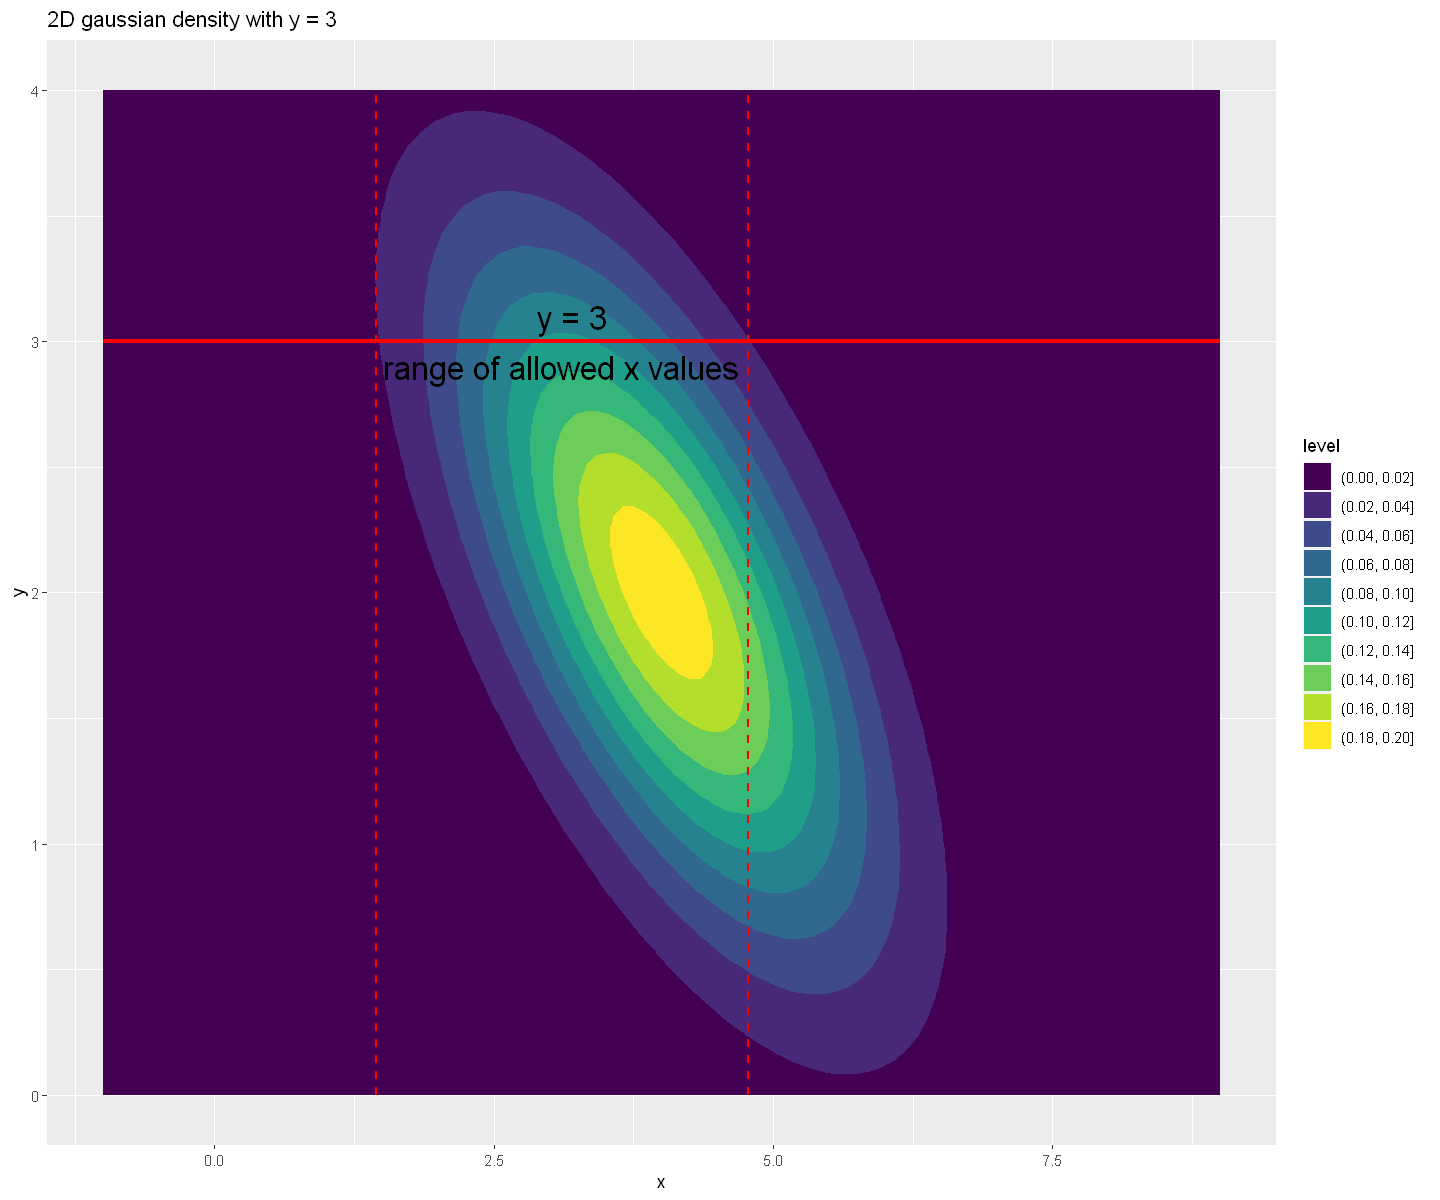

In [14]:
ggplot(exact_df, aes(x, y, z = z)) + geom_contour_filled() +
   ggtitle("2D gaussian density with y = 3") +
   annotate("segment", x = -1, xend = 9, y = 3, yend = 3,
            color = "red", lwd = 1.2) +
   annotate("text",  x = 3.2, y = 3.1,
            label = "y = 3", size = 7) +
   annotate("segment", x = 1.45, xend = 1.45, y = 0, yend = 4,
            color = "red", linetype = "dashed", lwd = 0.7) +
   annotate("segment", x = 4.78, xend = 4.78, y = 0, yend = 4,
            color = "red", linetype = "dashed", lwd = 0.7) +
   annotate("text", x = 3.1, y = 2.9,
            label = "range of allowed x values", size = 7)

As we can see in the above plot conditioning essentially means taking a slice of our distribution, because we are specifying that $y$ must be equal to $3$. This implies that not all the values of $x$ that were previously possible still are now; thanks to the new available information we can clearly see that $x$ must roughly lie in the $[1.45, 4.78]$ interval (dashed red lines above). This allows us to easily understand why when conditioning the resulting distribution is different w.r.t. marginalization: we need a new mean and variance to reflect the fact that the range of possible $x$ values has shrunk down - which is also why we intuitively expect smaller error bars when conditioning. 

Now let's plot the actual conditional distribution. It's possible to show that
\begin{equation*}
P(x|y = \hat{y}) = N\left(x|\mu' = \mu_1 - \frac{V_{12}}{V_{11}}(\hat{y} - \mu_2), \sigma'^2 = \frac{1}{V_{11}}\right)
\end{equation*}

\begin{equation*}
P(y|x = \hat{x}) = N\left(y|\mu' = \mu_2 - \frac{V_{21}}{V_{22}}(\hat{x} - \mu_1), \sigma'^2 = \frac{1}{V_{22}}\right)
\end{equation*}
where $V = C^{-1}$. This essentially means that the conditional distributions are still 1D gaussians, but with shifted means (as it must be looking at the previous plot) and smaller variances (as we'll see next).

Let's plot $P(x|y=3)$:

[1] "μx ± 2σx = 3.13 ± 2*0.91 = 3.13 ± 1.82"
[1] "0.95 cred. int. of (x|y = 3) = [1.31, 4.96]"

area of x's conditional (y = 3) between 1.31 and 4.96:

0.9544997 with absolute error < 1.8e-11

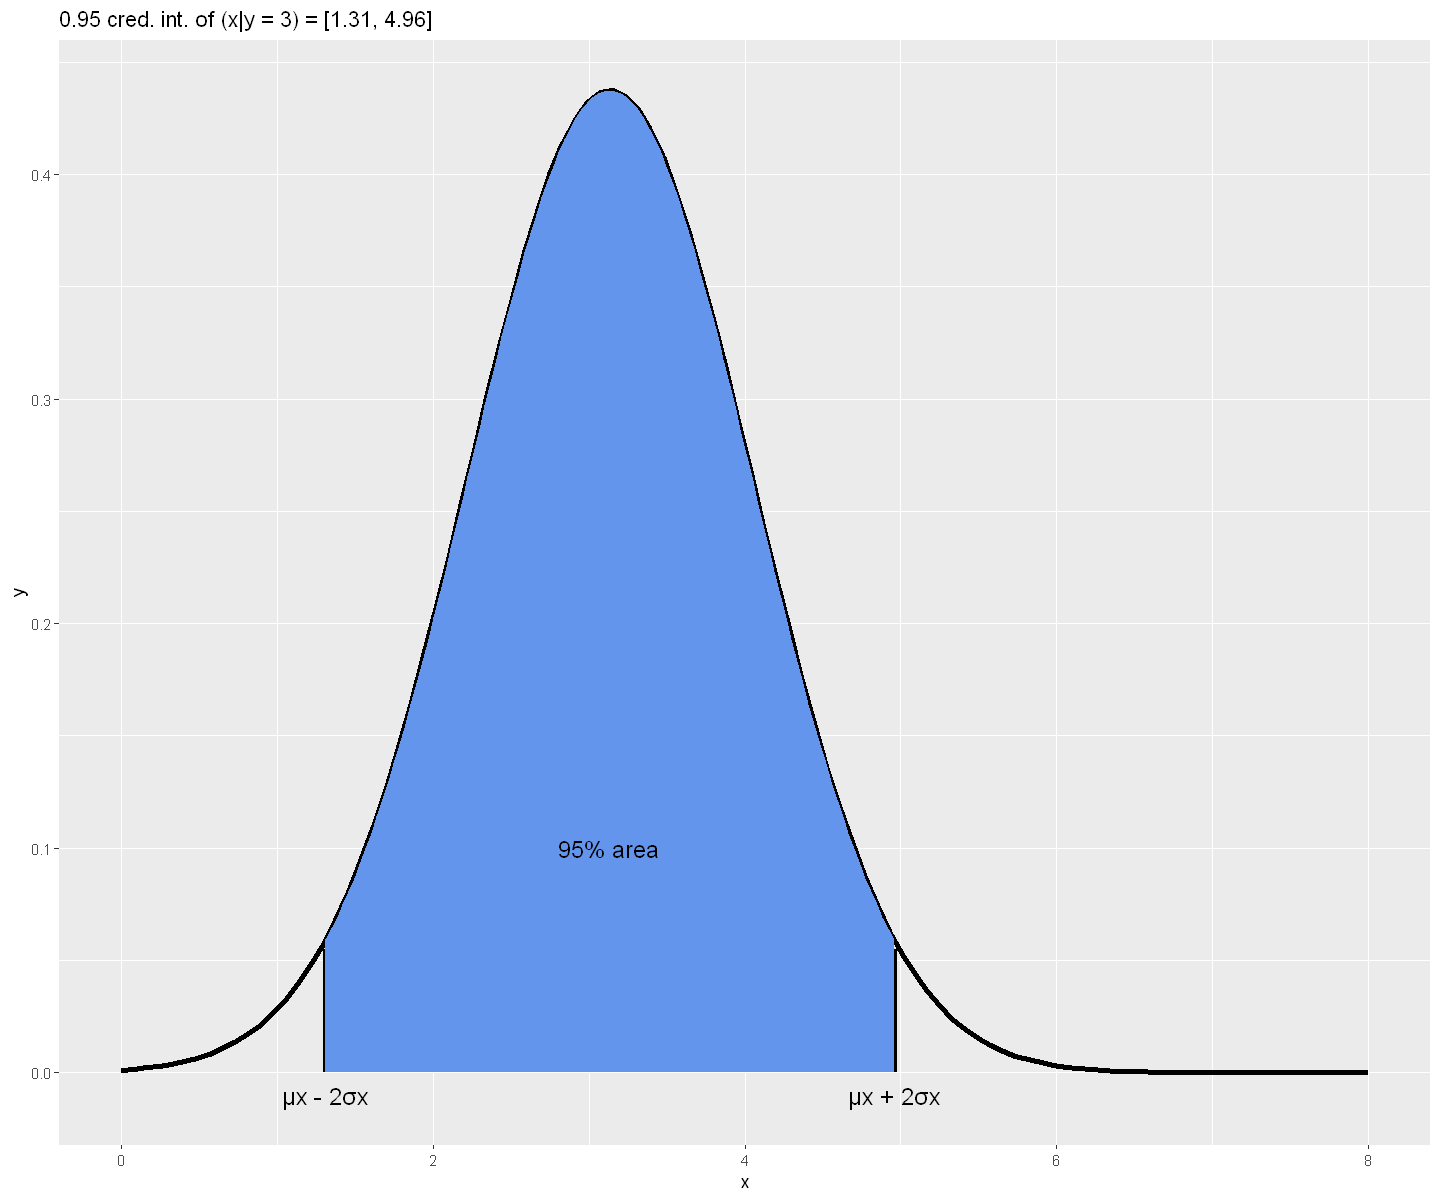

In [15]:
# conditional of x plot + 95% credibility interval
V <- C_inv; y_hat <- 3

xx_conditional      <- seq(0, 8, length.out = 100)
sigma_x_conditional <- sqrt(1 / V[1, 1])
mu_x_conditional    <- mu[1] - V[2, 1] / V[1, 1] * (y_hat - mu[2])
conditional_x_df    <- tibble(x = xx_conditional, y = dnorm(xx_conditional,
                        mean = mu_x_conditional, sd = sigma_x_conditional))
x1_cond             <- mu_x_conditional - 2 * sigma_x_conditional
x2_cond             <- mu_x_conditional + 2 * sigma_x_conditional
title_x_cond        <- sprintf("0.95 cred. int. of (x|y = 3) = [%.2f, %.2f]",
                               x1_cond, x2_cond)

print(sprintf("μx ± 2σx = %.2f ± 2*%.2f = %.2f ± %.2f",
              mu_x_conditional, sigma_x_conditional, mu_x_conditional,
              2 * sigma_x_conditional))
print(title_x_cond)

ggplot(conditional_x_df, aes(x, y)) +
  geom_line(lwd = 1.5) +
  ggtitle(title_x_cond) +
  annotate("segment", x = x1_cond, xend = x1_cond, y = 0, yend = 0.055,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2_cond, xend = x2_cond, y = 0, yend = 0.055,
           color = "black", lwd = 1.5) +
  annotate("text", x = x1_cond, y = -0.01, label = "μx - 2σx", size = 5) +
  annotate("text", x = x2_cond, y = -0.01, label = "μx + 2σx", size = 5) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x_conditional, sd = sigma_x_conditional),
                xlim = c(x1_cond, x2_cond),
                geom = "area",
                fill = "cornflowerblue") +
  annotate("text", x = mu_x_conditional, y = 0.1, label = "95% area", size = 5)

cat("\n")
cat(sprintf("area of x's conditional (y = 3) between %.2f and %.2f:", x1_cond, x2_cond))
integrate(\ (x) dnorm(x, mu_x_conditional, sigma_x_conditional), x1_cond, x2_cond)

We can now quantitatively confirm what we guessed before; in particular we notice the following results.

- The new mean is $3.13$, whereas the marginal's one was $4$. This is because the larger values of $x$ are no longer allowed, since the $y = 3$ red strip ends before reaching the end of the horizontal span of the original MVN. This can also be seen directly from the above graph, since the new gaussian is clearly shifted to the left compared to the marginal.
- The new error bars are smaller, since we now have a $95%$ credible interval whose half-length is $1.82$ (previously it was $2.4$). We can easily explain this in a bayesian way: when we marginalize the uncertainty over $y$ is propagated to $x$, but now there is no $y$ uncertainty to propagate to $x$ - hence the smaller error bars. This is consistent with the fact that $x$ and $y$ are correlated: "modifying" one should have some effect on the other.
We also note that these error bars could be made even smaller had we chosen a more "extreme" $\hat{y}$, i.e. a value of $y$ where the MVN is horizontally shorter - as this makes the "compatible" $x$ values even smaller in number. This has a nice interpretation under the light of information theory: a more "surprising" observation carries a lot more information, and is therefore able to decrease entropy (= leftover uncertainty) even more - leaving us with less uncertainty over $x$ i.e. less possible $x$ values.

Of course these new values for the mean and the std depend on the particular $\hat{y}$ at hand, as can be seen from the sliced 2D MVN and the equations for the conditional distributions; a nice interactive visualization where it's possible to modify $\hat{y}$ as well as $C$ can be found at [this link](https://distill.pub/2019/visual-exploration-gaussian-processes/).

Similarly we now plot what happens when we fix e.g. $x = 2.5$.

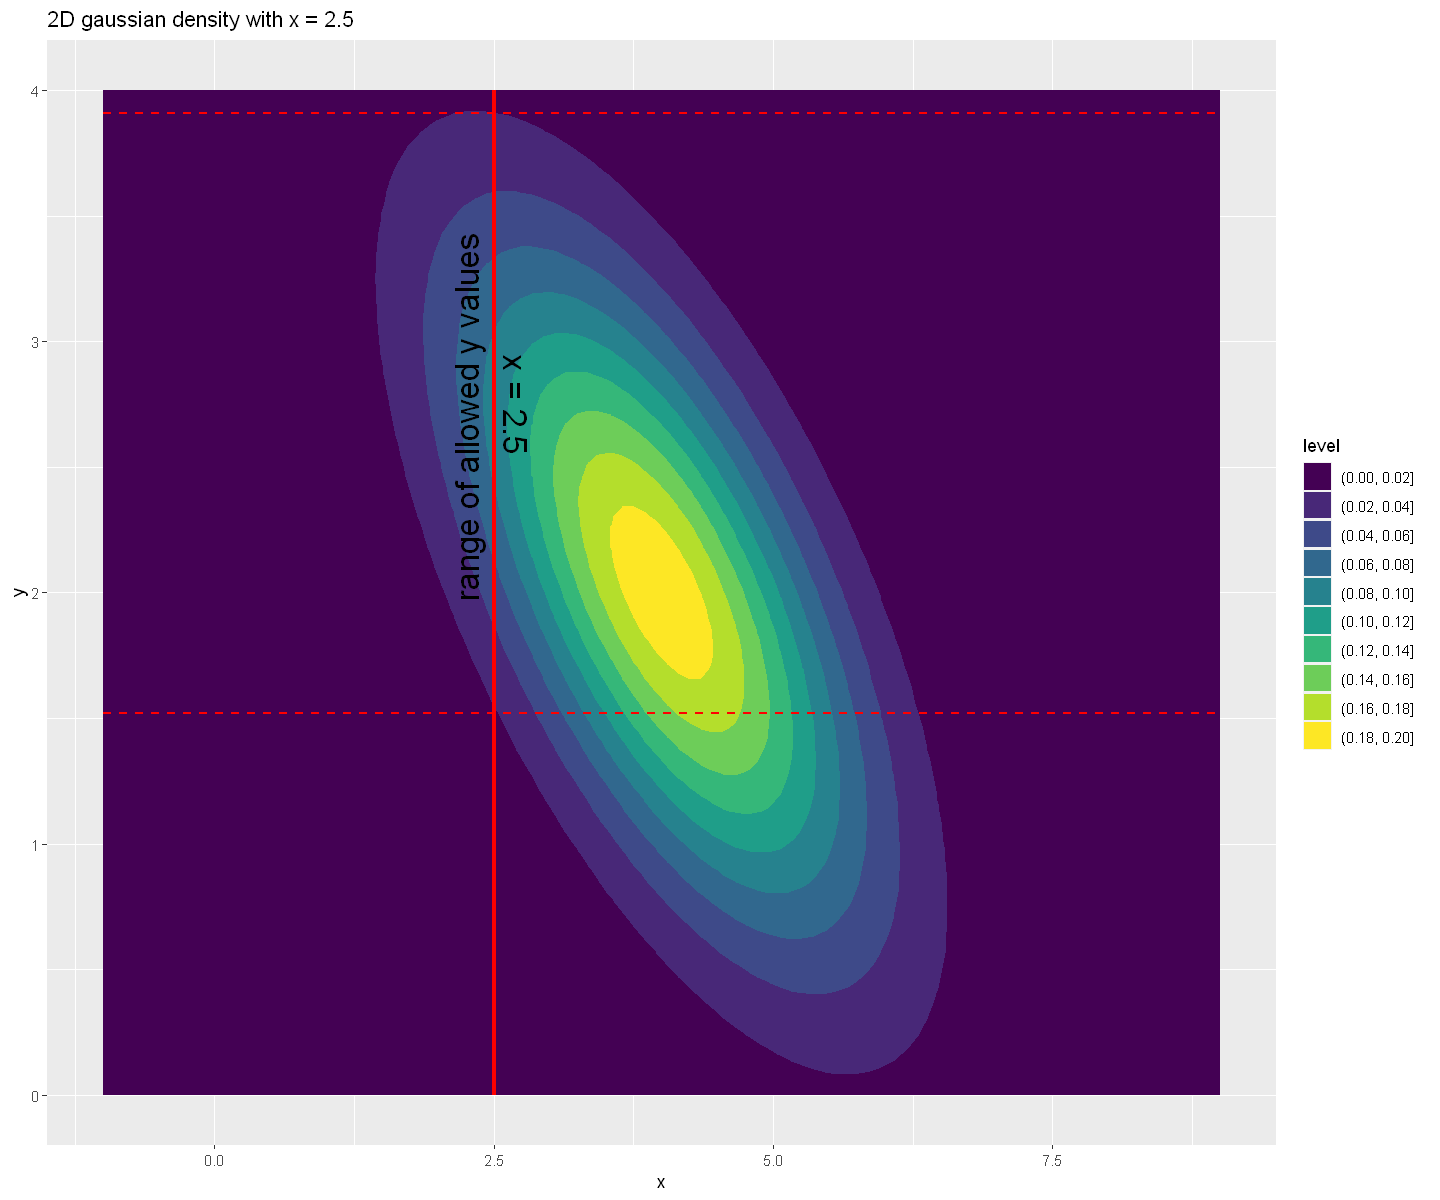

In [16]:
ggplot(exact_df, aes(x, y, z = z)) + geom_contour_filled() +
   ggtitle("2D gaussian density with x = 2.5") +
   annotate("segment", x = 2.5, xend = 2.5, y = 0, yend = 4,
            color = "red", lwd = 1.2) +
   annotate("text",  x = 2.7, y = 2.75,
            label = "x = 2.5", size = 7, angle = 270) +
   annotate("segment", x = -1, xend = 9, y = 1.52, yend = 1.52,
            color = "red", linetype = "dashed", lwd = 0.7) +
   annotate("segment", x = -1, xend = 9, y = 3.91, yend = 3.91,
            color = "red", linetype = "dashed", lwd = 0.7) +
   annotate("text", x = 2.25, y = 2.7,
            label = "range of allowed y values", size = 7, angle = 90)

[1] "μy ± 2σy = 2.73 ± 2*0.68 = 2.73 ± 1.37"
[1] "0.95 cred. int. of (y|x = 2.5) = [1.36, 4.10]"

area of y's conditional (x = 2.5) between 1.36 and 4.10:

0.9544997 with absolute error < 1.8e-11

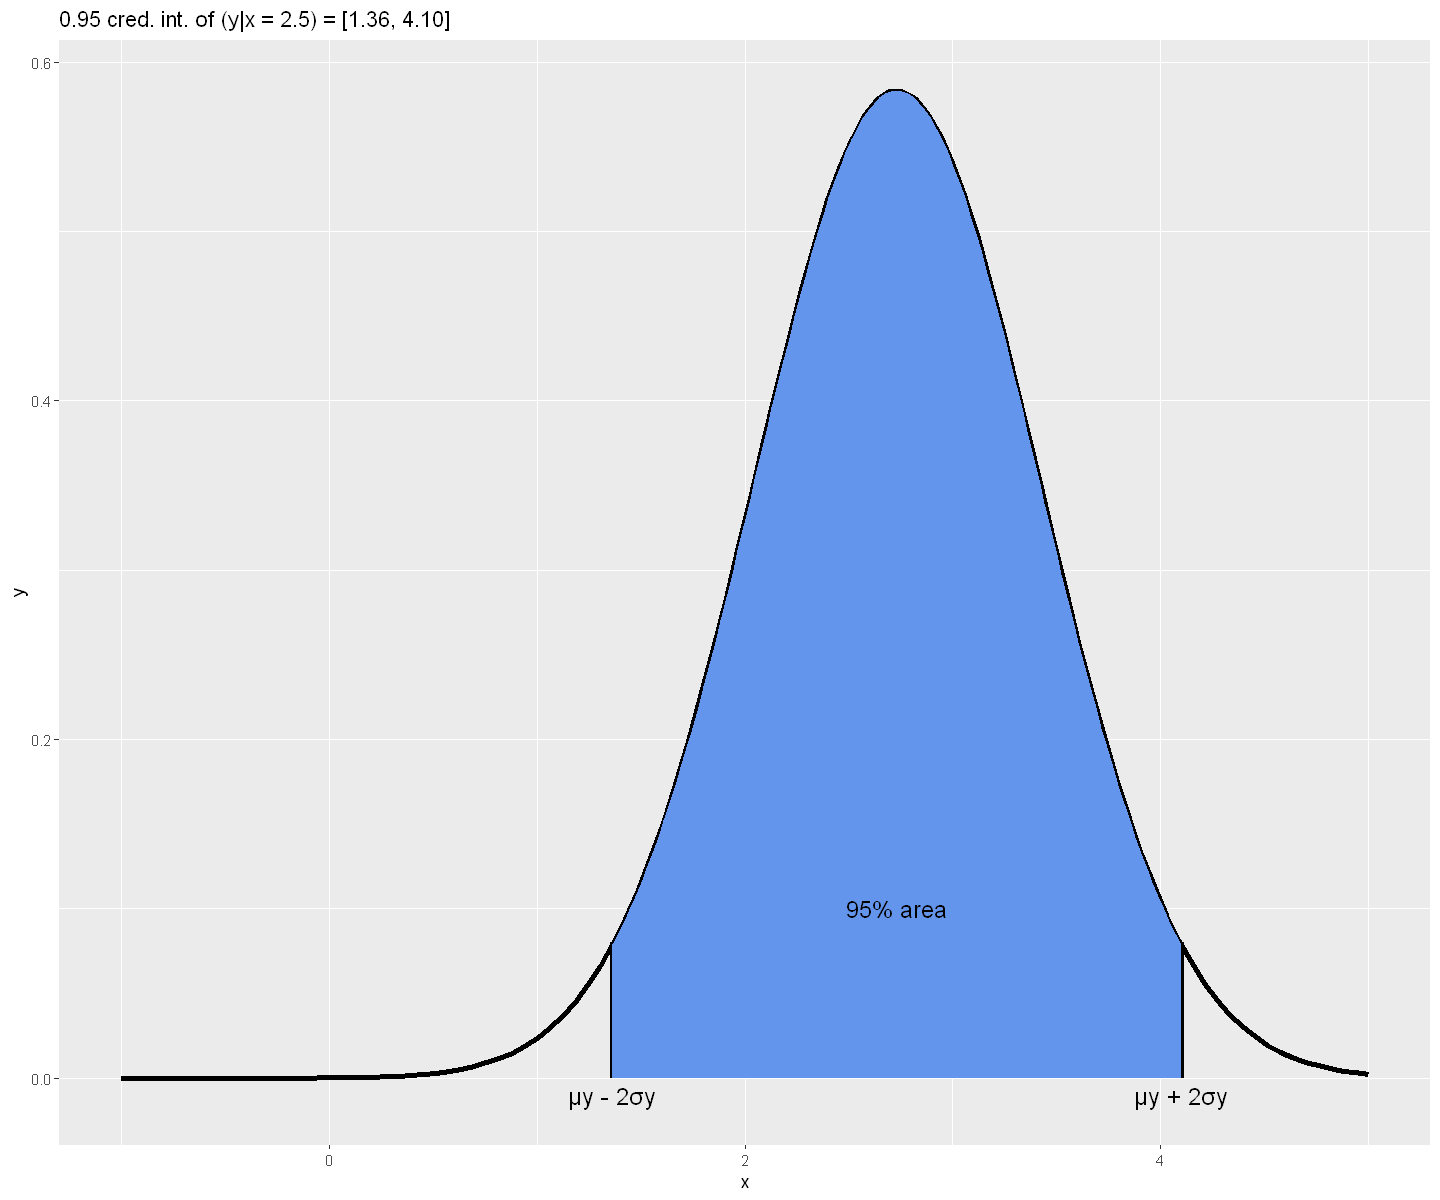

In [17]:
# conditional of y plot + 95% credibility interval
x_hat <- 2.5

yy_conditional      <- seq(-1, 5, length.out = 100)
sigma_y_conditional <- sqrt(1 / V[2, 2])
mu_y_conditional    <- mu[2] - V[2, 1] / V[ 2, 2] * (x_hat - mu[1])
conditional_y_df    <- tibble(x = yy_conditional, y = dnorm(yy_conditional,
                        mean = mu_y_conditional, sd = sigma_y_conditional))
y1_cond             <- mu_y_conditional - 2 * sigma_y_conditional
y2_cond             <- mu_y_conditional + 2 * sigma_y_conditional
title_y_cond        <- sprintf("0.95 cred. int. of (y|x = 2.5) = [%.2f, %.2f]", y1_cond, y2_cond)

print(sprintf("μy ± 2σy = %.2f ± 2*%.2f = %.2f ± %.2f",
              mu_y_conditional, sigma_y_conditional, mu_y_conditional, 2 * sigma_y_conditional))
print(title_y_cond)

ggplot(conditional_y_df, aes(x, y)) +
  geom_line(lwd = 1.5) +
  ggtitle(title_y_cond) +
  annotate("segment", x = y1_cond, xend = y1_cond, y = 0, yend = 0.08,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2_cond, xend = y2_cond, y = 0, yend = 0.08,
           color = "black", lwd = 1.5) +
  annotate("text", x = y1_cond, y = -0.01, label = "μy - 2σy", size = 5) +
  annotate("text", x = y2_cond, y = -0.01, label = "μy + 2σy", size = 5) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y_conditional, sd = sigma_y_conditional),
                xlim = c(y1_cond, y2_cond),
                geom = "area",
                fill = "cornflowerblue") +
  annotate("text", x = mu_y_conditional, y = 0.1, label = "95% area", size = 5)

cat("\n")
cat(sprintf("area of y's conditional (x = 2.5) between %.2f and %.2f:", y1_cond, y2_cond))
integrate(\ (y) dnorm(y, mu_y_conditional, sigma_y_conditional), y1_cond, y2_cond)

Once again we notice a horizontal shift to the right since the smaller $y$ values have to be cut off (the mean increases from $2$ to $2.73$) and smaller error bars (its half length decreases from $1.8$ to $1.37$) since we have less uncertainty over $x$/less possible $x$ values.

# Sampling data from the 2D MVN
The plots and computations done above all exploit the fact that our distribution can be treated analytically; this of course rarely happens in practice. We must therefore find new ways to e.g. compute credibility intervals when instead of exact formulae we only have experimental/simulated data. Below we will deal with simulated data, using three different sampling techniques; once the data has been obtained, though, all techniques used to marginalize etc. will be the same as if the data had been obtained experimentally - hence they are quite general.

# Cholesky decomposition sampling
## Introduction
The *Cholesky decomposition* of a symmetric, positive definite matrix $C$ is the unique lower triangular matrix $L$ with the property that
\begin{equation}
C = L L ^T
\end{equation}
(some texts adopt a different convention by switching $L$ and $L^T$; `R` itself actually does this, but we'll stick to the above convention nonetheless).
For the purposes of this notebook it suffices to say that the Cholesky decomposition of a covariance matrix can be efficiently computed using built-in numerical techniques (the `chol` function in `R`).

This decomposition is interesting because it gives us an efficient technique to directly and exactly sample from a MVN distribution - once again this is a very special case, a MCMC algorithm is more general but also more "indirect", tricky to apply and complex; to develop the Cholesky based sampling algorithm we need a few results. 

First notice that it's possible to show that *affine transformations preserve gaussianity*, i.e. if $\mathbf{u}$ is a random vector sampled from a MVN then $ \mathbf{n} = A\mathbf{u}+\mathbf{b}$ (with $A$ and $\mathbf{b}$ a constant matrix and vector respectively) is still a normally distributed vector, albeit with different mean and covariance. The idea behind this algorithm is to choose $A$ and $\mathbf{b}$ is such a way as to obtain vectors sampled to the desired MVN by transforming vectors easily sampled from a more basic one. Let's get into the details.

Let's say that $\mathbf{u} \sim N(\mathbf{0}, I)$ - where $\mathbf{0}$ is a vector of $n$ zeros and $I$ is the $n\times n $ identity matrix. Notice that this kind of vector is easily sampled with any software: since $I$ is diagonal the components of $\mathbf{u}$ are uncorrelated, hence to obtain them it suffices to sample $n$ times from a 1D normal with 0 mean and variance 1 - which is easily done using built in functions or a variety of readily implemented techniques (e.g. rejection sampling, inverse cdf sampling). It is therefore clear that $\mathbf{u}$ can be cheaply sampled; we now show that if $A = L$ (i.e. $A$ is the Cholesky dec. of the desired covariance) and $\mathbf{b} = \mu$ (i.e. $\mathbf{b}$ is the desired mean) then $L\mathbf{u}+\mu$ will indeed be sampled from $N(\mu, C)$.

Since $L$ is a constant matrix we clearly have that 
\begin{equation}
\langle L\mathbf{u} \rangle = L \langle \mathbf{u} \rangle = L \langle \mathbf{0} \rangle = \mathbf{0}
\end{equation}
Since $\mu$ is a constant vector we obtain
\begin{equation}
\langle L \mathbf{u} + \mu \rangle = L\langle \mathbf{u} \rangle + \mu = \mathbf{0} + \mu = \mu
\end{equation}
This means that $L\mathbf{u}+\mu$ has the correct mean, the desired $\mu$ vector; let us now check the covariance.

In general given a random variable $\mathbf{x}$ with mean $\mu_x$ one has:
\begin{equation}
\text{Cov}(\mathbf{x}) = \langle (\mathbf{x} - \mu_x) (\mathbf{x} - \mu_x)^T \rangle
\end{equation}
In our case $\mathbf{x} = L\mathbf{u} + \mu$ and $\mu_x = \mu$, so $\mathbf{x} - \mu_x = L\mathbf{u} + \mu - \mu = L\mathbf{u}$, which implies:
\begin{equation}
\text{Cov}(L\mathbf{u} + \mu) = \langle (L\mathbf{u}) (L\mathbf{u})^T \rangle = \langle L \mathbf{u} \mathbf{u}^T L^T \rangle = L \langle \mathbf{u} \mathbf{u}^T \rangle  L^T
\end{equation}
where in the last step we used again the fact that $L$ is a constant matrix. Now notice that since $\langle \mathbf{u} \rangle = \mathbf{0}$ the quantity $\langle \mathbf{u} \mathbf{u}^T \rangle$ is simply the covariance of $\mathbf{u}$, which is $I$; this means that
\begin{equation}
\text{Cov}(L\mathbf{u} + \mu) = L I L^T = L L^T = C
\end{equation}
where in the last step we used the fact that $L$ is the Cholesky decomposition of $C$; we thus obtained that $L\mathbf{u}+\mu$ has the desired covariance, too.

Thanks to the above we now know a simple way to sample exactly and directly from any MVN with mean $\mu$ and covariance $C$:
- first sample $\mathbf{u} \sim N(\mathbf{0}, I)$ by sampling from $N(0, 1)$ $n$ times;
- then compute $L\mathbf{u}+\mu$, where $L$ is the Cholesky dec. of $C$; the result will be distributed according to $N(\mu, C)$.

The above algorithm easily generalizes to the case of sampling an arbitrary number of times from the desired MVN without loops: if we have many vectors $\mathbf{u}_1, \mathbf{u}_2, \mathbf{u}_3, \dots \sim N(\mathbf{0}, I)$ we can simply stack them horizontally in a matrix $U$; due to the rule of matrix product the columns of $LU$ will be $L\mathbf{u}_1, L\mathbf{u}_2, L\mathbf{u}_3, \dots \sim N(\mathbf{0}, C)$; by then summing a matrix whose columns are all equal to $\mu$ (trivially achieved using `numpy`'s broadcasting, `R`'s recycling, etc.) we obtain our set of vectors sampled from $N(\mu, C)$. 

In [18]:
chol_cov <- chol(C) |> t() # R's convention is the opposite of ours

# function specific to the 2D case & without any explicit check
# for needed properties (C is sym., etc.)
# Also a momre general function would compute the chol. dec.
# "on the fly", but since we only have one cov. matrix
# the chol. dec. never changes and therefore it's more
# efficient to have it as a fixed input.

rmvn <- function(n, mean = mu, L = chol_cov) {
    U <- rnorm(n * 2, mean = 0, sd = 1) |> matrix(nrow = 2)
    return(t(L %*% U + mean))
} # U matrix: each col. is a 2D vector sampled from N([0, 0], I_2)
# then we perform the affine transformation and transpose, so that
# each row of the output is a 2D observation (i.e. a point from
# the target MVN)

# example:
set.seed(1234)
rmvn(7, mu, chol_cov)
# we'll verify below that this is actually sampled from the
# desired distribution.

2.551521,2.8958786
5.301329,-0.2387164
4.514950,2.0950743
3.310312,1.9623591
3.322658,1.7214712
3.427369,1.5963205
3.068495,2.4981945


Now that we can sample points from our MVN using the Cholesky dec. algorithm let us create and analyze a dataset; we start by computing the "experimental" mean (therefore this time using the sum instead of the exact integral), covariance (once again using the discrete formulae) and by graphing the contour plot.

In [19]:
set.seed(1234)

n_samples_cholesky <- 1e5 # 100,000 samples should suffice

cholesky_df        <- as_tibble(rmvn(n_samples_cholesky),
                                .name_repair = "minimal")
names(cholesky_df) <- c("x", "y")

mean_cholesky <- cholesky_df |> summarize(x = mean(x), y = mean(y))
mu_cholesky   <- unlist(mean_cholesky)

mean_cholesky

x,y
<dbl>,<dbl>
4.007444,1.996326


We notice that the mean computed from the "experimental" dataset is very close to the theoretical result ($[4, 2]$), which means that the Cholesky algorithm is working as intended.

Now let us compute the covariance:

In [20]:
cov_cholesky_df <- cov(cholesky_df)
cov_cholesky_df

,x,y
x,1.4368845,-0.7016972
y,-0.7016972,0.8064185


As for the mean the covariance is also very close to its theoretical counterpart:

In [21]:
cov_exact <- C
colnames(cov_exact) <- c("x", "y")
rownames(cov_exact) <- c("x", "y")
cov_exact

,x,y
x,1.440,-0.702
y,-0.702,0.810


Once again this means that the Cholesky based sampling algorithm is working as intended.

Let us now produce the contour plot.

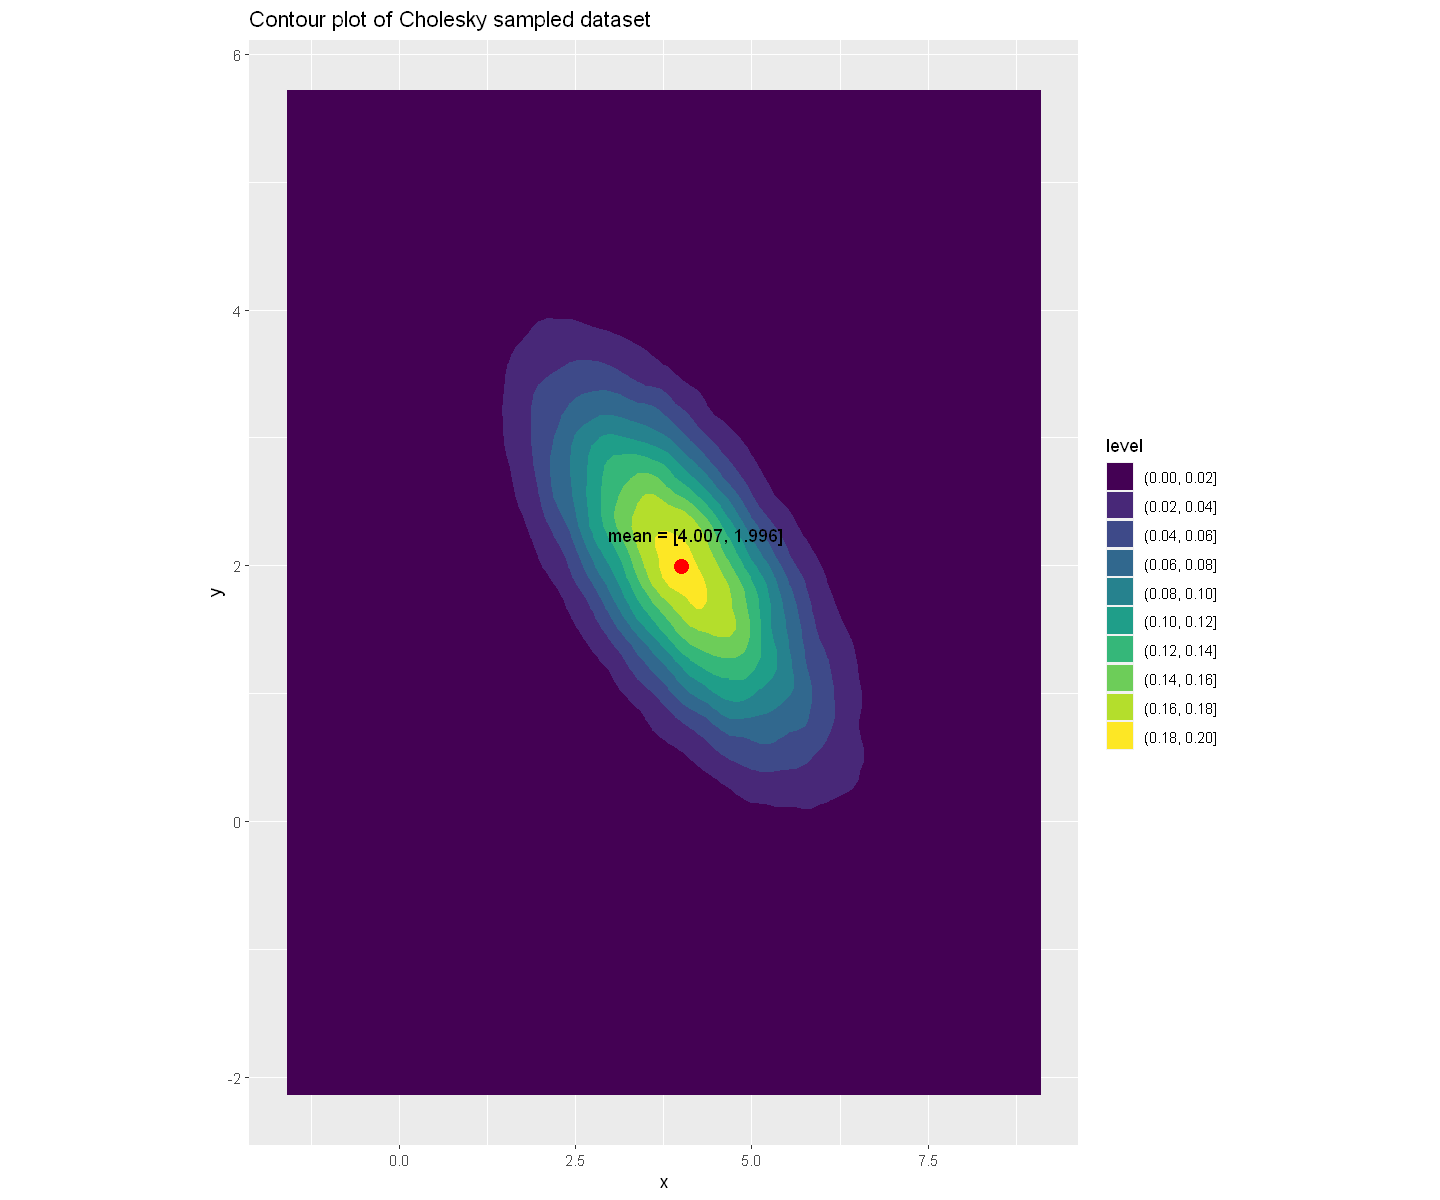

In [22]:
ggplot(cholesky_df, aes(x = x, y = y)) + geom_density_2d_filled() +
  ggtitle("Contour plot of Cholesky sampled dataset") +
  annotate("point", x = mu_cholesky[1], y = mu_cholesky[2],
           color = "red", size = 4) +
  annotate("text",  x = mu_cholesky[1] + 0.2, y = mu_cholesky[2] + 0.25,
           label = sprintf("mean = [%.3f, %.3f]",
           mu_cholesky[1], mu_cholesky[2])) +
  theme(aspect.ratio = 4/3)

There is a clear resemblance with the original contour plot - except for the fact that lines are a bit "ondulating", clearly a consequence of the limited size of the dataset.

A better way to observe and appreciate this resemblance is to overlay a scatter plot of the dataset on top of the original contour plot, instead of estimating and plotting the 2D density.
Notice that for clarity this time the contour plot will not be filled; apart from this it's exactly the same.

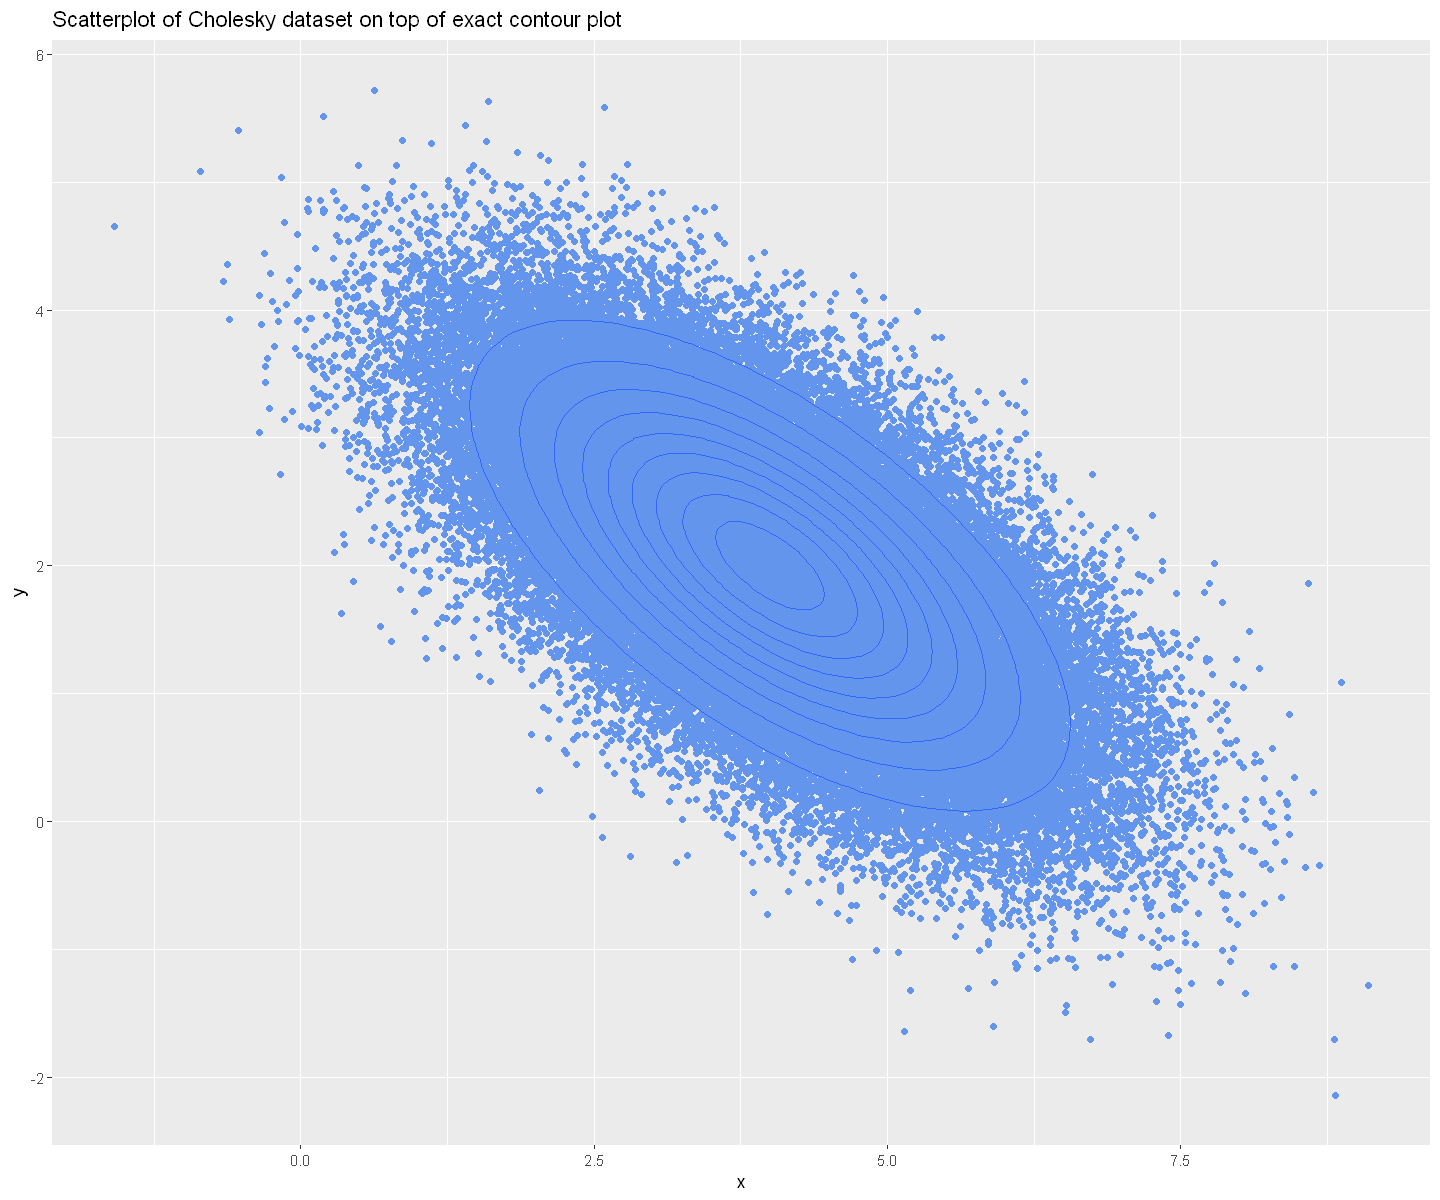

In [23]:
ggplot() +
  geom_point(data = cholesky_df, mapping = aes(x, y),
             color = "cornflowerblue") +
  geom_contour(data = exact_df, mapping = aes(x, y, z = z)) +
  ggtitle("Scatterplot of Cholesky dataset on top of exact contour plot")

Using techniques like 2D kernel density estimation one could interpolate an approximation of the posterior starting from data sampled from the posterior itself (as we said is the aim of sampling-based inferences), but we only really care about reobtaining the 1D boundaries; for this reason we're not going to expand on its uses.

Having said the above let us show a simple and interesting application of 2d kde.
We remark that the previous contour plot - while standard - is hard to interpret. Indeed what's shown in the plots are contours generated by taking horizontal slices of the 3d surface and projecting the intersections on the plane; for this reason we only get a general feel for the distribution shape and where the density is high. In order to reach a quantitative visual understanding of the distribution a more interpretable plot can be obtained by plotting *highest density regions* (HDRs), i.e. the smallest regions whose probabilities equal to a set of predefined values.

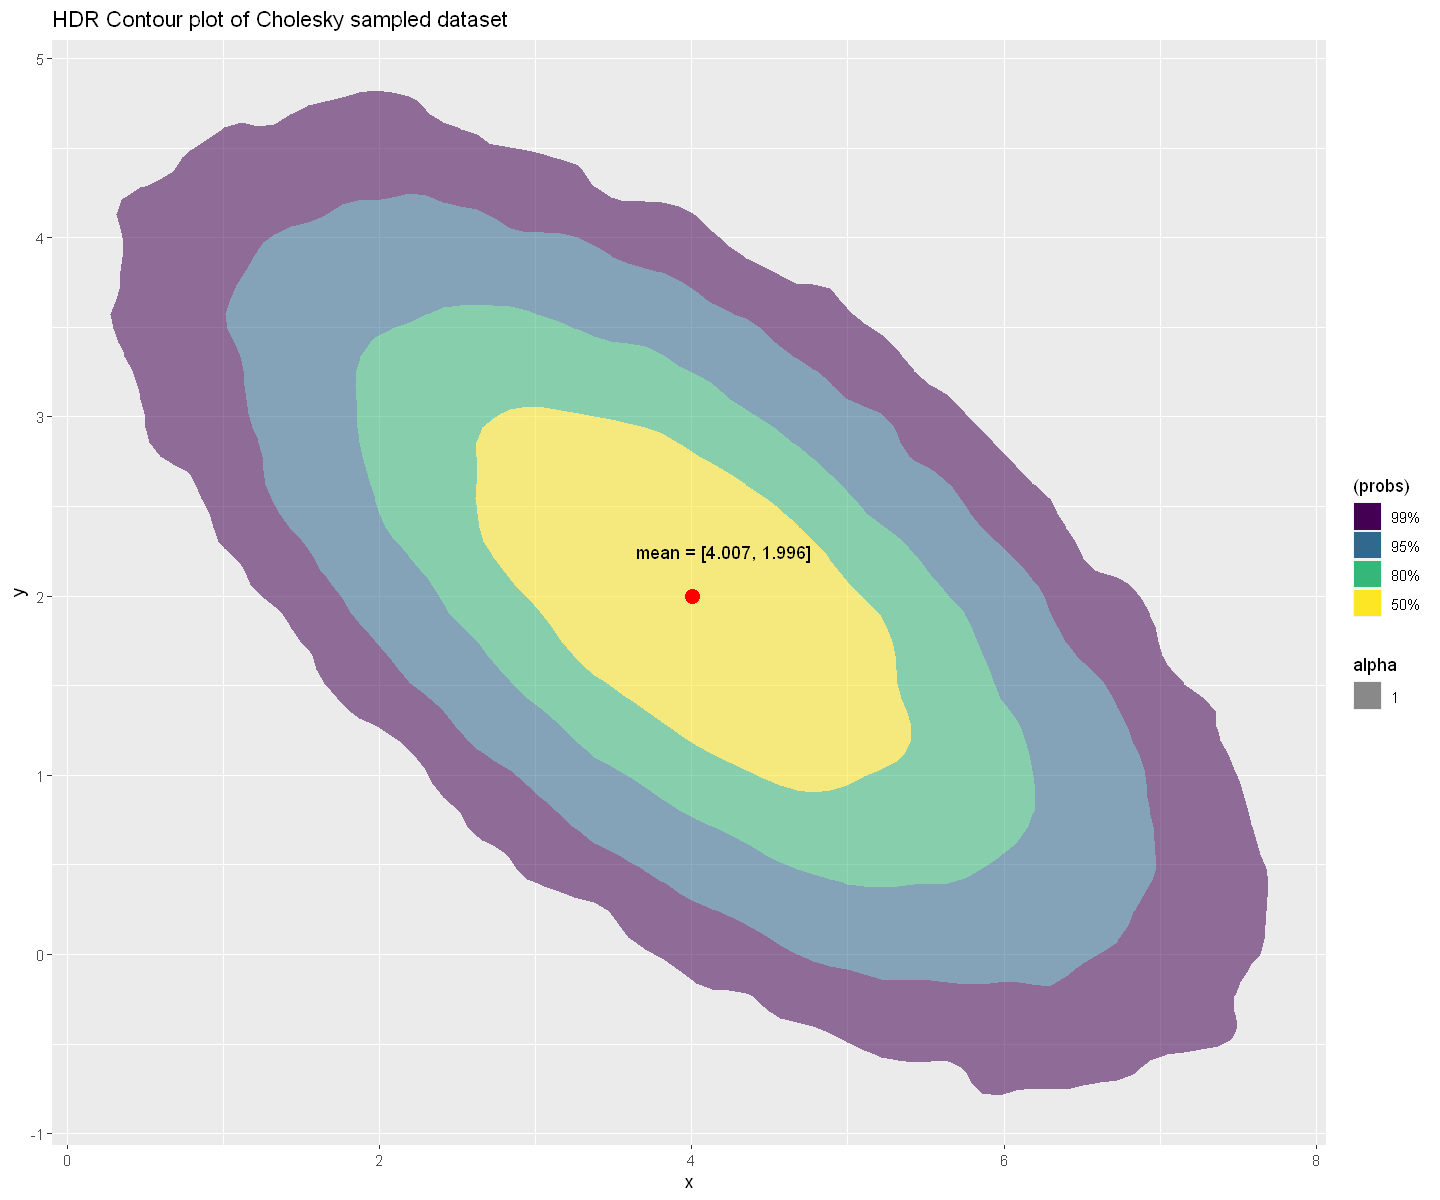

In [24]:
ggplot(cholesky_df, aes(x = x, y = y)) +
  ggdensity::geom_hdr(aes(fill = after_stat((probs)), alpha = 1)) +
  ggtitle("HDR Contour plot of Cholesky sampled dataset") +
  annotate("point", x = mu_cholesky[1], y = mu_cholesky[2],
           color = "red", size = 4) +
  annotate("text",  x = mu_cholesky[1] + 0.2, y = mu_cholesky[2] + 0.25,
           label = sprintf("mean = [%.3f, %.3f]",
           mu_cholesky[1], mu_cholesky[2]))

As said above we're not going to systematically use 2d kde since it goes outside the scope of this notebook, and we won't apply even simple applications as in the above cell later on to speed up computation time.

## Marginalization with Cholesky generated dataset
When dealing with analytically tractable distribution in order to marginalize one has to perform a sum/integral; what do we do when we only have "experimental" data? As we know marginalizing essentially means ignoring uninteresting variables; since this time we don't need to compute the 1D distributions (i.e. exact probabilities) beforehand we don't need to know how the uncertainty propagates, hence it suffices to literally ignore one variable.

In practice in our case this means discarding either the $x$ or $y$ component of the points in our simulated dataset, which geometrically corresponds to projecting on the $y$/$x$ axis respectively. Once we perform such a projection we can easily plot 1D histograms and use them to compute interesting quantities (means, boundaries) or to interpolate the marginals (e.g. via 1D kde).

This is done in the next graph.

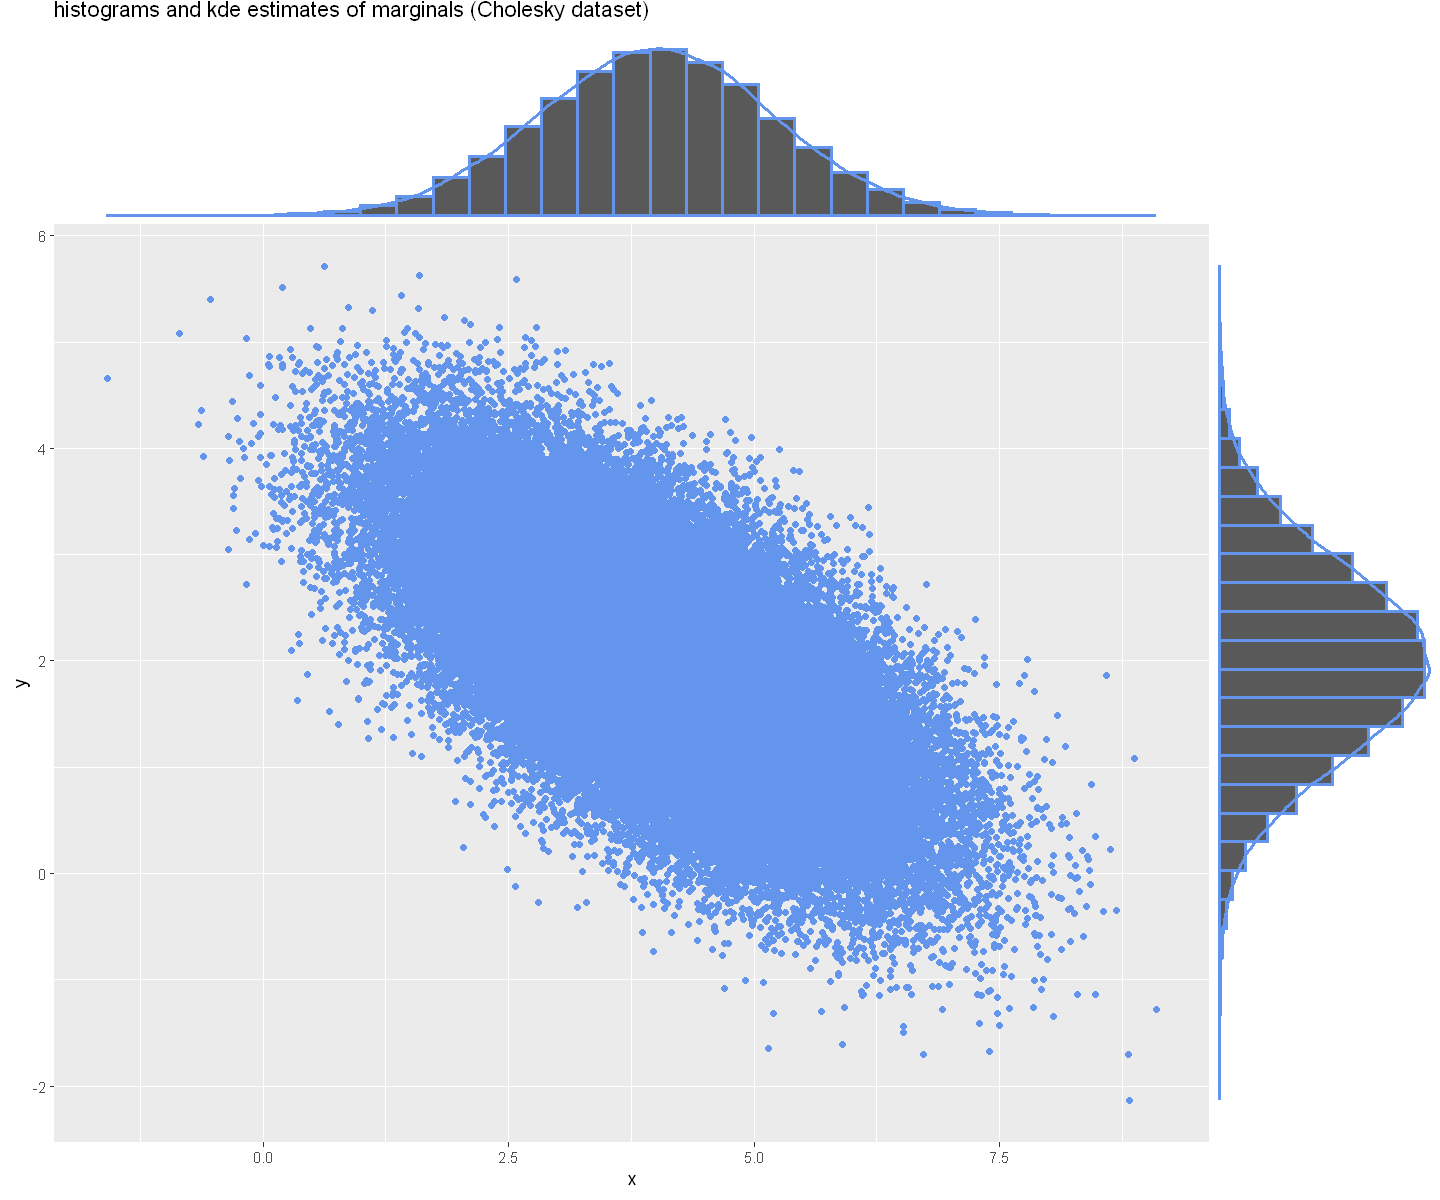

In [25]:
ggExtra::ggMarginal(ggplot(cholesky_df, aes(x, y)) +
                    geom_point(color = "cornflowerblue") +
                    ggtitle("histograms and kde estimates of marginals (Cholesky dataset)"),
                    type = "densigram", color = "cornflowerblue", lwd = 1)

### $x$ Cholesky marginal
Let us now be more precise: let's plot the normalized $x$ histogram separately, so that we can also plot the kde and compare it to the theoretical distribution.

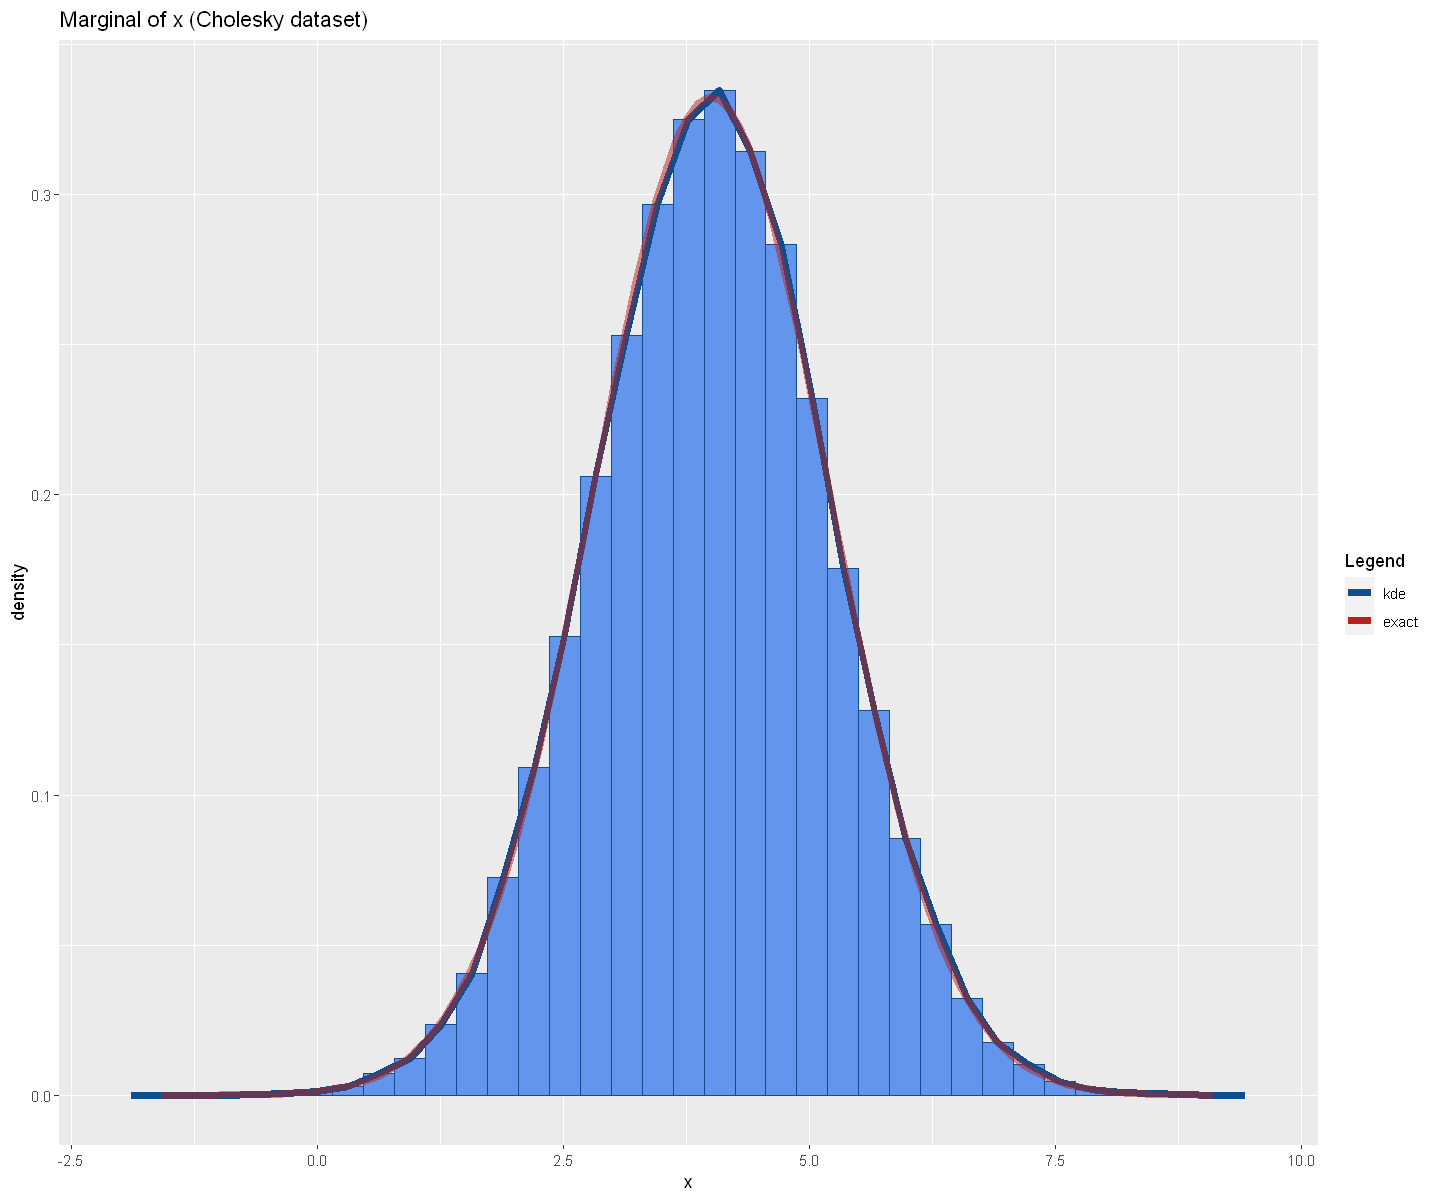

In [26]:
ggplot(cholesky_df) +
  geom_histogram(aes(x = x, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = x, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_x, sd = sigma_x),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle("Marginal of x (Cholesky dataset)") +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

We notice that the theoretical marginal distribution (dark blue line) and the one interpolated from the Cholesky-based histogram overlap almost perfectly. To make this statement more quantitative we can compute the Kullback-Leibler divergence between the exact marginal distribution and the one inferred via kde as follows.

In [27]:
kld_sampled_exact_distribution <- function(sampled_dataset_1d, exact_mean, exact_sd) {
    kde_density     <- density(sampled_dataset_1d)
    exact_density_y <- dnorm(kde_density$x, mean = exact_mean, sd = exact_sd)
    return(LaplacesDemon::KLD(exact_density_y, kde_density$y)$mean.sum.KLD)
}
# We return the mean between KLD(1,2) and KLD(2,1)
# as the KL div. is NOT symmetric

print("Mean KLD between Cholesky & exact x marginal:")
print(kld_sampled_exact_distribution(cholesky_df$x, mu_x, sigma_x))

[1] "Mean KLD between Cholesky & exact x marginal:"
[1] 0.0001666513


This "distance" between distribution is very close to zero, which means the two distributions are almost identical. Of course one may ask "is it actually small enough for us to be able to draw this conclusion?"; to better answer this question some bits from information theory may be needed. In particular we may compute the mutual information between the two distribution and compare it with the intrinsic iniformation (i.e. entropy) of one or the other; the ratio between these two number will be the fraction of information contained in one or the other that is also shared between them. Based on the negligible KLD obtained above we expect this ratio to be close to $99%$, but as this goes far beyond the scope of this notebook we're content with a semi-quantitative observation.

Another way to compare these distributions would be to use some sort of summary statistics; for example we know that for perfectly normal 1D distributions all the information can be incapsulated in two numbers (mean and standard deviation); our kde distribution is not, though, so this is only an approximation - and yet a useful one. This is actually what we did above to perform a sanity check that Cholesky sampling worked correctly, so there's no need to repeat it here.

#### Cholesky $95\%$ credibility interval for $x$
##### Estimate via histograms
Now let's consider the problem of computing the $95\%$ credibility interval for $x$ using the Cholesky dataset. Since this time we don't have an exact form for the density we must find a way to compute the area under an *estimate* of the probability density obtained from our dataset. 

One way to achieve this is by using the fact that a histogram is the discretized version of the asymptotic density, which it converges to in the limit of infinite samples; since this is true we can estimate areas simply by summing the areas of the rectangles associated to points with $x$ in the desired interval. Notice that since these rectangles all share the same base length we can make our code simpler using the following reasoning.

The unnormalized area of a single rectangle is clearly $n \Delta x$, where $\Delta x$ is the same for all rectangles; this means that the area of each rectangle is proportional to the number of points in that bin. This implies that the sum of areas of rectangles in a certain range is proportional to the sum of numbers of points in each bin, i.e. to the total number of point in the whole region; hence the normalized area (i.e. fraction of the overall area) equal to 0.95 is simply the ratio of the number of points within the 95% credibility interval and the total number of points.
\begin{equation}
A_{\text{normalized}} = \frac{A_{95\%}}{A_{\text{tot}}} = \frac{n_{95\%}}{n_{\text{tot}}}
\end{equation}
To reach this conclusion quicker we could also simply say that $A \propto n \implies A_i/A_{\text{tot}} = n_i/n_{\text{tot}}$. This is intuitive, since as we now the normalized histogram approaches the true density in the $n\to + \infty$ limit.

Therefore we proceed as follows: we look for a symmetric interval around the max (which may not be exactly equal to the mean) such that the number of points inside it is 95% of the total.

In [28]:
# we estimate the max using kde
max_cholesky_x <- density(cholesky_df$x, n = 1024)$x[which.max(density(cholesky_df$x, n = 1024)$y)]

# since the distribution is approximately gaussian we expect that
# the mean ± 2 sigma rule should still be approximately valid;
# this gives us a simple starting point, i.e. we can tweak a parameter
# k until we find a desired 95% interval of the kind mean ± k sigma
k_x       <- 1.671
x1_chol <- max_cholesky_x - k_x * cov_cholesky_df[1, 1]
x2_chol <- max_cholesky_x + k_x * cov_cholesky_df[1, 1]

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Cholesky: area of x's marginal between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              x1_chol, x2_chol, k_x))
mean((x1_chol < cholesky_df$x) & (cholesky_df$x < x2_chol)) |> print()

[1] "Cholesky: area of x's marginal between 1.64 and 6.44 (argmax ± 1.67 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.95512


In [29]:
print("theoretical 95% credibility interval for x:")
print(sprintf("[%.2f, %.2f]", x1, x2))

[1] "theoretical 95% credibility interval for x:"
[1] "[1.60, 6.40]"


The result is quite close to the theoretical one, but with two slight different - which are easily explained.

1) We notice that in order to reach 0.95 area we need to use $1.671\sigma$ instead of $2\sigma$, which is different from what we did in the beginning; the reason for this is that this distribution isn't exactly gaussian and that its empirical standard deviation is slightly different from the theoretical one. Indeed notice that $1.671:2$ is about the ratio between them:

In [30]:
print(sprintf("ratio between theoretical and Cholesky empirical sigma_x = %f", cov_cholesky_df[1, 1] / sigma_x))
print(sprintf("2/%.3f = %f", k_x, 2 / k_x))

[1] "ratio between theoretical and Cholesky empirical sigma_x = 1.197404"
[1] "2/1.671 = 1.196888"


The result is that $1.671 \sigma_{\text{Cholesky}} \approx 2 \sigma_{\text{exact}} = 2.4$ - and this equality can be made more precise by further tweaking $k$; here we simply found $k$ by hand and then "explained" its value.

2) The 95% interval has the same length, but both extrema are shifted $0.04$ units to the right. This is simply a consequence of the fact that the peak of the empirical marginal is $0.04$ units larger than the theoretical mean $\mu_x = 4$:

In [31]:
print(sprintf("center of Cholesky empirical x marginal = %.2f", max_cholesky_x))
print(sprintf("center of theoretical x marginal = %.2f", mu_x))

[1] "center of Cholesky empirical x marginal = 4.04"
[1] "center of theoretical x marginal = 4.00"


Therefore once we account for the fact that the center of the empirical marginal is slightly shifted to the right and that the empirical standard deviation is a bit smaller we effectively recover the same 95% credibility interval as in the exact computations.

##### Estimate via kde
Another possibility of computing these boundaries is to use a different approximation scheme: instead of using the histogram area as an approximation for the asymptotic density we can approximate the target density via kde, and then compute the area under a smooth function. This also allows us to graphically "explain" the slight difference in boundaries. 

In [32]:
cat(sprintf("Cholesky: area of x's marginal between %.2f and %.2f (mean ± %.2f * std):",
            x1_chol, x2_chol, k_x))
integrate(\ (x) approxfun(density(cholesky_df$x))(x), x1_chol, x2_chol)
# same area estimate

Cholesky: area of x's marginal between 1.64 and 6.44 (mean ± 1.67 * std):

0.9550788 with absolute error < 8.9e-05

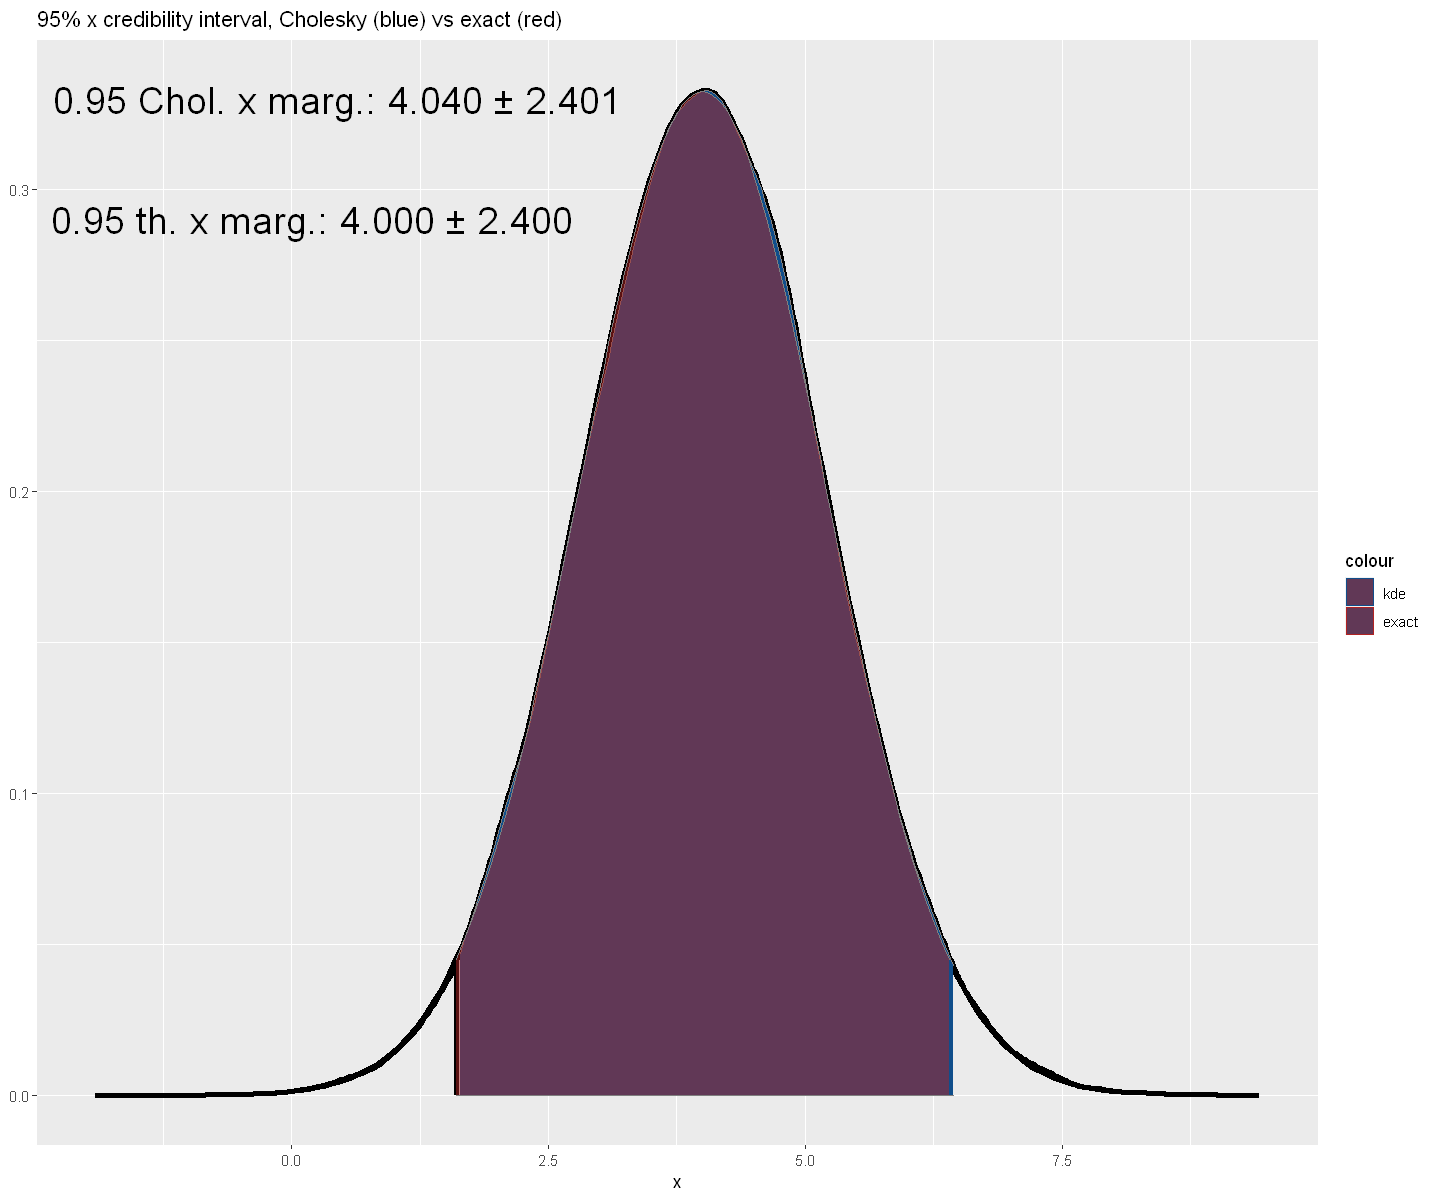

In [33]:
ggplot() + geom_line(data = marginal_x_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = x1, xend = x1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2, xend = x2, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(cholesky_df$x)$x,
                              y = density(cholesky_df$x)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(cholesky_df$x))(.x),
                xlim = c(x1_chol, x2_chol),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x, sd = sigma_x),
                xlim = c(x1, x2),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x credibility interval, Cholesky (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = 0.45, y = 0.33,
           label = sprintf("0.95 Chol. x marg.: %.3f ± %.3f",
           max_cholesky_x, k_x * cov_cholesky_df[1, 1]), size = 8) +
  annotate("text", x = 0.2, y = 0.29,
           label = sprintf("0.95 th. x marg.: %.3f ± %.3f",
           mu_x, 2 * sigma_x), size = 8)

This allows us to immediately see that indeed since the peak of the kde is slightly shifted to the right compared to the exact density the new extrema are slightly shifted to the right by that same amount. We also notice the slight difference in the area due to some "extra mass" in the empirical density, although that difference is negligible.

### $y$ Cholesky marginal
We start by plotting the $y$ histogram and its kde and then computing the KLD with the theoretical marginal distribution, like in the previous section.

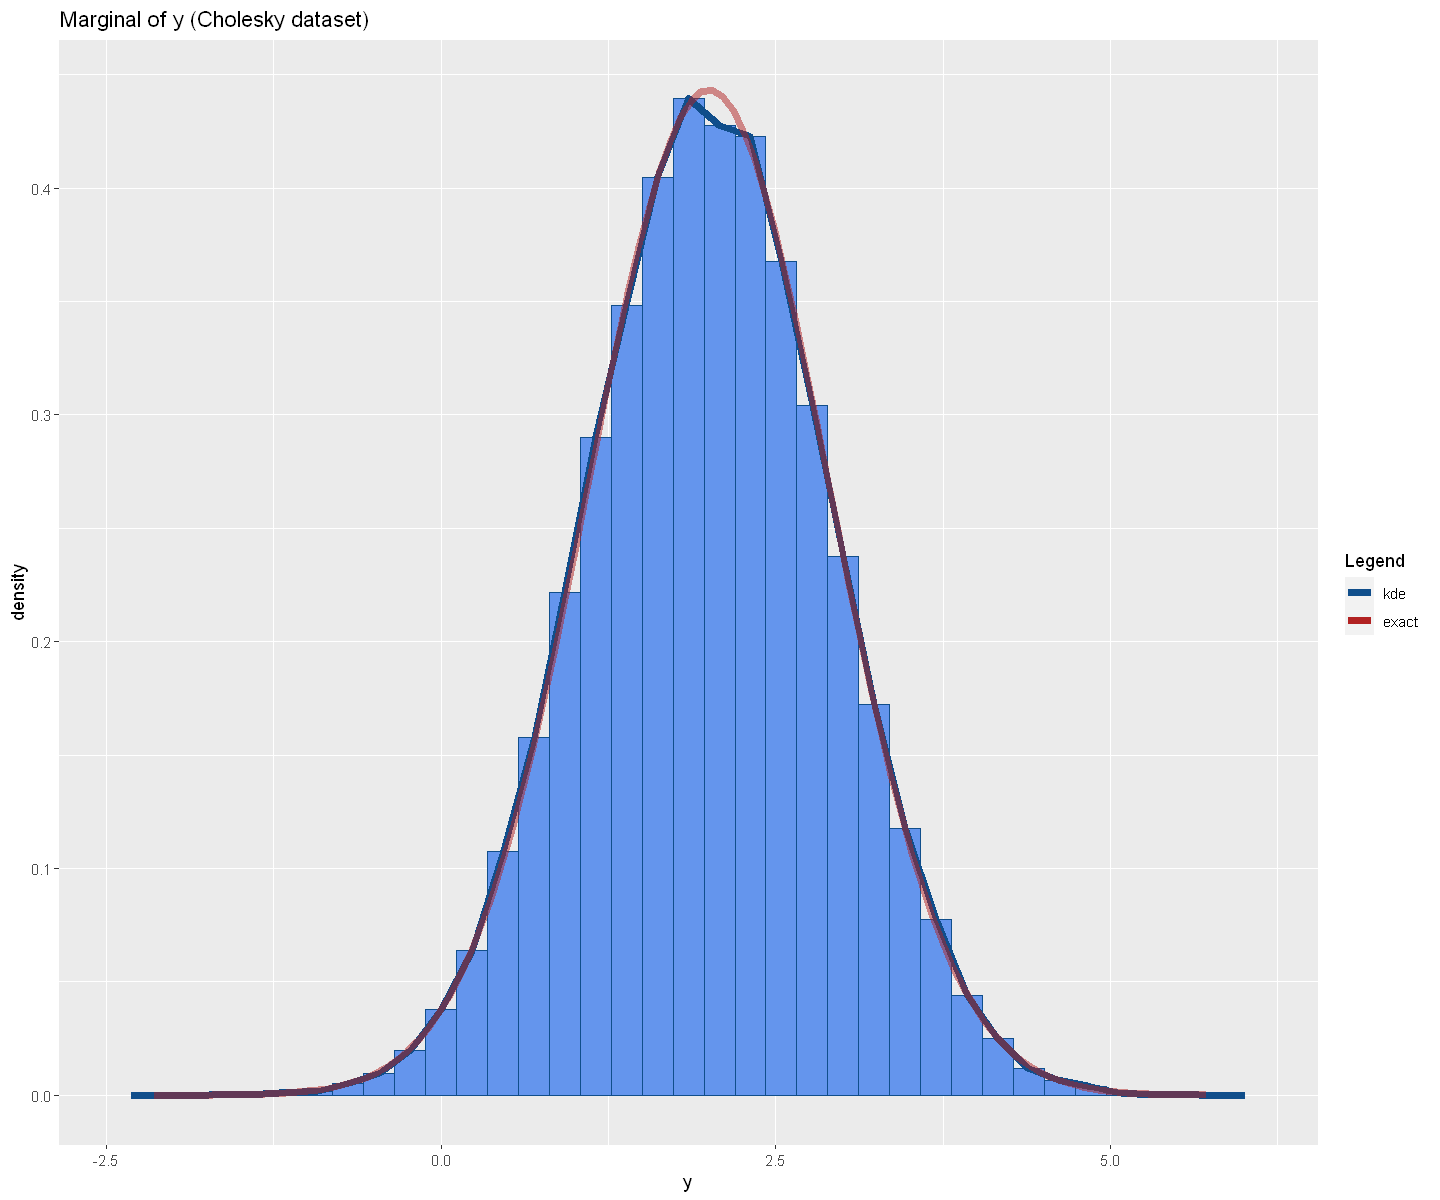

In [34]:
ggplot(cholesky_df) +
  geom_histogram(aes(x = y, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = y, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_y, sd = sigma_y),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle("Marginal of y (Cholesky dataset)") +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [35]:
print("Mean KLD between Cholesky & exact y marginal:")
print(kld_sampled_exact_distribution(cholesky_df$y, mu_y, sigma_y))

[1] "Mean KLD between Cholesky & exact y marginal:"
[1] 0.0001755423


Even though the KLD is slightly larger than for the $x$ marginal (probably mostly due to the larger discrepancy near the peak) we once again observe a very good resemblance, both qualitatively and semi-quantitatively (KLD $\approx 0$).

#### Cholesky $95\%$ credibility interval for $y$
##### Estimate via histograms
We proceed as before.

In [36]:
# we estimate the max using kde
max_cholesky_y <- density(cholesky_df$y, n = 1024)$x[which.max(density(cholesky_df$y, n = 1024)$y)]

# since the distribution is approximately gaussian we expect that
# the mean ± 2 sigma rule should still be approximately valid;
# this gives us a simple starting point, i.e. we can tweak a parameter
# k until we find a desired 95% interval of the kind mean ± k sigma
k_y       <- 2.23
y1_chol <- max_cholesky_y - k_y * cov_cholesky_df[2, 2]
y2_chol <- max_cholesky_y + k_y * cov_cholesky_df[2, 2]

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Cholesky: area of y's marginal between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              y1_chol, y2_chol, k_y))
mean((y1_chol < cholesky_df$y) & (cholesky_df$y < y2_chol)) |> print()

[1] "Cholesky: area of y's marginal between 0.11 and 3.70 (argmax ± 2.23 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.95437


In [37]:
print("theoretical 95% credibility interval for y:")
print(sprintf("[%.2f, %.2f]", y1, y2))

[1] "theoretical 95% credibility interval for y:"
[1] "[0.20, 3.80]"


Once again the slight difference is explained by considering the difference in std and distribution center.

In [38]:
print(sprintf("ratio between theoretical and Cholesky empirical sigma_y = %f", cov_cholesky_df[2, 2] / sigma_y))
print(sprintf("2/%.3f = %f", k_y, 2 / k_y))

[1] "ratio between theoretical and Cholesky empirical sigma_y = 0.896021"
[1] "2/2.230 = 0.896861"


In [39]:
print(sprintf("center of Cholesky empirical y marginal = %.2f", max_cholesky_y))
print(sprintf("center of theoretical y marginal = %.2f", mu_y))

[1] "center of Cholesky empirical y marginal = 1.91"
[1] "center of theoretical y marginal = 2.00"


Indeed both the center and the extrema are shifted by about $0.09$.
##### Estimate via kde

In [40]:
cat(sprintf("Cholesky: area of y's marginal between %.2f and %.2f (mean ± %.2f * std):",
            y1_chol, y2_chol, k_y))
integrate(\ (x) approxfun(density(cholesky_df$y))(x), y1_chol, y2_chol)
# same area estimate

Cholesky: area of y's marginal between 0.11 and 3.70 (mean ± 2.23 * std):

0.9543913 with absolute error < 1e-04

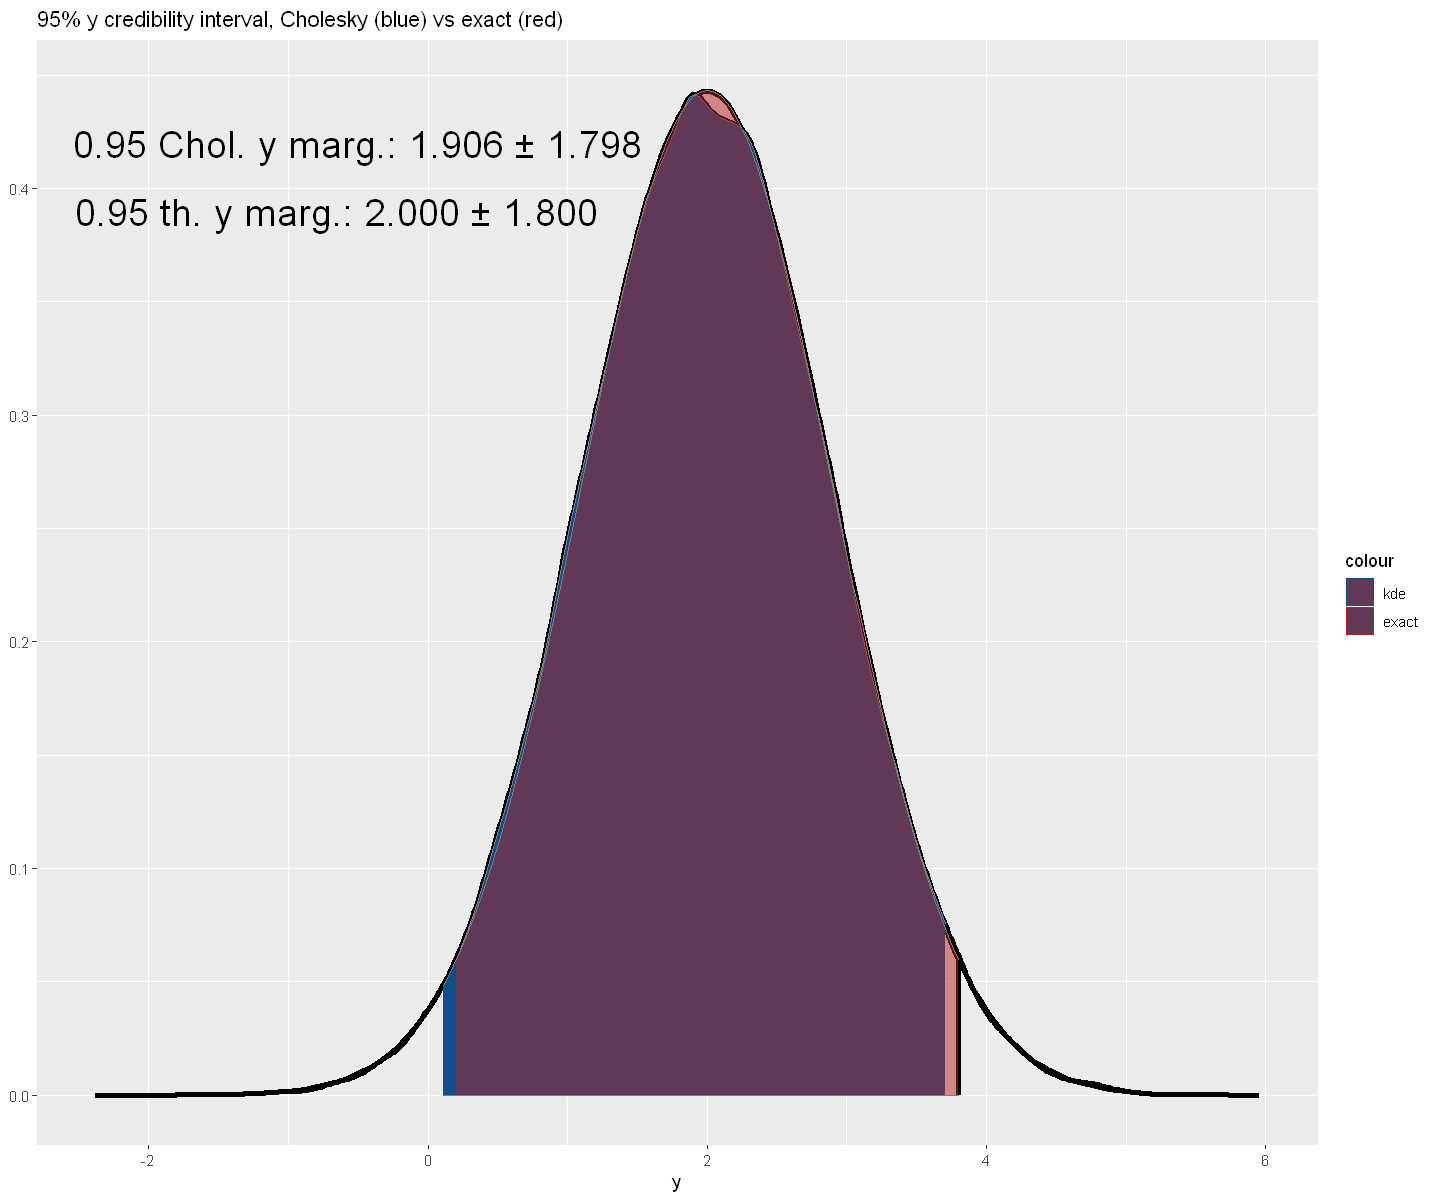

In [41]:
ggplot() + geom_line(data = marginal_y_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = y1, xend = y1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2, xend = y2, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(cholesky_df$y)$x,
                              y = density(cholesky_df$y)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) + 
  stat_function(fun = ~ approxfun(density(cholesky_df$y))(.x),
                xlim = c(y1_chol, y2_chol),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y, sd = sigma_y),
                xlim = c(y1, y2),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% y credibility interval, Cholesky (blue) vs exact (red)") +
  labs(x = "y", y = NULL) +
  annotate("text", x = -0.5, y = 0.42,
           label = sprintf("0.95 Chol. y marg.: %.3f ± %.3f",
           max_cholesky_y, k_y * cov_cholesky_df[2, 2]), size = 8) +
  annotate("text", x = -0.65, y = 0.39,
           label = sprintf("0.95 th. y marg.: %.3f ± %.3f",
           mu_y, 2 * sigma_y), size = 8)

Here the differences between distributions and extrema are a bit more noticeable, but still minor.

## Conditioning with Cholesky generated dataset
We saw before that conditioning means setting either $x$ or $y$ equal to a specific value, and that geometrically this means taking a slice of zero width of the (exact) distribution; now that we no longer have direct access to the underlying distribution we must slightly change what we do in order to condition. We still have to set e.g. $y = 3$, but in this context this means discarding all points with $y \neq 3$ and use only the "compatible" ones to perform similar computations as in the previous section; i.e. the first difference is that we filter points instead of compute sums/integrals. The second difference is of practical nature: since we're dealing with floats we should be careful with equalities and inequalities, since two floats are usually always strictly different for a computer even when for a human they're close enough. For this reason we need to consider points with $y \in [3 - \varepsilon, 3 + \varepsilon]$ with $\varepsilon$ small enough that the difference is negligible but large enough that "practical" equality between floats is possible. Geometrically this corresponds to giving a nonzero width to the distribution slice we take; as just said this slice must be small enough and large enough at the same time.

Of course if $\varepsilon$ is small enough since any line drawn in practice will have some nonzero linewidth the difference between the Cholesky and the exact conditionals slices may not be noticeable; hence we do not repeat the 2D slice representation, and directly skip to the plot of the conditionals.

### $x$ Cholesky conditional

In [42]:
# to compare with the exact case we still consider the y = 3 conditional
eps_y        <- 0.1
y1_cond_chol <- 3 - eps_y
y2_cond_chol <- 3 + eps_y

conditional_x_df_cholesky <- cholesky_df |> filter(y1_cond_chol < y & y < y2_cond_chol)
print(sprintf("number of elements with %.2f < y < %.2f: %d", y1_cond_chol, y2_cond_chol, length(conditional_x_df_cholesky$x)))

[1] "number of elements with 2.90 < y < 3.10: 4778"


It's important we choose $\varepsilon$ large enough that our smaller dataset still has a large enough number of points to approximate well the asymptotic distribution; if this dataset size is too small we should either increase $\varepsilon$ or repeat the simulation by sampling more points at the beginning. Notice that if the $y$ value we're conditioning with respect to has too low a probability it will be hard to populate our slice; this is something to keep in mind while choosing how many points to sample and how large $\varepsilon$ should be.

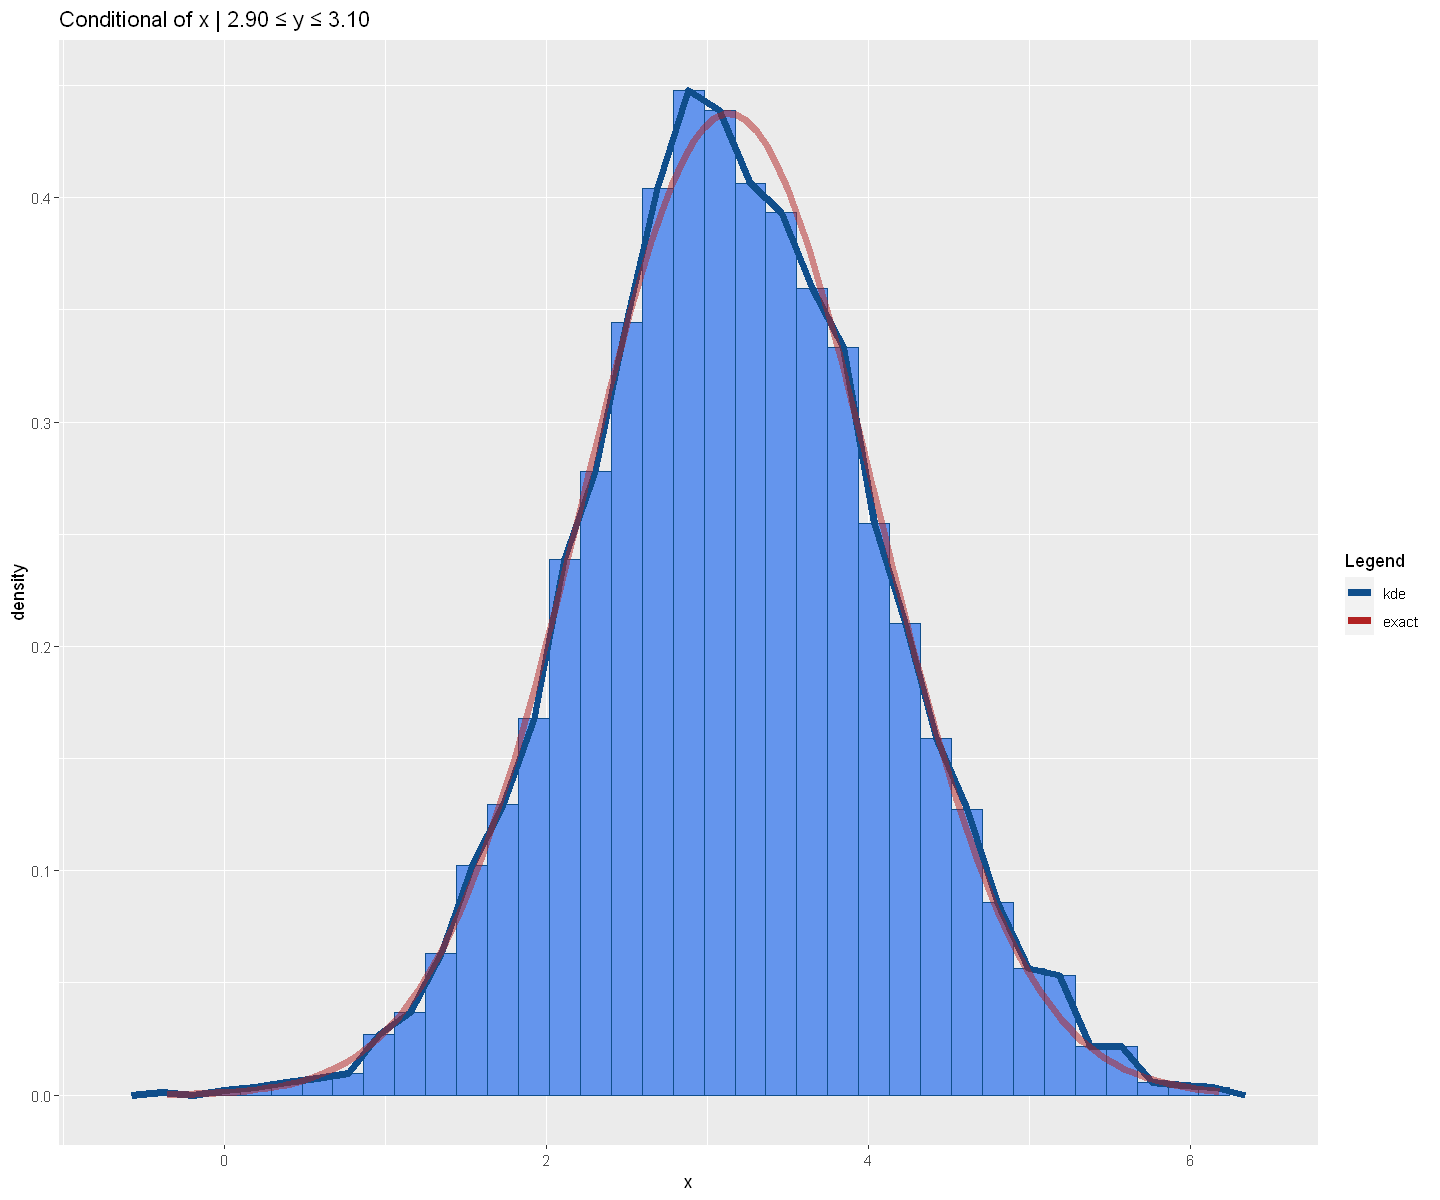

In [43]:
ggplot(conditional_x_df_cholesky) +
  geom_histogram(aes(x = x, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = x, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_x_conditional, sd = sigma_x_conditional),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle(sprintf("Conditional of x | %.2f ≤ y ≤ %.2f", y1_cond_chol, y2_cond_chol)) +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

We notice that the agreement between distribution is now a bit worse - clearly a consequence of the smaller number of points available in the dataset (about 2 o.o.m. less). We can still consider it pretty good, both qualitatively and semi-quantitatively:

In [44]:
print("Mean KLD between Cholesky & exact x conditional:")
print(kld_sampled_exact_distribution(conditional_x_df_cholesky$x, mu_x_conditional, sigma_x_conditional))

[1] "Mean KLD between Cholesky & exact x conditional:"
[1] 0.001830893


#### Cholesky $95\%$ credibility interval for $x|y\approx 3$
##### Estimate via histograms

In [45]:
# we estimate the max using kde
max_cholesky_x_cond      <- density(conditional_x_df_cholesky$x, n = 1024)$x[which.max(density(conditional_x_df_cholesky$x, n = 1024)$y)]
sigma_x_conditional_chol <- sd(conditional_x_df_cholesky$x)

k_x_cond     <- 2.011 # 1.671
x1_chol_cond <- max_cholesky_x_cond - k_x_cond * sigma_x_conditional_chol
x2_chol_cond <- max_cholesky_x_cond + k_x_cond * sigma_x_conditional_chol

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Cholesky: area of x|y = 3 conditional between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              x1_chol_cond, x2_chol_cond, k_x_cond))
mean((x1_chol_cond < conditional_x_df_cholesky$x) & (conditional_x_df_cholesky$x < x2_chol_cond)) |> print()

[1] "Cholesky: area of x|y = 3 conditional between 1.12 and 4.83 (argmax ± 2.01 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9501884


In [46]:
print("theoretical 95% credibility interval for x|y = 3:")
print(sprintf("[%.2f, %.2f]", x1_cond, x2_cond))

[1] "theoretical 95% credibility interval for x|y = 3:"
[1] "[1.31, 4.96]"


In [47]:
print(sprintf("ratio between theoretical and Cholesky empirical sigma_x = %f", sigma_x_conditional_chol / sigma_x_conditional))
print(sprintf("2/%.3f = %f", k_x_cond, 2 / k_x_cond))

[1] "ratio between theoretical and Cholesky empirical sigma_x = 1.011730"
[1] "2/2.011 = 0.994530"


In [48]:
print(sprintf("center of Cholesky empirical x|y = 3 conditional = %.2f", max_cholesky_x_cond))
print(sprintf("center of theoretical x|y = 3 conditional = %.2f", mu_x_conditional))

[1] "center of Cholesky empirical x|y = 3 conditional = 2.98"
[1] "center of theoretical x|y = 3 conditional = 3.13"


Once again the interval is mostly the same except for a shift to the left, explained by the fact that the center of the empirical distribution is shifted about 0.15 units to the left (as can be seen from the histogram or the next plot).

##### Estimate via kde

In [49]:
cat(sprintf("Cholesky: area of x|y = 3 conditional between %.2f and %.2f (mean ± %.2f * std):",
            x1_chol_cond, x2_chol_cond, k_x_cond))
integrate(\ (x) approxfun(density(conditional_x_df_cholesky$x))(x), x1_chol_cond, x2_chol_cond)
# almost the same area estimate. Larger difference due to smaller dataset

Cholesky: area of x|y = 3 conditional between 1.12 and 4.83 (mean ± 2.01 * std):

0.9482103 with absolute error < 9.5e-05

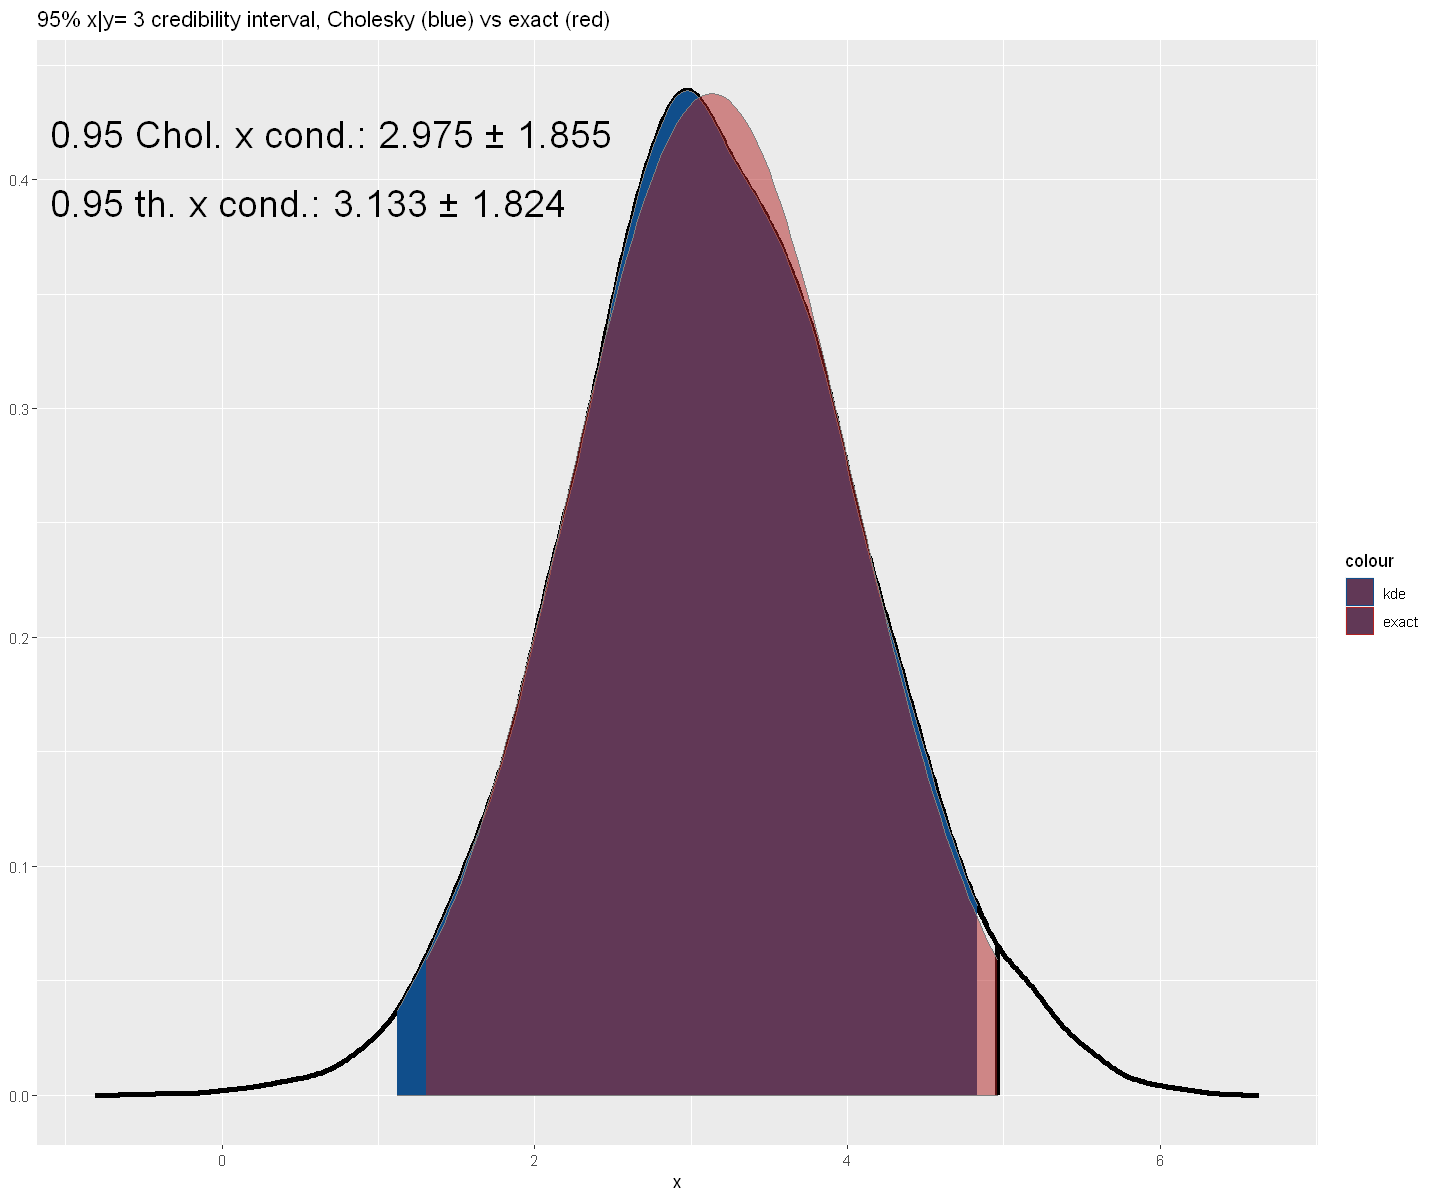

In [50]:
ggplot() + #geom_line(data = conditional_x_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = x1_cond, xend = x1_cond, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2_cond, xend = x2_cond, y = 0, yend = 0.065,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(conditional_x_df_cholesky$x)$x,
                              y = density(conditional_x_df_cholesky$x)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(conditional_x_df_cholesky$x))(.x),
                xlim = c(x1_chol_cond, x2_chol_cond),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x_conditional, sd = sigma_x_conditional),
                xlim = c(x1_cond, x2_cond),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x|y= 3 credibility interval, Cholesky (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = 0.7, y = 0.42,
           label = sprintf("0.95 Chol. x cond.: %.3f ± %.3f",
           max_cholesky_x_cond, k_x_cond * sigma_x_conditional_chol),
           size = 8) +
  annotate("text", x = 0.55, y = 0.39,
           label = sprintf("0.95 th. x cond.: %.3f ± %.3f",
           mu_x_conditional, 2 * sigma_x_conditional), size = 8)

As with the histogram we notice that when we plot the kde there is a more significant difference with the theoretical distribution (the peak is more clearly asymmetrical); this difference is reflected in a larger discrepancy between credibility intervals extrema.

Still we can once again consider the agreement between Cholesky sampled and theoretical conditional distributions to be excellent, all things considered.

### $y$ Cholesky conditional

In [51]:
# to compare with the exact case we still consider the x = 2.5 conditional
eps_x        <- 0.2 # epsilon chosen to achieve the same o.o.m. of elements in the dataset as in the previous conditional
x1_cond_chol <- 2.5 - eps_x
x2_cond_chol <- 2.5 + eps_x

conditional_y_df_cholesky <- cholesky_df |> filter(x1_cond_chol < x & x < x2_cond_chol)
print(sprintf("number of elements with %.2f < x < %.2f: %d", x1_cond_chol, x2_cond_chol, length(conditional_y_df_cholesky$x)))

[1] "number of elements with 2.30 < x < 2.70: 6067"


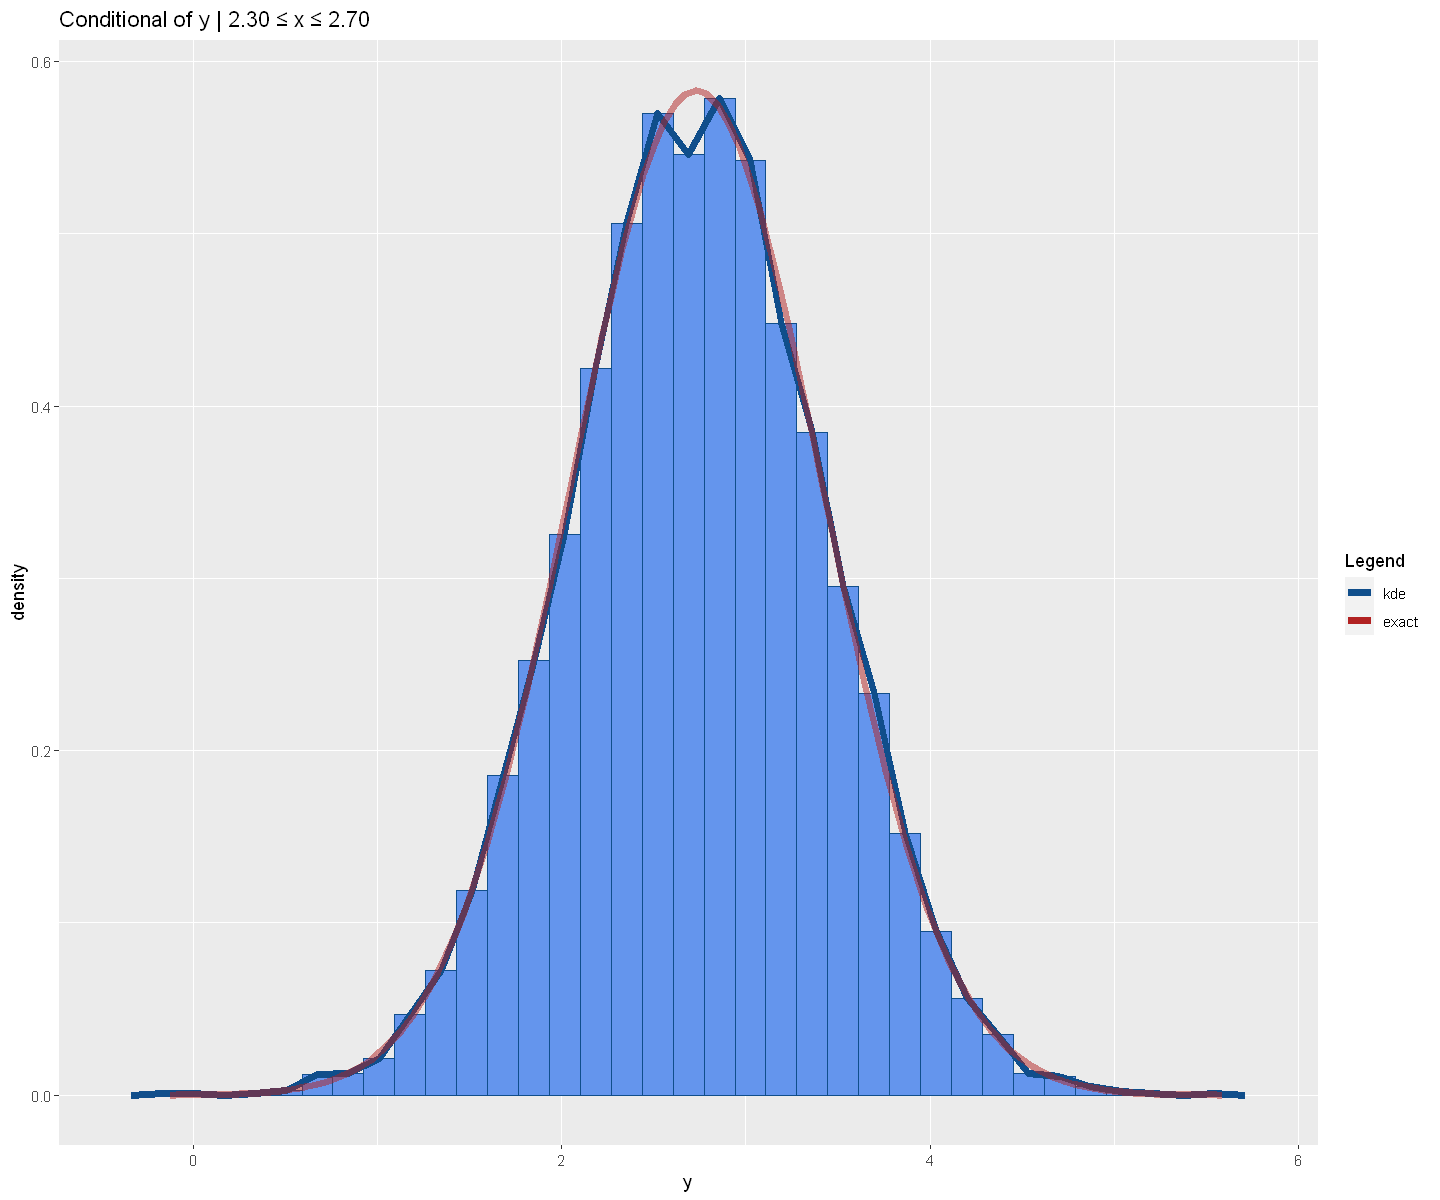

In [52]:
ggplot(conditional_y_df_cholesky) +
  geom_histogram(aes(x = y, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = y, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_y_conditional, sd = sigma_y_conditional),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle(sprintf("Conditional of y | %.2f ≤ x ≤ %.2f", x1_cond_chol, x2_cond_chol)) +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [53]:
print("Mean KLD between Cholesky & exact y conditional:")
print(kld_sampled_exact_distribution(conditional_y_df_cholesky$y, mu_y_conditional, sigma_y_conditional))

[1] "Mean KLD between Cholesky & exact y conditional:"
[1] 0.000939205


Once again the agreement is a bit worse than in the marginal analysis simply due to the much smaller dataset, but still excellent overall (both visually and according to the KLD). This conditional seems to be in even better agreement with the theoretical one, since it's a bit more symmetrical - even though the center is a bit depressed; for this reason since our algorithm constructs an interval centered around the max the 95% interval will still be slightly shifted.

#### Cholesky $95\%$ credibility interval for $y|x\approx 2.5$
##### Estimate via histograms

In [54]:
# we estimate the max using kde
max_cholesky_y_cond      <- density(conditional_y_df_cholesky$y, n = 1024)$x[which.max(density(conditional_y_df_cholesky$y, n = 1024)$y)]
sigma_y_conditional_chol <- sd(conditional_y_df_cholesky$y)

k_y_cond     <- 2.011 # 1.671
y1_chol_cond <- max_cholesky_y_cond - k_y_cond * sigma_y_conditional_chol
y2_chol_cond <- max_cholesky_y_cond + k_y_cond * sigma_y_conditional_chol

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Cholesky: area of x|y = 3 conditional between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              y1_chol_cond, y2_chol_cond, k_y_cond))
mean((y1_chol_cond < conditional_y_df_cholesky$y) & (conditional_y_df_cholesky$y < y2_chol_cond)) |> print()

[1] "Cholesky: area of x|y = 3 conditional between 1.46 and 4.22 (argmax ± 2.01 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.953519


In [55]:
print("theoretical 95% credibility interval for y|x = 2.5:")
print(sprintf("[%.2f, %.2f]", y1_cond, y2_cond))

[1] "theoretical 95% credibility interval for y|x = 2.5:"
[1] "[1.36, 4.10]"


In [56]:
print(sprintf("ratio between theoretical and Cholesky empirical sigma_y_conditional = %f", sigma_y_conditional_chol / sigma_y_conditional))
print(sprintf("2/%.3f = %f", k_y_cond, 2 / k_y_cond))

[1] "ratio between theoretical and Cholesky empirical sigma_y_conditional = 1.006240"
[1] "2/2.011 = 0.994530"


In [57]:
print(sprintf("center of Cholesky empirical y|x = 2.5 conditional = %.2f", max_cholesky_y_cond))
print(sprintf("center of theoretical y|x = 2.5 conditional = %.2f", mu_y_conditional))

[1] "center of Cholesky empirical y|x = 2.5 conditional = 2.84"
[1] "center of theoretical y|x = 2.5 conditional = 2.73"


Once again the interval is mostly the same except for a shift to the left, explained by the fact that the center of the empirical distribution is shifted about 0.11 units to the left (as can be seen from the histogram or the next plot).

##### Estimate via kde

In [58]:
cat(sprintf("Cholesky: area of y|x = 2.5 conditional between %.2f and %.2f (mean ± %.2f * std):",
            y1_chol_cond, y2_chol_cond, k_y_cond))
integrate(\ (x) approxfun(density(conditional_y_df_cholesky$y))(x), y1_chol_cond, y2_chol_cond)
# almost the same area estimate. Larger difference due to smaller dataset

Cholesky: area of y|x = 2.5 conditional between 1.46 and 4.22 (mean ± 2.01 * std):

0.9519631 with absolute error < 6.1e-05

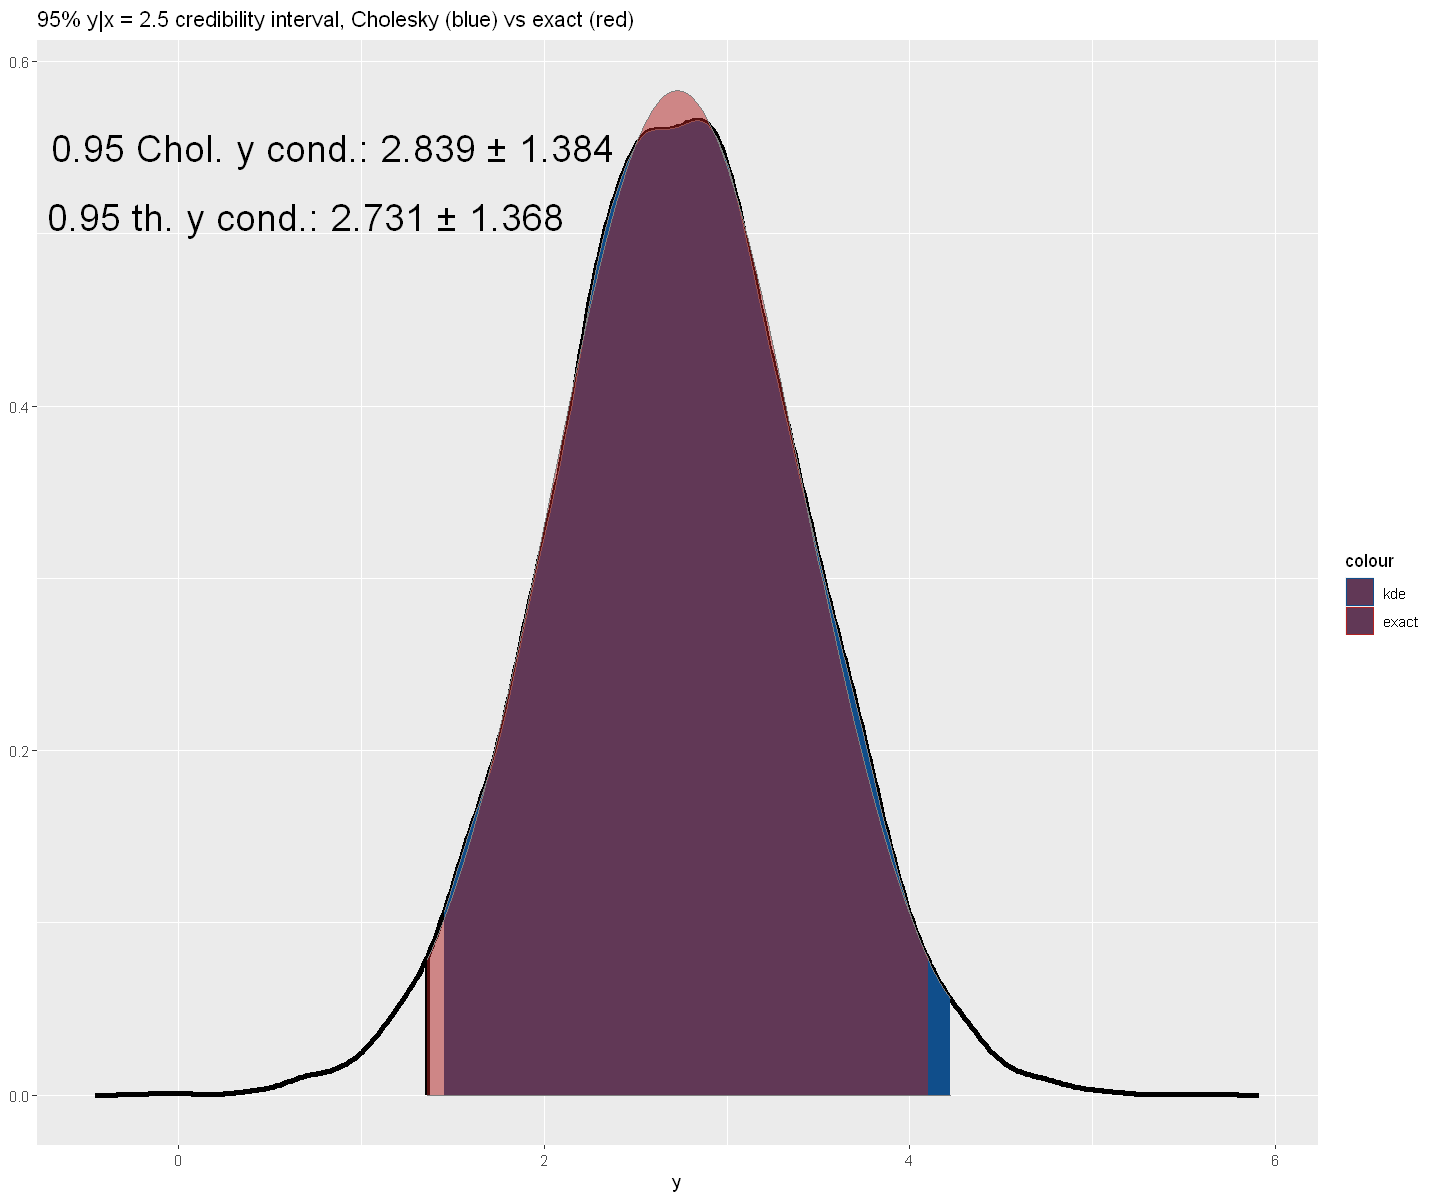

In [59]:
ggplot() + #geom_line(data = conditional_y_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = y1_cond, xend = y1_cond, y = 0, yend = 0.08,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2_cond, xend = y2_cond, y = 0, yend = 0.065,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(conditional_y_df_cholesky$y)$x,
                              y = density(conditional_y_df_cholesky$y)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(conditional_y_df_cholesky$y))(.x),
                xlim = c(y1_chol_cond, y2_chol_cond),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y_conditional, sd = sigma_y_conditional),
                xlim = c(y1_cond, y2_cond),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% y|x = 2.5 credibility interval, Cholesky (blue) vs exact (red)") +
  labs(x = "y", y = NULL) +
  annotate("text", x = 0.85, y = 0.55,
           label = sprintf("0.95 Chol. y cond.: %.3f ± %.3f",
           max_cholesky_y_cond, k_y_cond * sigma_y_conditional_chol),
           size = 8) +
  annotate("text", x = 0.7, y = 0.51,
           label = sprintf("0.95 th. y cond.: %.3f ± %.3f",
           mu_y_conditional, 2 * sigma_y_conditional), size = 8)

As with the histogram we notice that when we plot the kde there is a more significant difference with the theoretical distribution (the peak is more clearly asymmetrical); this difference is reflected in a larger discrepancy between credibility intervals extrema.

Still we can once again consider the agreement between Cholesky sampled and theoretical conditional distributions to be excellent, all things considered.

# Metropolis-Hastings MCMC sampling
## Introduction
In most practical situations analytical computations are not possible, and ad hoc sampling techniques are not available; for this reason general purpose sampling methods are needed. In principle every problem could be tackled using *Montecarlo techniques*; these methods consist in randomly sampling points with uniform probability, then accepting some and rejecting the others according to the target distribution - so that starting from a uniform sampler we can "trim it" and replicate the actual posterior. The main advantage of this approach is that it produces points which are truly i.i.d. sampled; unfortunately in most real world problem this is not a feasible solution. The reason for this is the curse of dimensionality: due to the way hypervolume scales with space dimension the higher $d$ the higher the fraction of points must be discarded - this follows from the fact that the volume "outside the posterior" increases exponentially faster than the volume "inside", so it gets rarer and rarer to randomly sample a point "inside". The consequence is that in high dimensional spaces Montecarlo methods are highly inefficient: due to the large rejection rate most points have to be discarded, and therefore the total number of points that must be sampled becomes huge.

To solve this problem *Markov chain Montecarlo techniques* have become dominant in bayesian analysis problems. The main idea is that instead of sampling points completely at random in parameter space we sample each point conditionally on the previous one and lead them according to the target density; for this reason our points will preferentially remain "inside" the "good" region. We are essentially trading complete randomness with the possibility of driving the chain. The main disadvantage is that now points are no longer truly i.i.d. sampled, since each point depends on the previous one; some theorems guarantee asymptotic independence, but actually converging to the target density may be tricky in practice. For this reason when one needs to apply MCMC before using the simulated dataset to infer interesting quantities a number of diagnostics must be performed; blind trust may lead us to the wrong conclusions.

Due to the above the Metropolis-Hastings and Gibbs sections will be structured as follows:
1. Dataset generation according to MH/Gibbs rule
2. Diagnostics (trace plots, GR tests)
3. Actual inference (marginals, $95\%$ boundaries, etc.)

## MH Algorithm
The Metropolis-Hastings algorithm is one of the simplest and oldest MCMC techniques; as such it inherits the asymptotic convergence properties of the MCMC family. This means that points generated early in the chain are the most correlated and therefore the most unreliable; this problem is called *burn in*, is common to all MCMC algorithms and will be dealt with later. For now it suffices to describe how points are generated acccording to the MH algorithm.

1. We first initialize the chain by picking e.g. at random a starting point, which will be the first member of the chain. In principle if we sample a large enough number of points the starting point doesn't really matter, although a smart choice of this initial condition may speed up convergence in practice; we will explore this point later by running multiple chains.
2. Then we choose a *proposal/jump distribution* $g(x|y)$, which is used to sample the candidate $x$ for the next point conditionally on the previous point $y$. The algorithm is a bit simpler if $g$ is symmetric, i.e. if $g(x|y) = g(y|x)$ - which is clearly true e.g. if g is a normal distribution centered around the previous point, i.e. $g(x|y) = N(x|y, \Sigma)$. For simplicity's sake we will indeed use a symmetric gaussian distribution, whose covariance will be discussed later.
3. Finally we enter the main loop of the algorithm. Given the current point $x_t$ we sample a proposal $\hat{x}$ using the jump distribution $g$, then accept it with probability $\alpha_t = P(\hat{x})/P(x_t)$ (where $P$ is the unnormalized posterior, i.e. likelihood times prior). If the point is accepted we set $x_{t+1} = \hat{x}$, otherwise $x_{t+1} = x_t$ i.e. the chain doesn't move.

Point 3 gives us an intuitive explanation for why the MH algorithm works at all. Indeed notice that if $\alpha_t$ (also known as *Metropolis factor*) is larger than 1 then the proposal is automatically/deterministically accepted; if instead $\alpha_t < 1$ then whether or not the jump is performed is chosen at random, but the smaller $\alpha_t$ the less likely the jump is to be accepted. Since $\alpha_t$ by definition is equal to the ratio of the unnormalized posterior in the proposed point divided by the posterior evaluated in the current point we clearly see that our imaginary particle will prefer to stay in regions where the target density is high; in particular it will spend more time in a certain region compared to another proportionally to the difference in target density. Also notice the fact that since when $\alpha_t < 1$ the motion is stochastic our particle has a natural tool to avoid getting stuck around the posterior maximum: even though it will spend the most time there it will also leave it sometimes and explore the rest of parameter space. Also notice that since the algorithm only relies on ratios of posterior evaluations we never need the constant evidence term, since it would simplify; this is the reason why the MH algorithm can be used to circumvent the difficulty/impossibility of actually computing that integral.

We can now start actually writing the various pieces of the algorithm.

In [60]:
# first we define the unnormalized posterior, which will be used to compute
# the Metropolis factor. This function is clearly the 2D MVN with the
# assigned mean and covariance

posterior <- function(x, mean = mu, inv_cov_mat = C_inv) {
    v <- (x - mean)
    p <- as.numeric(v %*% inv_cov_mat %*% v)
    return(exp(-0.5 * p))
}
# notice R can transpose/reshape the terms automatically,
# no need to do it manually via as.matrix() and t()

In [61]:
# now we define a function that returns TRUE or FALSE with prob. p,
# which we will use with p = alpha to decide whether to accept or
# reject the proposal. Notice that this is essentially a Bernoulli
# sampler, so we can simply use the 1D accept-reject method with
# a constant term in the inequality. Since we'd need to return
# TRUE if runif(n) <= p and FALSE otherwise we return runif(n) <= p
# directly.

rbern <- function(n = 1, p = 0.5) {
    runif(n) <= p
}

# another advantage of this function (apart from performance and
# simplicity) is that it avoids us to discriminate the case
# when alpha > 1: when alpha > 1 the inequality above is
# automatically true, which mimics what we need to do
# according to the MH algorithm

In [62]:
# here we define the function to be looped over. We accept the current
# point and a proposal distribution covariance to sample a candidate,
# then use the previous function to choose whether to accept it or
# remain still

metropolis_next_point <- function(current_point, chol_cov_proposal_dist) {
    proposed_point <- rmvn(n = 1,
                           mean = current_point,
                           L = chol_cov_proposal_dist) |> as.numeric()
    # alpha = metropolis factor
    alpha          <- posterior(proposed_point) / posterior(current_point)
    new_point      <- if(rbern(p = alpha)) proposed_point else current_point
    return(new_point)
}

In [63]:
# finally we write the overall mh algorithm. We initialize the chain
# as input its first point, then fill the rest by iterating the previous func.

metropolis <- function(n_samples, x0 = c(1, 1), cov_proposal_dist) {
    chain_matrix           <- matrix(0, nrow = n_samples, ncol = 2)
    chain_matrix[1, 1:2]   <- x0
    chol_cov_proposal_dist <- chol(cov_proposal_dist)

    for (i in 2:n_samples) {
         chain_matrix[i, 1:2] <- metropolis_next_point(chain_matrix[i - 1, 1:2],
                                                       chol_cov_proposal_dist)
    }
    return(chain_matrix)
}

## Which covariance for the proposal/jump distribution?
As said above we selected a gaussian jump distribution. Due to how the MH algorithm works its mean is simply the previous point in the chain, whereas its covariance must be set by us. There is an extensive literature regarding this, and in particular how to choose the one which can accelerate convergence the most.

The simplest possible choice is to set $\Sigma = \sigma^2 I$, i.e. we use the identity matrix scaled by a user-decided parameter. This already lets us understand the importance of a smart choice: if $\sigma$ is too large the steps will be huge on average, with the result that most jumps would lead the particle far from the high target density region - hence with large $\sigma$ most proposals are rejected, and parameter space is explored inefficiently. Similarly when $\sigma$ is small most jumps will be accepted since the particle will remain in the same region for a long time, but this also leads to inefficiency as small steps imply a long exploration time is needed; hence some sweet spot must be hit between these two extreme cases.

An even smarter approach is to choose a $\Sigma$ (approximately) equal to the target covariance; why this is good can be seen even in our simple example. Indeed notice that our distribution has an elliptical shape aligned with the secondary plane diagonal; this clearly means that in order to efficiently explore the whole distribution we would like to take larger steps in that direction, and smaller ones along the main diagonal. This is why many advanced MCMC schemes try to estimate $\Sigma_p$ on the fly.

Since we have exact knowledge about the posterior's covariance we will exploit it by choosing a jump covariance equal to a scaled down version of the $C$ matrix ($C/3$ to be precise); this way we'll increase efficiency by removing the number of rejected samples. Even though it would be interesting to quantify the improvement of this choice over the naive $\sigma^2 I$ approach this is well beyond the scope of this notebook, so we'll fix this covariance once and for all without analyzing its impact on the final result.

## MH dataset generation
We can finally generate data according to the MH algorithm. Let's start by sampling $10^5$ points with $[x_0, y_0] = [1, 1]$ as a check.

In [64]:
set.seed(1234) # very important step!
n_points_mh <- 1e5
jump_cov    <- C / 3 # we set jump covariance = 1/3 of posterior covariance
mh_matrix   <- metropolis(n_points_mh, cov_proposal_dist = jump_cov)

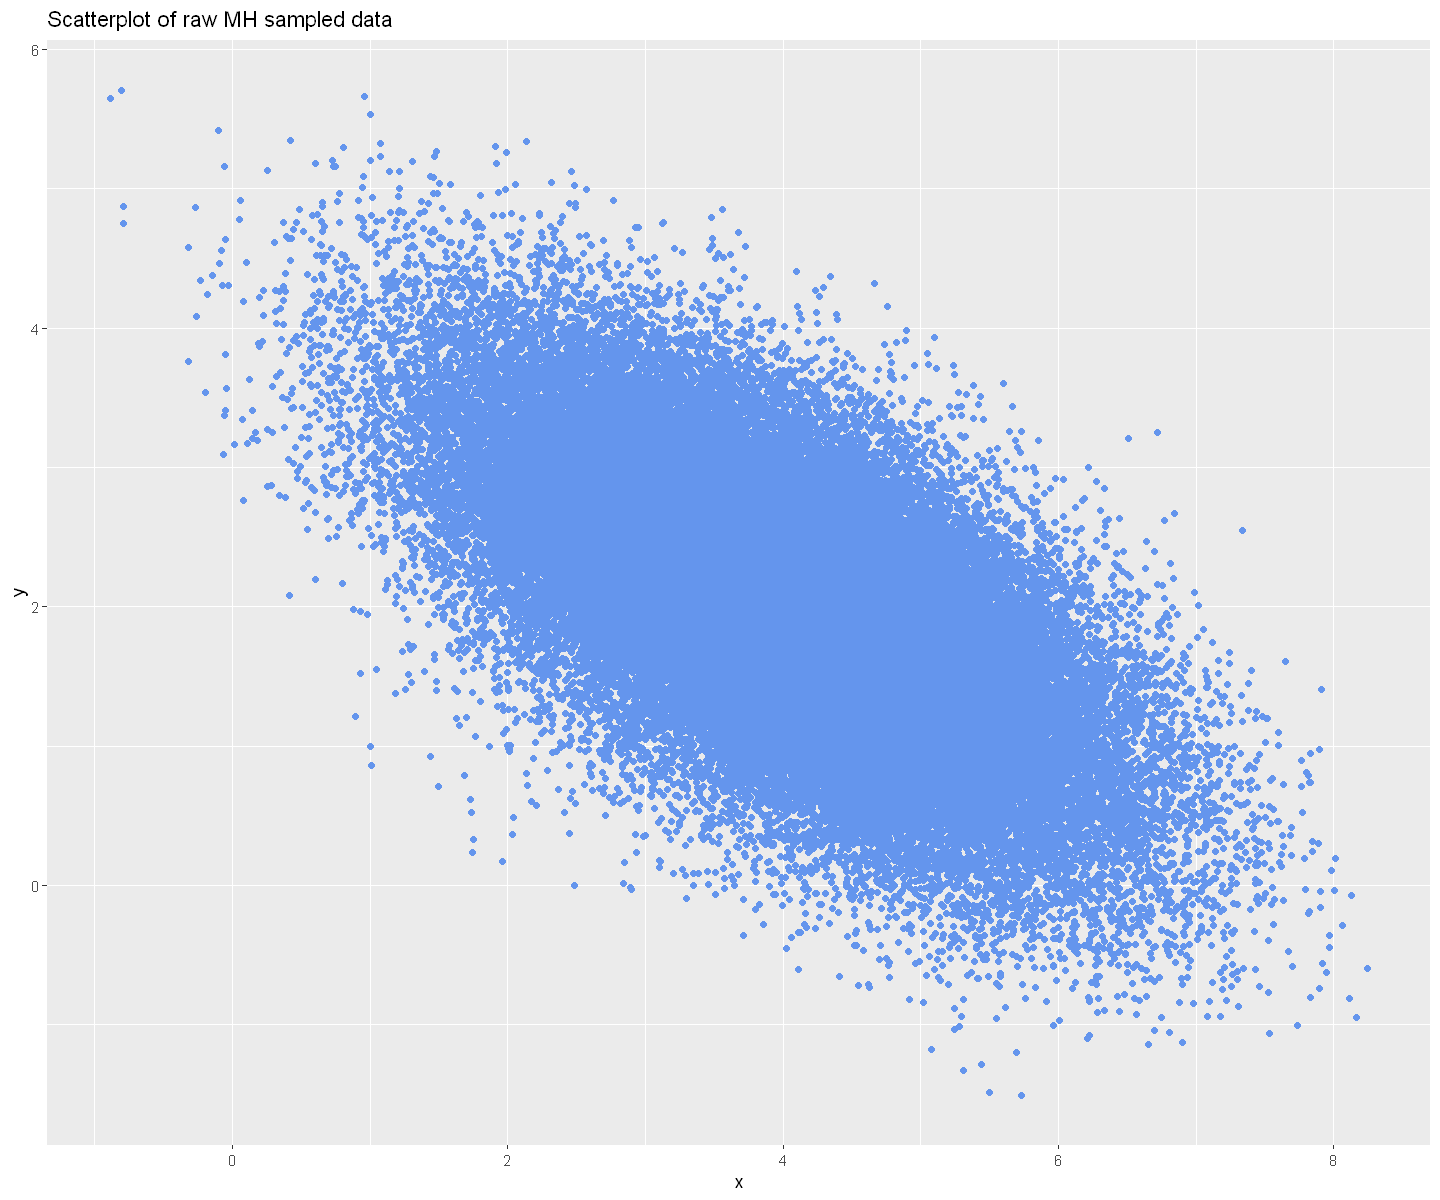

In [65]:
mh_df <- tibble(x = mh_matrix[, 1], y = mh_matrix[, 2])
ggplot(mh_df, aes(x, y)) + geom_point(color = "cornflowerblue") +
  ggtitle("Scatterplot of raw MH sampled data")

This first dataset is promising, since the resulting scatterplot seems to have the correct shape overall. Of course this doesn't mean we can immediately start using this dataset to compute relevant quantities, as in the Cholesky dataset case; first some diagnostics must be performed in order to deal with the fact that samples are correlated.

## MH Diagnostics
### Multiple chains generation
A common practice with MCMC algorithms is to generate multiple chains (in parallel if performance is an issue) and compare them. Ideally if convergence is achieved they will share the same properties, since we know that asymptotically the target density must be reached; if instead there are significant differences between the chains then it means something went wrong. A quantitative way of performing this comparison is the *Gellman-Rubin test*, which we will perform later; for now we generate e.g. 4 chains and tackle the issue of *burn-in*, which is a problem shared by all MCMC chains.

To analyze the effect of choosing a specific starting point we choose the 4 initial conditions in regions of different target density, i.e. some where it's high and some where it's low.

In [66]:
# chains sampling
n_chains       <- 4
x0_list        <- list(c(5.3, 2.4), c(2.5, 3.5), c(5, 1), c(4.5, 1.8))
mh_chains_list <- list()
set.seed(1234)

for (i in 1:n_chains) {
    mh_chains_list[[i]] <- metropolis(n_points_mh,
                                      x0 = x0_list[[i]],
                                      cov_proposal_dist = jump_cov)
}

In [67]:
# The previous loop is easily replaced by a single function call to lapply.
# Switching to a functional programming style has the benefit that we can
# easily replace lapply with parallel::mclapply, immediately achieving
# parallel execution of the 4 chains.

set.seed(1234)
mh_chains_list_2 <- parallel::mclapply(x0_list, \ (x) metropolis(n_points_mh, x0 = x, cov_proposal_dist = jump_cov))
print(identical(mh_chains_list, mh_chains_list_2))

# unfortunately at the moment windows support is lackluster and
# parallel::mclapply can only create one process at a time, so
# there are no benefits. This can be proven by showing that
# with the same seed the non parallel code produces exactly
# the same chains, which would be in possible with true
# parallelism since the pseudo-random generator would advance
# in different ways. Another proof is that the execution time is
# not significantly different

[1] TRUE


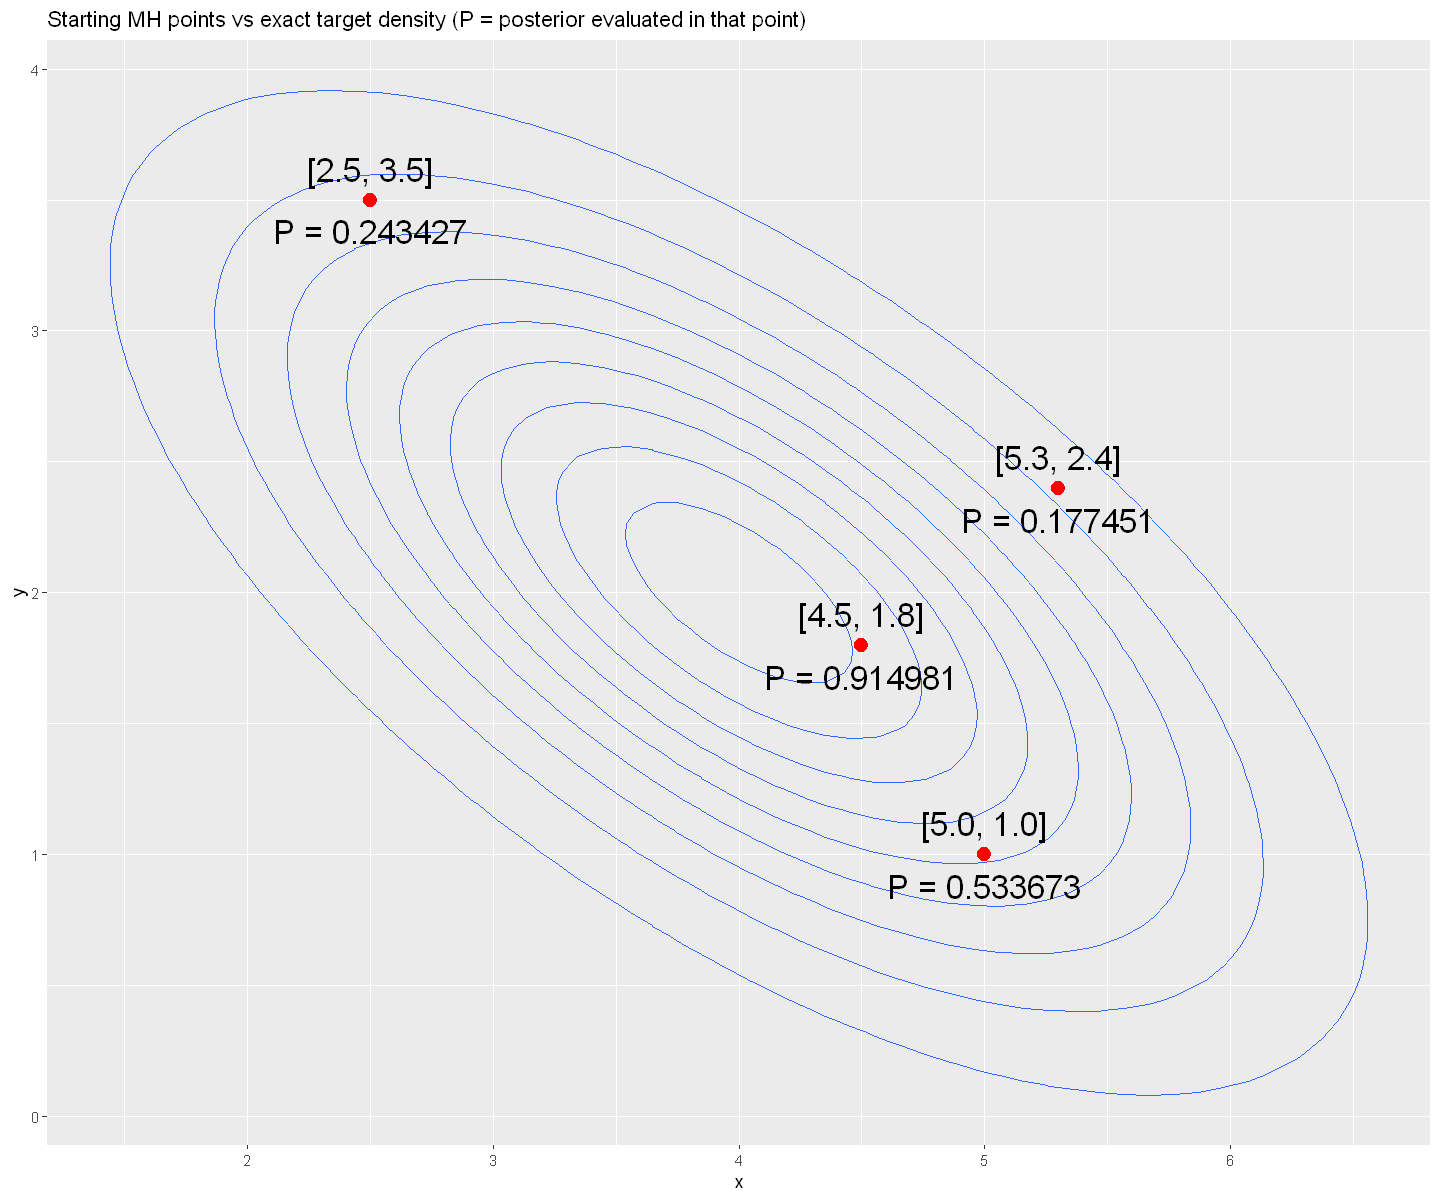

In [68]:
# let us visualize the different starting points
x0_matrix           <- matrix(unlist(x0_list), ncol = 2, byrow = T)
x0_posterior_values <- sapply(x0_list, posterior)

ggplot(exact_df, aes(x, y, z = z)) + geom_contour() +
   ggtitle("Starting MH points vs exact target density (P = posterior evaluated in that point)") +
   annotate("point", x = x0_matrix[, 1], y = x0_matrix[, 2],
            color = "red", size = 3.5) +
   annotate("text",  x = x0_matrix[, 1], y = x0_matrix[, 2] + 0.12,
            label = lapply(x0_list, \ (x) sprintf("[%.1f, %.1f]", x[1], x[2])),
            size = 7) +
    annotate("text", x = x0_matrix[, 1], y = x0_matrix[, 2] - 0.12,
             label = lapply(x0_posterior_values,
                            \ (x) sprintf("P = %.6f", x)),
            size = 7)

The above plots lets us appreciate that the 4 chain initial points have increasing target value density. In particular notice how the first one is relatively far from the MVN peak, which implies the posterior evaluated in this point is closest to zero - hence we expect the chain will flee from here and hardly ever return. Similarly since the last point is near the maximum we expect the chain will mostly stay where it is, and an in between behaviour for the other two initial points.

### Burn in and trace plots
As said above one can only guarantee that convergence/indipendence will be reached *asymptotically*. This means that our chain definitely start with non negligible dependence between points, and that this dependence eventually decreases over time. In practice some amount of dependence will always remain with a finite sample size; still if we discard some of the initial points we may be able to only have a chain with almost independent points. This practice (discarding some points at the start of the chain to achieve better convergence properties) is called *burn in*; even in our simple example applying this can be beneficial.

A possible way to decide how many points to discard is to produce *trace plots*, inspecting them visually and trying to guess when convergence is approximately reached; another is to use a more quantitative approach like the GR test. Let's start with the former.

In [69]:
# let us put all chains in the same dataframe. We also add
# a "time" variable t (simply the index of the point in the chain)
# and a chain index to differentiate points belonging to different
# chains

mh_chains_df <- bind_rows(lapply(mh_chains_list, data.frame),
                          .id = "chain_index") |>
                  rename(x = X1, y = X2) |>
                  mutate(t = rep(1:n_points_mh, times = n_chains)) |> # add t col.
                  select(c(t, x, y, chain_index)) |> # reorder columns
                  as_tibble()

The naive approach is to produce a plot of $x$ or $y$ over time; this apparently makes sense, since indeed we're looking for estimators of them. Unfortunately due to the intrinsic randomness of a Markov Chain the resulting plot is not very useful when it comes to estimating convergence:

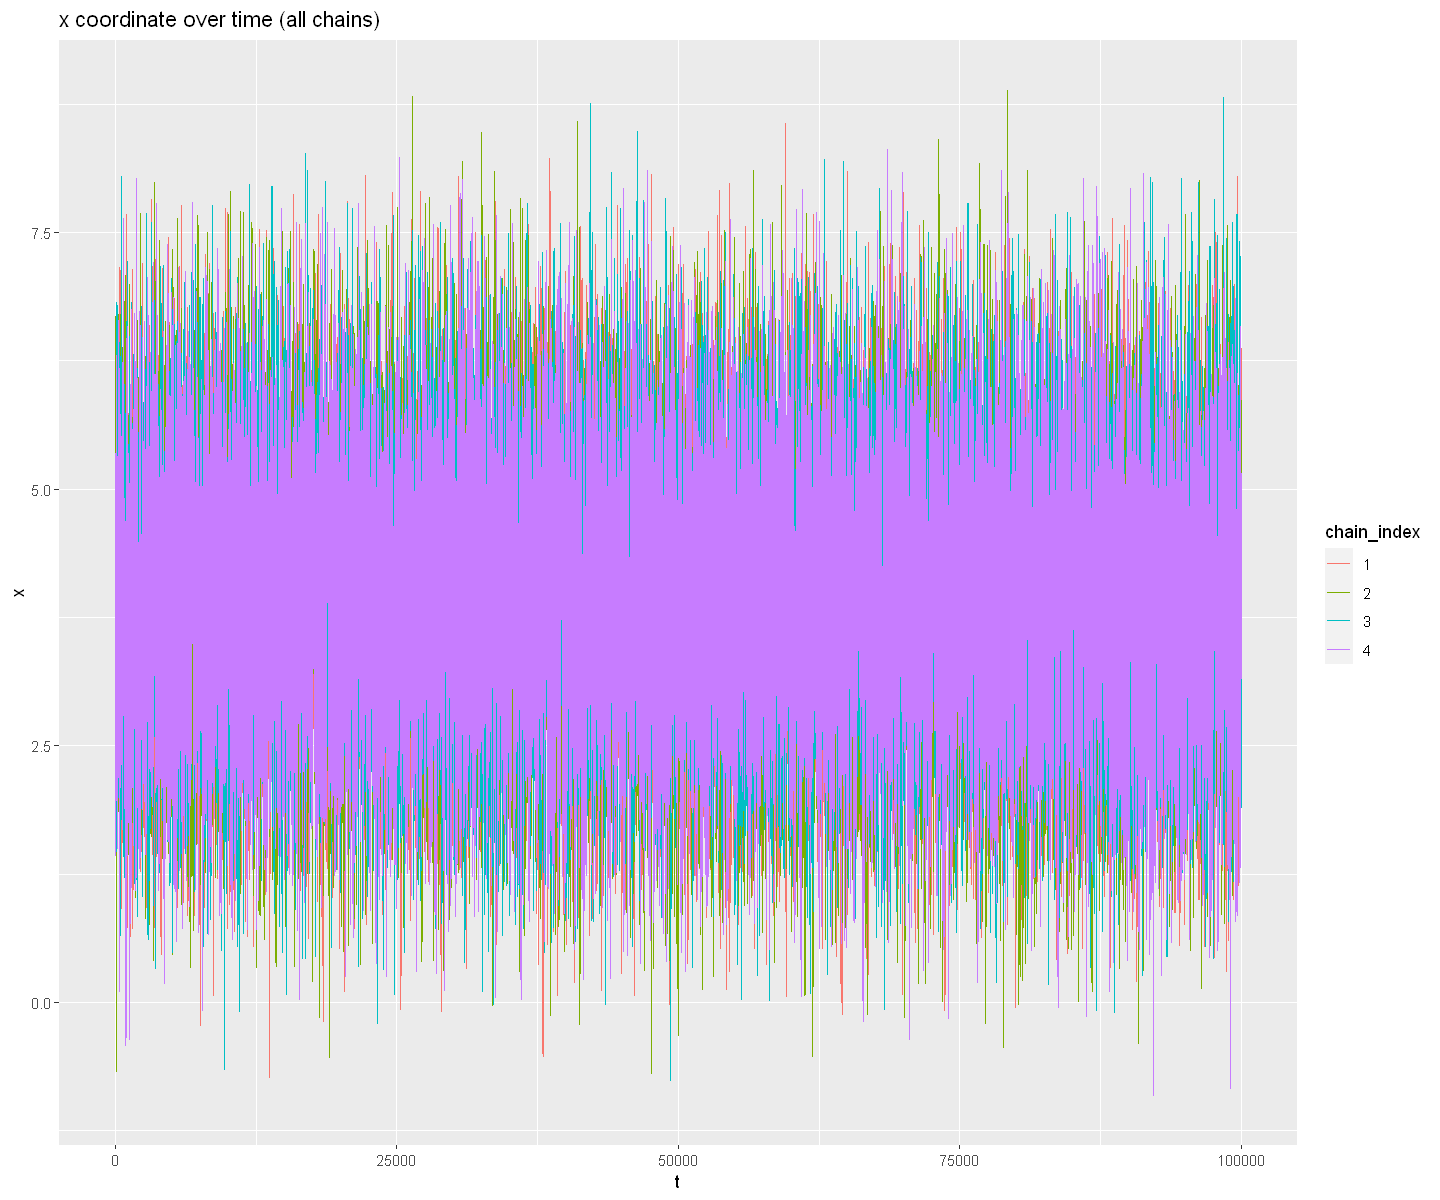

In [70]:
ggplot(mh_chains_df, aes(x = t, y = x, color = chain_index)) + geom_line() +
  ggtitle("x coordinate over time (all chains)")

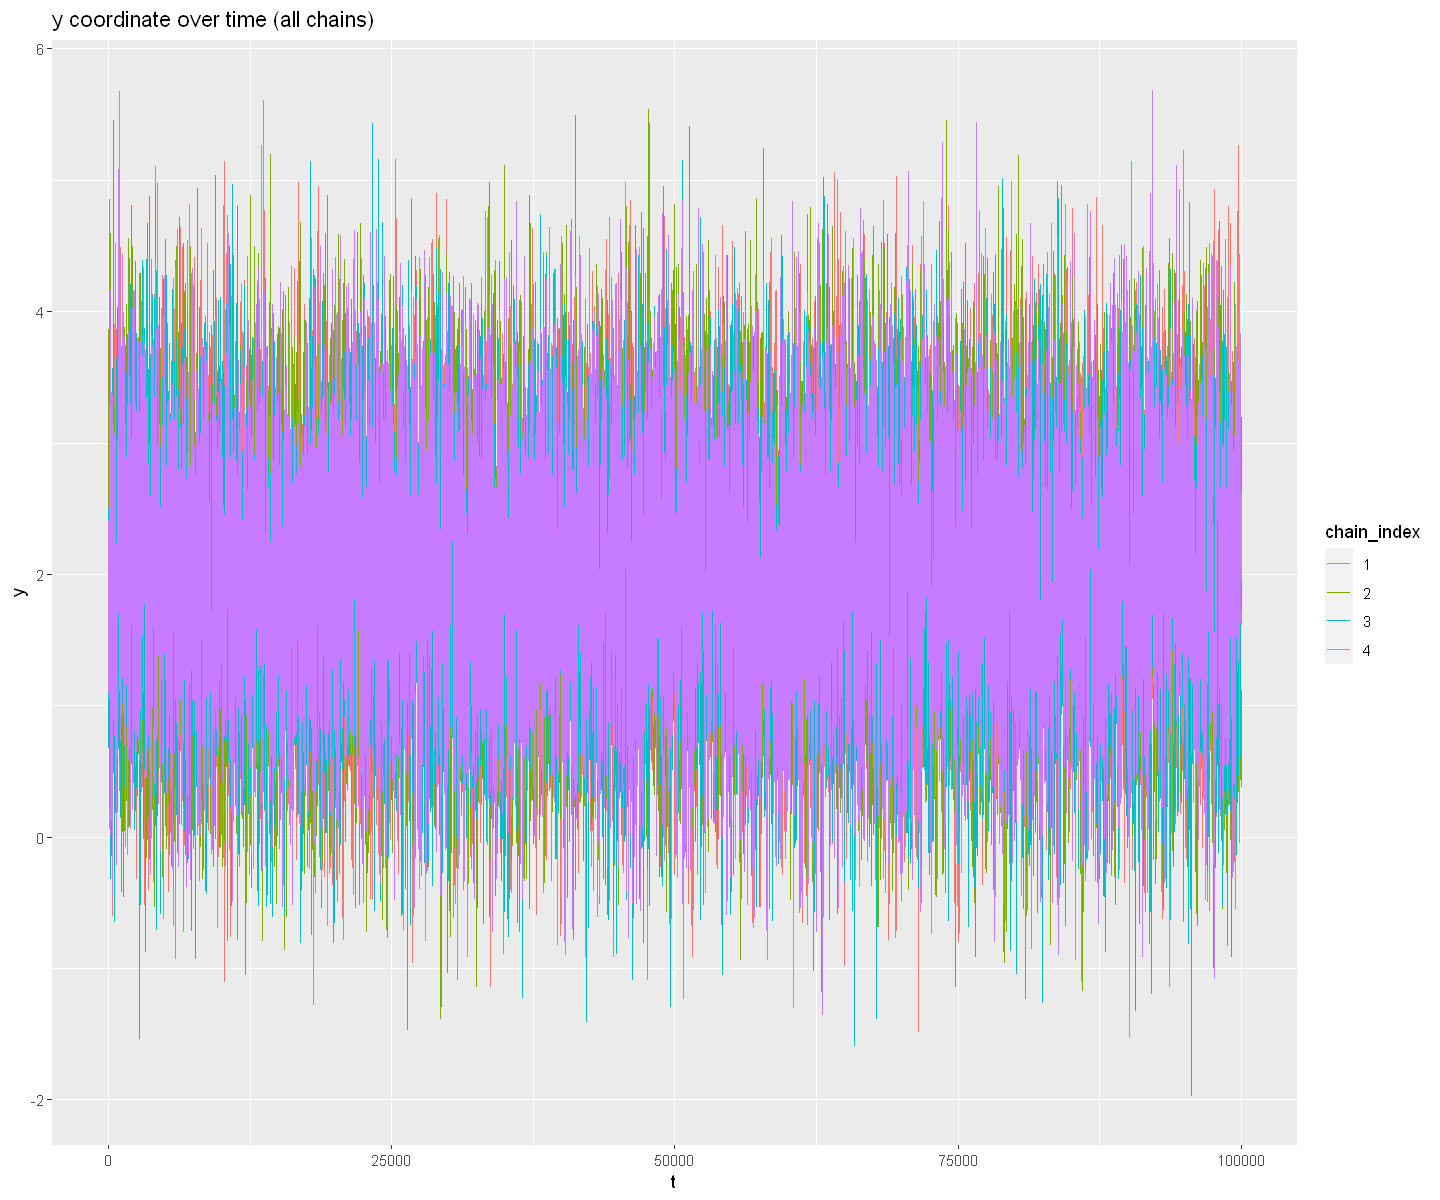

In [71]:
ggplot(mh_chains_df, aes(x = t, y = y, color = chain_index)) + geom_line() +
  ggtitle("y coordinate over time (all chains)")

The only information we can extract from these plot is in which interval both parameters usually lie, together with the history of each chain; it's impossible to tell whether/when convergence is reached, though. For this reason we plot a different quantity over time, i.e. the *trace of the log posterior*:
\begin{equation}
  \text{Tr}[\log P]_J (t) = - \frac{1}{t} \sum_{k=1}^t \log P(\vec{x}_k^J|D)
\end{equation}
where $J$ is the chain index, $\vec{x}_k$ is the $(x,y)^T$ vector at discrete time $k$ and $t$ is the discrete time at which we're evaluating the trace log posterior. This quantity is interesting because it's essentially the cumulative mean of the logarithm of the posterior, times $-1$ - and this is useful because the average has a smoothing effect on the curve, whereas the logarithm has a "normalizing" effect (in the sense that it reduces the difference between different orders of magnitude closer). The $-1$ is a convenience factor used to make this quantity positive, since $P < 1 \implies \log P < 0$.

Finally we notice that another advantage of using the above quantity is that it includes information about all dimensions in a single scalar quantity, so we no longer have to plot $x$ and $y$ separately.

In [72]:
# let us add the trace log post column

mh_chains_df_trace <- mh_chains_df |>
                        rowwise() |> # for each row...
                        mutate(log_posterior = log(posterior(c(x, y)))) |> # ...compute log(posterior(row))
                        group_by(chain_index) |> # within each chain...
                        mutate(Tr = -cummean(log_posterior)) |> # ...compute - cum. mean
                        select(- log_posterior) |> # finally we remove the log post. col.
                        ungroup()

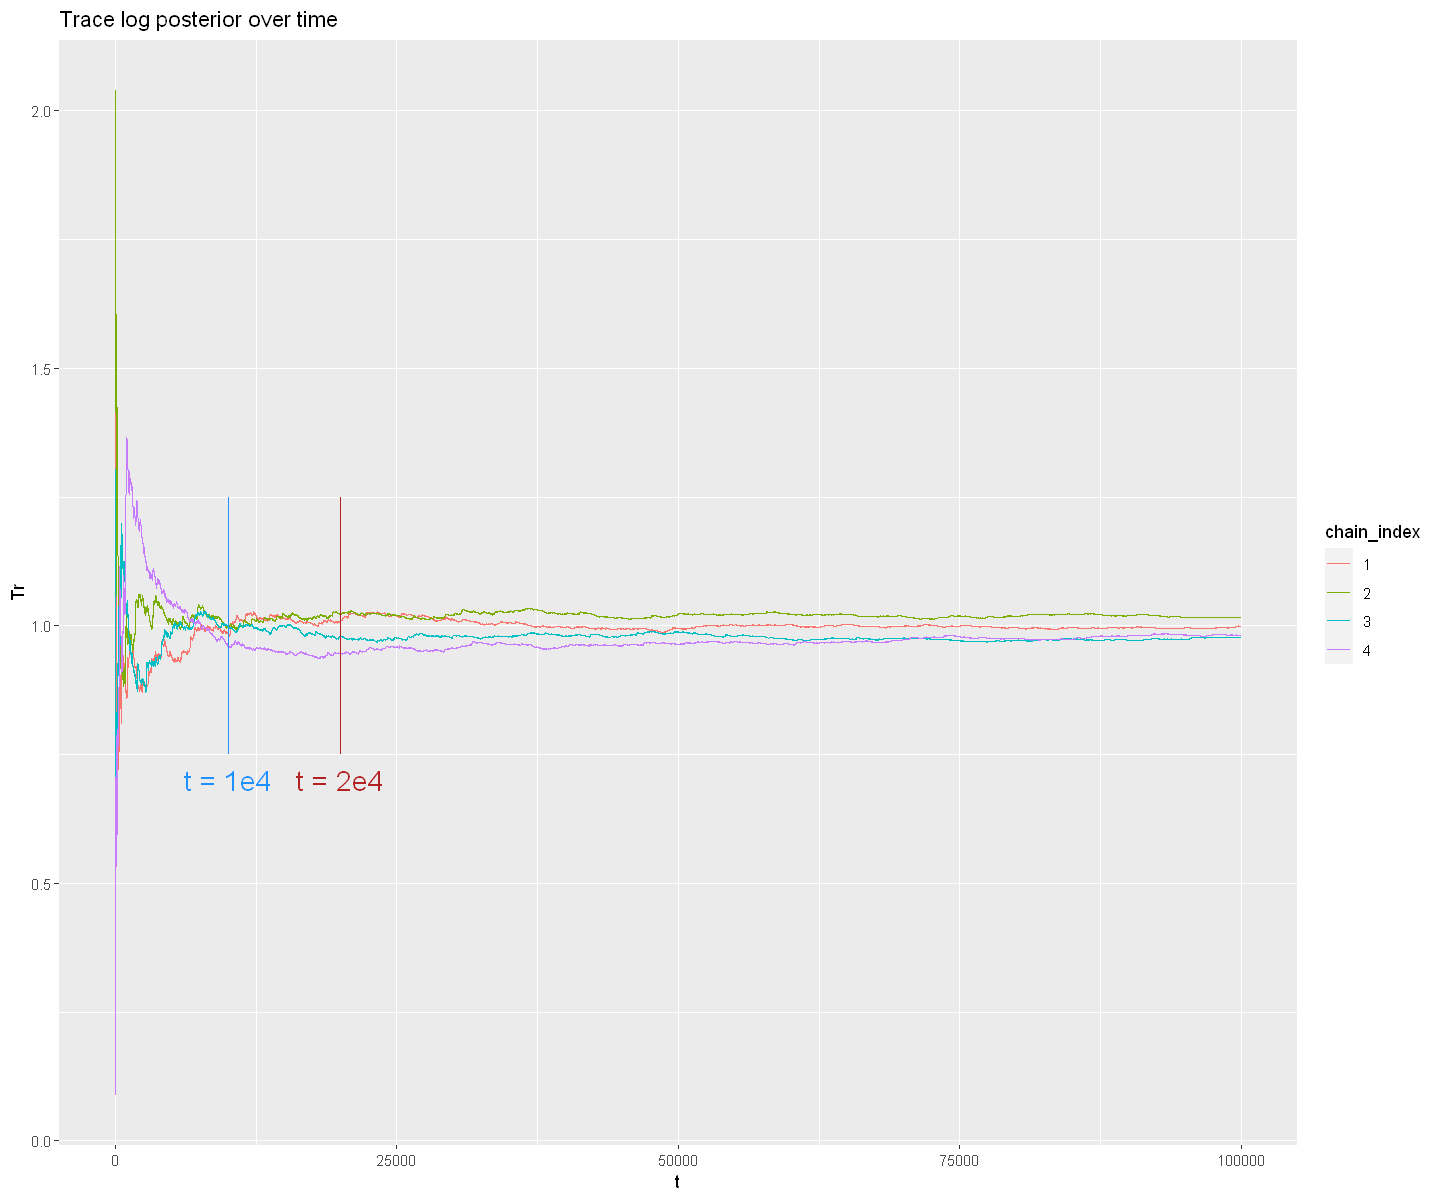

In [73]:
ggplot(mh_chains_df_trace, aes(x = t, y = Tr, color = chain_index)) +
  geom_line() +
  ggtitle("Trace log posterior over time") +
  annotate("segment", x = 2e4, xend = 2e4,
           y = 0.75, yend = 1.25, color =  "firebrick") +
  annotate("text", x = 2e4, y = 0.7, label = "t = 2e4",
           size = 6, color = "firebrick") +
  annotate("segment", x = 1e4, xend = 1e4,
           y = 0.75, yend = 1.25, color = "dodgerblue") +
  annotate("text", x = 1e4, y = 0.7, label = "t = 1e4",
           size = 6, color = "dodgerblue")

This graph is easier to interpret. We notice that in the beginning the trace plots are quite different - and rightfully so: the points with $P$ closer to $0$ will have a larger $-\log P$. We see that after a relatively short period of time the chains seem to converge to approximately the same value; this is exactly the end of the initial burn in phase. In particular we notice that the burn in ends about at $t$ equal to $10^4$ or $2\cdot 10^4$; let us repeat the plot with these early values removed.

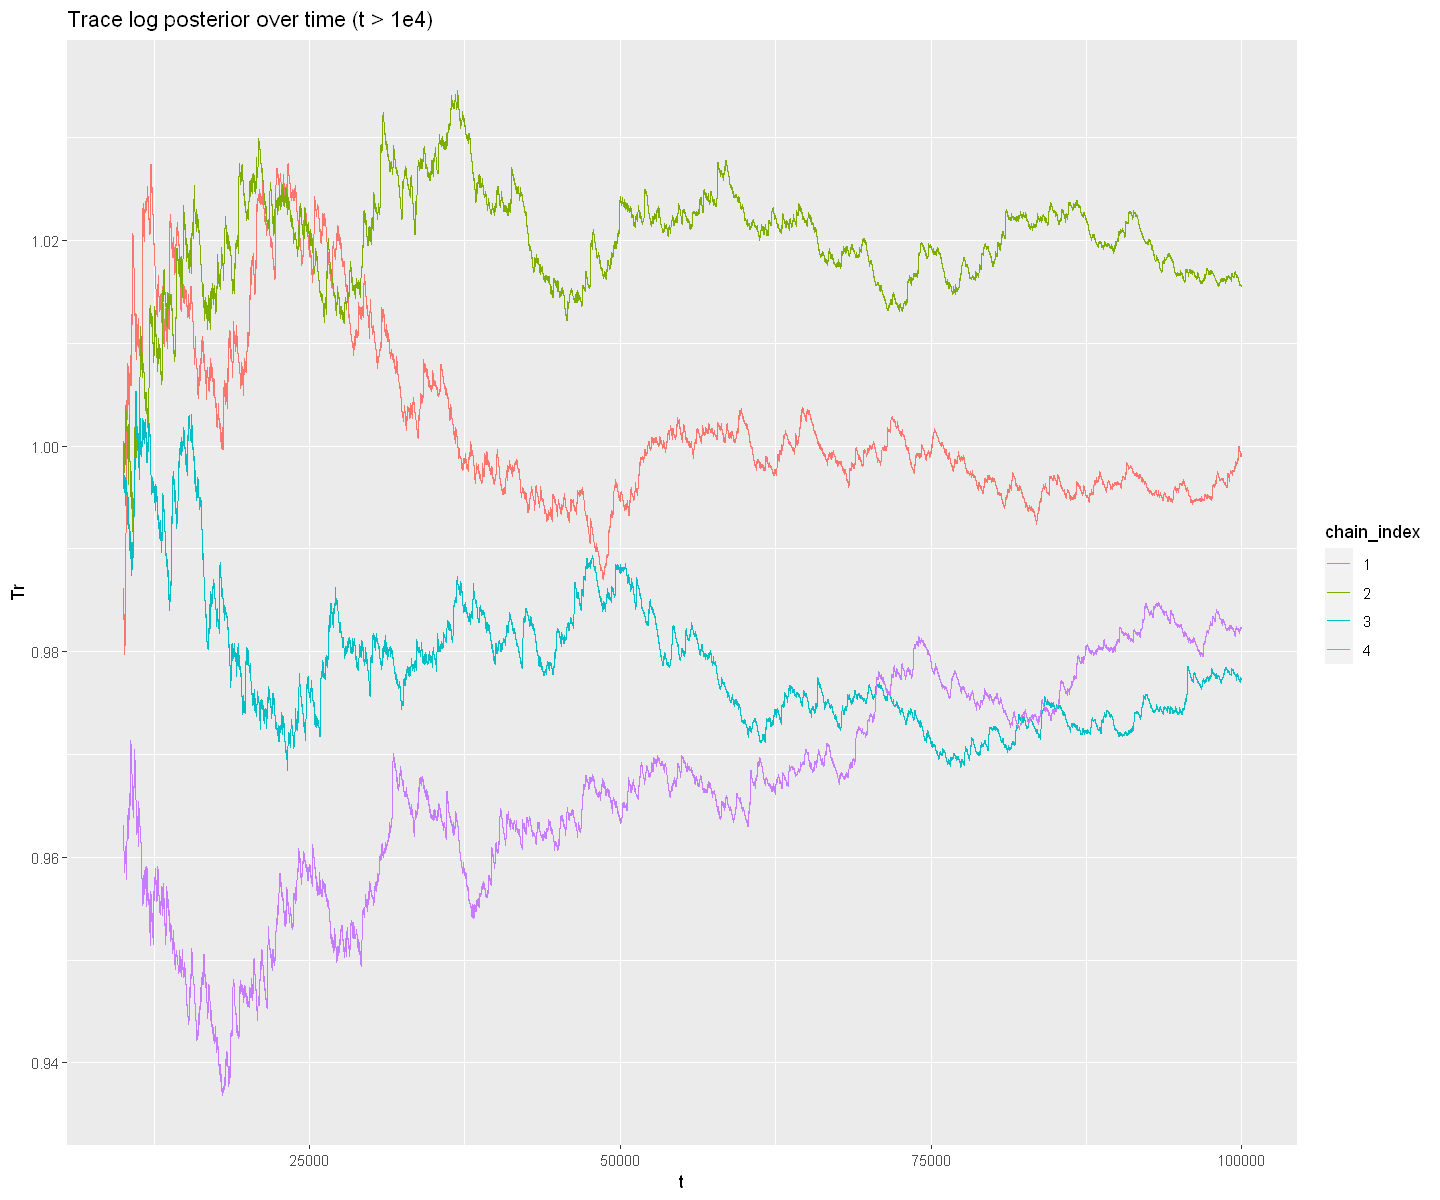

In [74]:
mh_chains_df_trace |> filter(t > 1e4) |>
  ggplot(aes(x = t, y = Tr, color = chain_index)) +
  geom_line() +
  ggtitle("Trace log posterior over time (t > 1e4)")

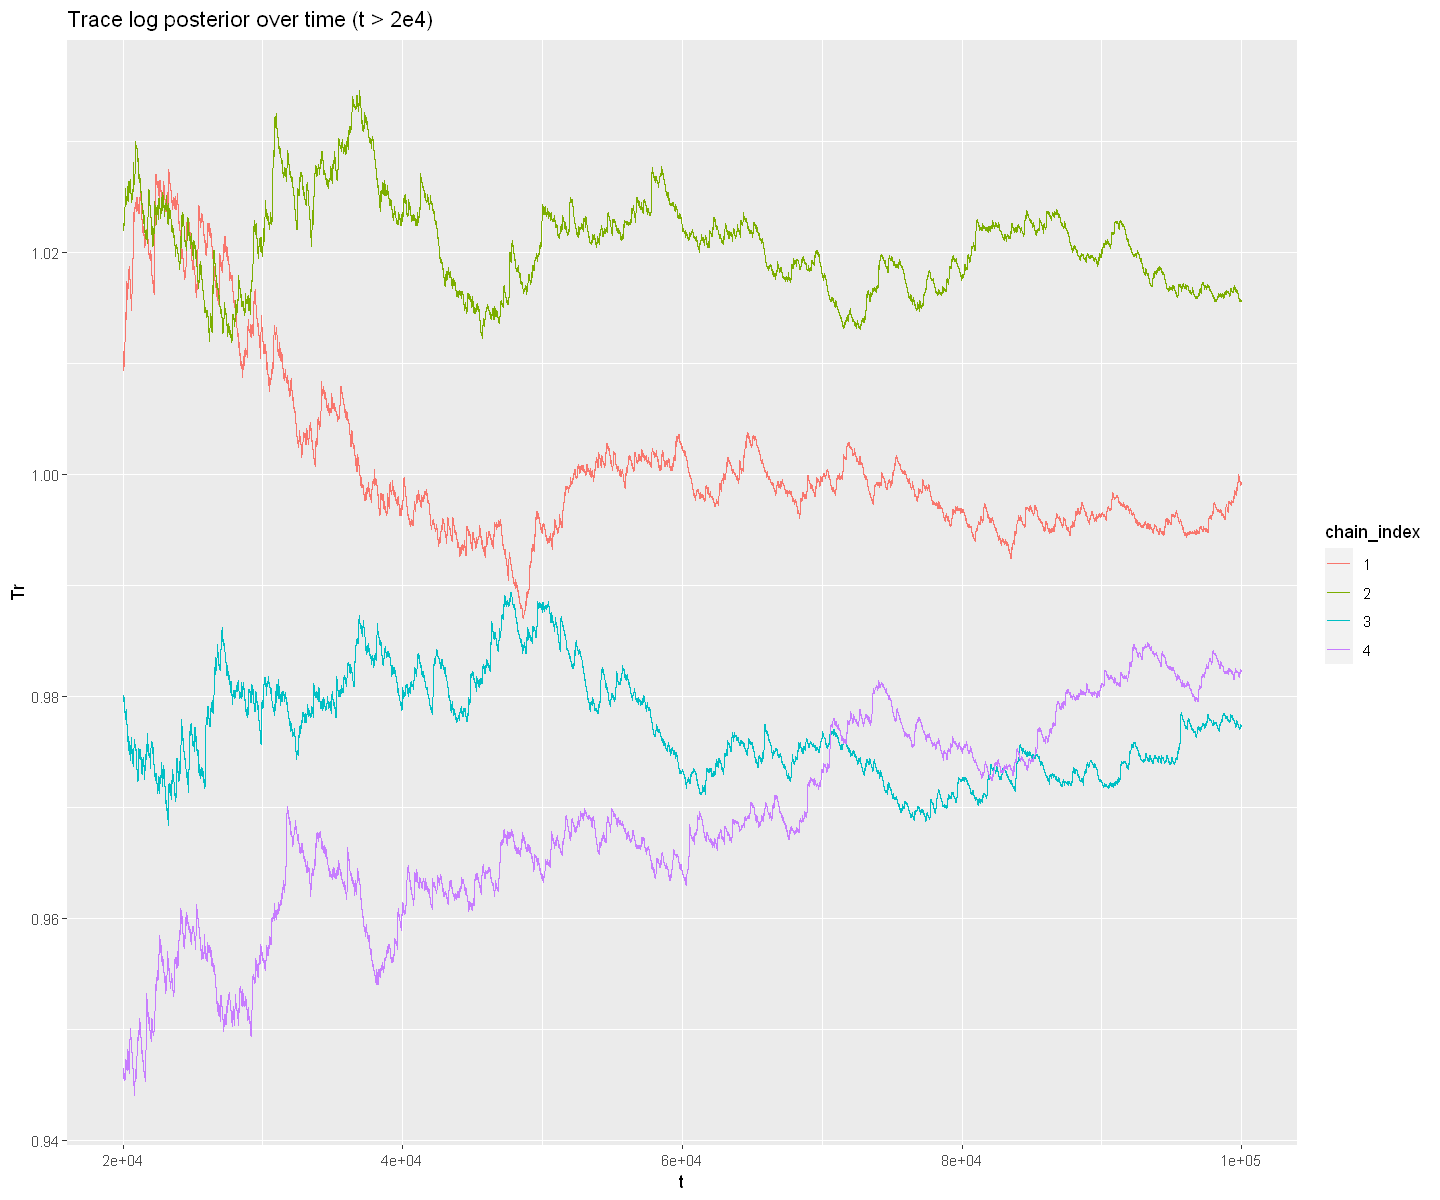

In [75]:
mh_chains_df_trace |> filter(t > 2e4) |>
  ggplot(aes(x = t, y = Tr, color = chain_index)) +
  geom_line() +
  ggtitle("Trace log posterior over time (t > 2e4)")

We notice that for $t > 10^4$ our chains all lie approximately in the $[0.94, 1.03] = 0.985 \pm 0.045$ interval. We can confidently say that our chains have "converged enough", since the width of the interval the trace plot lies is less than $10\%$ of the value of the mean.

From now on, then, we use this estimate based on the trace plot to trim our dataset by the first $10^4$ samples; the quality of this estimate will be revisited later via the GR test.

In [76]:
t_burn_in <- 1e4

mh_chains_df_trace_burn_in <- mh_chains_df_trace |>
                                filter(t > t_burn_in)

Our dataset is now probably ready to be actually consumed to compute marginals etc., but before we make some other checks/considerations.

### What about thinning?
As we mentioned multiple times there are some important theoretical results which guarantee that asymptotically samples from our chain gain independence; this means that in the beginning we are the furthest from true i.i.d. sampling, and get closer to it the more time goes on. Removing the burn in samples usually eliminates the phase with the highest dependence between samples - especially if the chain starts very far from the target distribution, in which case samples have to be strongly correlated as the chain is "attracted" to the target; and yet since our sample size is always finite there is always some intrinsic dependence leftover. A standard way to measure this is by using the *autocorrelation function*, which is able to compute the average correlation between samples distant $n$ steps in time. Let's quickly plot it e.g. for the $x$ parameter and the first chain:

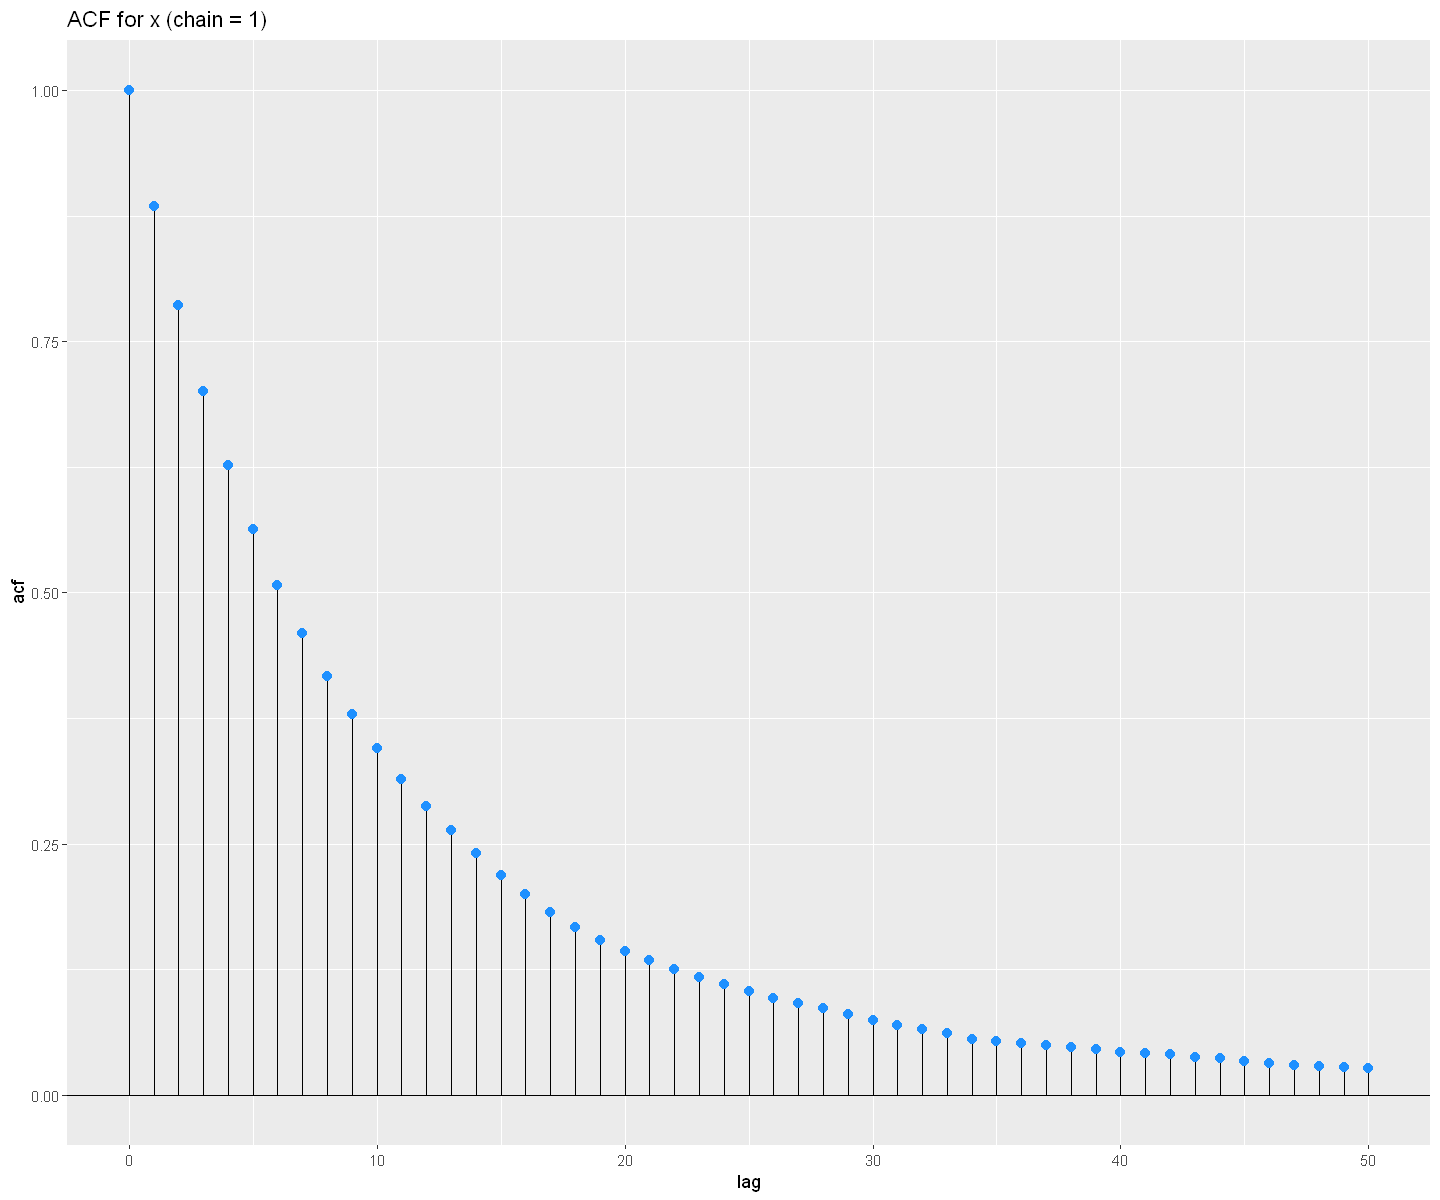

In [77]:
mh_chains_df_trace |> filter(chain_index == 1) |>
  pull(x) |> # extract x col.
  acf(plot = FALSE) |> # compute acf
  with(tibble(lag = lag, acf = acf)) |> # create ggplot friendly tibble
  ggplot(aes(x = lag, y = acf)) +
  geom_segment(mapping = aes(xend = lag, yend = 0)) +
  geom_hline(aes(yintercept = 0)) +
  ggtitle("ACF for x (chain = 1)") +
  geom_point(color = "dodgerblue", size = 2.5)

This plot doesn't change much even if we exclude burn in samples:

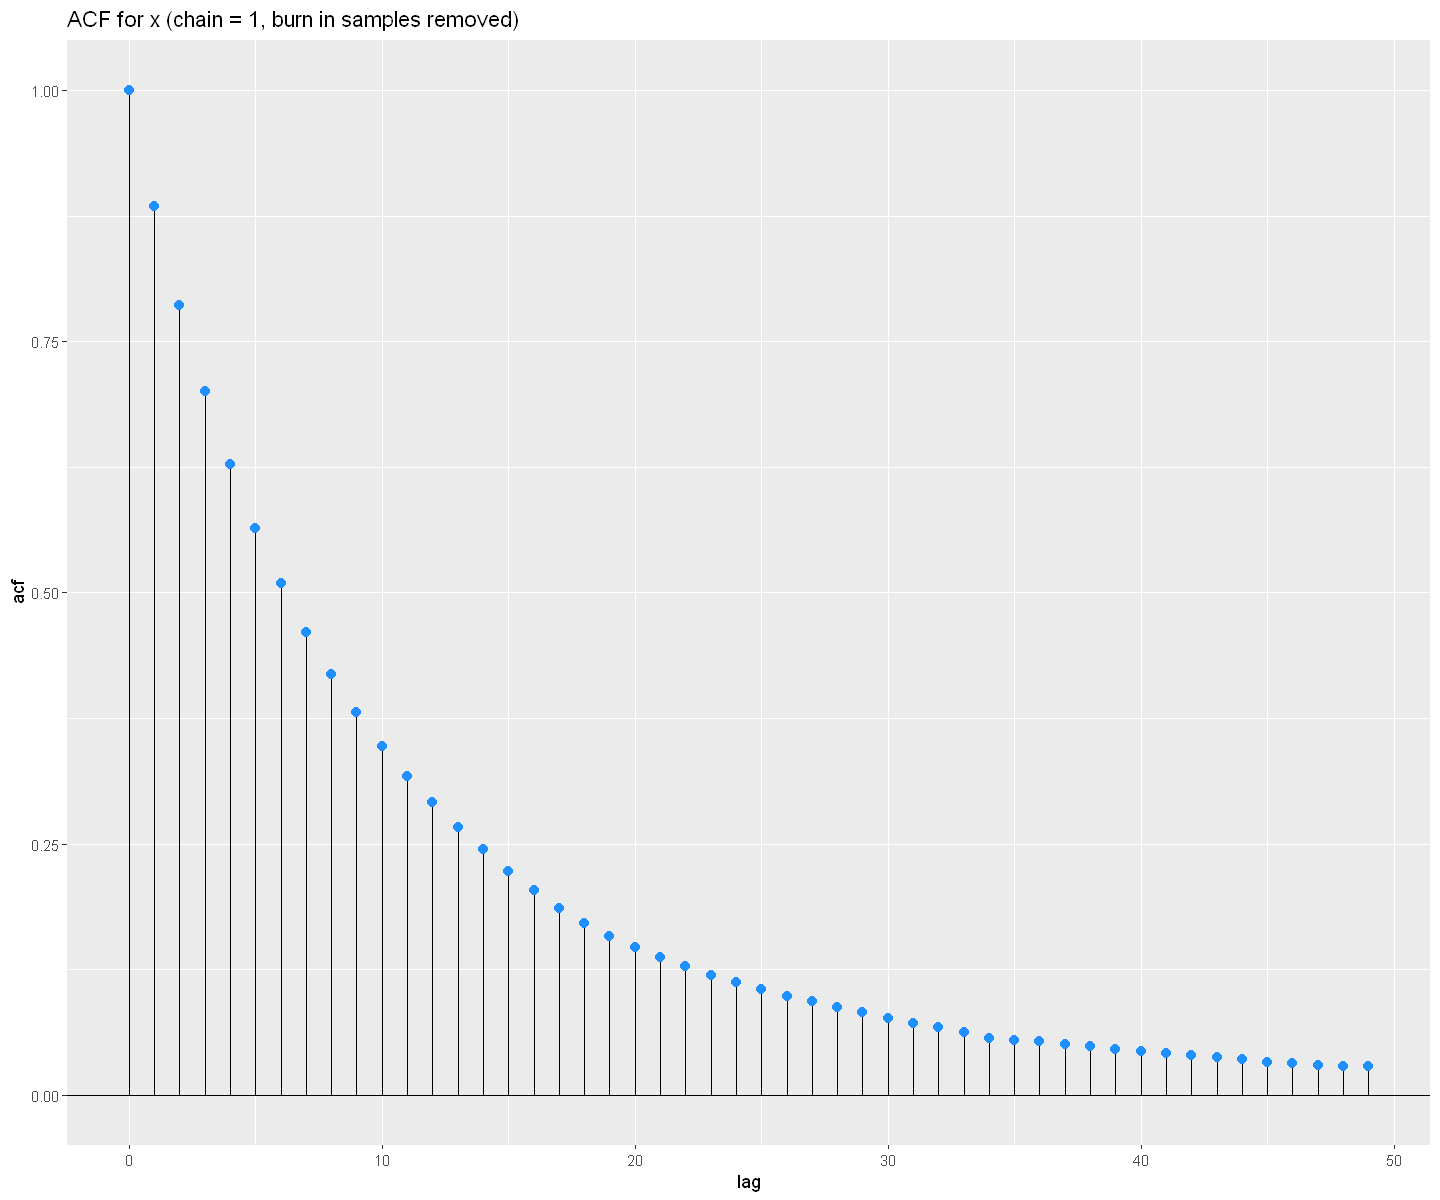

In [78]:
mh_chains_df_trace_burn_in |> filter(chain_index == 1) |>
  pull(x) |> # extract x col.
  acf(plot = FALSE) |> # compute acf
  with(tibble(lag = lag, acf = acf)) |> # create ggplot friendly tibble
  ggplot(aes(x = lag, y = acf)) +
  geom_segment(mapping = aes(xend = lag, yend = 0)) +
  geom_hline(aes(yintercept = 0)) +
  ggtitle("ACF for x (chain = 1, burn in samples removed)") +
  geom_point(color = "dodgerblue", size = 2.5)

This graph clearly shows that the leftover intrinsic correlation between samples greatly decreases on average if samples are e.g. 10 or 20 places apart in the chain. For this reason we may be tempted to apply *thinning*, i.e. to remove all samples in between samples with indices $n, n+20, n+40,\dots$, thus giving the chain time to "forget" the correlation between samples. We notice that in fact doing this "by default" is a bad idea, because it greatly reduces dataset size; indeed e.g. to achieve a lag of 20 we'd have to discard $19/20$ of our dataset, which is wildly inefficient. Discarding so many samples also has the side effect of potentially reducing estimates accuracy much more than we'd gain by reducing inter samples dependence, since a small dataset leasds to worse estimates. This is actually the main point of [this article](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x), and for this reason we avoid thinning here.

### Gelman Rubin test
We mentioned before that after burn in ideally the chains converge to approximately the same averages/variances; that's why we used trace plot to look for an index $t$ after which this condition is satisfied. Of course more complex scenarios are possible (incomplete mixing, multimodal posteriors), so the correlation between burn in and mean/var. convergence is not always obvious - hence why one usually employs other, more precise tests. One such test is the *Gelman Rubin* one, which is built upon the same idea as our trace plot techinque: if all goes well mean chains should have similar averages and variances. In particular the test consists of estimating inter and intra means/variances and comparing these estimates with a "score" parameter; let us illustrate how to compute this final score (without all the derivation details). The steps for a single parameter are the following:

1. Compute each chain's mean, $\hat{\theta}^J$ - where $J$ is the chain index and $N$ the number of points in each chain, and $\theta$ is either $x$ or $y$ in our case.

2. Compute the intrachain variances $w^J$.

3. Compute the average of the chains' means, $\hat{\theta}_{\text{tot}}$.

4. Compute how the individual means vary around the joint mean ($N$ = number of points per chain, $M$ = number of chains), times a constant:
\begin{equation}
b \equiv \frac{B}{N} = \frac{1}{M - 1} \sum_{J = 1}^M (\hat{\theta}^J - \hat{\theta}_{\text{tot}})^2
\end{equation}

5. Compute the average of the chains' variances:
\begin{equation}
W = \frac{1}{M}\sum_{J=1}^M w^J
\end{equation}

6. Compute the quantity
\begin{equation}
V = \frac{N-1}{N}W + \frac{M+1}{M} b
\end{equation}

7. Finally compute
\begin{equation}
R = V / W
\end{equation}

The above value $R$ is a scalar and convergence is achieved for $R\approx 1$. Since we have two unknown parameters we'll simply repeat the test for $x$ and $y$.

In [79]:
gr_test <- function(chains_df, M = 4, N = n_points_mh) {
    theta_J   <- chains_df |>
                   group_by(chain_index) |>
                   summarize(x = mean(x))
    theta_tot <- theta_J |>
                   summarize(x = mean(x)) |>
                   pull(x)
    theta_J   <- theta_J |> pull(x)

    b <- sum((theta_J - theta_tot)^2) / (M - 1)
    W <- chains_df |>
           group_by(chain_index) |>
           summarize(x = var(x)) |>
           summarize(x = mean(x)) |>
           pull(x)
    V <- W * (N - 1) / N + b * (M + 1) / M
    R <- V / W
    return(R)
}

In [80]:
print("gr test x:")
R_x <- mh_chains_df_trace_burn_in |>
         select(- y) |>
         gr_test() |>
         print()

cat("\n")
print("difference with 1:")
print(R_x - 1)

[1] "gr test x:"
[1] 1.000531

[1] "difference with 1:"
[1] 0.0005306957


In [81]:
print("gr test y:")
R_y <- mh_chains_df_trace_burn_in |>
         select(- x) |>
         rename(x = y) |>
         gr_test() |>
         print()

cat("\n")
print("difference with 1:")
print(R_y - 1)

[1] "gr test y:"
[1] 1.000629

[1] "difference with 1:"
[1] 0.0006287362


As we can see the value of both $R_x - 1$ and $R_y - 1$ is very close to zero; hence the GR test suggests convergence has been reached. We are content with this result and decide we can start analyzing the dataset with no further diagnostics - but before that just to be sure we also use the `coda` library to compute $R_x$ and $R_y$.

In [82]:
mh_list_coda <- list()
for (i in 1:4) {
    mh_list_coda[[i]] <- mh_chains_df_trace_burn_in |>
                           filter(chain_index == i) |>
                           select(c(x, y)) |>
                           as.matrix() |>
                           coda::mcmc()
}
mh_list_coda <- coda::mcmc.list(mh_list_coda)
coda::gelman.diag(mh_list_coda, autoburnin = FALSE)
# the decimal part isn't even printed, which is consistent
# with the previous results.

Potential scale reduction factors:

  Point est. Upper C.I.
x          1          1
y          1          1

Multivariate psrf

1

### GR and burn in
An interesting thing to notice before moving on is that we can also compute $R$ as a function of time; this gives us a more quantitative way to "decide" when burn in is over. Let us plot $R_x$ and $R_y$ against time without excluding the first $10^4$ as before.

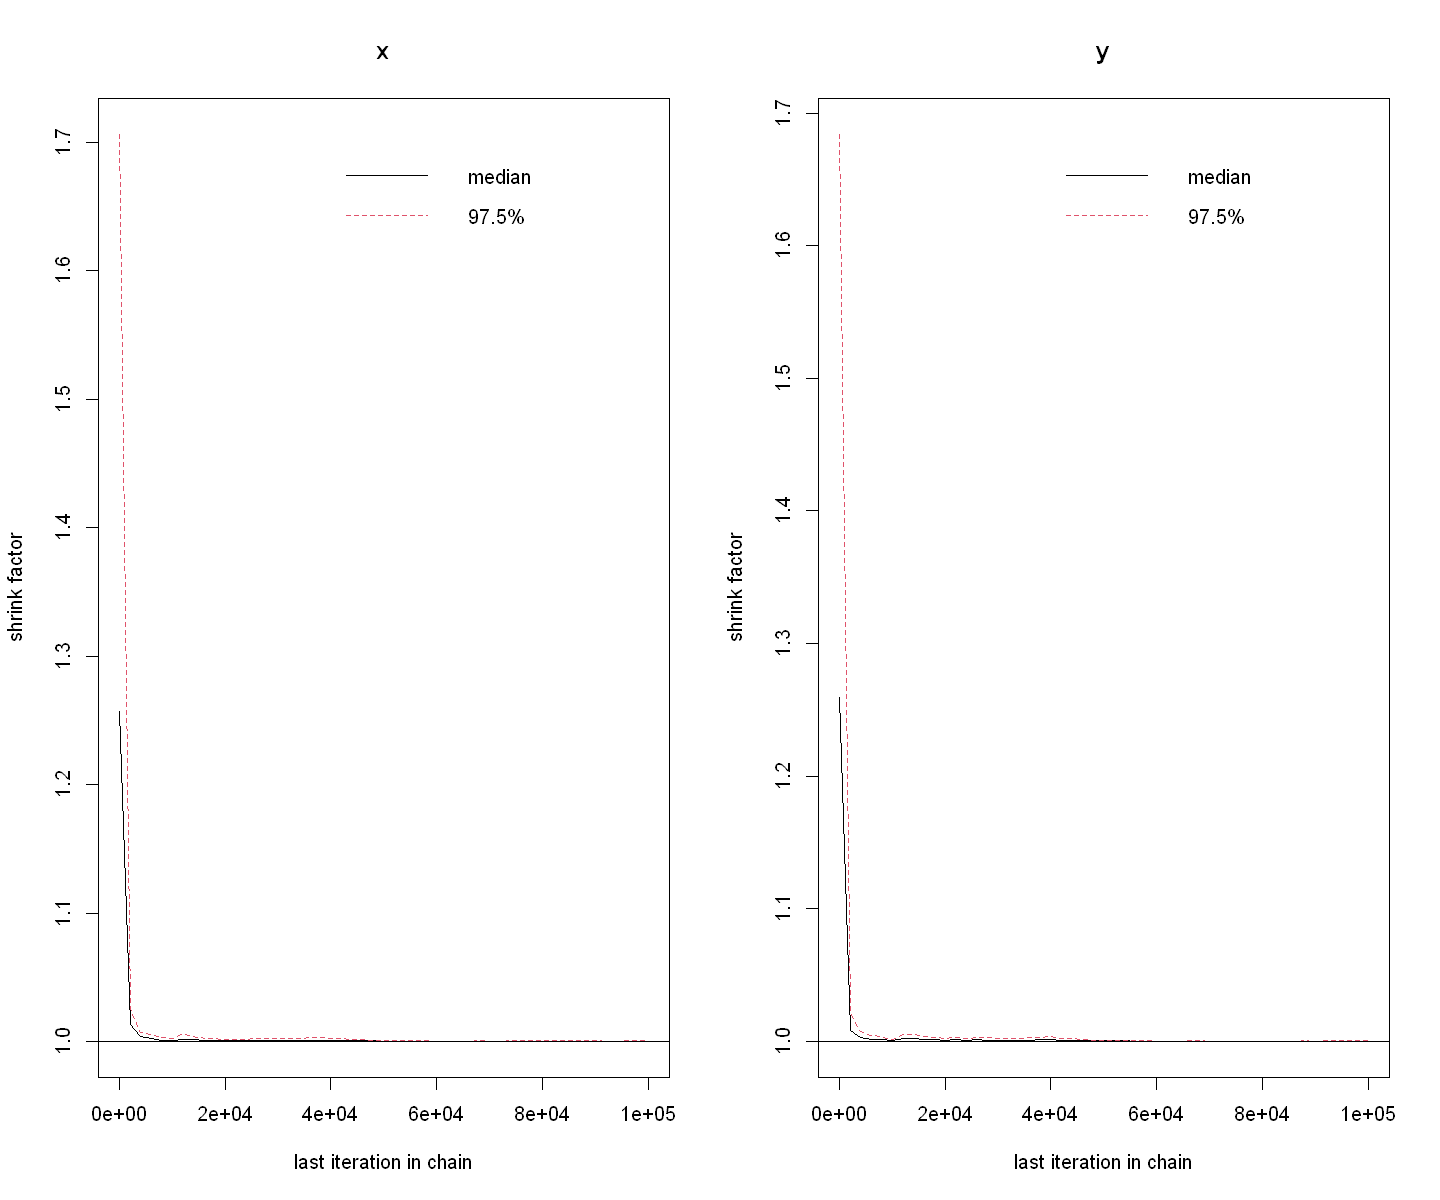

In [83]:
mh_list_coda_with_burn_in <- list()
for (i in 1:4) {
    mh_list_coda_with_burn_in[[i]] <- mh_chains_df_trace |>
                                        filter(chain_index == i) |>
                                        select(c(x, y)) |>
                                        as.matrix() |>
                                        coda::mcmc()
}
mh_list_coda_with_burn_in <- coda::mcmc.list(mh_list_coda_with_burn_in)
gr_mh_plot <- coda::gelman.plot(mh_list_coda_with_burn_in, autoburnin = FALSE)

We clearly see that our chains converge quite quickly, as observed with the trace plot; clearly this is a result of the smart choice of the proposal covariance and initial points (all "inside" the distribution). To better see when $R$ becomes close enough to 1 let us repeat the above plot, but this time with $R - 1$ in log scale.

In [84]:
gr_mh_plot_tibble <- as_tibble(gr_mh_plot$shrink) |>
                       mutate(t = gr_mh_plot$last.iter) |>
                       rename(x_median = x.median, y_median = y.median,
                              "x_97.5%" = "x.97.5%", "y_97.5%" = "y.97.5%") |>
                       pivot_longer(!t, names_to = "R_type", values_to = "R") |>
                       select(c(t, R, R_type)) |>
                       mutate("R-1" = R - 1)

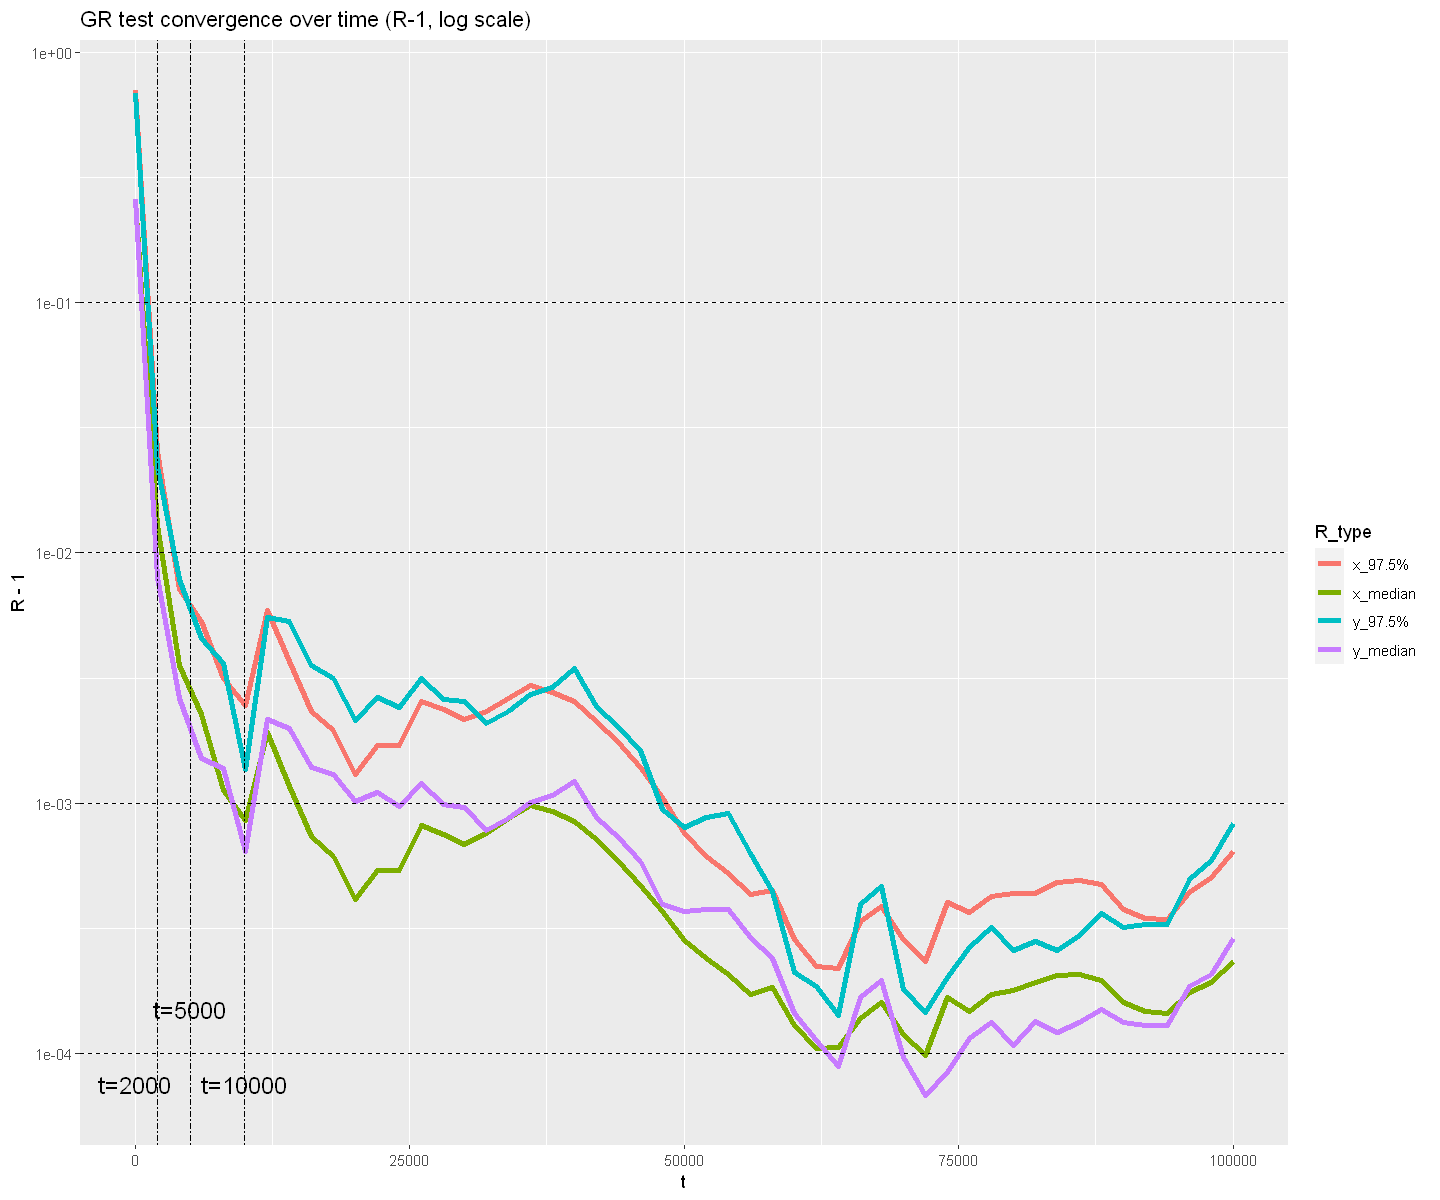

In [85]:
ggplot(gr_mh_plot_tibble, aes(x = t, y = R-1, color = R_type)) +
  geom_line(lwd = 1.5) +
  scale_y_log10() +
  geom_hline(yintercept = 10 ^ (- (1:4)), linetype = "dashed") +
  ggtitle("GR test convergence over time (R-1, log scale)") +
  geom_vline(xintercept = c(2, 5, 10) * 1e3, linetype = "twodash") +
  annotate("text", x = 0, y = 0.75e-4, label = "t=2000", size = 5) +
  annotate("text", x = 5e3, y = 1.5e-4, label = "t=5000", size = 5) +
  annotate("text", x = 1e4, y = 0.75e-4, label = "t=10000", size = 5)

Whether we look at $x$ or $y$ we can confirm $R - 1$ becomes smaller than $0.01$ almost immediately. To be more precise we can print the first few values of the above plot.

In [86]:
gr_mh_plot$shrink[1:10, c("x", "y"), "median"] - 1

,x,y
51,0.2570815739,0.2592802717
2050,0.0128476408,0.0080144740
4049,0.0035611597,0.0026188726
6048,0.0022688411,0.0015123802
8047,0.0011246093,0.0013777750
10046,0.0008517252,0.0006396202
12045,0.0019134746,0.0021517302
14044,0.0011623711,0.0019871211
16043,0.0007322472,0.0013901443
18042,0.0006102645,0.0012969313


From the above dataframe we infer that our original estimate of $t_{\text{burn-in}} = 10^4$ was quite conservative; indeed with that estimate $R-1 < 10^{-3}$, whereas one may be satisfied with e.g. $R$ only two decimal places away from 1 (and this holds whether we look at $x$ or $y$).

Since we are in no shortage of data samples we retain the original value for $t_{\text{burn-in}}$, simply noting that this is another possible way of dealing with the situation.

## Marginalization with MH generated dataset
Once we obtained a reliable enough "empirical" dataset we can repeat evey analysis done with the Cholesky dataset. Let us start with reobtaining the marginal distributions and the $95\%$ credibility intervals.

As done with the Cholesky dataset we first plot the two marginal distributions (histograms with kde superimposed) on top of the MH dataset.

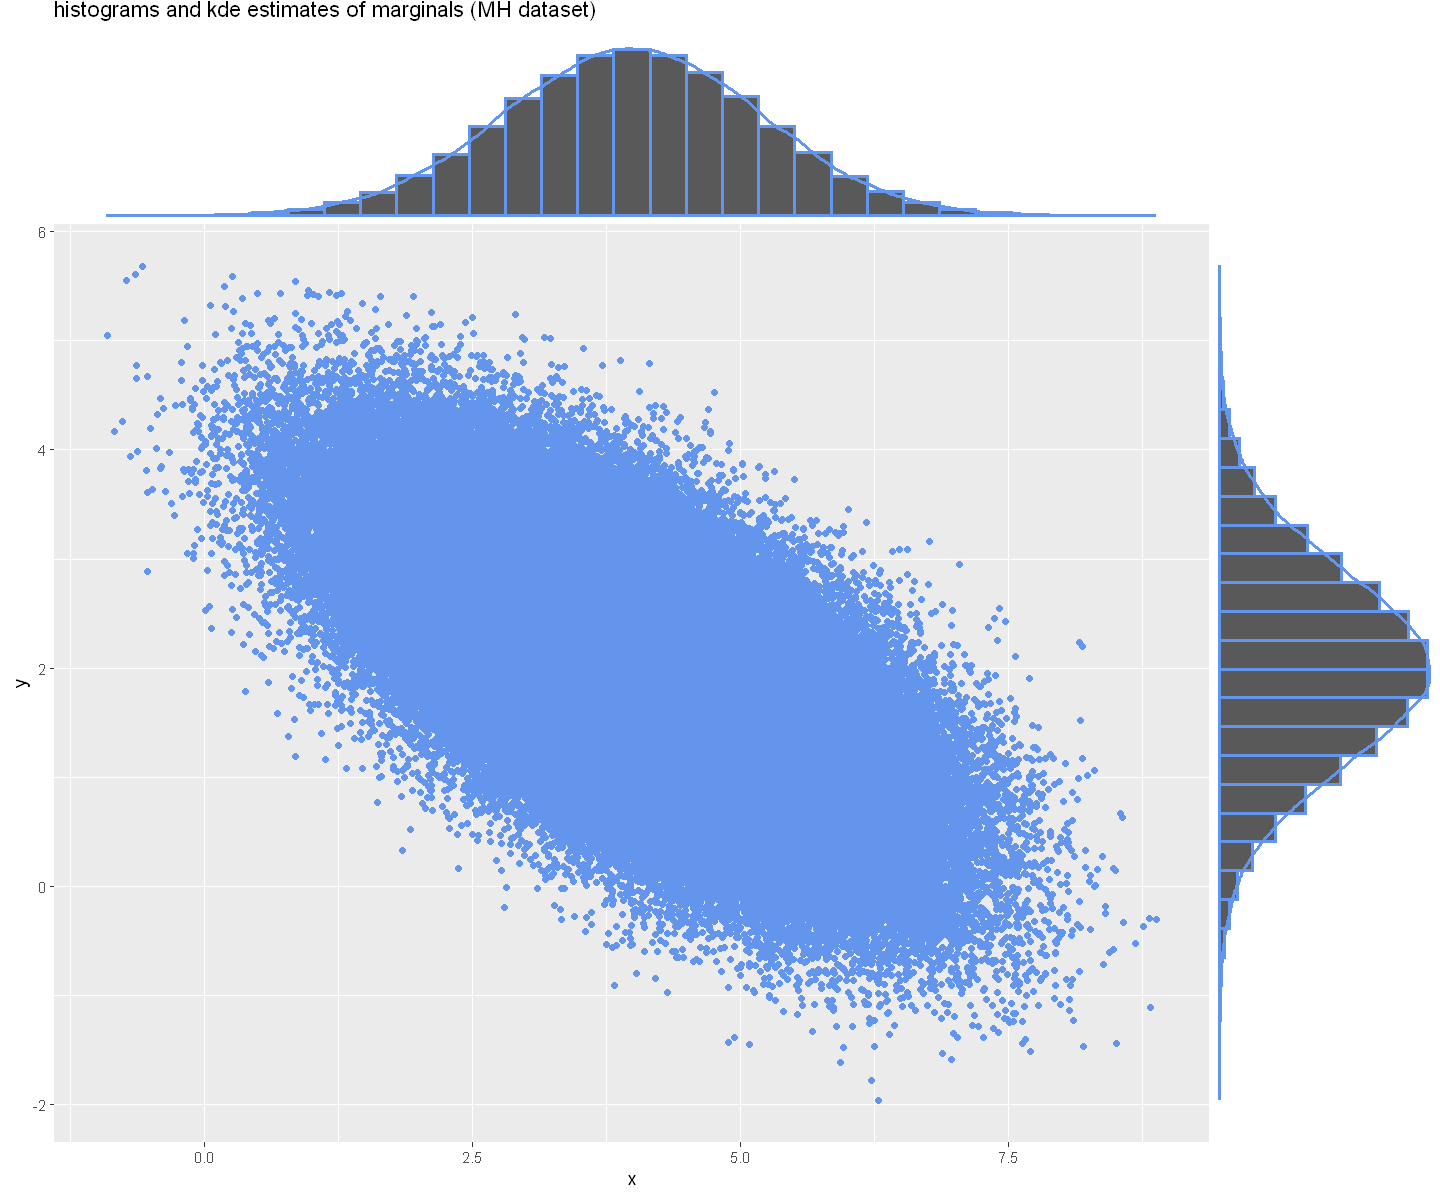

In [87]:
ggExtra::ggMarginal(ggplot(mh_chains_df_trace_burn_in, aes(x, y)) +
                    geom_point(color = "cornflowerblue") +
                    ggtitle("histograms and kde estimates of marginals (MH dataset)"),
                    type = "densigram", color = "cornflowerblue", lwd = 1)

### $x$ MH marginal
As done before we now plot the empirical histogram and kde compared with the theoretical distribution.

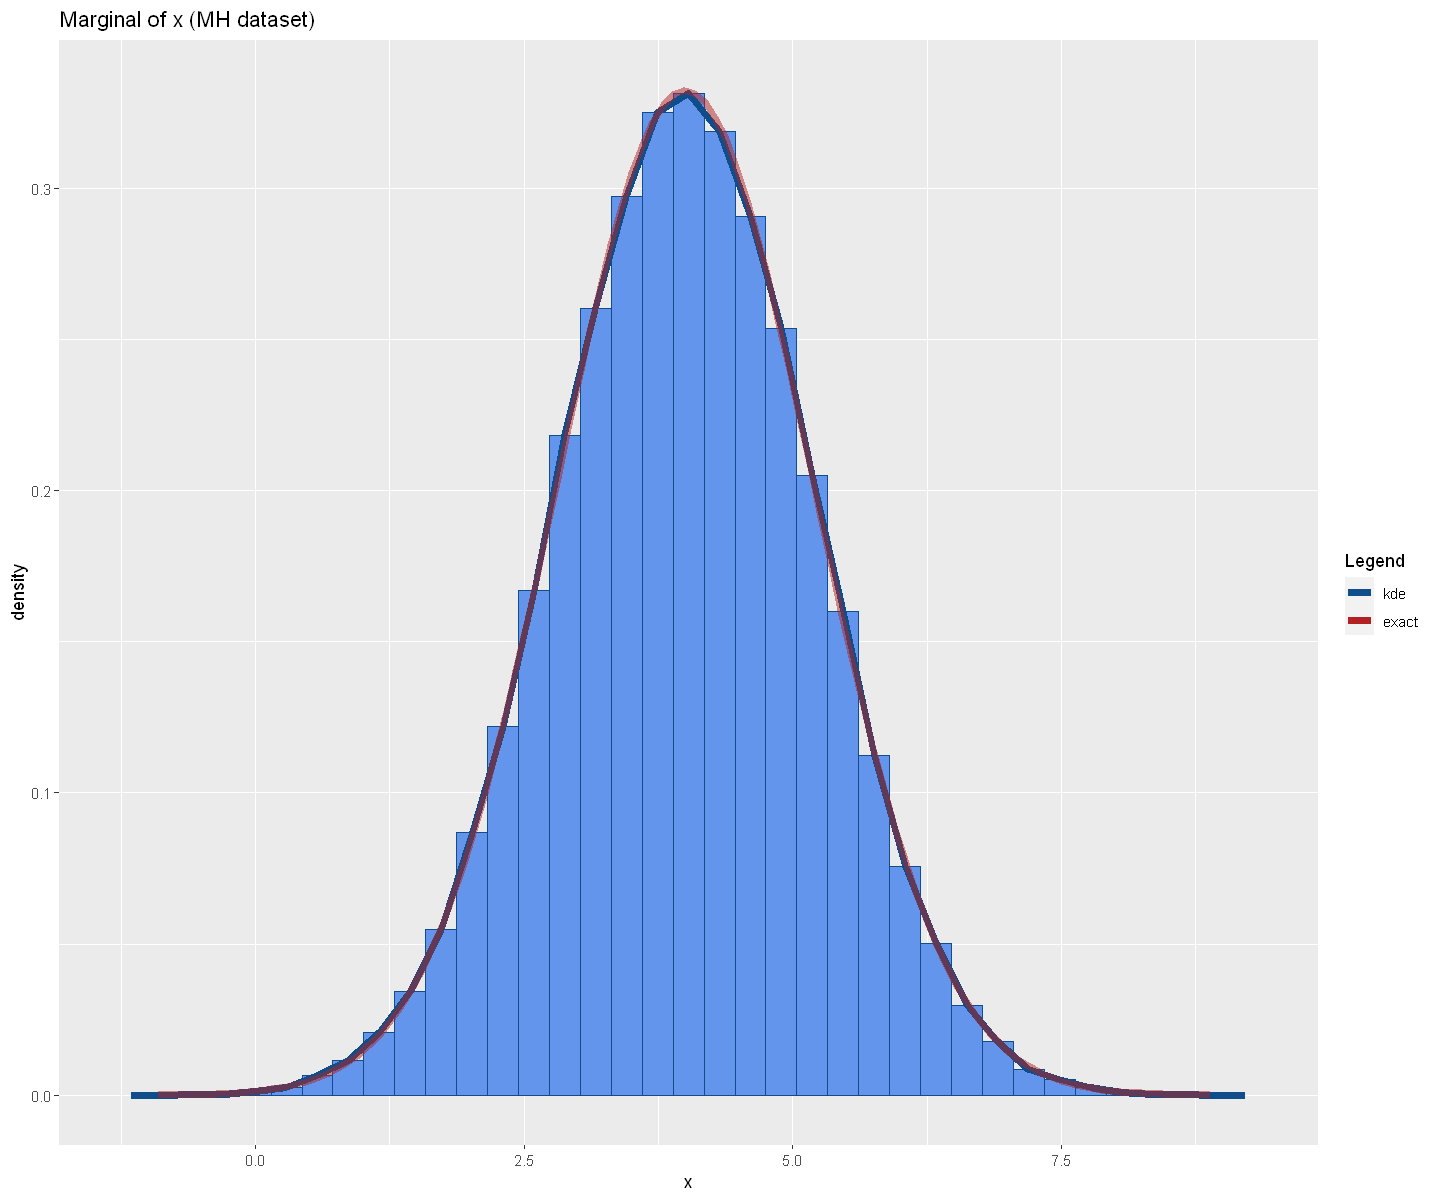

In [88]:
ggplot(mh_chains_df_trace_burn_in) +
  geom_histogram(aes(x = x, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = x, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_x, sd = sigma_x),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle("Marginal of x (MH dataset)") +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

As in the Cholesky case the overlap is almost perfect. This can be confirmed by computing the KL divergence between the two distributions, as usual.

In [89]:
print("Mean KLD between MH & exact x marginal:")
print(kld_sampled_exact_distribution(mh_chains_df_trace_burn_in$x, mu_x, sigma_x))

[1] "Mean KLD between MH & exact x marginal:"
[1] 0.0001920398


As in the Cholesky case we obtain a KL smaller than $10^{-3}$, which confirms the goodness of the overlap.

#### MH $95\%$ credibility interval for $x$
##### Estimate via histograms
Our first method for computing areas is approximating them using the histogram - and as we showed before this essentially accounts to computing ratios of count values.

In [90]:
cov_mh_df <- mh_chains_df_trace_burn_in |> select(c(x, y)) |> cov()
cov_mh_df

,x,y
x,1.4315893,-0.6946131
y,-0.6946131,0.8022582


In [91]:
# we estimate the max using kde
max_mh_x <- density(mh_chains_df_trace_burn_in$x, n = 1024)$x[which.max(density(mh_chains_df_trace_burn_in$x, n = 1024)$y)]

# since the distribution is approximately gaussian we expect that
# the mean ± 2 sigma rule should still be approximately valid;
# this gives us a simple starting point, i.e. we can tweak a parameter
# k until we find a desired 95% interval of the kind mean ± k sigma
k_x_mh_marginal <- 1.671
x1_mh <- max_mh_x - k_x_mh_marginal * cov_mh_df[1, 1]
x2_mh <- max_mh_x + k_x_mh_marginal * cov_mh_df[1, 1]

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("MH: area of x's marginal between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              x1_mh, x2_mh, k_x_mh_marginal))
mean((x1_mh < mh_chains_df_trace_burn_in$x) & (mh_chains_df_trace_burn_in$x < x2_mh)) |> print()

[1] "MH: area of x's marginal between 1.57 and 6.36 (argmax ± 1.67 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9542361


In [92]:
print("theoretical 95% credibility interval for x:")
print(sprintf("[%.2f, %.2f]", x1, x2))

[1] "theoretical 95% credibility interval for x:"
[1] "[1.60, 6.40]"


Once again we find that the 95% interval has the same length of about $2\sigma_{\text{th}}$, and that this is what explains the particular value of $k$ found above - as we show below:

In [93]:
print(sprintf("ratio between theoretical and MH empirical sigma_x = %f", cov_mh_df[1, 1] / sigma_x))
print(sprintf("2/%.3f = %f", k_x_mh_marginal, 2 / k_x_mh_marginal))

[1] "ratio between theoretical and MH empirical sigma_x = 1.192991"
[1] "2/1.671 = 1.196888"


We also find a similar result as in the Cholesky case - namely that since the peak is shifted by about $0.04$ units to the left the whole interval is, too (with overall the same length/shape, as explained above). This is shown in the next cell.

In [94]:
print(sprintf("center of MH empirical x marginal = %.2f", max_mh_x))
print(sprintf("center of theoretical x marginal = %.2f", mu_x))

[1] "center of MH empirical x marginal = 3.96"
[1] "center of theoretical x marginal = 4.00"


Interestingly we found almost exactly the same values as in the Cholesky part - the only difference being that the peak was slightly shifted in the other direction.

#### Estimate via kde
We now recompute the area using a continuous instead of a discrete approximation - namely, via kde.

In [95]:
cat(sprintf("MH: area of x's marginal between %.2f and %.2f (mean ± %.2f * std):",
            x1_mh, x2_mh, k_x_mh_marginal))
integrate(\ (x) approxfun(density(mh_chains_df_trace_burn_in$x))(x),
          x1_mh, x2_mh)
# it's essentially the same area estimate

MH: area of x's marginal between 1.57 and 6.36 (mean ± 1.67 * std):

0.9546823 with absolute error < 1.8e-05

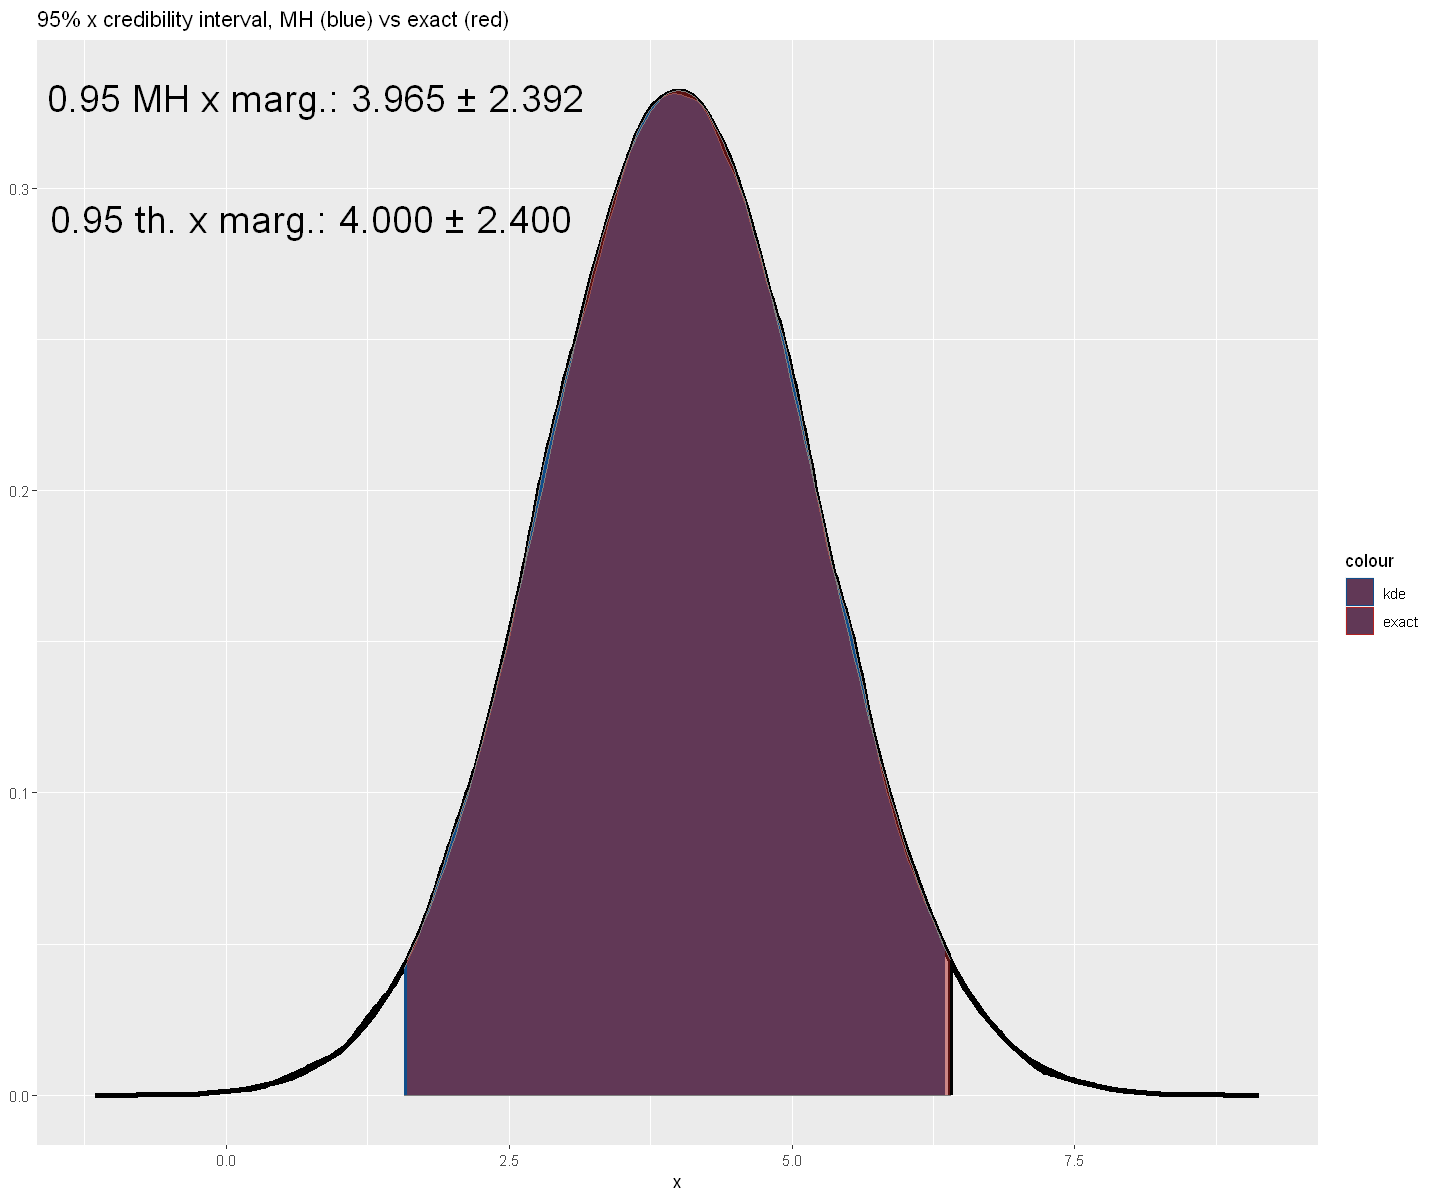

In [96]:
ggplot() + geom_line(data = marginal_x_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = x1, xend = x1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2, xend = x2, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(mh_chains_df_trace_burn_in$x)$x,
                              y = density(mh_chains_df_trace_burn_in$x)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(mh_chains_df_trace_burn_in$x))(.x),
                xlim = c(x1_mh, x2_mh),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x, sd = sigma_x),
                xlim = c(x1, x2),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x credibility interval, MH (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = 0.8, y = 0.33,
           label = sprintf("0.95 MH x marg.: %.3f ± %.3f",
           max_mh_x, k_x_mh_marginal * cov_mh_df[1, 1]), size = 8) +
  annotate("text", x = 0.75, y = 0.29,
           label = sprintf("0.95 th. x marg.: %.3f ± %.3f",
           mu_x, 2 * sigma_x), size = 8)

This allows us to appreciate the nice agreement and that the kde peak is shifted slightly to the left, and that this explains the overall interval shift.

### $y$ MH marginal
We start with the usual introduction: the kde + histogram plot and the KLD computation.

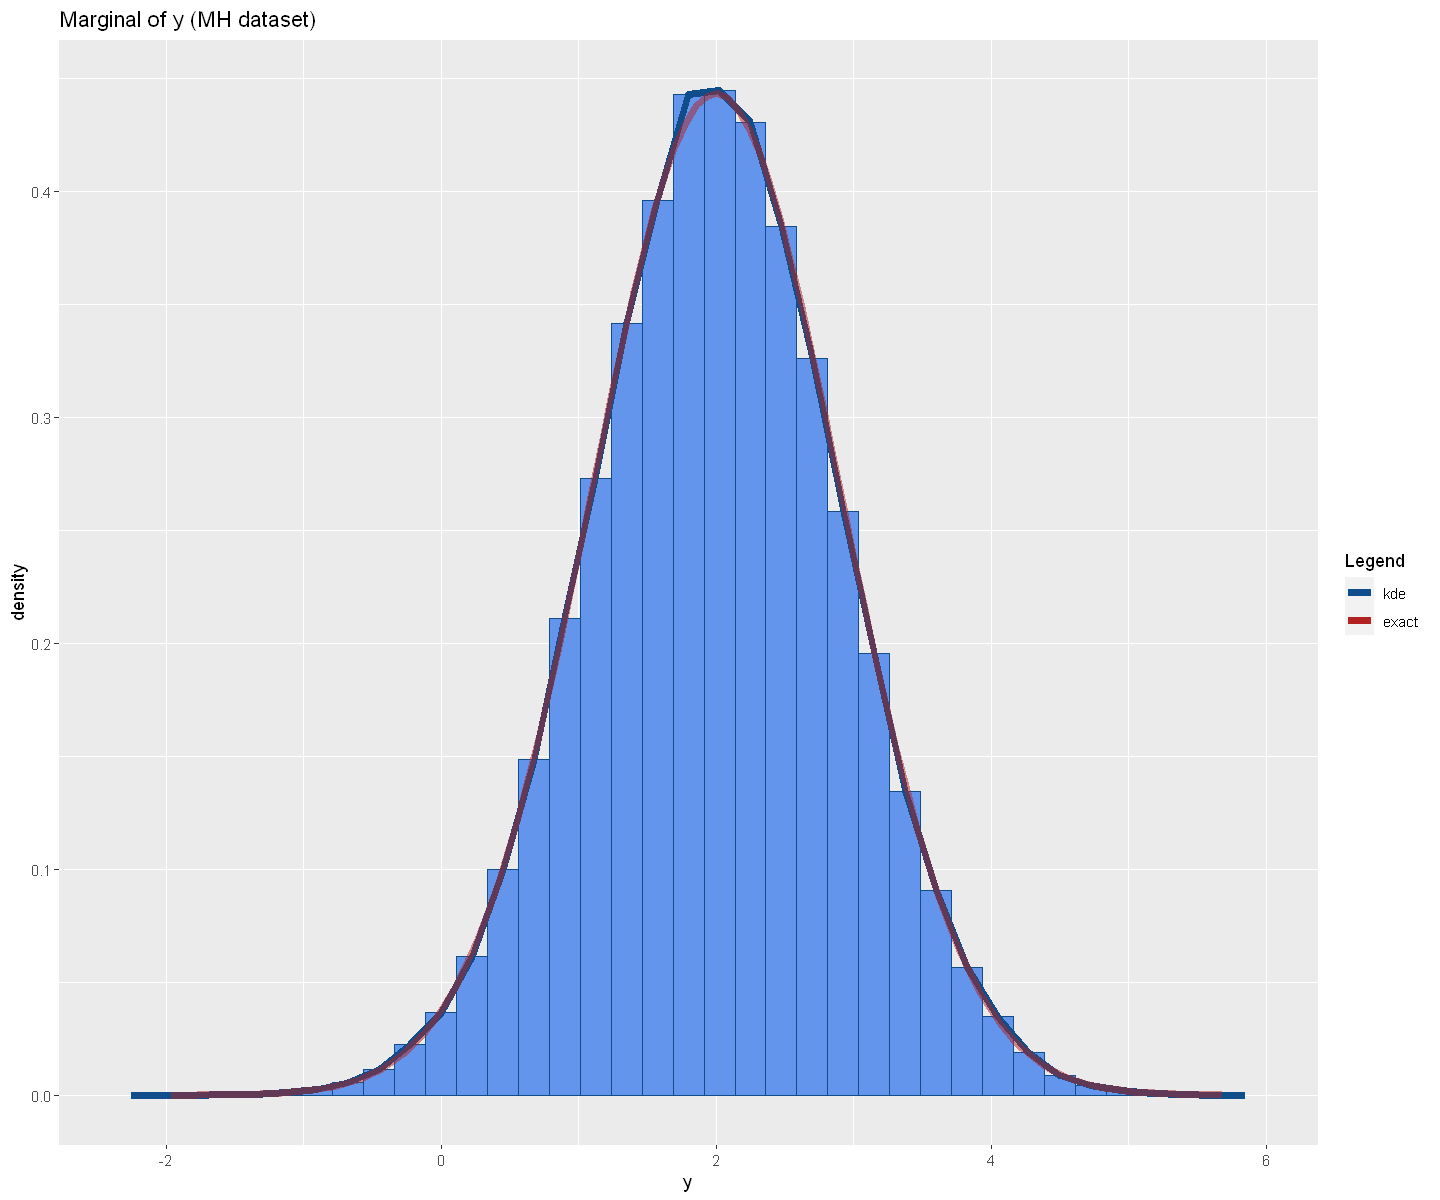

In [97]:
ggplot(mh_chains_df_trace_burn_in) +
  geom_histogram(aes(x = y, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = y, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_y, sd = sigma_y),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle("Marginal of y (MH dataset)") +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [98]:
print("Mean KLD between MH & exact y marginal:")
print(kld_sampled_exact_distribution(mh_chains_df_trace_burn_in$y, mu_y, sigma_y))

[1] "Mean KLD between MH & exact y marginal:"
[1] 0.000129949


We have excellent agreement, and even a slightly better KLD compared to the other marginal.

#### MH $95\%$ credibility interval for $y$
##### Estimate via histograms

In [99]:
# we estimate the max using kde
max_mh_y <- density(mh_chains_df_trace_burn_in$y, n = 1024)$x[which.max(density(mh_chains_df_trace_burn_in$y, n = 1024)$y)]

k_y_mh_marginal <- 2.23
y1_mh <- max_mh_y - k_y_mh_marginal * cov_mh_df[2, 2]
y2_mh <- max_mh_y + k_y_mh_marginal * cov_mh_df[2, 2]

print(sprintf("MH: area of y's marginal between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              y1_mh, y2_mh, k_y_mh_marginal))
mean((y1_mh < mh_chains_df_trace_burn_in$y) & (mh_chains_df_trace_burn_in$y < y2_mh)) |> print()

[1] "MH: area of y's marginal between 0.13 and 3.71 (argmax ± 2.23 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9523611


In [100]:
print("theoretical 95% credibility interval for y:")
print(sprintf("[%.2f, %.2f]", y1, y2))

[1] "theoretical 95% credibility interval for y:"
[1] "[0.20, 3.80]"


In [101]:
print(sprintf("ratio between theoretical and MH empirical sigma_x = %f", cov_mh_df[1, 1] / sigma_x))
print(sprintf("2/%.3f = %f", k_x_mh_marginal, 2 / k_x_mh_marginal))

[1] "ratio between theoretical and MH empirical sigma_x = 1.192991"
[1] "2/1.671 = 1.196888"


In [102]:
print(sprintf("center of MH empirical y marginal = %.2f", max_mh_y))
print(sprintf("center of theoretical y marginal = %.2f", mu_y))

[1] "center of MH empirical y marginal = 1.92"
[1] "center of theoretical y marginal = 2.00"


Same as always: the peak is shifted about $0.08$ units, which explains the overall shift of the interval (still with about the same length). This time the peak is only $0.01$ units different from its Cholesky counterpart.

#### Estimate via kde

In [103]:
cat(sprintf("MH: area of y's marginal between %.2f and %.2f (mean ± %.2f * std):",
            y1_mh, y2_mh, k_y_mh_marginal))
integrate(\ (x) approxfun(density(mh_chains_df_trace_burn_in$y))(x),
          y1_mh, y2_mh)
# it's essentially the same area estimate

MH: area of y's marginal between 0.13 and 3.71 (mean ± 2.23 * std):

0.9527823 with absolute error < 7.2e-05

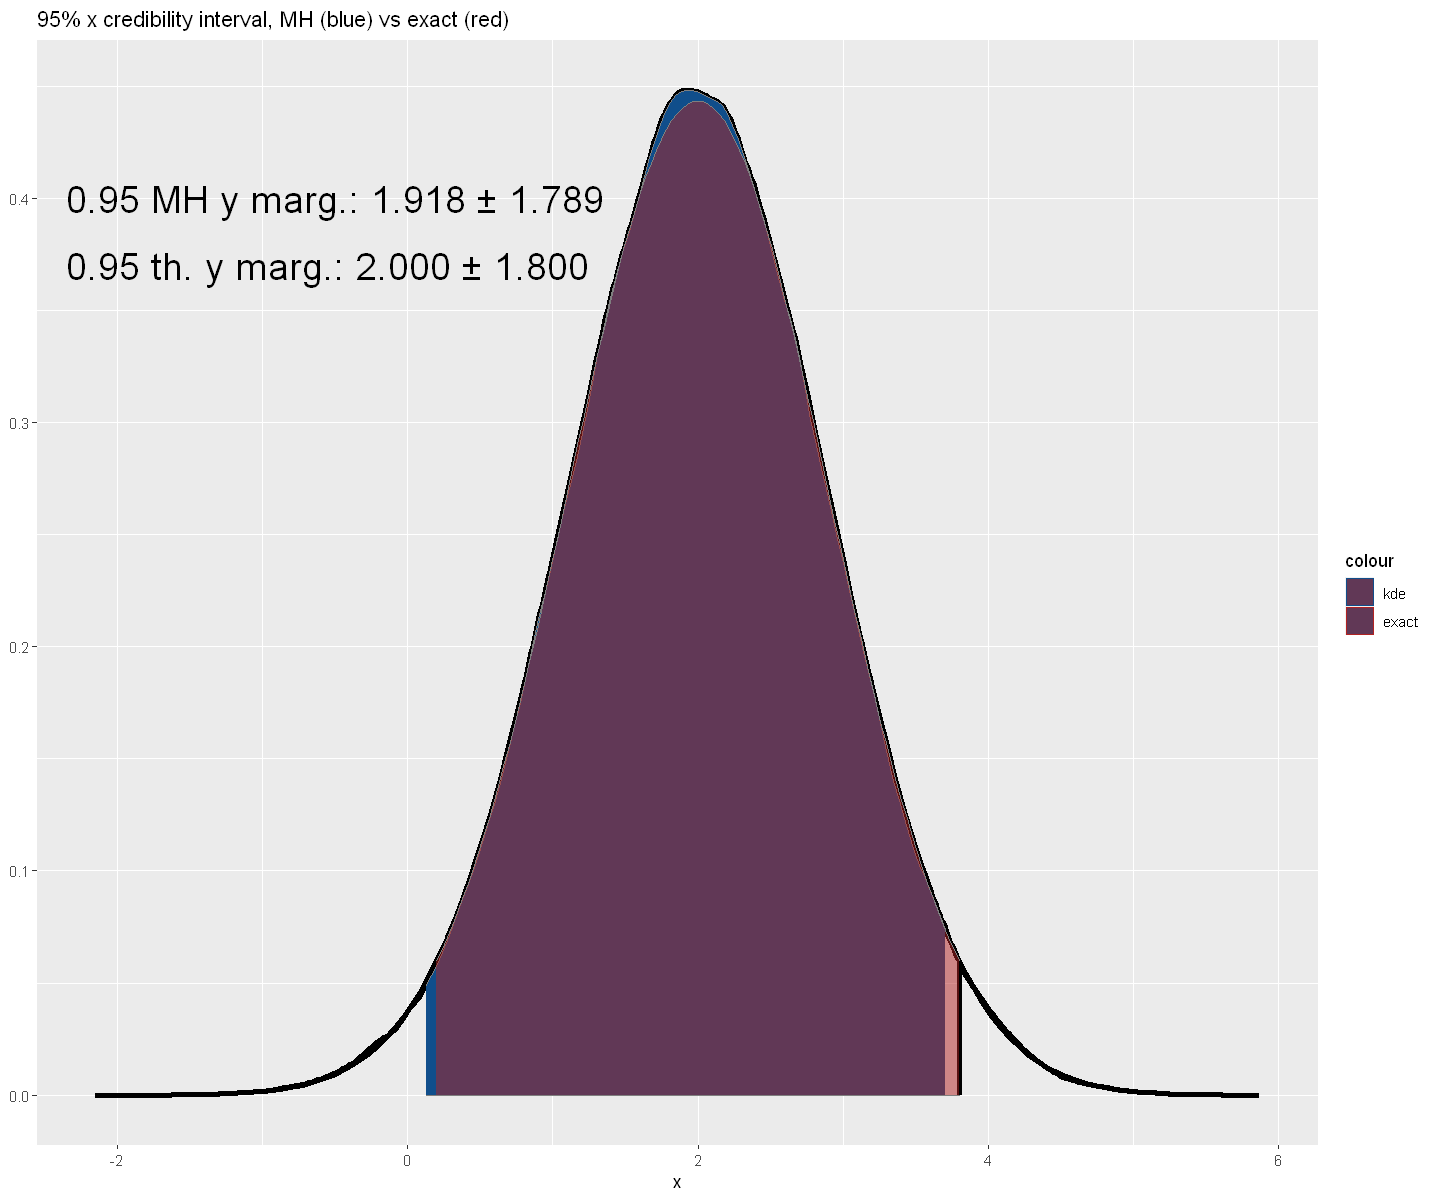

In [104]:
ggplot() + geom_line(data = marginal_y_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = y1, xend = y1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2, xend = y2, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(mh_chains_df_trace_burn_in$y)$x,
                              y = density(mh_chains_df_trace_burn_in$y)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(mh_chains_df_trace_burn_in$y))(.x),
                xlim = c(y1_mh, y2_mh),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y, sd = sigma_y),
                xlim = c(y1, y2),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x credibility interval, MH (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = -0.5, y = 0.4,
           label = sprintf("0.95 MH y marg.: %.3f ± %.3f",
           max_mh_y, k_y_mh_marginal * cov_mh_df[2, 2]), size = 8) +
  annotate("text", x = -0.55, y = 0.37,
           label = sprintf("0.95 th. y marg.: %.3f ± %.3f",
           mu_y, 2 * sigma_y), size = 8)

This allows us to appreciate the nice agreement and that the kde peak is shifted slightly to the left, and that this explains the overall interval shift.

## Conditioning with MH generated dataset
We proceed as done in the Cholesky case: we condition on the same values for $x$/$y$ and perform the same analysis.

### $x$ MH conditional

In [105]:
# to compare with the exact case we still consider the y = 3 conditional
eps_y      <- 0.1
y1_cond_mh <- 3 - eps_y
y2_cond_mh <- 3 + eps_y

conditional_x_df_mh <- mh_chains_df_trace_burn_in |> filter(y1_cond_mh < y & y < y2_cond_mh)
print(sprintf("number of elements with %.2f < y < %.2f: %d",
              y1_cond_mh, y2_cond_mh, length(conditional_x_df_mh$x)))
              
# 1 extra o.o.m. compared with Cholesky dataset with the same eps = 0.1

[1] "number of elements with 2.90 < y < 3.10: 17009"


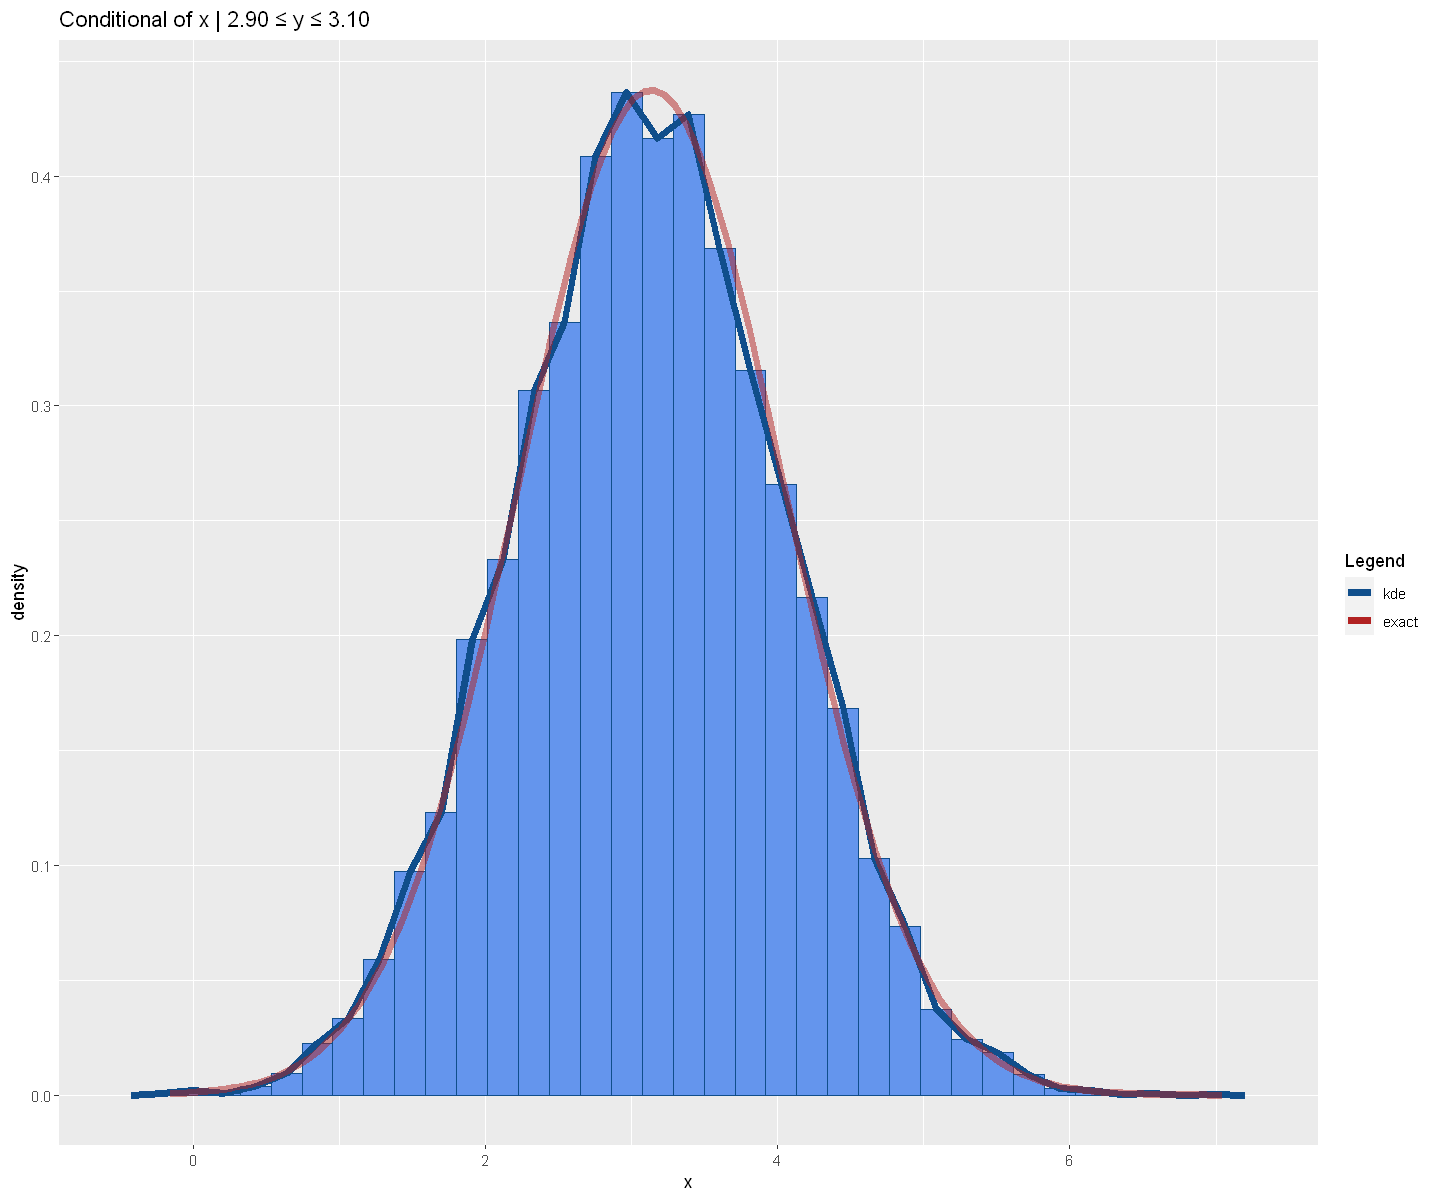

In [106]:
ggplot(conditional_x_df_mh) +
  geom_histogram(aes(x = x, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = x, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_x_conditional, sd = sigma_x_conditional),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle(sprintf("Conditional of x | %.2f ≤ y ≤ %.2f", y1_cond_mh, y2_cond_mh)) +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

We notice that the agreement between distribution is now a bit worse - clearly a consequence of the smaller number of points available in the dataset (about 1 o.o.m. less). We can still consider it pretty good, both qualitatively and semi-quantitatively:

In [107]:
print("Mean KLD between MH & exact x conditional:")
print(kld_sampled_exact_distribution(conditional_x_df_mh$x, mu_x_conditional, sigma_x_conditional))

[1] "Mean KLD between MH & exact x conditional:"
[1] 0.001101246


#### MH $95\%$ credibility interval for $x|y\approx 3$
##### Estimate via histograms

In [108]:
# we estimate the max using kde
max_mh_x_cond      <- density(conditional_x_df_mh$x, n = 1024)$x[which.max(density(conditional_x_df_mh$x, n = 1024)$y)]
sigma_x_conditional_mh <- sd(conditional_x_df_mh$x)

k_x_cond_mh   <- 2.011
x1_mh_cond <- max_mh_x_cond - k_x_cond_mh * sigma_x_conditional_mh
x2_mh_cond <- max_mh_x_cond + k_x_cond_mh * sigma_x_conditional_mh

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("MH: area of x|y = 3 conditional between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              x1_mh_cond, x2_mh_cond, k_x_cond_mh))
mean((x1_mh_cond < conditional_x_df_mh$x) & (conditional_x_df_mh$x < x2_mh_cond)) |> print()

[1] "MH: area of x|y = 3 conditional between 1.20 and 4.88 (argmax ± 2.01 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9581986


In [109]:
print("theoretical 95% credibility interval for x|y = 3:")
print(sprintf("[%.2f, %.2f]", x1_cond, x2_cond))

[1] "theoretical 95% credibility interval for x|y = 3:"
[1] "[1.31, 4.96]"


In [110]:
print(sprintf("ratio between theoretical and MH empirical sigma_x = %f", sigma_x_conditional_mh / sigma_x_conditional))
print(sprintf("2/%.3f = %f", k_x_cond_mh, 2 / k_x_cond_mh))

[1] "ratio between theoretical and MH empirical sigma_x = 1.004981"
[1] "2/2.011 = 0.994530"


In [111]:
print(sprintf("center of MH empirical x|y = 3 conditional = %.2f", max_mh_x_cond))
print(sprintf("center of theoretical x|y = 3 conditional = %.2f", mu_x_conditional))

[1] "center of MH empirical x|y = 3 conditional = 3.04"
[1] "center of theoretical x|y = 3 conditional = 3.13"


Once again the interval is mostly the same except for a shift to the left, explained by the fact that the center of the empirical distribution is shifted about 0.1 units to the left (as can be seen from the histogram or the next plot).

#### Estimate via kde

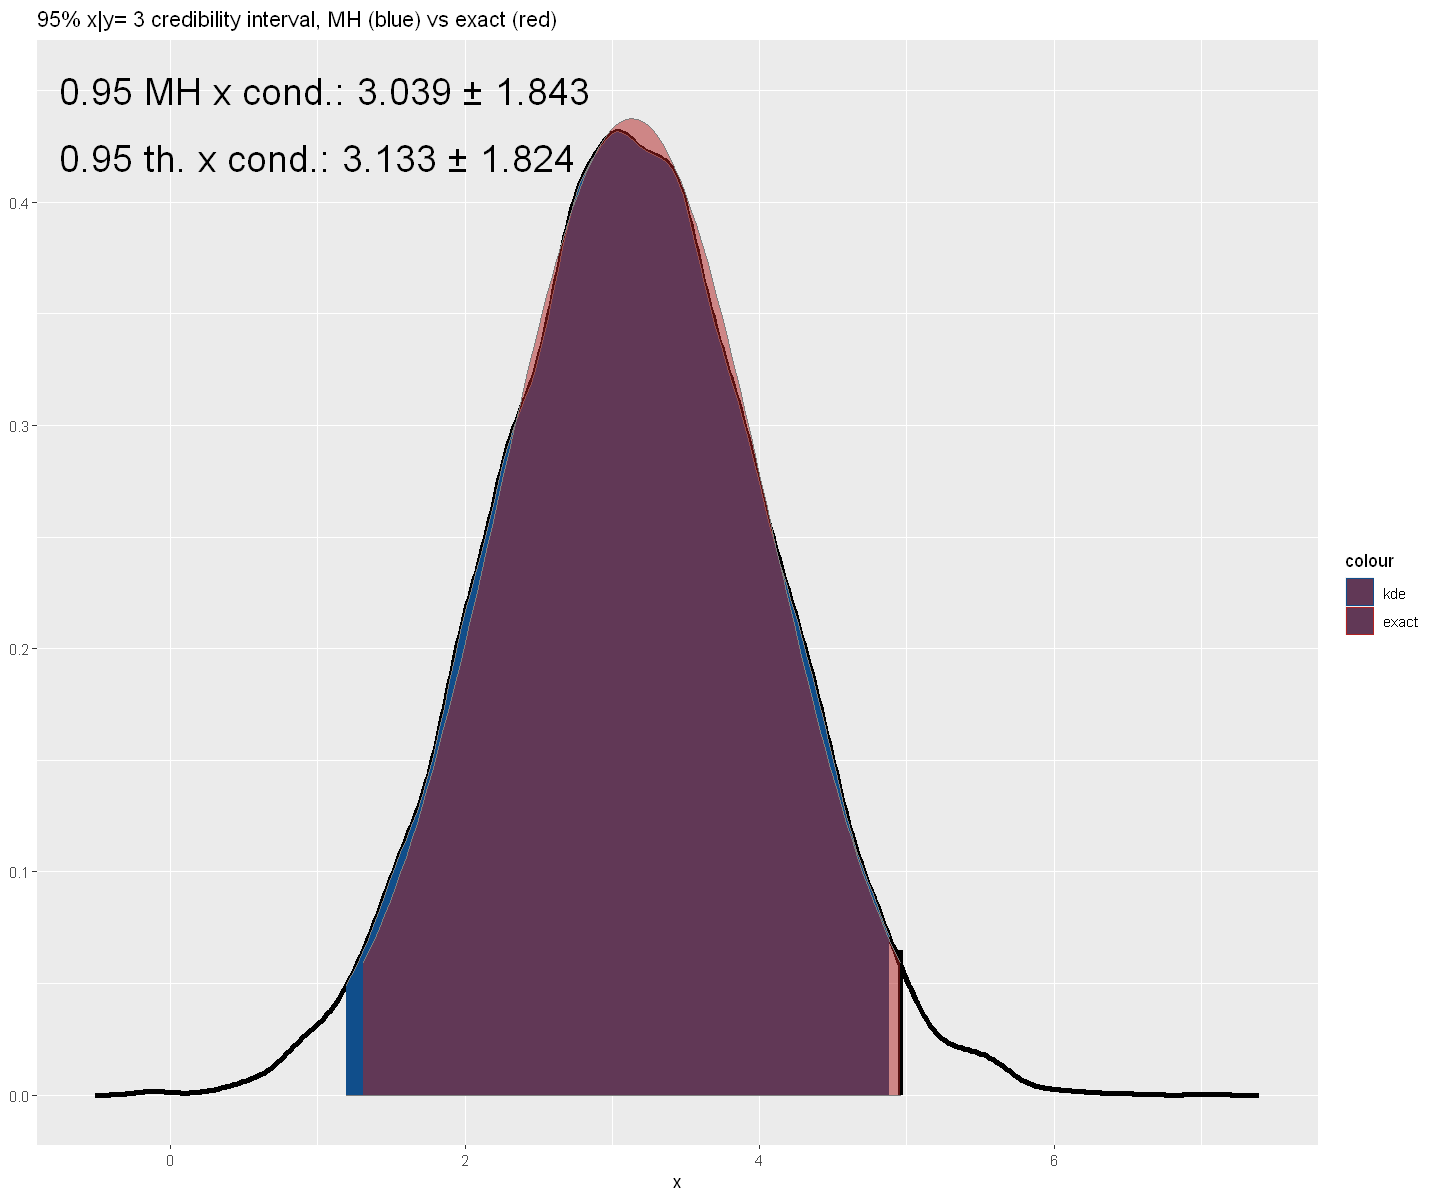

In [112]:
ggplot() +
  annotate("segment", x = x1_cond, xend = x1_cond, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2_cond, xend = x2_cond, y = 0, yend = 0.065,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(conditional_x_df_mh$x)$x,
                              y = density(conditional_x_df_mh$x)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(conditional_x_df_mh$x))(.x),
                xlim = c(x1_mh_cond, x2_mh_cond),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x_conditional, sd = sigma_x_conditional),
                xlim = c(x1_cond, x2_cond),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x|y= 3 credibility interval, MH (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = 1.05, y = 0.45,
           label = sprintf("0.95 MH x cond.: %.3f ± %.3f",
           max_mh_x_cond, k_x_cond_mh * sigma_x_conditional_mh),
           size = 8) +
  annotate("text", x = 1, y = 0.42,
           label = sprintf("0.95 th. x cond.: %.3f ± %.3f",
           mu_x_conditional, 2 * sigma_x_conditional), size = 8)

As with the histogram we notice that when we plot the kde there is a more significant difference with the theoretical distribution (the peak is more clearly asymmetrical); this difference is reflected in a larger discrepancy between credibility intervals extrema.

Still we can once again consider the agreement between MH sampled and theoretical conditional distributions to be excellent, all things considered.

### $y$ MH conditional

In [113]:
# to compare with the exact case we still consider the x = 2.5 conditional
eps_x      <- 0.2 # epsilon chosen to achieve the same o.o.m. of elements in the dataset as in the previous conditional
x1_cond_mh <- 2.5 - eps_x
x2_cond_mh <- 2.5 + eps_x

conditional_y_df_mh <- mh_chains_df_trace_burn_in |> filter(x1_cond_mh < x & x < x2_cond_mh)
print(sprintf("number of elements with %.2f < x < %.2f: %d", x1_cond_mh, x2_cond_mh, length(conditional_y_df_mh$x)))

# 1 extra o.o.m. w.r.t. Cholesky with the same eps = 0.2

[1] "number of elements with 2.30 < x < 2.70: 21888"


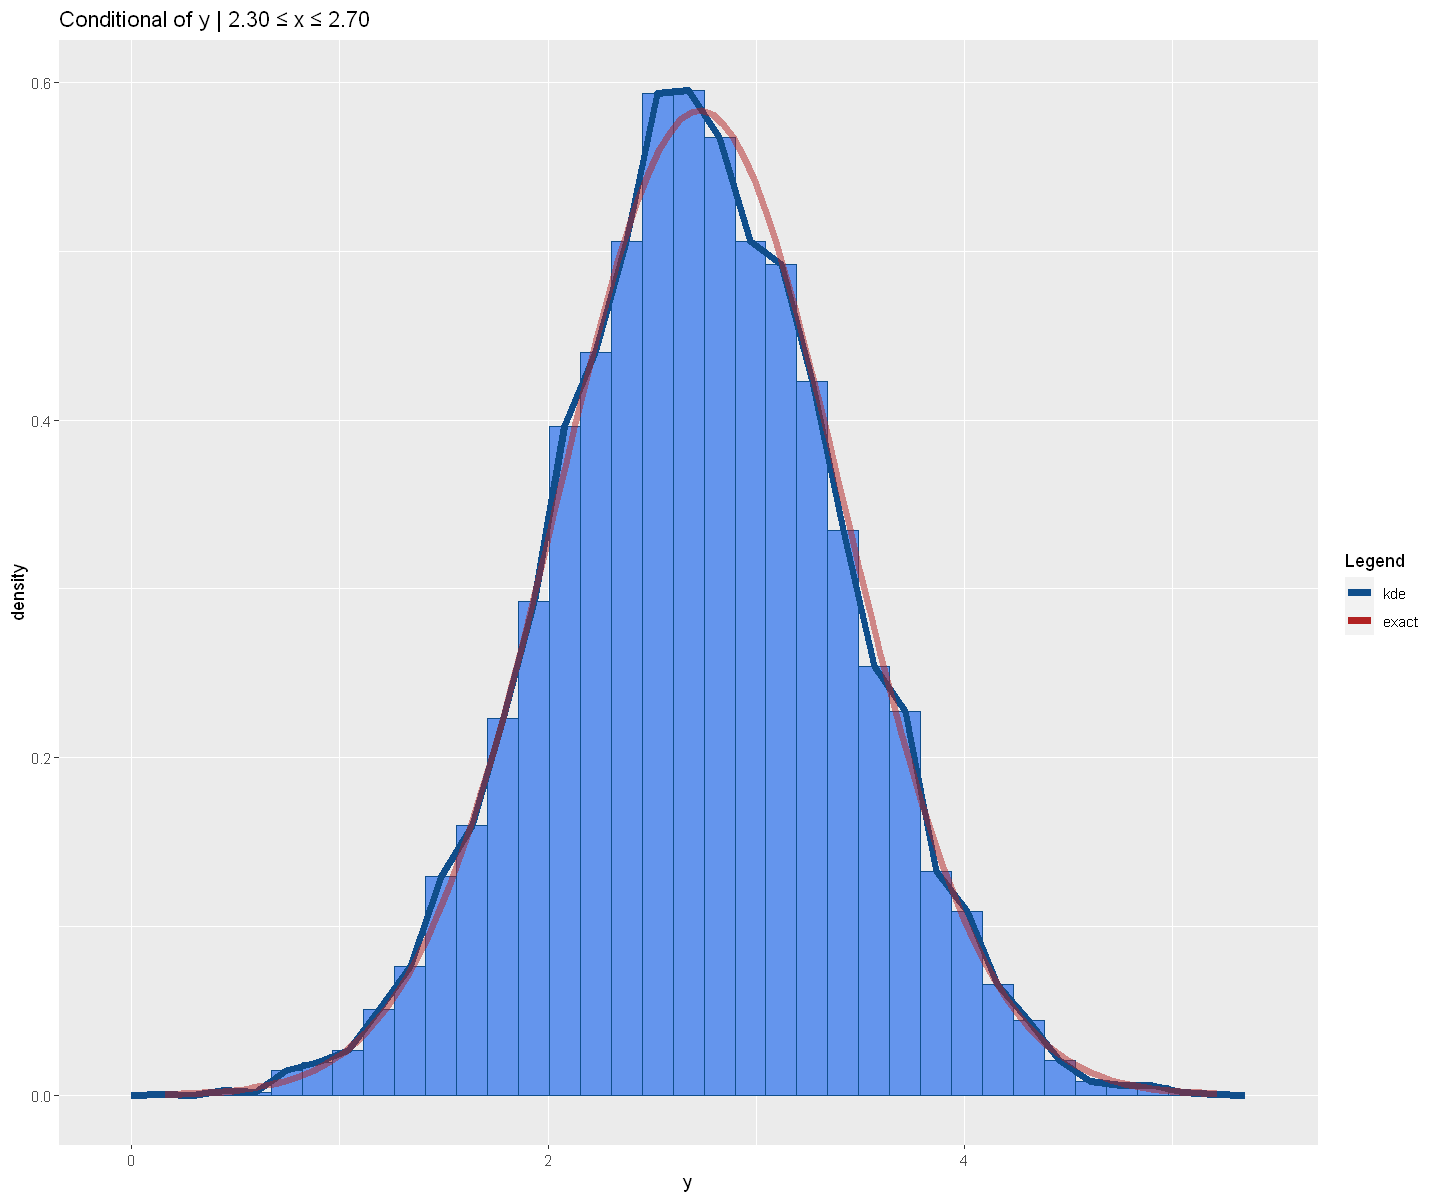

In [114]:
ggplot(conditional_y_df_mh) +
  geom_histogram(aes(x = y, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = y, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_y_conditional, sd = sigma_y_conditional),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle(sprintf("Conditional of y | %.2f ≤ x ≤ %.2f", x1_cond_mh, x2_cond_mh)) +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [115]:
print("Mean KLD between MH & exact y conditional:")
print(kld_sampled_exact_distribution(conditional_y_df_mh$y, mu_y_conditional, sigma_y_conditional))

[1] "Mean KLD between MH & exact y conditional:"
[1] 0.001090068


#### MH $95\%$ credibility interval for $y|x\approx 2.5$
##### Estimate via histograms

In [116]:
# we estimate the max using kde
max_mh_y_cond          <- density(conditional_y_df_mh$y, n = 1024)$x[which.max(density(conditional_y_df_mh$y, n = 1024)$y)]
sigma_y_conditional_mh <- sd(conditional_y_df_mh$y)

k_y_cond_mh <- 2.011
y1_mh_cond  <- max_mh_y_cond - k_y_cond_mh * sigma_y_conditional_mh
y2_mh_cond  <- max_mh_y_cond + k_y_cond_mh * sigma_y_conditional_mh

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("MH: area of x|y = 3 conditional between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              y1_mh_cond, y2_mh_cond, k_y_cond_mh))
mean((y1_mh_cond < conditional_y_df_mh$y) & (conditional_y_df_mh$y < y2_mh_cond)) |> print()

[1] "MH: area of x|y = 3 conditional between 1.24 and 4.00 (argmax ± 2.01 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9518458


In [117]:
print("theoretical 95% credibility interval for y|x = 2.5:")
print(sprintf("[%.2f, %.2f]", y1_cond, y2_cond))

[1] "theoretical 95% credibility interval for y|x = 2.5:"
[1] "[1.36, 4.10]"


In [118]:
print(sprintf("ratio between theoretical and MH empirical sigma_y_conditional = %f", sigma_y_conditional_mh / sigma_y_conditional))
print(sprintf("2/%.3f = %f", k_y_cond_mh, 2 / k_y_cond_mh))

[1] "ratio between theoretical and MH empirical sigma_y_conditional = 1.002583"
[1] "2/2.011 = 0.994530"


In [119]:
print(sprintf("center of MH empirical y|x = 2.5 conditional = %.2f", max_mh_y_cond))
print(sprintf("center of theoretical y|x = 2.5 conditional = %.2f", mu_y_conditional))

[1] "center of MH empirical y|x = 2.5 conditional = 2.62"
[1] "center of theoretical y|x = 2.5 conditional = 2.73"


#### Estimate via kde

In [120]:
cat(sprintf("MH: area of y|x = 2.5 conditional between %.2f and %.2f (mean ± %.2f * std):",
            y1_mh_cond, y2_mh_cond, k_y_cond))
integrate(\ (x) approxfun(density(conditional_y_df_mh$y))(x), y1_mh_cond, y2_mh_cond)

MH: area of y|x = 2.5 conditional between 1.24 and 4.00 (mean ± 2.01 * std):

0.9516546 with absolute error < 4e-05

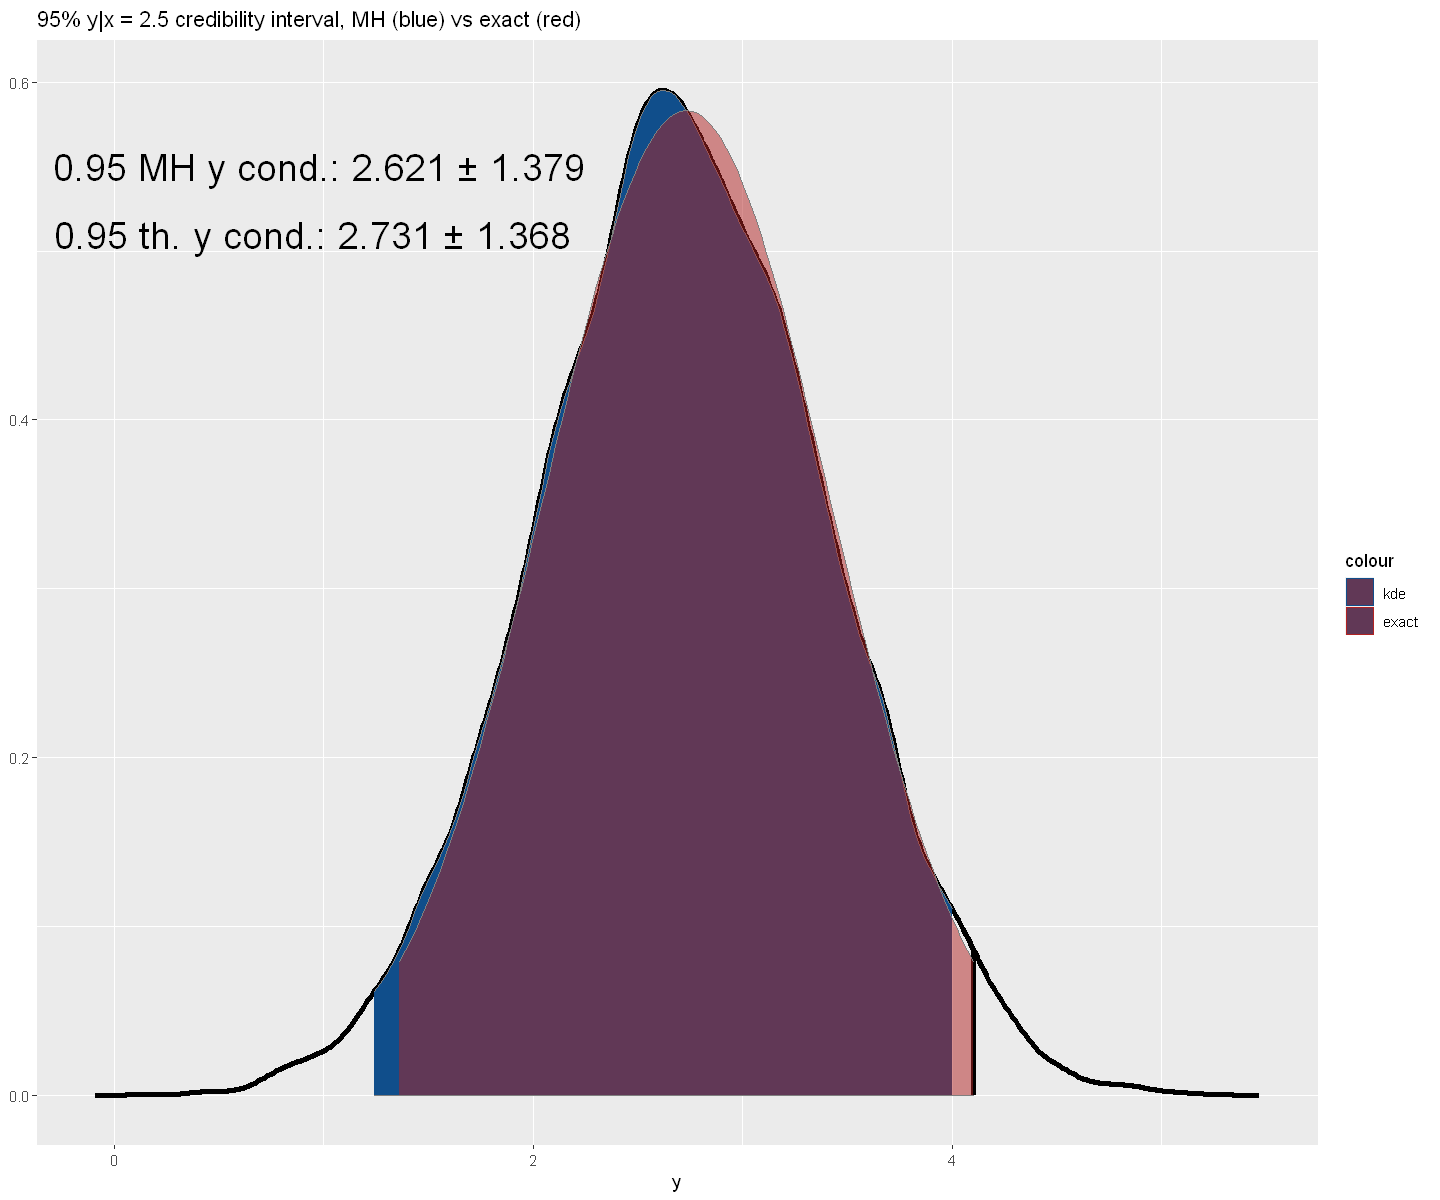

In [121]:
ggplot() +
  annotate("segment", x = y1_cond, xend = y1_cond, y = 0, yend = 0.08,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2_cond, xend = y2_cond, y = 0, yend = 0.085,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(conditional_y_df_mh$y)$x,
                              y = density(conditional_y_df_mh$y)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(conditional_y_df_mh$y))(.x),
                xlim = c(y1_mh_cond, y2_mh_cond),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y_conditional, sd = sigma_y_conditional),
                xlim = c(y1_cond, y2_cond),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% y|x = 2.5 credibility interval, MH (blue) vs exact (red)") +
  labs(x = "y", y = NULL) +
  annotate("text", x = 0.98, y = 0.55,
           label = sprintf("0.95 MH y cond.: %.3f ± %.3f",
           max_mh_y_cond, k_y_cond_mh * sigma_y_conditional_mh),
           size = 8) +
  annotate("text", x = 0.95, y = 0.51,
           label = sprintf("0.95 th. y cond.: %.3f ± %.3f",
           mu_y_conditional, 2 * sigma_y_conditional), size = 8)

# Gibbs MCMC sampling
## Introduction
Gibbs' algorithm is essentially a modified version of the Metropolis-Hastings algorithm, in that it assembles a Markov chain iteratively with the same asymptotic properties. The way the next point is computed is different, which can increase performance under a specific set of circumstances. The main differences are the following:
- it is a "1D algorithm": at each step all entries but one are fixed, so that we only update one component at a time. The result is that we always move parallel to the axes;
- conditional probabilities are used as the proposal distribution;
- the Metropolis factor is 1, i.e. we always accept.
These points let us see pros and cons of this algorithm. On one hand we gain some efficiency since we never discard sampled points, but on the other we lose some since our movement is constrained ("zigzag motion") which many mean more time to explore all of parameter space. We can also remark that Gibbs becomes convenient when conditional probabilities can be efficiently computed/evaluated (as in our case, where a simple theorical formula is available), but only if correlation between parameters isn't too strong (as in our case). In particular maximum efficiency is achieved in the limiting case of statistical independence, in which case an $N$ dimensional problem becomes effectively decoupled in $N$ 1-dimensional problems.

## Gibbs algorithm
In practice any given iteration works as follows:
1. We pick a random component $\theta_i^{(t)}$ in our parameter vector and fix all others;
2. We compute the updated component $\theta_i^{(t+1)}$ by sampling it from its conditional probability distribution, i.e. $p(\theta_i^{(t)}|\theta_k^{(t)}), \ \forall k\neq i$
3. Iterate these steps for the other components until all have been updated.

gibbs: menziona jags come framework popolare per dire che gibbs è più usato di mh, più performante? più semplice perché 1D N volte anziché ND?

inoltre: se fai il trace plot di x e y vedi che è rettangolare come conseguenza della regola usata per generare i dati

gibbs facile se si ha conoscenza delle condizionali e correlazione non eccessiva (vedi note teoria). Acceptance rate = 1, walk 1D/parallelo agli assi come differenze pratiche principali

In [122]:
gibbs_next_point <- function(current_point, chol_cov_proposal_dist) {
    v  <- sample(1:2, size = 2)
    i1 <- v[1]; i2 <- v[2]
    s  <- sqrt(1 / C_inv[i1, i1]) # std
    m  <- mu[i1] - C_inv[i1, i2] / C_inv[i1, i1] * (current_point[i2] - mu[i2])

    new_component  <- rnorm(1, mean = m, sd = s)
    next_point     <- c(0, 0)
    next_point[i1] <- new_component
    next_point[i2] <- current_point[i2]
    return(next_point)
}

In [123]:
gibbs <- function(n_samples, x0 = c(1, 1)) {
    chain_matrix           <- matrix(0, nrow = n_samples, ncol = 2)
    chain_matrix[1, 1:2]   <- x0

    for (i in 2:n_samples) {
         chain_matrix[i, 1:2] <- gibbs_next_point(chain_matrix[i - 1, 1:2])
    }
    return(chain_matrix)
}

## Gibbs dataset generation
As with MH we first generate a sample dataset of $10^5$ points with $[x_0, y_0] = [1, 1]$ to visually check if the above function seems to be working properly.

In [124]:
set.seed(1234)
n_points_gibbs <- 1e5
gibbs_matrix   <- gibbs(n_points_gibbs)

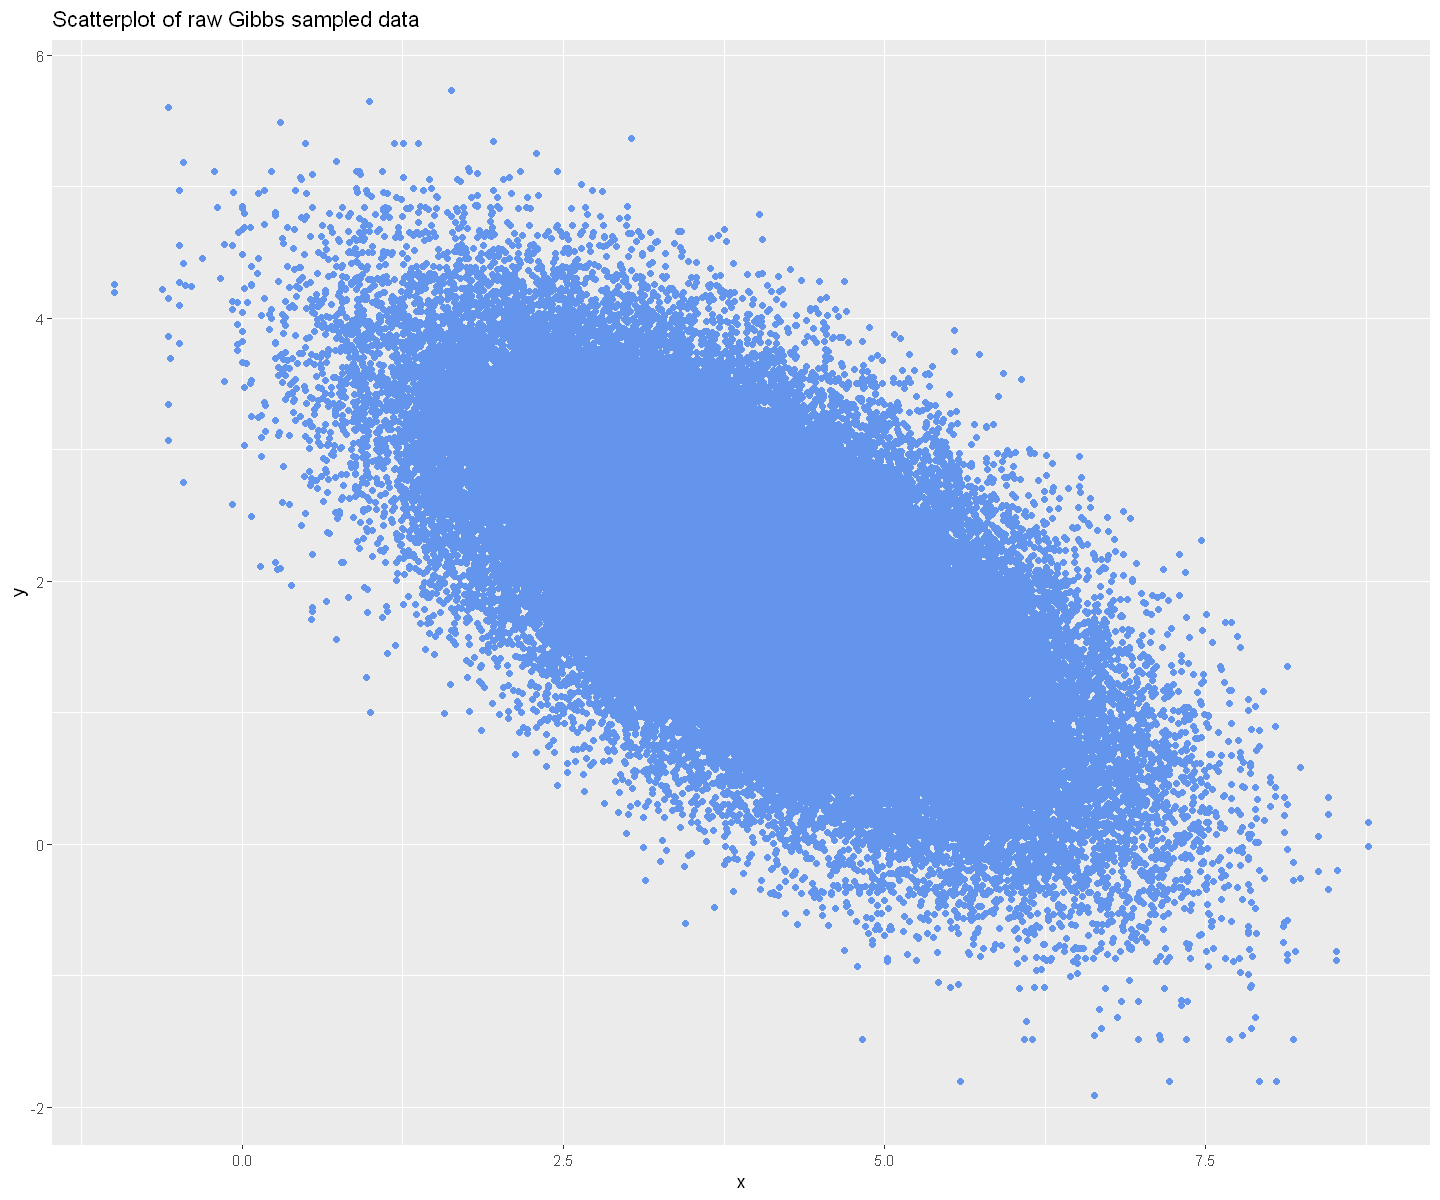

In [125]:
gibbs_df <- tibble(x = gibbs_matrix[, 1], y = gibbs_matrix[, 2])
ggplot(gibbs_df, aes(x, y)) + geom_point(color = "cornflowerblue") +
  ggtitle("Scatterplot of raw Gibbs sampled data")

## Gibbs diagnostics
### Multiple chains generation
The overall shape is the correct one, which is promising. Let us now generate 4 chains as in the MH section using the same 4 starting points.

In [126]:
# chains sampling
n_chains       <- 4
x0_list        <- list(c(5.3, 2.4), c(2.5, 3.5), c(5, 1), c(4.5, 1.8))
gibbs_chains_list <- list()
set.seed(1234)

for (i in 1:n_chains) {
    gibbs_chains_list[[i]] <- gibbs(n_points_gibbs,
                                    x0 = x0_list[[i]])
}

### Burn in and trace plots
We repeat the same analysis: to "decide" when burn in is over we produce trace plots, then guess when the chains have "converged enough".

In [127]:
# let us put all chains in the same dataframe. We also add
# a "time" variable t (simply the index of the point in the chain)
# and a chain index to differentiate points belonging to different
# chains

gibbs_chains_df <- bind_rows(lapply(gibbs_chains_list, data.frame),
                             .id = "chain_index") |>
                    rename(x = X1, y = X2) |>
                    mutate(t = rep(1:n_points_gibbs,
                           times = n_chains)) |> # add t col.
                    select(c(t, x, y, chain_index)) |> # reorder columns
                    as_tibble()

Once again we remark that simply plotting $x(t)$ or $y(t)$ is useless, hence why we need the log trace posterior.

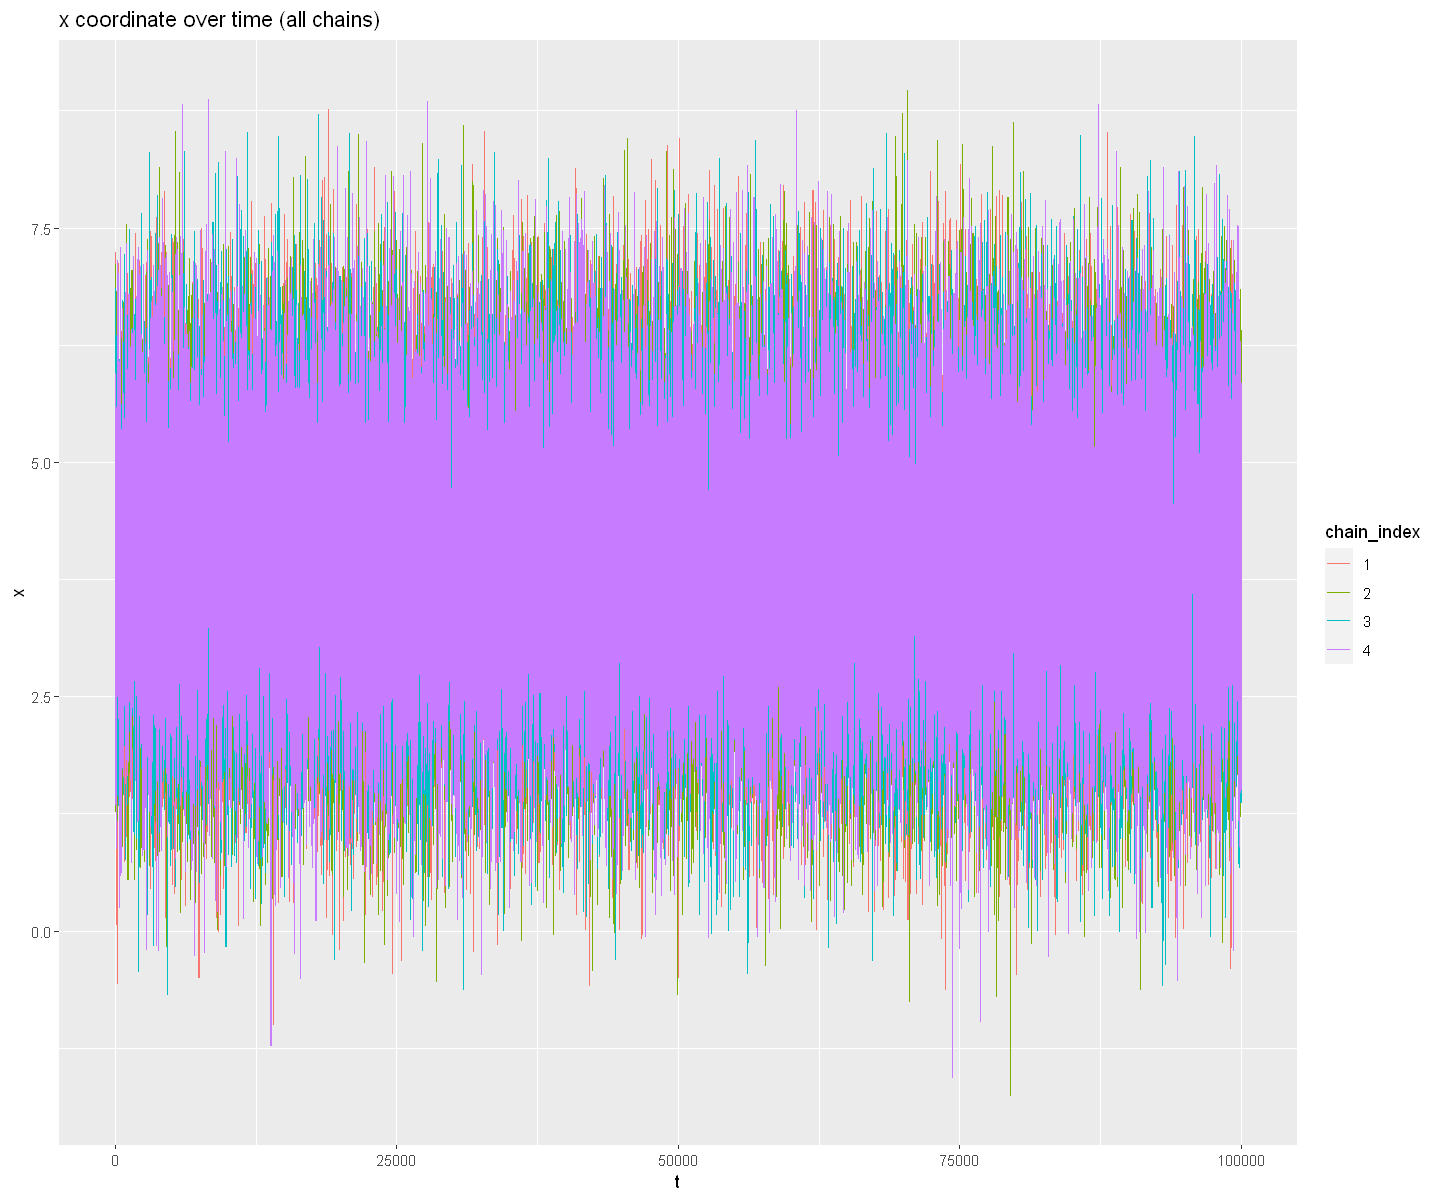

In [128]:
ggplot(gibbs_chains_df, aes(x = t, y = x, color = chain_index)) + geom_line() +
  ggtitle("x coordinate over time (all chains)")

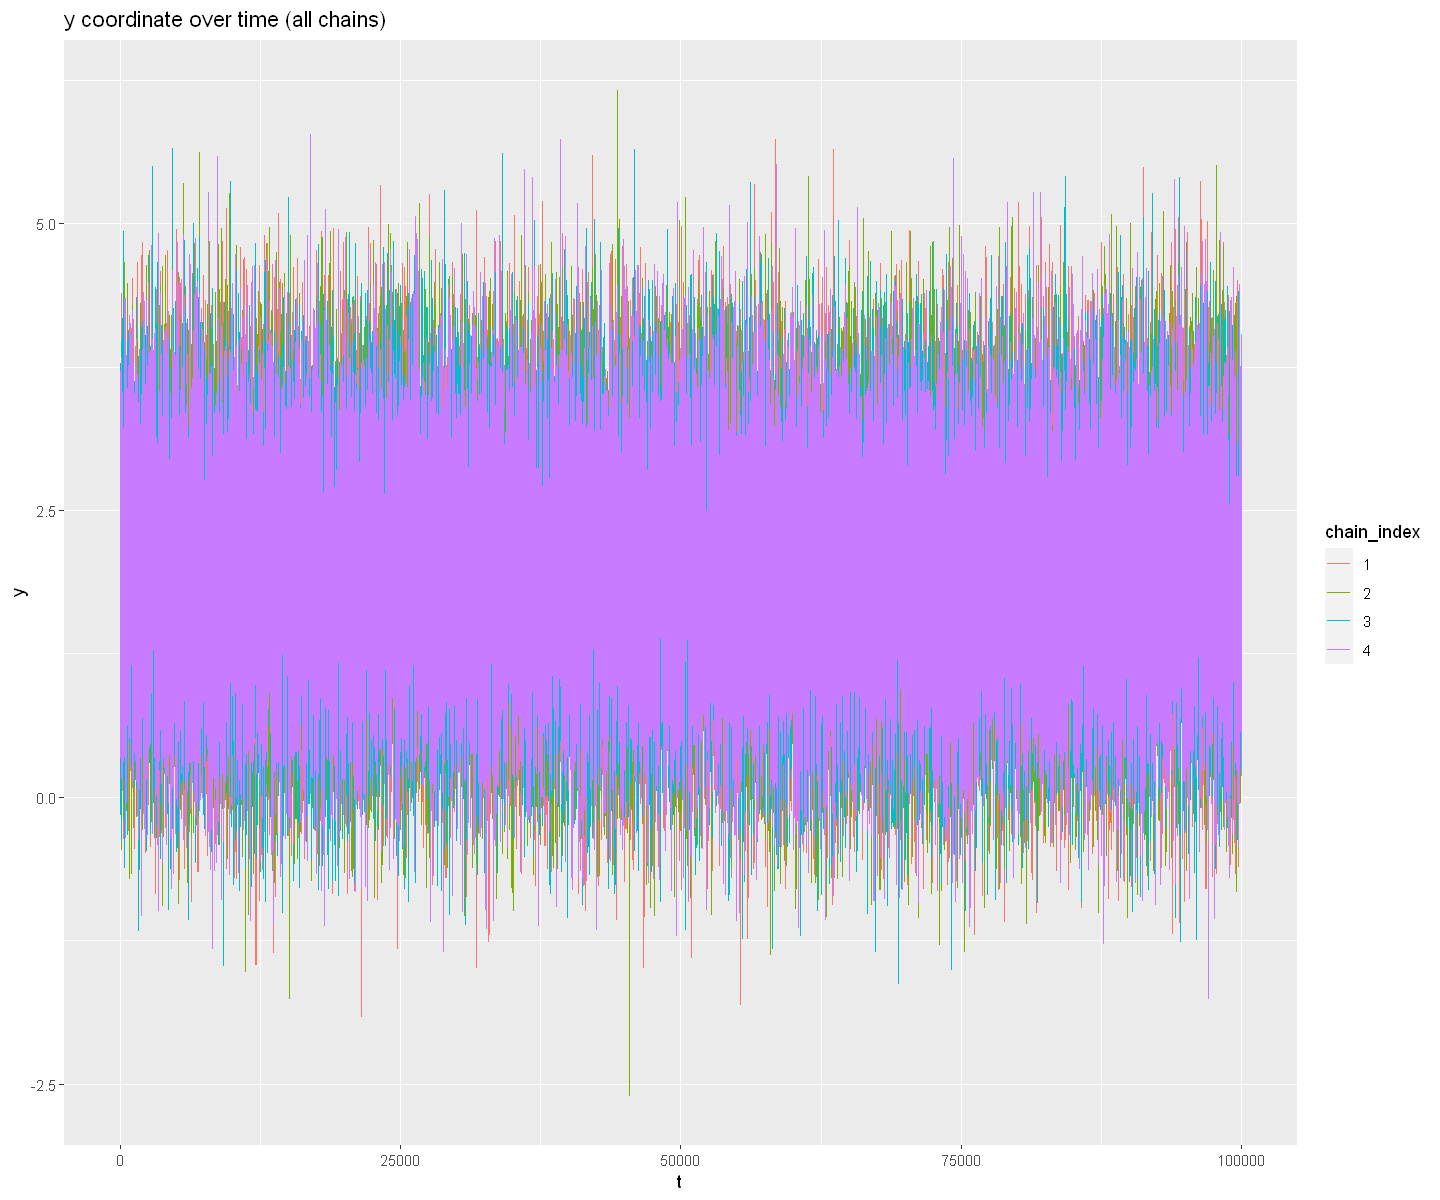

In [129]:
ggplot(gibbs_chains_df, aes(x = t, y = y, color = chain_index)) + geom_line() +
  ggtitle("y coordinate over time (all chains)")

In [130]:
# let us add the trace log post column

gibbs_chains_df_trace <- gibbs_chains_df |>
                           rowwise() |> # for each row...
                           mutate(log_posterior = log(posterior(c(x, y)))) |> # ...compute log(posterior(row))
                           group_by(chain_index) |> # within each chain...
                           mutate(Tr = -cummean(log_posterior)) |> # ...compute - cum. mean
                           select(- log_posterior) |> # finally we remove the log post. col.
                           ungroup()

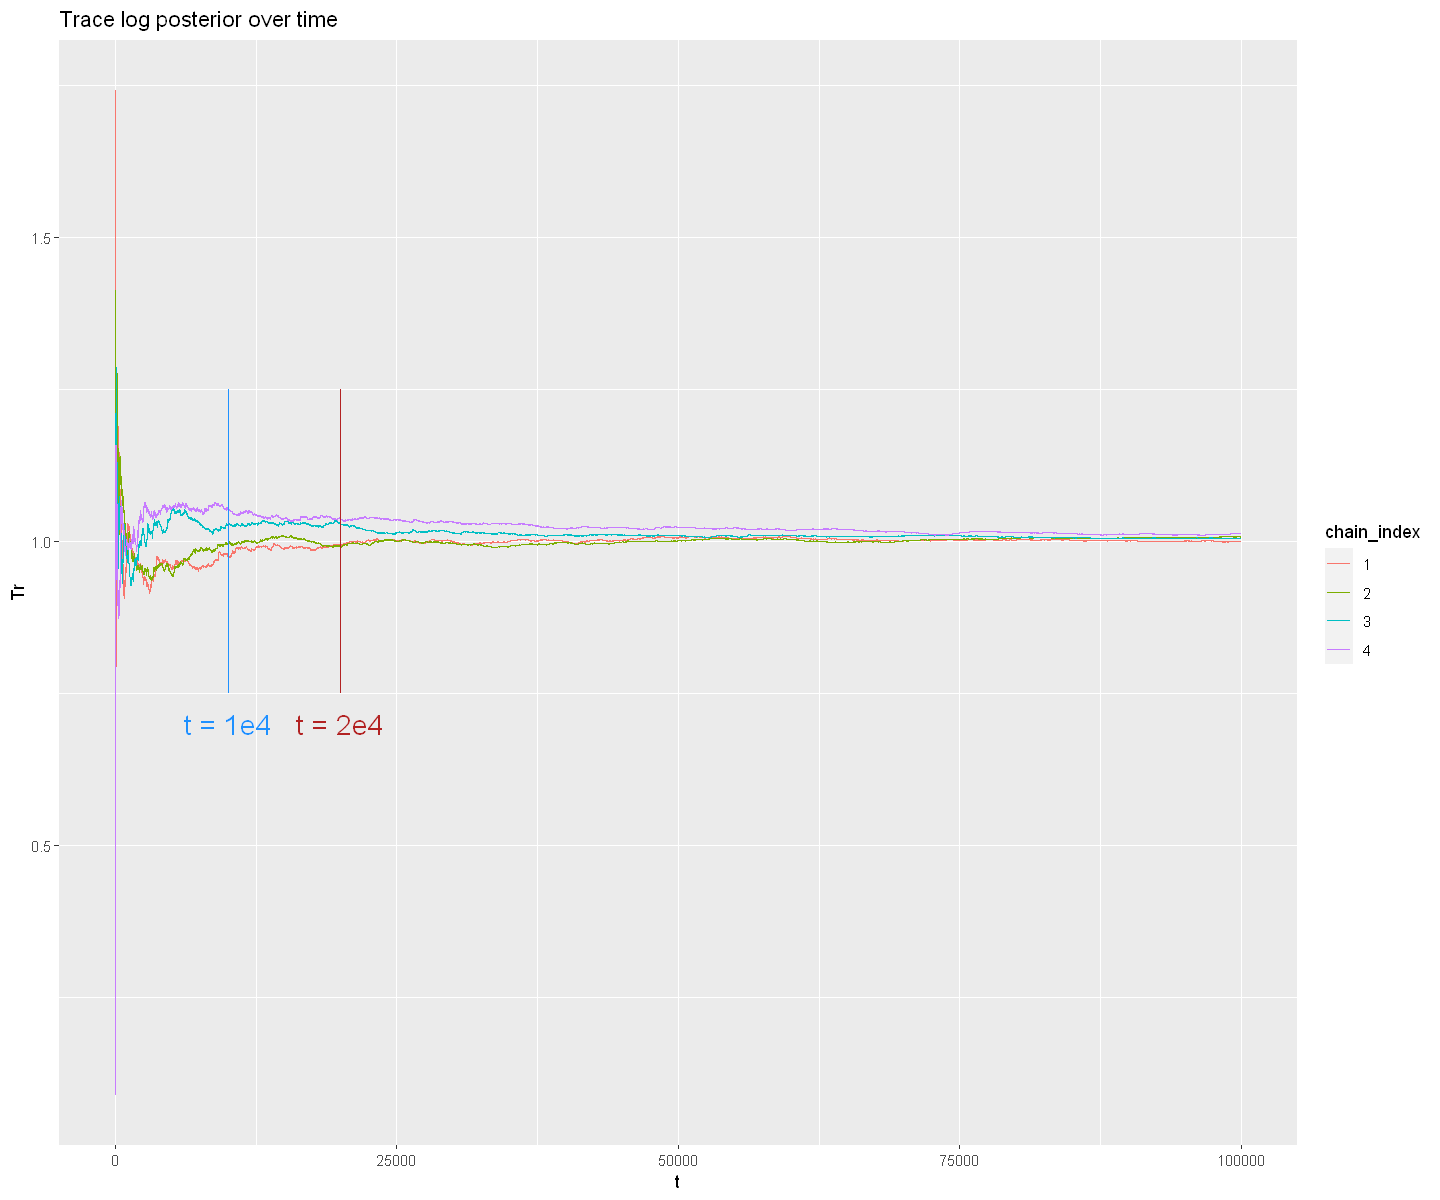

In [131]:
ggplot(gibbs_chains_df_trace, aes(x = t, y = Tr, color = chain_index)) +
  geom_line() +
  ggtitle("Trace log posterior over time") +
  annotate("segment", x = 2e4, xend = 2e4,
           y = 0.75, yend = 1.25, color =  "firebrick") +
  annotate("text", x = 2e4, y = 0.7, label = "t = 2e4",
           size = 6, color = "firebrick") +
  annotate("segment", x = 1e4, xend = 1e4,
           y = 0.75, yend = 1.25, color = "dodgerblue") +
  annotate("text", x = 1e4, y = 0.7, label = "t = 1e4",
           size = 6, color = "dodgerblue")

The result is quite similar to the MH case, i.e. around $10^4$ or $2\cdot 10^4$ most of the variance has died down. Interestingly this time we notice a more definite trend: the chains get closer almost monotonically, as can be better appreciated by removing the first few thousands samples.

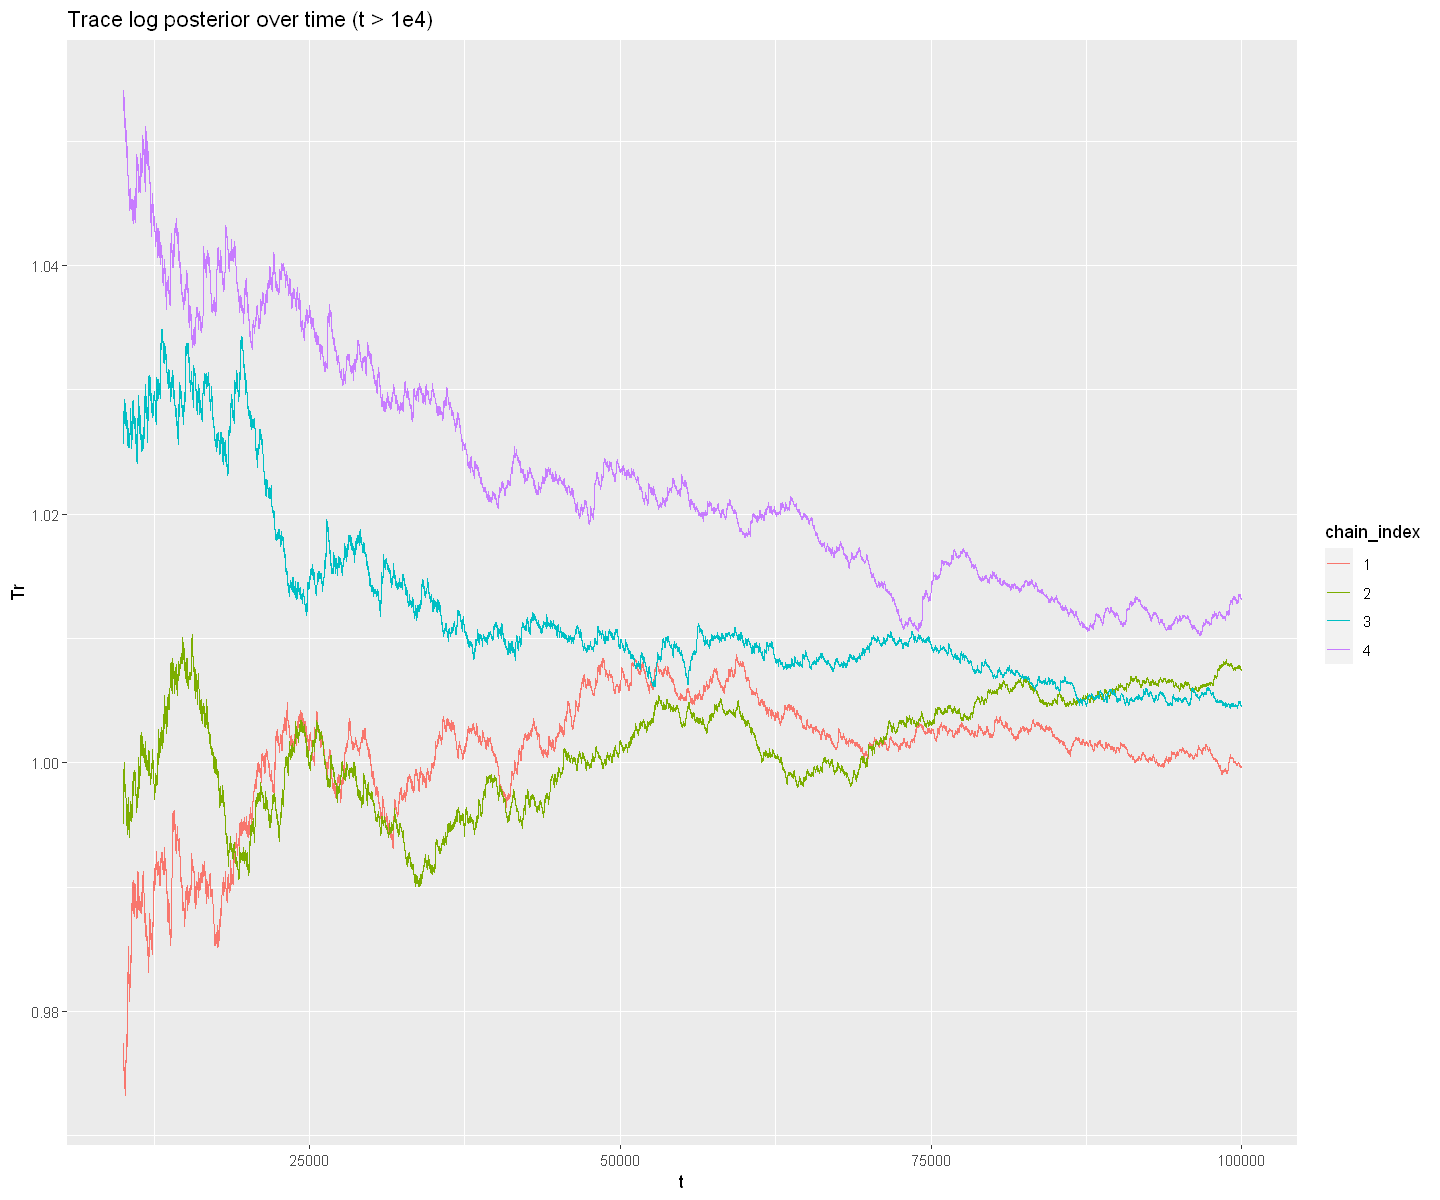

In [132]:
gibbs_chains_df_trace |> filter(t > 1e4) |>
  ggplot(aes(x = t, y = Tr, color = chain_index)) +
  geom_line() +
  ggtitle("Trace log posterior over time (t > 1e4)")

As said above the range after $10^4$ is almost the same as in the MH (about $[0.95, 1.05]$), but the chain actually get even closer without regaining distance later.

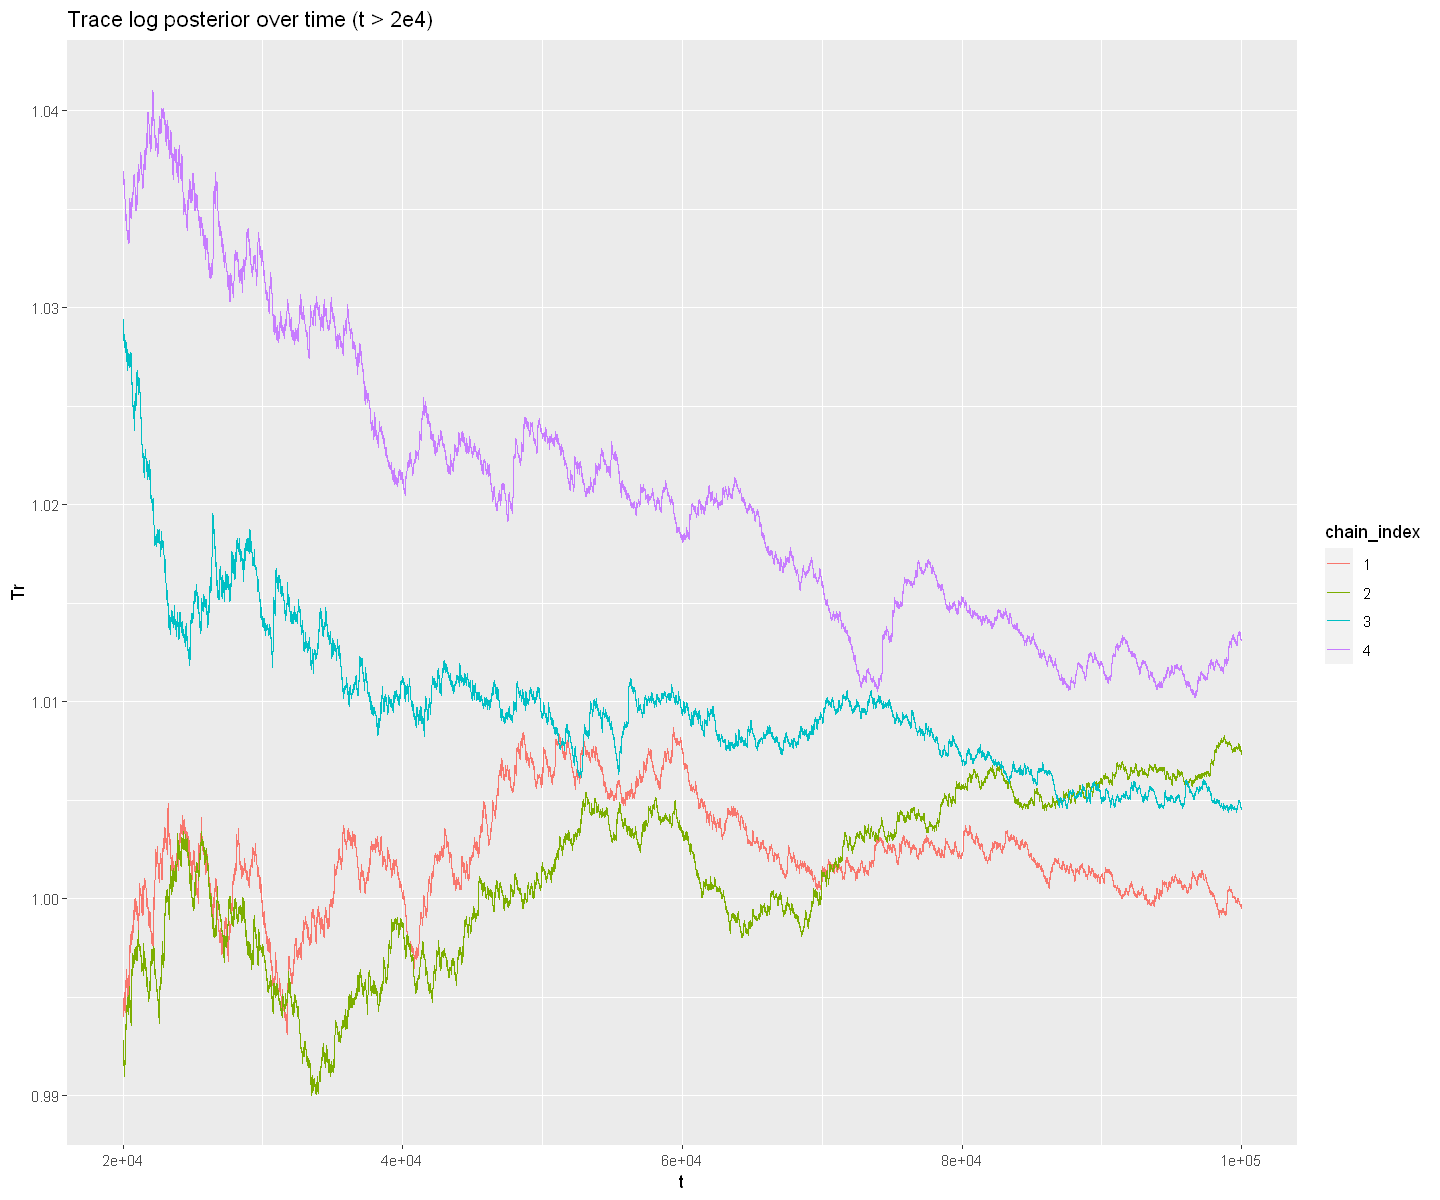

In [133]:
gibbs_chains_df_trace |> filter(t > 2e4) |>
  ggplot(aes(x = t, y = Tr, color = chain_index)) +
  geom_line() +
  ggtitle("Trace log posterior over time (t > 2e4)")

We notice that this time the last $2\cdot 10^4$ samples are in the very narrow $[1.0, 1.01]$ interval. Of course even though this is level of convergence is ideally great in practice it would mean discarding too many points to be effective; still we remark that this seems to imply that at least in this case Gibbs may surpass MH's performance.

In [134]:
# we pick the same burn-in as before, both because it works
# (see previous plots) and both to compare the two MCMC alg.
t_burn_in <- 1e4

gibbs_chains_df_trace_burn_in <- gibbs_chains_df_trace |>
                                   filter(t > t_burn_in)

### Gelman-Rubin test
We once again compute $R$ for both parameters.

In [135]:
print("gr test x:")
R_x <- gibbs_chains_df_trace_burn_in |>
         select(- y) |>
         gr_test() |>
         print()

cat("\n")
print("difference with 1:")
print(R_x - 1)

[1] "gr test x:"
[1] 1.000065

[1] "difference with 1:"
[1] 6.463692e-05


In [136]:
print("gr test y:")
R_y <- gibbs_chains_df_trace_burn_in |>
         select(- x) |>
         rename(x = y) |>
         gr_test() |>
         print()

cat("\n")
print("difference with 1:")
print(R_y - 1)

[1] "gr test y:"
[1] 1.00007

[1] "difference with 1:"
[1] 6.983401e-05


These scores are actually even better than in the MH case by about 1 o.o.m. - but since they were already quite good in the MH case this doesn't mean much in practice. Still we remark that Gibbs seems to be able to perform somewhat better than MH.

### GR test and burn in
Once again we plot $R(t)$ without discarding the first samples to check how conservative our guess was for the burn in phase duration.

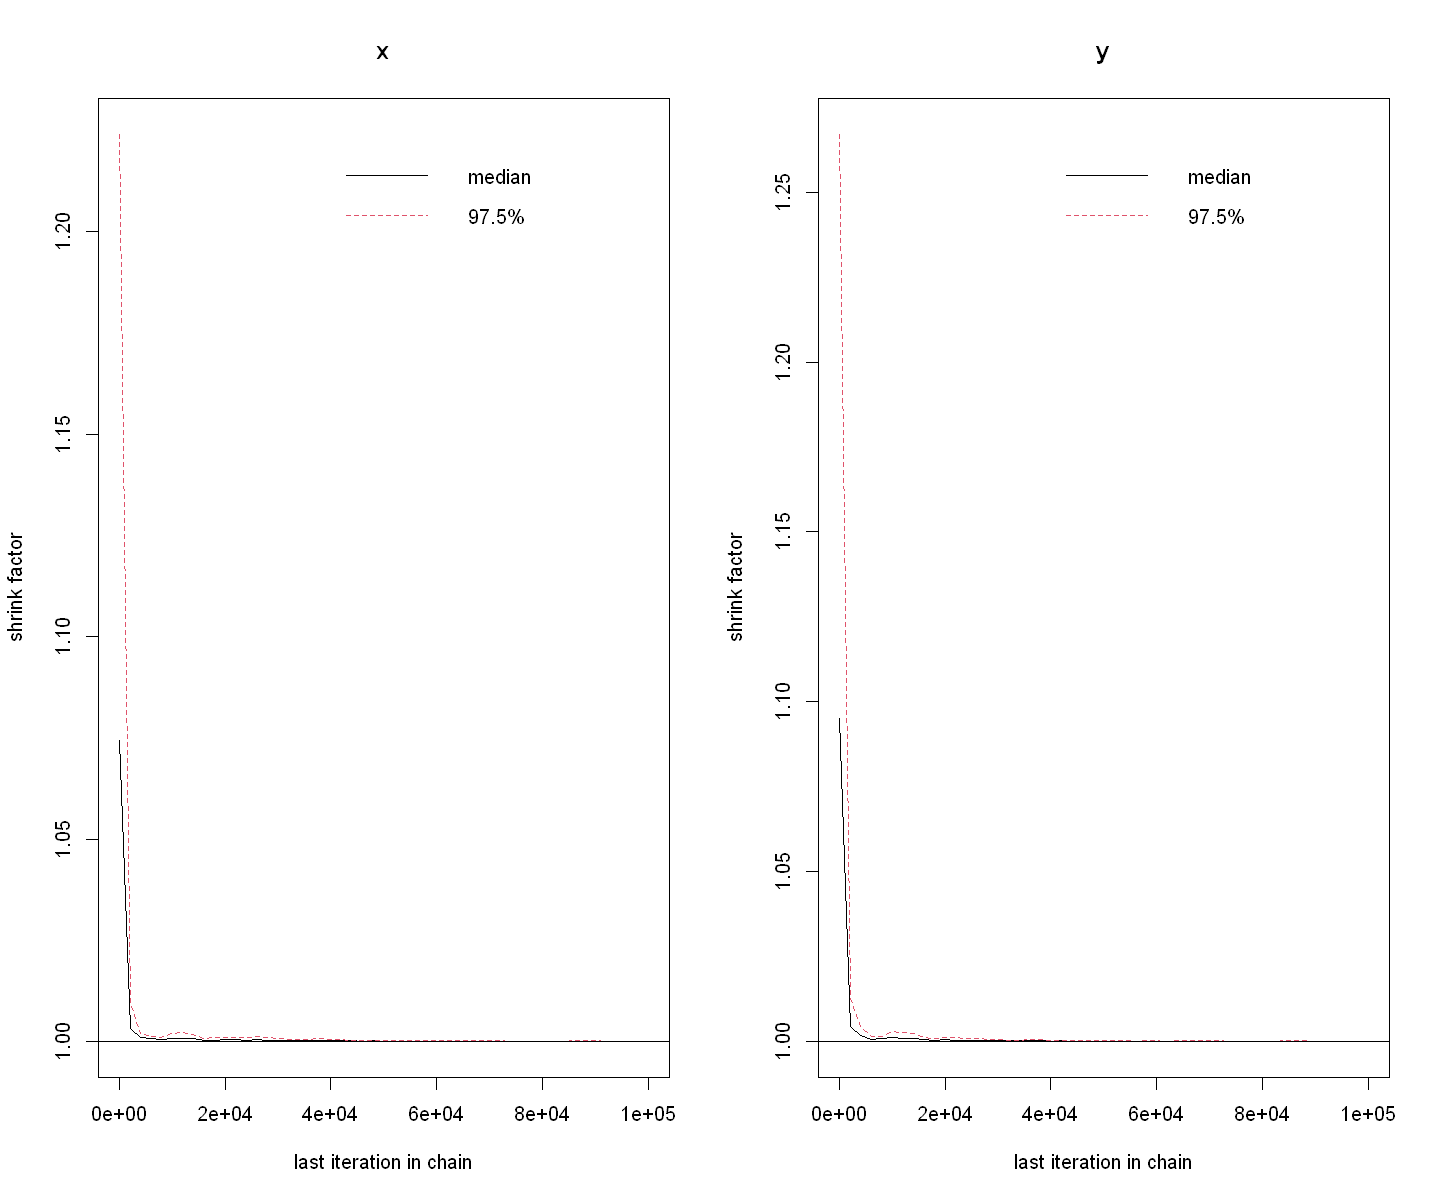

In [137]:
gibbs_list_coda_with_burn_in <- list()
for (i in 1:4) {
    gibbs_list_coda_with_burn_in[[i]] <- gibbs_chains_df_trace |>
                                           filter(chain_index == i) |>
                                           select(c(x, y)) |>
                                           as.matrix() |>
                                           coda::mcmc()
}
gibbs_list_coda_with_burn_in <- coda::mcmc.list(gibbs_list_coda_with_burn_in)
gr_gibbs_plot <- coda::gelman.plot(gibbs_list_coda_with_burn_in,
                                   autoburnin = FALSE)

In [138]:
gr_gibbs_plot_tibble <- as_tibble(gr_gibbs_plot$shrink) |>
                          mutate(t = gr_gibbs_plot$last.iter) |>
                          rename(x_median = x.median, y_median = y.median,
                                 "x_97.5%" = "x.97.5%",
                                 "y_97.5%" = "y.97.5%") |>
                          pivot_longer(!t, names_to = "R_type",
                                       values_to = "R") |>
                          select(c(t, R, R_type)) |>
                          mutate("R-1" = R - 1)

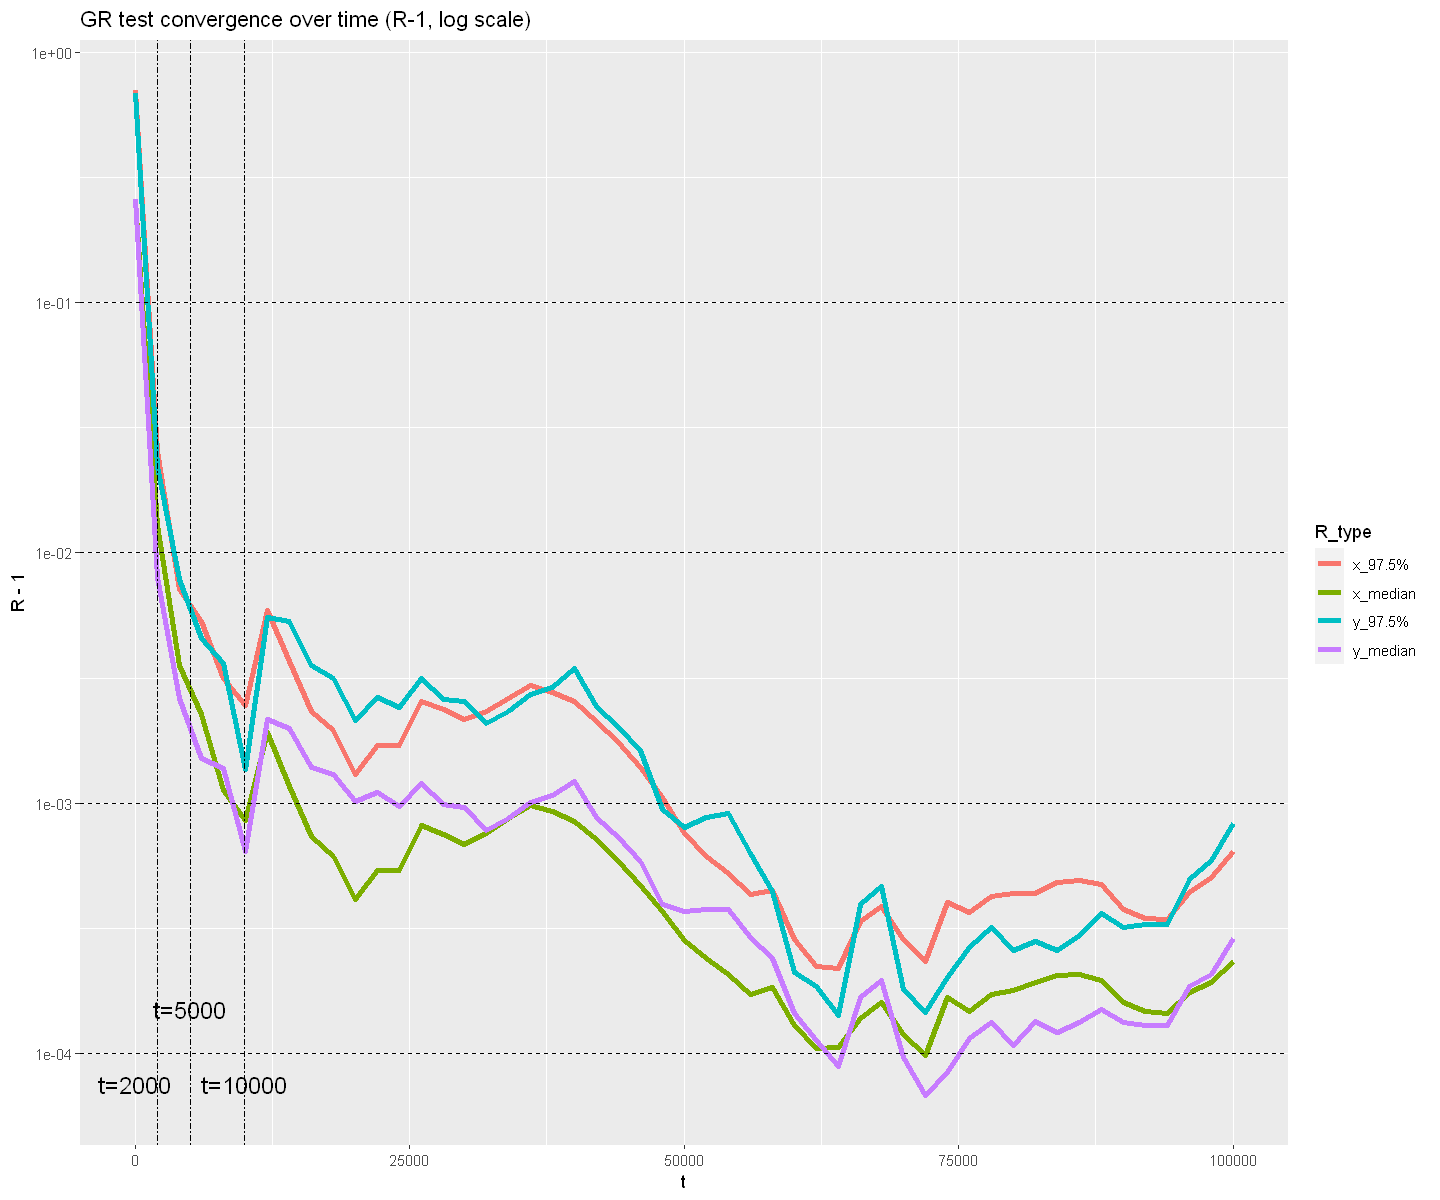

In [139]:
ggplot(gr_mh_plot_tibble, aes(x = t, y = R-1, color = R_type)) +
  geom_line(lwd = 1.5) +
  scale_y_log10() +
  geom_hline(yintercept = 10 ^ (- (1:4)), linetype = "dashed") +
  ggtitle("GR test convergence over time (R-1, log scale)") +
  geom_vline(xintercept = c(2, 5, 10) * 1e3, linetype = "twodash") +
  annotate("text", x = 0, y = 0.75e-4, label = "t=2000", size = 5) +
  annotate("text", x = 5e3, y = 1.5e-4, label = "t=5000", size = 5) +
  annotate("text", x = 1e4, y = 0.75e-4, label = "t=10000", size = 5)

In [140]:
gr_mh_plot$shrink[1:10, c("x", "y"), "median"] - 1

,x,y
51,0.2570815739,0.2592802717
2050,0.0128476408,0.0080144740
4049,0.0035611597,0.0026188726
6048,0.0022688411,0.0015123802
8047,0.0011246093,0.0013777750
10046,0.0008517252,0.0006396202
12045,0.0019134746,0.0021517302
14044,0.0011623711,0.0019871211
16043,0.0007322472,0.0013901443
18042,0.0006102645,0.0012969313


As in the MH section we obtain that by setting $t_{burn-in} = 10^4$ we obtain $R - 1 < 10^{-3}$, but that if one is content with $R - 1 < 10^{-2}$ then it's possible to stop at about $4\cdot 10^3$ samples.

## Marginalization with Gibbs generated dataset
As usual we start with plotting the two marginals superimposed on the complete 2D scatterplot.

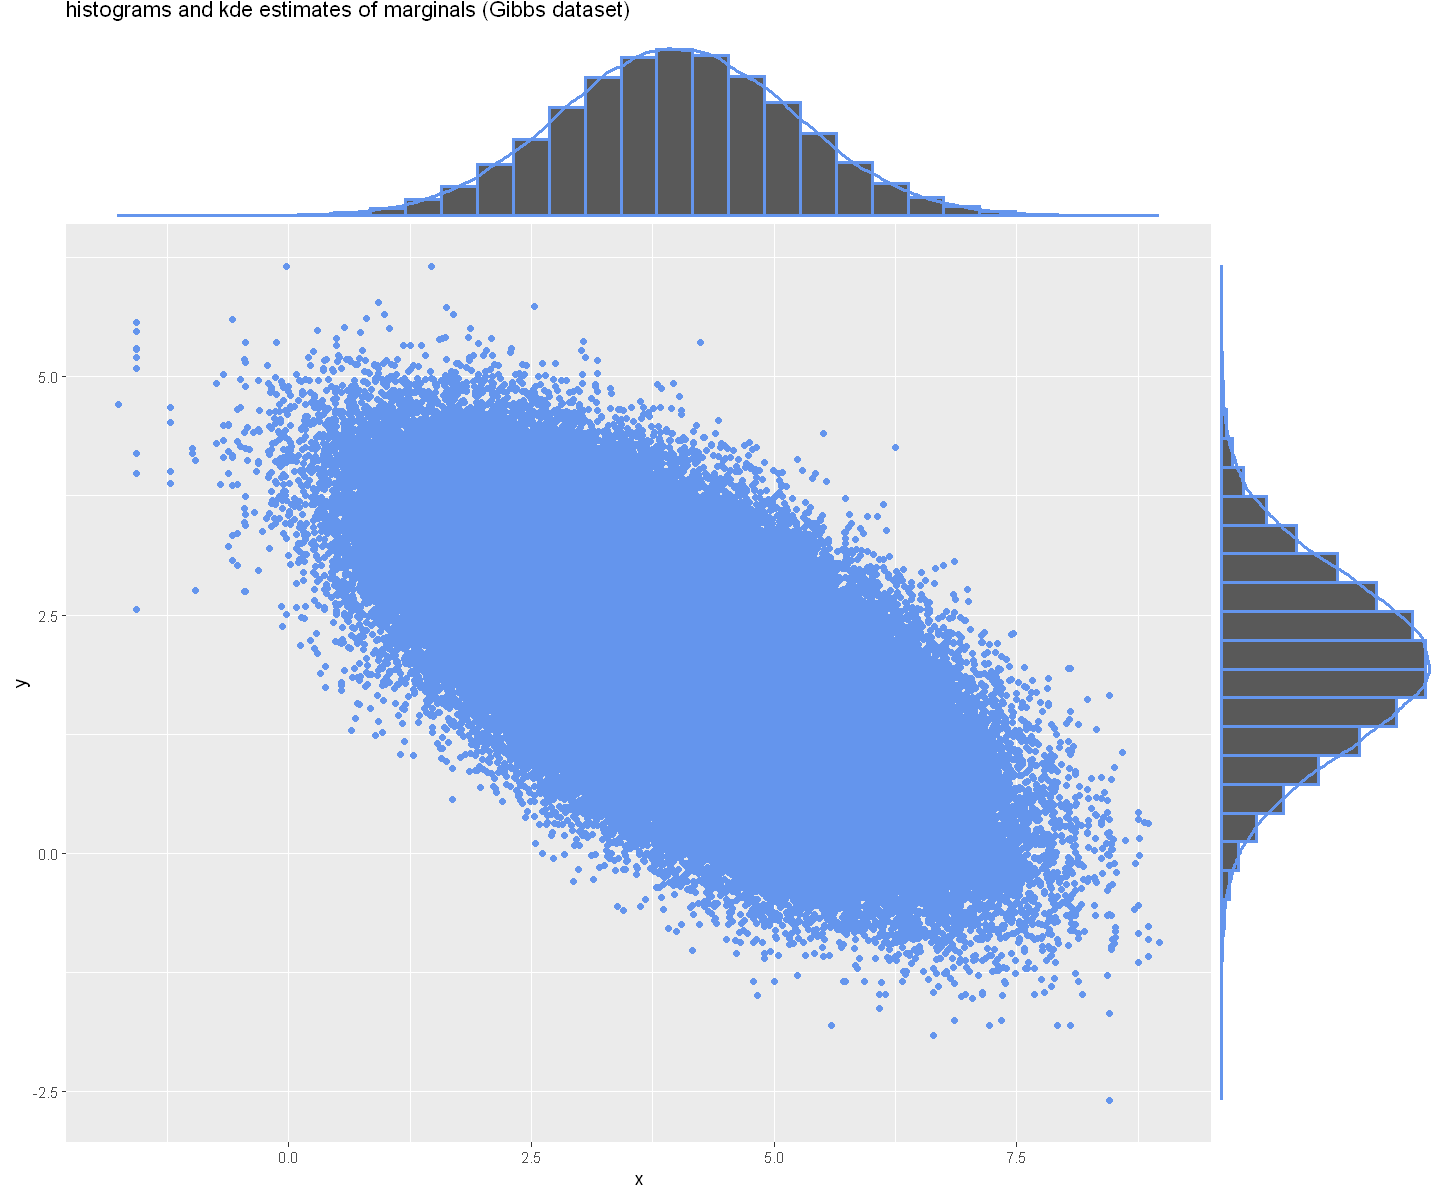

In [141]:
ggExtra::ggMarginal(ggplot(gibbs_chains_df_trace_burn_in, aes(x, y)) +
                    geom_point(color = "cornflowerblue") +
                    ggtitle("histograms and kde estimates of marginals (Gibbs dataset)"),
                    type = "densigram", color = "cornflowerblue", lwd = 1)

### $x$ Gibbs marginal

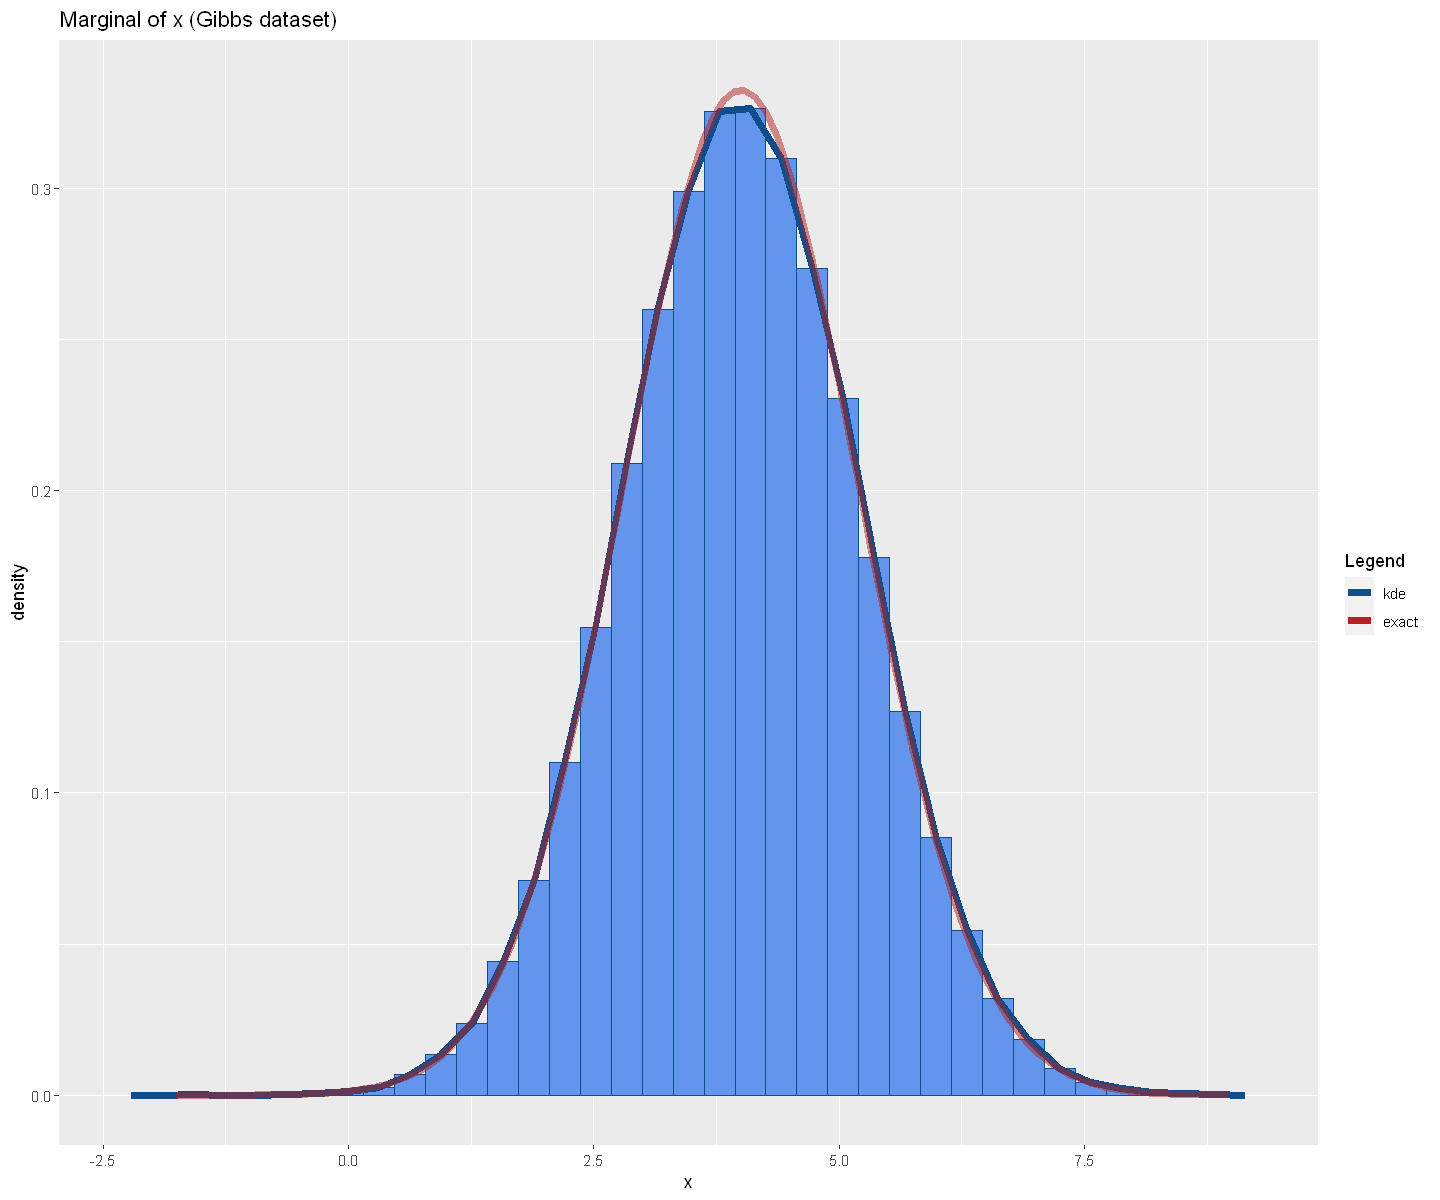

In [142]:
ggplot(gibbs_chains_df_trace_burn_in) +
  geom_histogram(aes(x = x, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = x, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_x, sd = sigma_x),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle("Marginal of x (Gibbs dataset)") +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [143]:
print("Mean KLD between Gibbs & exact x marginal:")
print(kld_sampled_exact_distribution(gibbs_chains_df_trace_burn_in$x, mu_x, sigma_x))

[1] "Mean KLD between Gibbs & exact x marginal:"
[1] 0.0001990653


The fit between the empirical and theoretical distributions is as good as in the MH case.

#### Gibbs $95\%$ credibility interval for $x$
##### Estimate via histograms

In [144]:
cov_gibbs_df <- gibbs_chains_df_trace_burn_in |> select(c(x, y)) |> cov()
cov_gibbs_df

,x,y
x,1.4512520,-0.7105973
y,-0.7105973,0.8170888


In [145]:
# we estimate the max using kde
max_gibbs_x <- density(gibbs_chains_df_trace_burn_in$x, n = 1024)$x[which.max(density(gibbs_chains_df_trace_burn_in$x, n = 1024)$y)]

# since the distribution is approximately gaussian we expect that
# the mean ± 2 sigma rule should still be approximately valid;
# this gives us a simple starting point, i.e. we can tweak a parameter
# k until we find a desired 95% interval of the kind mean ± k sigma
k_x_gibbs_marginal <- 1.671
x1_gibbs <- max_gibbs_x - k_x_gibbs_marginal * cov_gibbs_df[1, 1]
x2_gibbs <- max_gibbs_x + k_x_gibbs_marginal * cov_gibbs_df[1, 1]

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Gibbs: area of x's marginal between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              x1_gibbs, x2_gibbs, k_x_gibbs_marginal))
mean((x1_gibbs < gibbs_chains_df_trace_burn_in$x) & (gibbs_chains_df_trace_burn_in$x < x2_gibbs)) |> print()

[1] "Gibbs: area of x's marginal between 1.50 and 6.35 (argmax ± 1.67 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9551333


In [146]:
print("theoretical 95% credibility interval for x:")
print(sprintf("[%.2f, %.2f]", x1, x2))

[1] "theoretical 95% credibility interval for x:"
[1] "[1.60, 6.40]"


In [147]:
print(sprintf("ratio between theoretical and Gibbs empirical sigma_x = %f", cov_gibbs_df[1, 1] / sigma_x))
print(sprintf("2/%.3f = %f", k_x_gibbs_marginal, 2 / k_x_gibbs_marginal))

[1] "ratio between theoretical and Gibbs empirical sigma_x = 1.209377"
[1] "2/1.671 = 1.196888"


In [148]:
print(sprintf("center of Gibbs empirical x marginal = %.2f", max_gibbs_x))
print(sprintf("center of theoretical x marginal = %.2f", mu_x))

[1] "center of Gibbs empirical x marginal = 3.92"
[1] "center of theoretical x marginal = 4.00"


These results are similar to the earlier ones.

#### Estimate via kde

In [149]:
cat(sprintf("Gibbs: area of x's marginal between %.2f and %.2f (mean ± %.2f * std):",
            x1_gibbs, x2_gibbs, k_x_gibbs_marginal))
integrate(\ (x) approxfun(density(gibbs_chains_df_trace_burn_in$x))(x),
          x1_gibbs, x2_gibbs)

Gibbs: area of x's marginal between 1.50 and 6.35 (mean ± 1.67 * std):

0.9558863 with absolute error < 8.3e-05

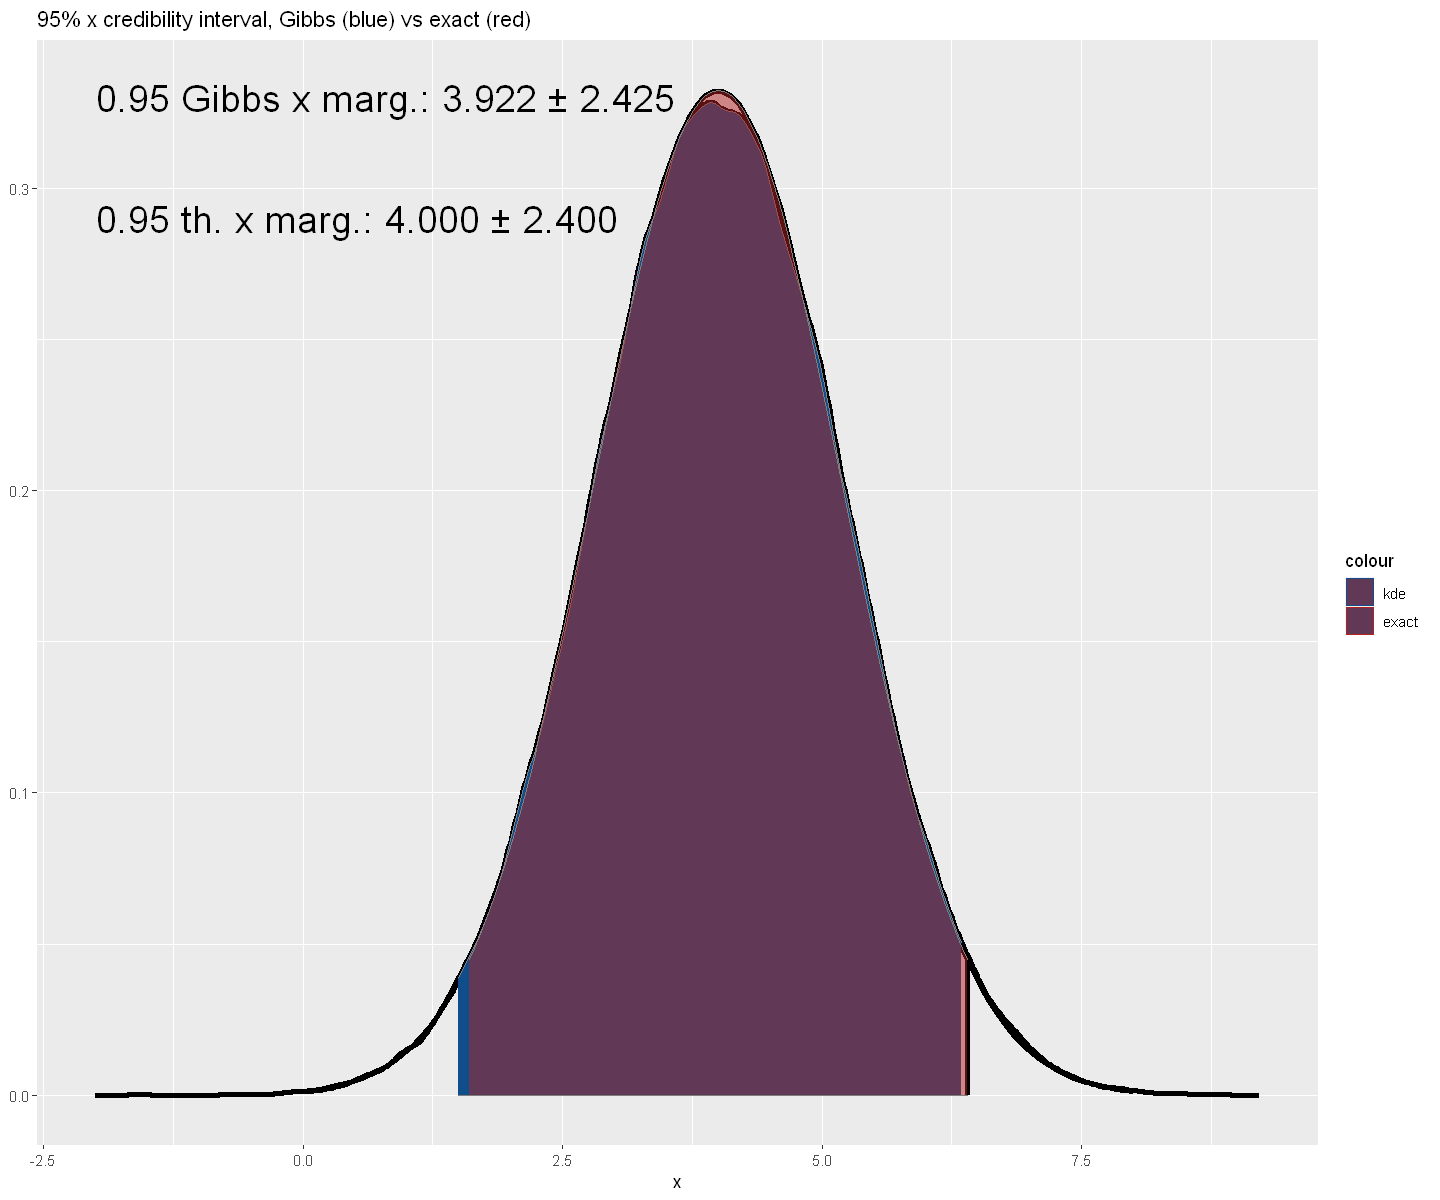

In [150]:
ggplot() + geom_line(data = marginal_x_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = x1, xend = x1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2, xend = x2, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(gibbs_chains_df_trace_burn_in$x)$x,
                              y = density(gibbs_chains_df_trace_burn_in$x)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(gibbs_chains_df_trace_burn_in$x))(.x),
                xlim = c(x1_gibbs, x2_gibbs),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x, sd = sigma_x),
                xlim = c(x1, x2),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x credibility interval, Gibbs (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = 0.8, y = 0.33,
           label = sprintf("0.95 Gibbs x marg.: %.3f ± %.3f",
           max_gibbs_x, k_x_gibbs_marginal * cov_gibbs_df[1, 1]), size = 8) +
  annotate("text", x = 0.52, y = 0.29,
           label = sprintf("0.95 th. x marg.: %.3f ± %.3f",
           mu_x, 2 * sigma_x), size = 8)

### $y$ Gibbs marginal

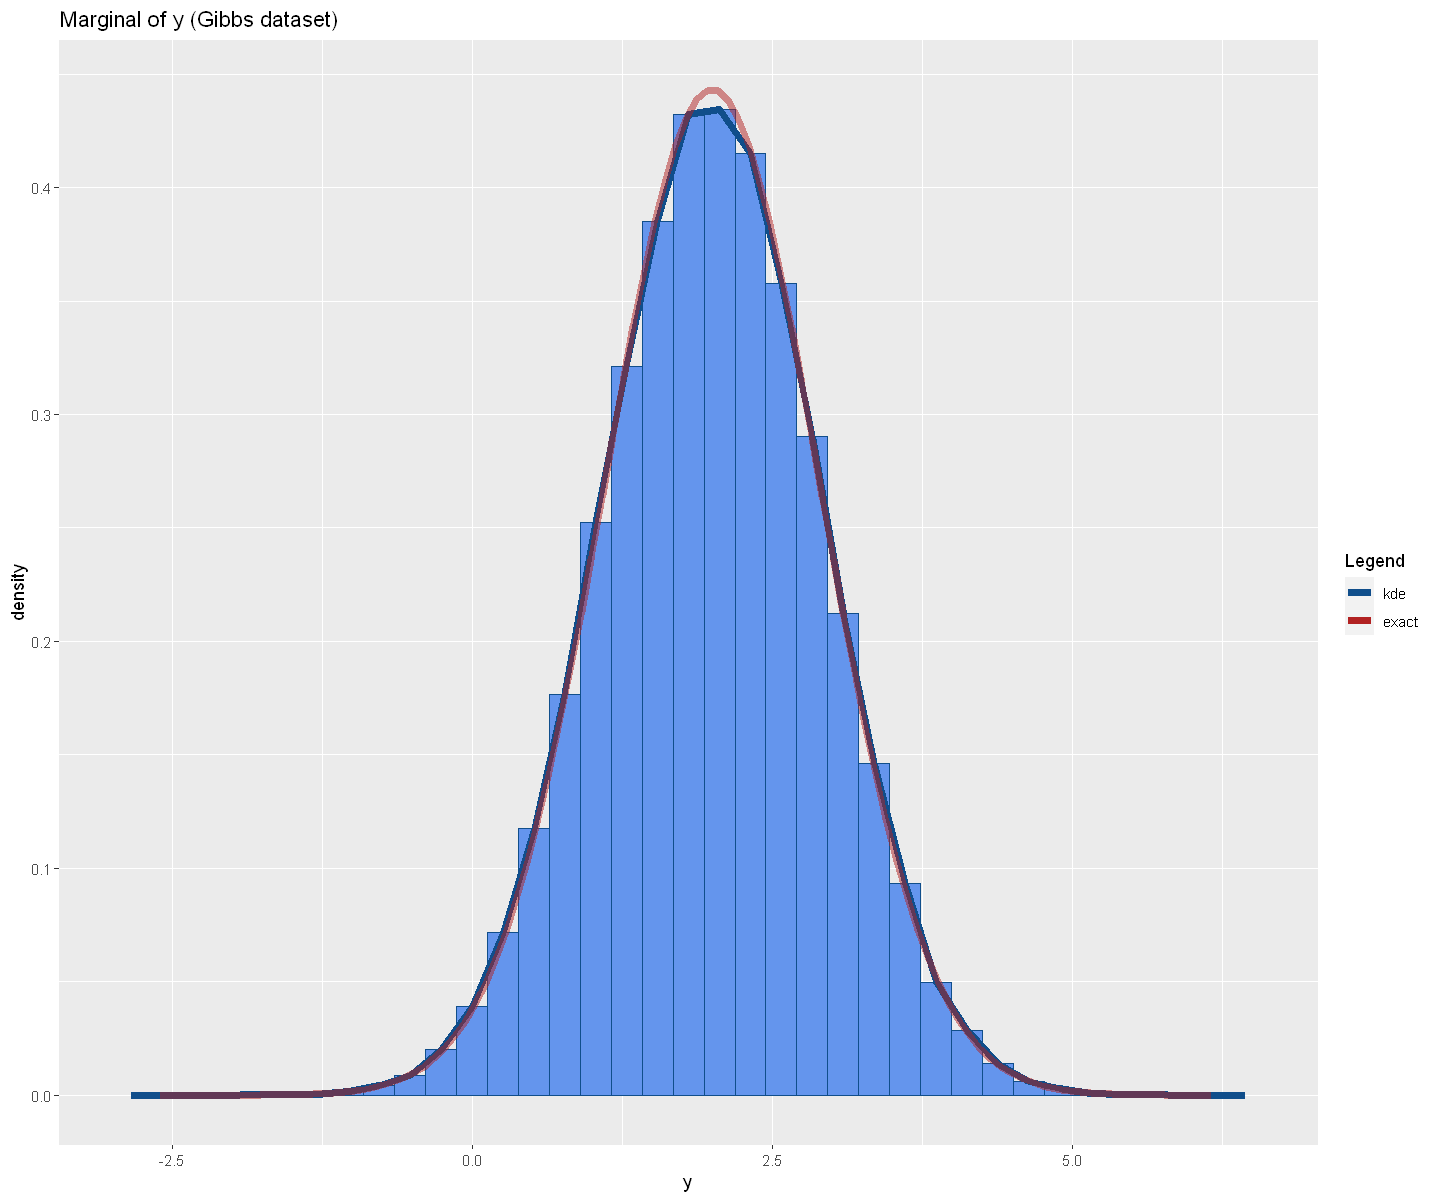

In [151]:
ggplot(gibbs_chains_df_trace_burn_in) +
  geom_histogram(aes(x = y, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = y, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_y, sd = sigma_y),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle("Marginal of y (Gibbs dataset)") +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [152]:
print("Mean KLD between Gibbs & exact y marginal:")
print(kld_sampled_exact_distribution(gibbs_chains_df_trace_burn_in$y, mu_y, sigma_y))

[1] "Mean KLD between Gibbs & exact y marginal:"
[1] 0.0001716581


#### Gibbs $95\%$ credibility interval for $y$
##### Estimate via histograms

In [153]:
# we estimate the max using kde
max_gibbs_y <- density(gibbs_chains_df_trace_burn_in$y, n = 1024)$x[which.max(density(gibbs_chains_df_trace_burn_in$y, n = 1024)$y)]

k_y_gibbs_marginal <- 2.23
y1_gibbs <- max_gibbs_y - k_y_gibbs_marginal * cov_gibbs_df[2, 2]
y2_gibbs <- max_gibbs_y + k_y_gibbs_marginal * cov_gibbs_df[2, 2]

print(sprintf("Gibbs: area of y's marginal between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              y1_gibbs, y2_gibbs, k_y_gibbs_marginal))
mean((y1_gibbs < gibbs_chains_df_trace_burn_in$y) & (gibbs_chains_df_trace_burn_in$y < y2_gibbs)) |> print()

[1] "Gibbs: area of y's marginal between 0.12 and 3.76 (argmax ± 2.23 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9567667


In [154]:
print("theoretical 95% credibility interval for y:")
print(sprintf("[%.2f, %.2f]", y1, y2))

[1] "theoretical 95% credibility interval for y:"
[1] "[0.20, 3.80]"


In [155]:
print(sprintf("ratio between theoretical and Gibbs empirical sigma_x = %f", cov_gibbs_df[1, 1] / sigma_x))
print(sprintf("2/%.3f = %f", k_x_gibbs_marginal, 2 / k_x_gibbs_marginal))

[1] "ratio between theoretical and Gibbs empirical sigma_x = 1.209377"
[1] "2/1.671 = 1.196888"


In [156]:
print(sprintf("center of Gibbs empirical y marginal = %.2f", max_gibbs_y))
print(sprintf("center of theoretical y marginal = %.2f", mu_y))

[1] "center of Gibbs empirical y marginal = 1.94"
[1] "center of theoretical y marginal = 2.00"


#### Estimate via kde

In [157]:
cat(sprintf("Gibbs: area of y's marginal between %.2f and %.2f (mean ± %.2f * std):",
            y1_gibbs, y2_gibbs, k_y_gibbs_marginal))
integrate(\ (x) approxfun(density(gibbs_chains_df_trace_burn_in$y))(x),
          y1_gibbs, y2_gibbs)

Gibbs: area of y's marginal between 0.12 and 3.76 (mean ± 2.23 * std):

0.9568397 with absolute error < 7.4e-05

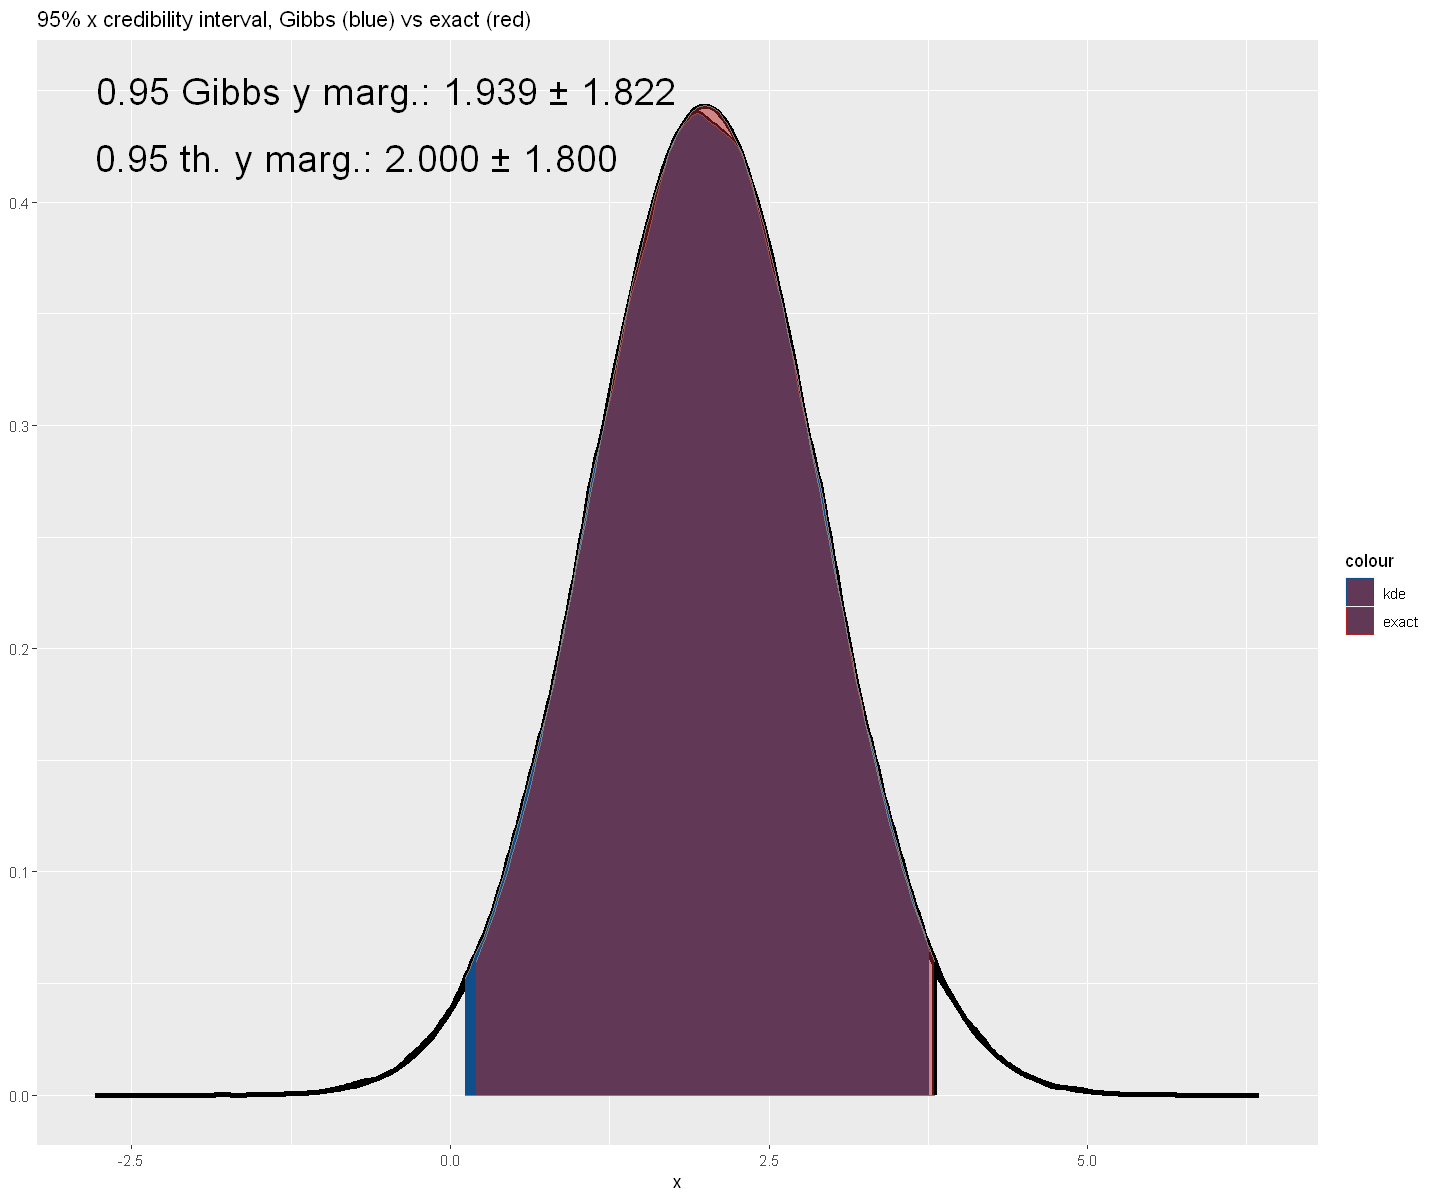

In [158]:
ggplot() + geom_line(data = marginal_y_df, mapping = aes(x, y), lwd = 1.5) +
  annotate("segment", x = y1, xend = y1, y = 0, yend = 0.045,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2, xend = y2, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(gibbs_chains_df_trace_burn_in$y)$x,
                              y = density(gibbs_chains_df_trace_burn_in$y)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(gibbs_chains_df_trace_burn_in$y))(.x),
                xlim = c(y1_gibbs, y2_gibbs),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y, sd = sigma_y),
                xlim = c(y1, y2),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x credibility interval, Gibbs (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = -0.5, y = 0.45,
           label = sprintf("0.95 Gibbs y marg.: %.3f ± %.3f",
           max_gibbs_y, k_y_gibbs_marginal * cov_gibbs_df[2, 2]), size = 8) +
  annotate("text", x = -0.73, y = 0.42,
           label = sprintf("0.95 th. y marg.: %.3f ± %.3f",
           mu_y, 2 * sigma_y), size = 8)

## Conditioning with Gibbs generated dataset
We repeat the same analysis done before.

### $x$ Gibbs conditional

In [159]:
# to compare with the exact case we still consider the y = 3 conditional
eps_y         <- 0.1
y1_cond_gibbs <- 3 - eps_y
y2_cond_gibbs <- 3 + eps_y

conditional_x_df_gibbs <- gibbs_chains_df_trace_burn_in |> filter(y1_cond_gibbs < y & y < y2_cond_gibbs)
print(sprintf("number of elements with %.2f < y < %.2f: %d",
              y1_cond_gibbs, y2_cond_gibbs, length(conditional_x_df_gibbs$x)))

[1] "number of elements with 2.90 < y < 3.10: 17467"


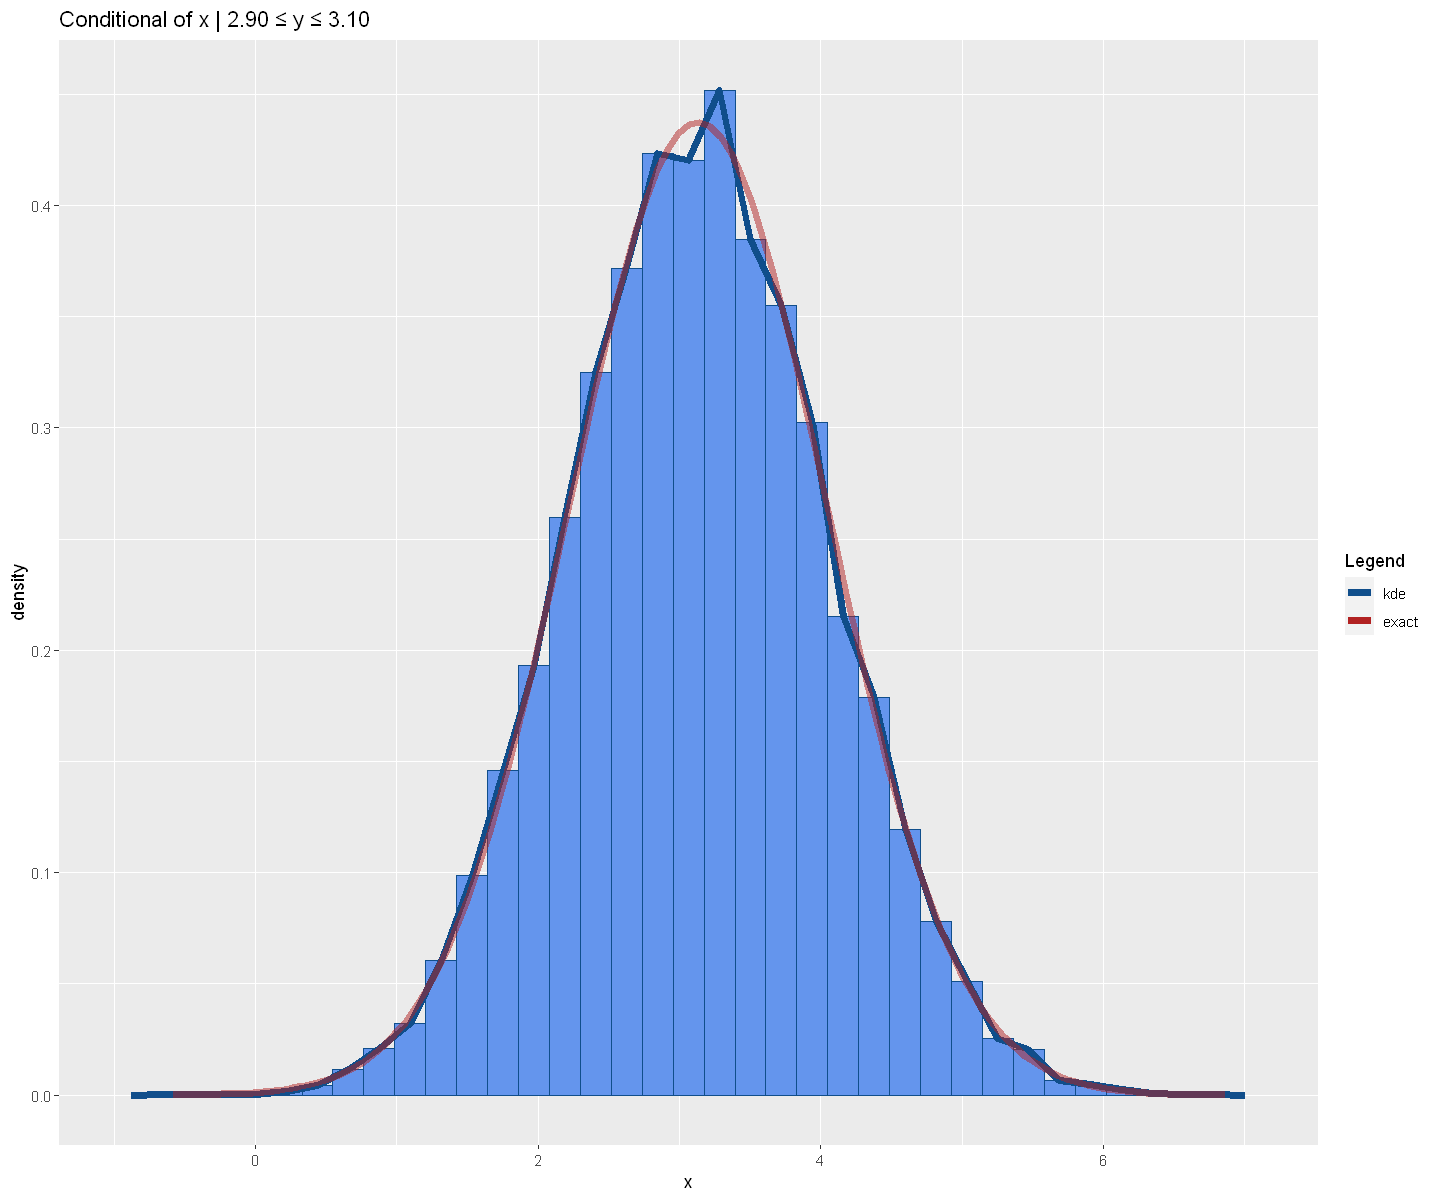

In [160]:
ggplot(conditional_x_df_gibbs) +
  geom_histogram(aes(x = x, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = x, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_x_conditional, sd = sigma_x_conditional),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle(sprintf("Conditional of x | %.2f ≤ y ≤ %.2f", y1_cond_gibbs, y2_cond_gibbs)) +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [161]:
print("Mean KLD between MH & exact x conditional:")
print(kld_sampled_exact_distribution(conditional_x_df_gibbs$x, mu_x_conditional, sigma_x_conditional))

[1] "Mean KLD between MH & exact x conditional:"
[1] 0.0004470065


As usual the fit is slightly worse because of the smaller dataset, but overall still quite solid.

#### Gibbs $95\%$ credibility interval for $x|y\approx 3$
##### Estimate via histograms

In [162]:
# we estimate the max using kde
max_gibbs_x_cond      <- density(conditional_x_df_gibbs$x, n = 1024)$x[which.max(density(conditional_x_df_gibbs$x, n = 1024)$y)]
sigma_x_conditional_gibbs <- sd(conditional_x_df_gibbs$x)

k_x_cond_gibbs   <- 2.011
x1_gibbs_cond <- max_gibbs_x_cond - k_x_cond_gibbs * sigma_x_conditional_gibbs
x2_gibbs_cond <- max_gibbs_x_cond + k_x_cond_gibbs * sigma_x_conditional_gibbs

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Gibbs: area of x|y = 3 conditional between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              x1_gibbs_cond, x2_gibbs_cond, k_x_cond_gibbs))
mean((x1_gibbs_cond < conditional_x_df_gibbs$x) & (conditional_x_df_gibbs$x < x2_gibbs_cond)) |> print()

[1] "Gibbs: area of x|y = 3 conditional between 1.39 and 5.05 (argmax ± 2.01 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9559169


In [163]:
print("theoretical 95% credibility interval for x|y = 3:")
print(sprintf("[%.2f, %.2f]", x1_cond, x2_cond))

[1] "theoretical 95% credibility interval for x|y = 3:"
[1] "[1.31, 4.96]"


In [164]:
print(sprintf("ratio between theoretical and Gibbs empirical sigma_x = %f", sigma_x_conditional_gibbs / sigma_x_conditional))
print(sprintf("2/%.3f = %f", k_x_cond_gibbs, 2 / k_x_cond_gibbs))

[1] "ratio between theoretical and Gibbs empirical sigma_x = 0.997283"
[1] "2/2.011 = 0.994530"


In [165]:
print(sprintf("center of Gibbs empirical x|y = 3 conditional = %.2f", max_gibbs_x_cond))
print(sprintf("center of theoretical x|y = 3 conditional = %.2f", mu_x_conditional))

[1] "center of Gibbs empirical x|y = 3 conditional = 3.22"
[1] "center of theoretical x|y = 3 conditional = 3.13"


#### Estimate via kde

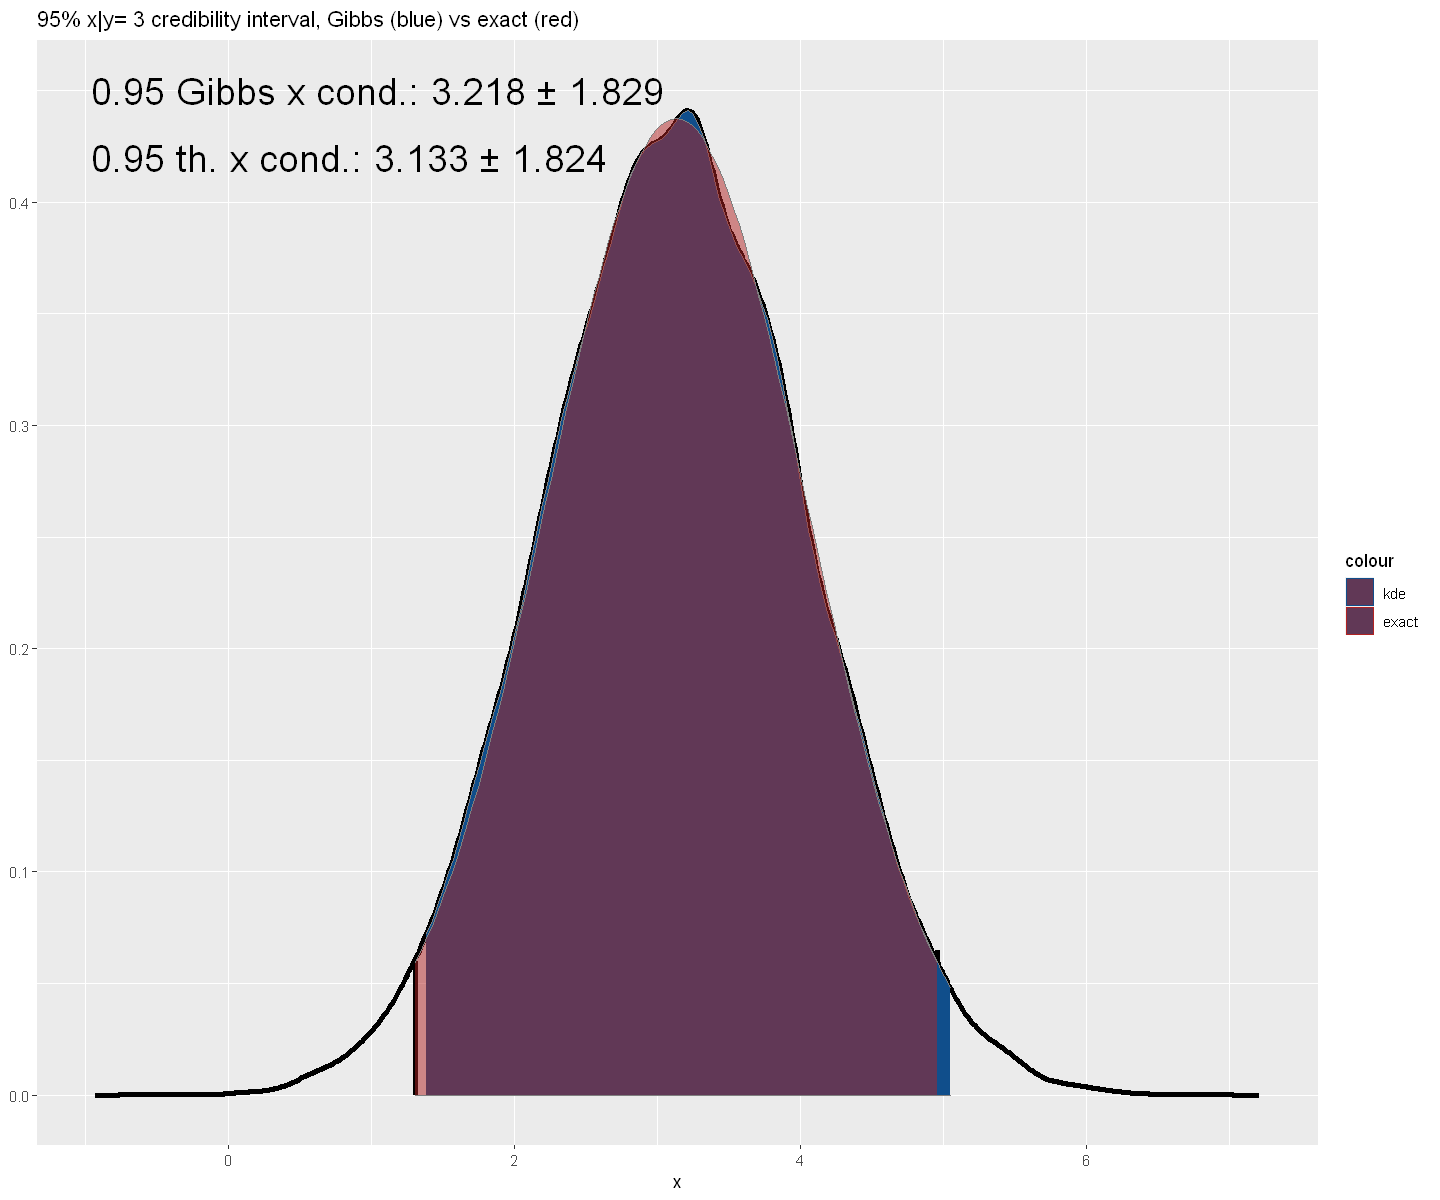

In [166]:
ggplot() +
  annotate("segment", x = x1_cond, xend = x1_cond, y = 0, yend = 0.06,
           color = "black", lwd = 1.5) +
  annotate("segment", x = x2_cond, xend = x2_cond, y = 0, yend = 0.065,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(conditional_x_df_gibbs$x)$x,
                              y = density(conditional_x_df_gibbs$x)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(conditional_x_df_gibbs$x))(.x),
                xlim = c(x1_gibbs_cond, x2_gibbs_cond),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_x_conditional, sd = sigma_x_conditional),
                xlim = c(x1_cond, x2_cond),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% x|y= 3 credibility interval, Gibbs (blue) vs exact (red)") +
  labs(x = "x", y = NULL) +
  annotate("text", x = 1.05, y = 0.45,
           label = sprintf("0.95 Gibbs x cond.: %.3f ± %.3f",
           max_gibbs_x_cond, k_x_cond_gibbs * sigma_x_conditional_gibbs),
           size = 8) +
  annotate("text", x = 0.85, y = 0.42,
           label = sprintf("0.95 th. x cond.: %.3f ± %.3f",
           mu_x_conditional, 2 * sigma_x_conditional), size = 8)

### $y$ MH conditional

In [167]:
# to compare with the exact case we still consider the x = 2.5 conditional
eps_x      <- 0.2 # epsilon chosen to achieve the same o.o.m. of elements in the dataset as in the previous conditional
x1_cond_gibbs <- 2.5 - eps_x
x2_cond_gibbs <- 2.5 + eps_x

conditional_y_df_gibbs <- gibbs_chains_df_trace_burn_in |> filter(x1_cond_gibbs < x & x < x2_cond_gibbs)
print(sprintf("number of elements with %.2f < x < %.2f: %d", x1_cond_gibbs, x2_cond_gibbs, length(conditional_y_df_gibbs$x)))

[1] "number of elements with 2.30 < x < 2.70: 21776"


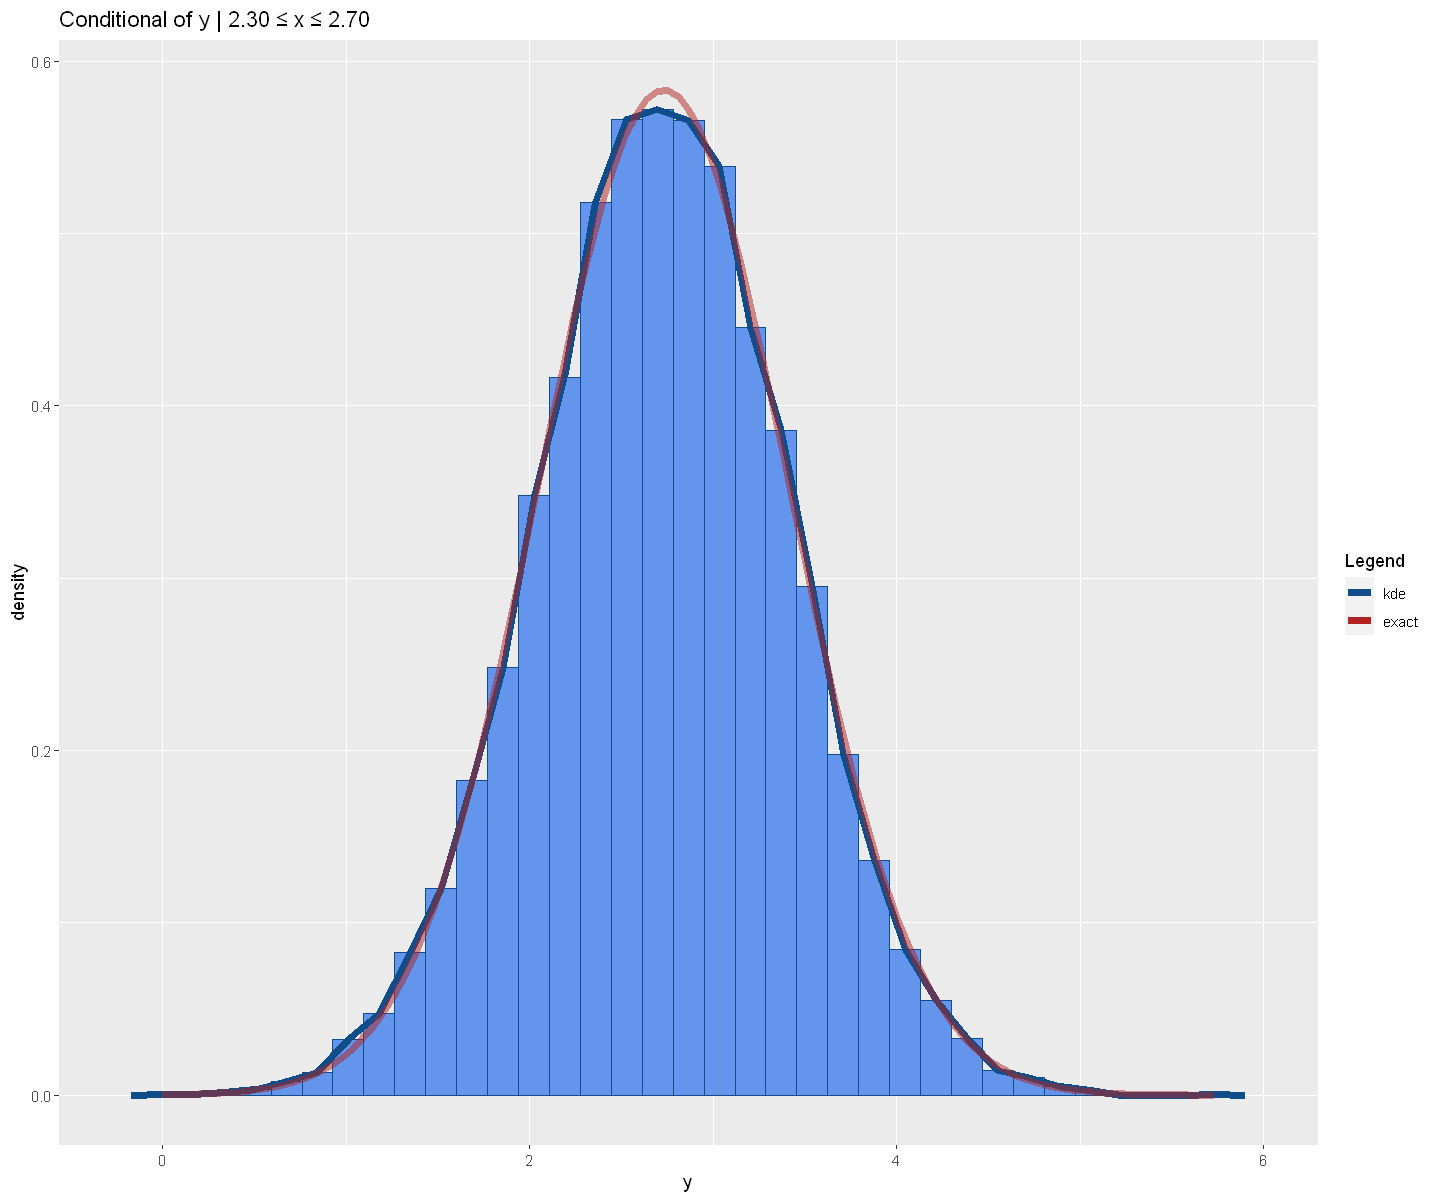

In [168]:
ggplot(conditional_y_df_gibbs) +
  geom_histogram(aes(x = y, y = ..density..), color = "dodgerblue4",
                 fill = "cornflowerblue", bins = 35) +
  geom_freqpoly(aes(x = y, y = ..density.., color = "kde"),
                lwd = 2, bins = 35) +
  geom_function(fun = ~ dnorm(.x, mean = mu_y_conditional, sd = sigma_y_conditional),
                lwd = 2, color = "firebrick", alpha = 0.5) +
  ggtitle(sprintf("Conditional of y | %.2f ≤ x ≤ %.2f", x1_cond_gibbs, x2_cond_gibbs)) +
  labs(color = "Legend") +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick"))

In [169]:
print("Mean KLD between Gibbs & exact y conditional:")
print(kld_sampled_exact_distribution(conditional_y_df_gibbs$y, mu_y_conditional, sigma_y_conditional))

[1] "Mean KLD between Gibbs & exact y conditional:"
[1] 0.0005898802


#### Gibbs $95\%$ credibility interval for $y|x\approx 2.5$
##### Estimate via histograms

In [170]:
# we estimate the max using kde
max_gibbs_y_cond          <- density(conditional_y_df_gibbs$y, n = 1024)$x[which.max(density(conditional_y_df_gibbs$y, n = 1024)$y)]
sigma_y_conditional_gibbs <- sd(conditional_y_df_gibbs$y)

k_y_cond_gibbs <- 2.011
y1_gibbs_cond  <- max_gibbs_y_cond - k_y_cond_gibbs * sigma_y_conditional_gibbs
y2_gibbs_cond  <- max_gibbs_y_cond + k_y_cond_gibbs * sigma_y_conditional_gibbs

# now we count the number of elements inside this range and divide by tot. n.
print(sprintf("Gibbs: area of x|y = 3 conditional between %.2f and %.2f (argmax ± %.2f * std) (estimated using ratio of numbers of histogram elements):",
              y1_gibbs_cond, y2_gibbs_cond, k_y_cond_gibbs))
mean((y1_gibbs_cond < conditional_y_df_gibbs$y) & (conditional_y_df_gibbs$y < y2_gibbs_cond)) |> print()

[1] "Gibbs: area of x|y = 3 conditional between 1.29 and 4.05 (argmax ± 2.01 * std) (estimated using ratio of numbers of histogram elements):"
[1] 0.9539401


In [171]:
print("theoretical 95% credibility interval for y|x = 2.5:")
print(sprintf("[%.2f, %.2f]", y1_cond, y2_cond))

[1] "theoretical 95% credibility interval for y|x = 2.5:"
[1] "[1.36, 4.10]"


In [172]:
print(sprintf("ratio between theoretical and Gibbs empirical sigma_y_conditional = %f", sigma_y_conditional_gibbs / sigma_y_conditional))
print(sprintf("2/%.3f = %f", k_y_cond_gibbs, 2 / k_y_cond_gibbs))

[1] "ratio between theoretical and Gibbs empirical sigma_y_conditional = 1.000835"
[1] "2/2.011 = 0.994530"


In [173]:
print(sprintf("center of Gibbs empirical y|x = 2.5 conditional = %.2f", max_gibbs_y_cond))
print(sprintf("center of theoretical y|x = 2.5 conditional = %.2f", mu_y_conditional))

[1] "center of Gibbs empirical y|x = 2.5 conditional = 2.67"
[1] "center of theoretical y|x = 2.5 conditional = 2.73"


#### Estimate via kde

In [174]:
cat(sprintf("Gibbs: area of y|x = 2.5 conditional between %.2f and %.2f (mean ± %.2f * std):",
            y1_gibbs_cond, y2_gibbs_cond, k_y_cond))
integrate(\ (x) approxfun(density(conditional_y_df_gibbs$y))(x), y1_gibbs_cond, y2_gibbs_cond)

Gibbs: area of y|x = 2.5 conditional between 1.29 and 4.05 (mean ± 2.01 * std):

0.9532019 with absolute error < 7.1e-05

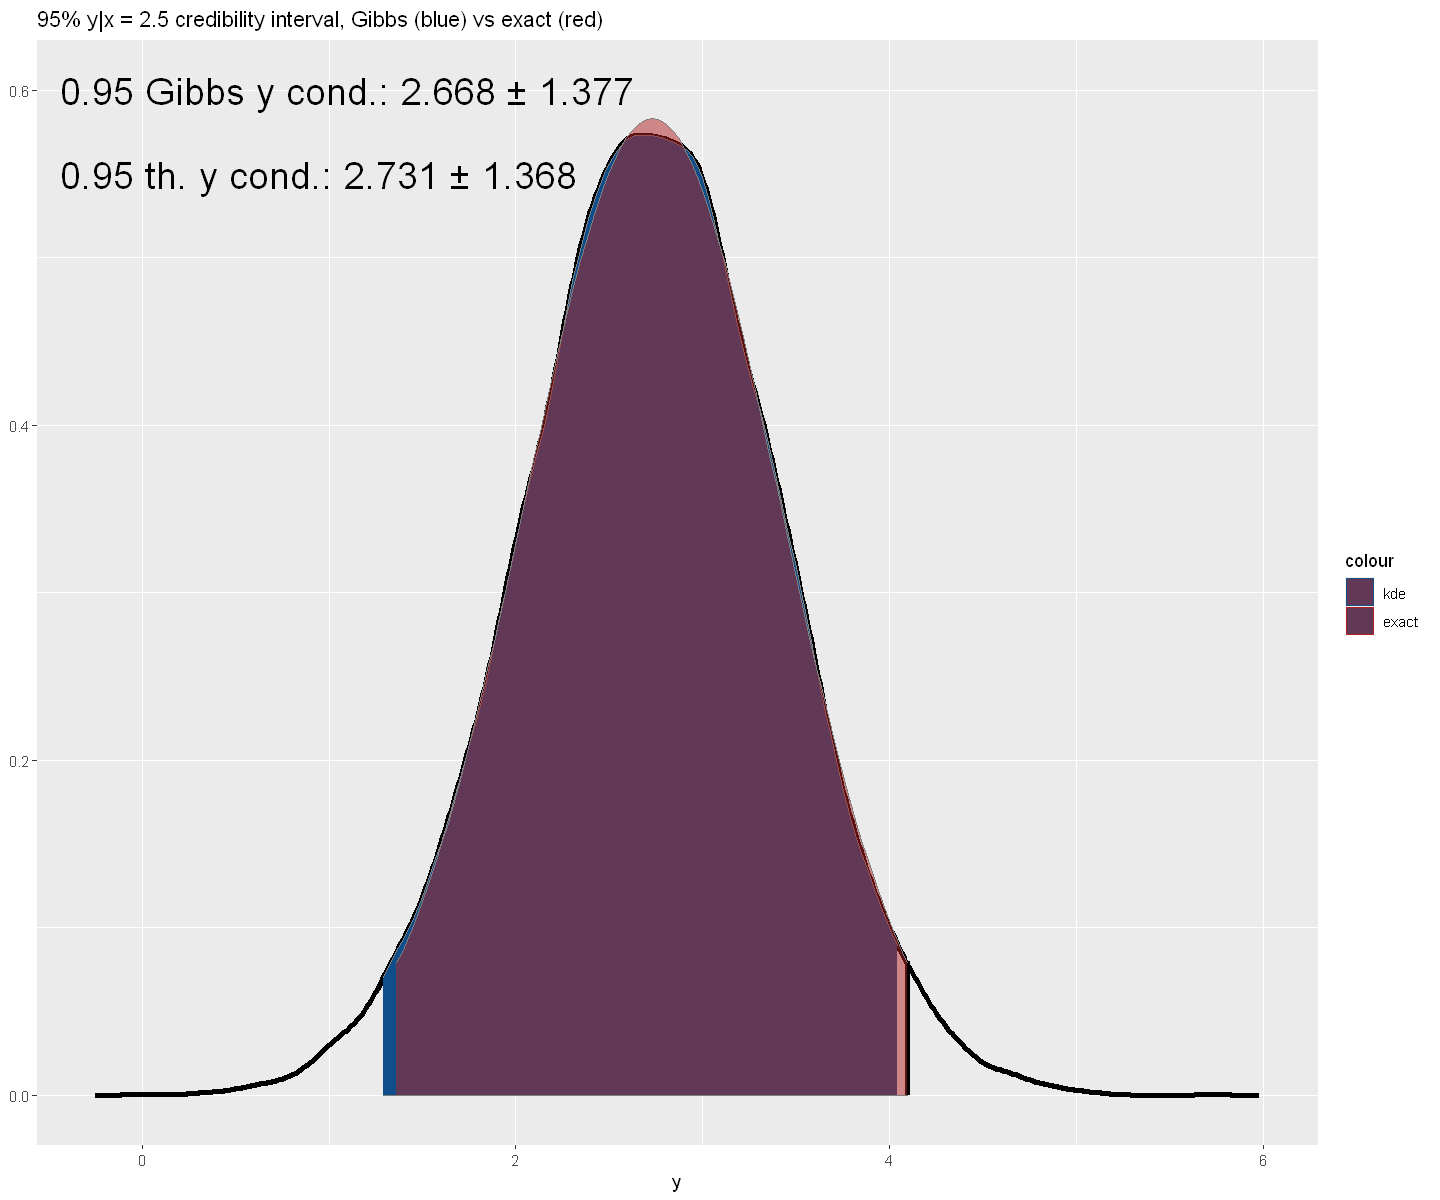

In [175]:
ggplot() +
  annotate("segment", x = y1_cond, xend = y1_cond, y = 0, yend = 0.08,
           color = "black", lwd = 1.5) +
  annotate("segment", x = y2_cond, xend = y2_cond, y = 0, yend = 0.08,
           color = "black", lwd = 1.5) +
  geom_line(data = data.frame(x = density(conditional_y_df_gibbs$y)$x,
                              y = density(conditional_y_df_gibbs$y)$y),
            mapping = aes(x = x, y = y), lwd = 1.5) +
  stat_function(fun = ~ approxfun(density(conditional_y_df_gibbs$y))(.x),
                xlim = c(y1_gibbs_cond, y2_gibbs_cond),
                geom = "area",
                fill = "dodgerblue4",
                mapping = aes(color = "dodgerblue4")) +
  stat_function(fun = dnorm,
                args = list(mean = mu_y_conditional, sd = sigma_y_conditional),
                xlim = c(y1_cond, y2_cond),
                geom = "area",
                fill = "firebrick",
                alpha = 0.5,
                mapping = aes(color = "firebrick")) +
  scale_color_manual(values = c("kde" = "dodgerblue4", "exact" = "firebrick")) +
  ggtitle("95% y|x = 2.5 credibility interval, Gibbs (blue) vs exact (red)") +
  labs(x = "y", y = NULL) +
  annotate("text", x = 1.1, y = 0.6,
           label = sprintf("0.95 Gibbs y cond.: %.3f ± %.3f",
           max_gibbs_y_cond, k_y_cond_gibbs * sigma_y_conditional_gibbs),
           size = 8) +
  annotate("text", x = 0.95, y = 0.55,
           label = sprintf("0.95 th. y cond.: %.3f ± %.3f",
           mu_y_conditional, 2 * sigma_y_conditional), size = 8)

# Conclusions
In this notebook we tried to reobtain known theoretical results about a simple distribution using three approaches: Cholesky transform based sampling, MCMC via the Metropolis-Hastings algorithm, and finally MCMC via Gibbs sampling.

To compare the three samplers we carry out the following remarks.
1. When it comes to execution performance the Cholesky sampler is clearly the best. Not only can we keep all computed points, but obtaining them is much simpler, both conceptually and in practice - code is shorter, easier to write and faster to execute: MH and Gibbs take a few seconds to sample $10^5$ points, whereas Cholesky is basically instant. The price to pay for this performance is lack of generality: the Cholesky method only works because this is a very special distribution (a Gaussian), hence is unavailable in real world problems. Still according to the "computer science" performance metric this is clearly the best sampler.
2. If we put aside the execution efficiency what we care about is how accurate MAP estimates and $95\%$ credibility intervals derived from these three samplers are - especially since we have an exact ground truth. To analyze the samplers according to this performance metric we summarize all computed estimators in the same dataframe, while also computing the percent relative different of each "experimental" value from the theoretical one. Finally to have some sort of score we compute the mean of all percent relative different associated to any particular sampler; this number doesn't really have a meaning, but it gives us an idea of the overall distance from the exact value, so we include it anyway.

In [176]:
# this cell is quite messy, but all it does is
# compute the dataframes described above

x1_marg   <- x1
x2_marg   <- x2
y1_marg   <- y1
y2_marg   <- y2
mu_x_marg <- mu_x
mu_y_marg <- mu_y
mu_x_cond <- mu_x_conditional
mu_y_cond <- mu_y_conditional


cred_int_marg_x_df <- tibble(x_marginal = c("theoretical", "Cholesky", "MH", "Gibbs"),
                             x1 = c(x1_marg, x1_chol, x1_mh, x1_gibbs),
                             x2 = c(x2_marg, x2_chol, x2_mh, x2_gibbs),
                             mu_x = c(mu_x, max_cholesky_x, max_mh_x, max_gibbs_x)) |>
                        mutate(x1_perc_diff = 100 * abs(x1 - x1_marg) / x1_marg,
                               x2_perc_diff = 100 * abs(x2 - x2_marg) / x2_marg,
                               mu_x_perc_diff = 100 * abs(mu_x - mu_x_marg) / mu_x_marg) |>
                        rowwise() |>
                        mutate(mean_perc_diff = mean(c(x1_perc_diff, x2_perc_diff, mu_x_perc_diff))) |>
                        ungroup()

cred_int_marg_y_df <- tibble(y_marginal = c("theoretical", "Cholesky", "MH", "Gibbs"),
                             y1 = c(y1_marg, y1_chol, y1_mh, y1_gibbs),
                             y2 = c(y2_marg, y2_chol, y2_mh, y2_gibbs),
                             mu_y = c(mu_y, max_cholesky_y, max_mh_y, max_gibbs_y)) |>
                        mutate(y1_perc_diff = 100 * abs(y1 - y1_marg) / y1_marg,
                               y2_perc_diff = 100 * abs(y2 - y2_marg) / y2_marg,
                               mu_y_perc_diff = 100 * abs(mu_y - mu_y_marg) / mu_y_marg) |>
                        rowwise() |>
                        mutate(mean_perc_diff = mean(c(y1_perc_diff, y2_perc_diff, mu_y_perc_diff))) |>
                        ungroup()

cred_int_cond_x_df <- tibble(x_conditional = c("theoretical", "Cholesky", "MH", "Gibbs"),
                             x1 = c(x1_cond, x1_chol_cond, x1_mh_cond, x1_gibbs_cond),
                             x2 = c(x2_cond, x2_chol_cond, x2_mh_cond, x2_gibbs_cond),
                             mu_x = c(mu_x_cond, max_cholesky_x_cond, max_mh_x_cond, max_gibbs_x_cond)) |>
                        mutate(x1_perc_diff = 100 * abs(x1 - x1_cond) / x1_cond,
                               x2_perc_diff = 100 * abs(x2 - x2_cond) / x2_cond,
                               mu_x_perc_diff = 100 * abs(mu_x - mu_x_cond) / mu_x_cond) |>
                        rowwise() |>
                        mutate(mean_perc_diff = mean(c(x1_perc_diff, x2_perc_diff, mu_x_perc_diff))) |>
                        ungroup()

cred_int_cond_y_df <- tibble(y_conditional = c("theoretical", "Cholesky", "MH", "Gibbs"),
                             y1 = c(y1_cond, y1_chol_cond, y1_mh_cond, y1_gibbs_cond),
                             y2 = c(y2_cond, y2_chol_cond, y2_mh_cond, y2_gibbs_cond),
                             mu_y = c(mu_y_cond, max_cholesky_y_cond, max_mh_y_cond, max_gibbs_y_cond)) |>
                        mutate(y1_perc_diff = 100 * abs(y1 - y1_cond) / y1_cond,
                               y2_perc_diff = 100 * abs(y2 - y2_cond) / y2_cond,
                               mu_y_perc_diff = 100 * abs(mu_y - mu_y_cond) / mu_y_cond) |>
                        rowwise() |>
                        mutate(mean_perc_diff = mean(c(y1_perc_diff, y2_perc_diff, mu_y_perc_diff))) |>
                        ungroup()

recap_list <- list(cred_int_marg_x_df, cred_int_marg_y_df,
                   cred_int_cond_x_df, cred_int_cond_y_df)

for (i in 1:4) {
    View(recap_list[[i]])
}

x_marginal,x1,x2,mu_x,x1_perc_diff,x2_perc_diff,mu_x_perc_diff,mean_perc_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
theoretical,1.600000,6.400000,4.000000,0.000000,0.0000000,0.0000000,0.000000
Cholesky,1.638501,6.440569,4.039535,2.406313,0.6338907,0.9883751,1.342860
MH,1.572575,6.356947,3.964761,1.714056,0.6727102,0.8809794,1.089248
Gibbs,1.496508,6.346592,3.921550,6.468272,0.8345010,1.9612552,3.088009


y_marginal,y1,y2,mu_y,y1_perc_diff,y2_perc_diff,mu_y_perc_diff,mean_perc_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
theoretical,0.2000000,3.800000,2.000000,0.00000,0.000000,0.000000,0.00000
Cholesky,0.1081261,3.704753,1.906439,45.93695,2.506506,4.678028,17.70716
MH,0.1294537,3.707525,1.918490,35.27317,2.433541,4.075523,13.92741
Gibbs,0.1169512,3.761167,1.939059,41.52438,1.021913,3.047037,15.19778


x_conditional,x1,x2,mu_x,x1_perc_diff,x2_perc_diff,mu_x_perc_diff,mean_perc_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
theoretical,1.309491,4.957175,3.133333,0.000000,0.000000,0.000000,0.000000
Cholesky,1.119874,4.830644,2.975259,14.480259,2.552495,5.044937,7.359230
MH,1.195581,4.881598,3.038590,8.698787,1.524604,3.023731,4.415708
Gibbs,1.388837,5.046619,3.217728,6.059290,1.804334,2.693455,3.519026


y_conditional,y1,y2,mu_y,y1_perc_diff,y2_perc_diff,mu_y_perc_diff,mean_perc_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
theoretical,1.363368,4.099132,2.731250,0.000000,0.000000,0.000000,0.000000
Cholesky,1.455330,4.223305,2.839317,6.745159,3.029256,3.956697,4.577037
MH,1.241920,3.999835,2.620877,8.907994,2.422382,4.041106,5.123827
Gibbs,1.291918,4.045024,2.668471,5.240730,1.319974,2.298544,2.953083


Using our pseudo-score a few interesting remarks can be made. First of all we notice that the overall performance is quite similar: scores in the same category always have the same o.o.m. - either all samplers struggle computing accurate estimators (e.g. with the $y$ marginal) or none at all; this seems to suggest that the number of sampled points is more important than the choice of sampler as far as estimator accuracy is concerned. Still if we want to look at the specific pseudo-score value we notice that Gibbs beats the other samplers when dealing with conditional distribution, whereas MH beats the other in marginal estimators.

Notice that even if we used a more scientific performance metric the intrinsic stochasticity of the problem (combined with the dependence on number of sampled points) means that a more thorough analysis is needed to actually determine a winner for our simple problem. For example one may want to increase or decrease the number of sampled points, to see which sampler is better when computational resources are scarse/plentiful.
As far as this notebook, though, we are content with saying that all samplers share basically the same accuracy, with MH and Gibbs also sharing the same computational performance (which is much worse than Cholesky).